### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- playwright sted selenium
- first version of compose, output json to force format, although formatting is OK now
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-26 10:43:28,149 - AInewsbot - INFO - Initializing with before_date=2025-04-25 18:00, do_download=True, thread_id=f5c457c539c54b5db9e5b7c2ab49e98b
2025-04-26 10:43:28,452 - AInewsbot - INFO - thread_id: f5c457c539c54b5db9e5b7c2ab49e98b


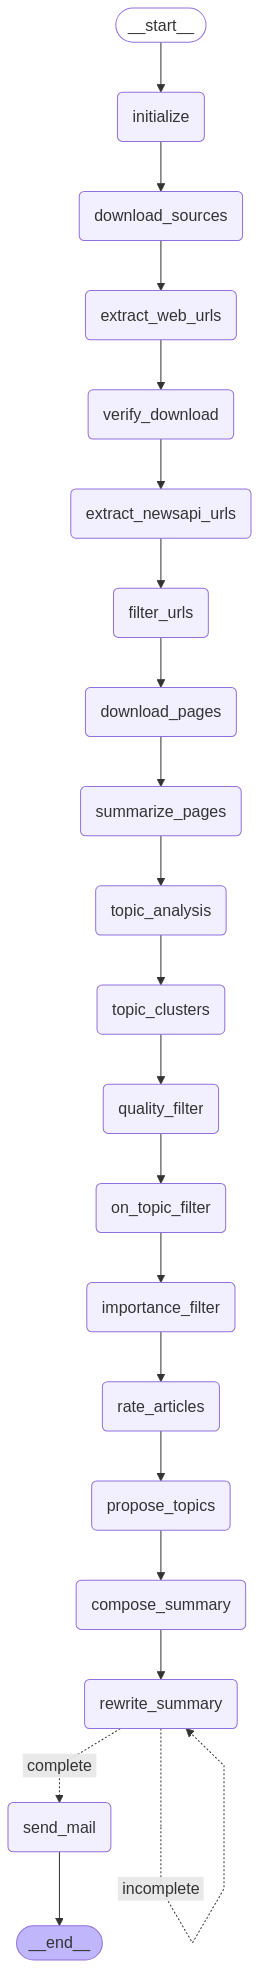

In [4]:
before_date = None
before_date = '2025-04-25 18:00'
do_download = True

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-04-26 10:43:51,420 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-26 10:43:51,420 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-26 10:43:51,421 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-26 10:43:51,421 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-26 10:43:51,421 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-26 10:43:51,421 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-26 10:43:51,421 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'


2025-04-26 10:44:09,539 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 10:44:09,539 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 10:44:09,540 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 10:44:09,540 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-26 10:44:09,541 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-26 10:44:09,541 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-26 10:44:09,541 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-26 10:44:09,542 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-26 10:44:59,929 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-04-26 10:44:59,954 - AInewsbot - INFO - get_driver - Resizing window
2025-04-26 10:45:00,462 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-04-26 10:45:00,463 - AInewsbot - INFO - get_driver - Resi

2025-04-26 10:46:34,424 - AInewsbot - INFO - Downloaded Ars Technica to htmldata/Ars Technica (04_26_2025 10_45_17 AM).html
2025-04-26 10:46:34,424 - AInewsbot - INFO - Downloaded HackerNoon to htmldata/HackerNoon (04_26_2025 10_45_27 AM).html
2025-04-26 10:46:34,424 - AInewsbot - INFO - Downloaded Techmeme to htmldata/Techmeme (04_26_2025 10_45_38 AM).html
2025-04-26 10:46:34,425 - AInewsbot - INFO - Downloaded The Verge to htmldata/The Verge (04_26_2025 10_45_50 AM).html
2025-04-26 10:46:34,425 - AInewsbot - INFO - Downloaded WSJ to htmldata/WSJ (04_26_2025 10_46_07 AM).html
2025-04-26 10:46:34,426 - AInewsbot - INFO - Downloaded Bloomberg to htmldata/Bloomberg (04_26_2025 10_45_16 AM).html
2025-04-26 10:46:34,426 - AInewsbot - INFO - Downloaded Hacker News 2 to htmldata/Hacker News 2 (04_26_2025 10_45_26 AM).html
2025-04-26 10:46:34,426 - AInewsbot - INFO - Downloaded Reddit to htmldata/Reddit (04_26_2025 10_45_58 AM).html
2025-04-26 10:46:34,427 - AInewsbot - INFO - Downloaded Wash

run exception
'src'


2025-04-26 10:46:34,730 - AInewsbot - INFO - parse_file - found 211 raw links
2025-04-26 10:46:34,738 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-04-26 10:46:34,740 - AInewsbot - INFO - 21 links found
2025-04-26 10:46:34,740 - AInewsbot - INFO - FT -> htmldata/FT (04_26_2025 10_45_14 AM).html
2025-04-26 10:46:34,811 - AInewsbot - INFO - parse_file - found 487 raw links
2025-04-26 10:46:34,824 - AInewsbot - INFO - parse_file - found 122 filtered links
2025-04-26 10:46:34,825 - AInewsbot - INFO - 122 links found
2025-04-26 10:46:34,825 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly AI (04_26_2025 10_46_34 AM).html
2025-04-26 10:46:34,903 - AInewsbot - INFO - parse_file - found 139 raw links
2025-04-26 10:46:34,909 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-04-26 10:46:34,910 - AInewsbot - INFO - 36 links found
2025-04-26 10:46:34,910 - AInewsbot - INFO - Hacker News 1 -> htmldata/Hacker News 1 (04_26_2025 10_45_25 AM).html
2025-04-26 10:46:34,937

,id
src,
Ars Technica,35
Bloomberg,32
Business Insider,21
FT,60
Feedly AI,35
Hacker News 1,25
Hacker News 2,25
HackerNoon,19
New York Times,19


2025-04-26 10:46:37,888 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,35
Bloomberg,32
Business Insider,21
FT,60
Feedly AI,35
Hacker News 1,25
Hacker News 2,25
HackerNoon,19
New York Times,19


2025-04-26 10:46:37,900 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-25T10:46:37 from NewsAPI


,id
src,
Ars Technica,35
Bloomberg,32
Business Insider,21
FT,60
Feedly AI,35
Hacker News 1,25
Hacker News 2,25
HackerNoon,19
New York Times,19


2025-04-26 10:46:38,395 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-25 18:00'
2025-04-26 10:46:40,449 - AInewsbot - INFO - URLs in orig_df: 917
2025-04-26 10:46:40,461 - AInewsbot - INFO - Existing URLs in DB: 250323
2025-04-26 10:46:40,696 - AInewsbot - INFO - New URLs in df filtered by URL: 326
2025-04-26 10:46:41,137 - AInewsbot - INFO - Existing src+title: 2
2025-04-26 10:46:41,139 - AInewsbot - INFO - New URLs in df filtered by src+title: 324
2025-04-26 10:46:41,195 - AInewsbot - INFO - Found 324 unique new headlines
2025-04-26 10:46:41,201 - AInewsbot - INFO - Found 321 unique cleaned new headlines
2025-04-26 10:46:46,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:46:52,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:46:52,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTT

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,4
Hacker News 2,3
NewsAPI,40
Reddit,1


2025-04-26 10:46:53,209 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-26 10:46:53,212 - AInewsbot - INFO - Processing page 0: https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee
2025-04-26 10:46:53,214 - AInewsbot - INFO - Processing page 1: https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn
2025-04-26 10:46:53,214 - AInewsbot - INFO - Processing page 2: http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/
2025-04-26 10:46:53,214 - AInewsbot - INFO - Processing page 3: https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid
2025-04-26 10:46:53,214 - AInewsbot - INFO - get_url(https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee) - starting get_url https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee
2025-04-26 10:46:53,215 - AInewsbot - INFO - get_url(https://www.tec

2025-04-26 10:47:41,410 - AInewsbot - INFO - get_url(AP to bring in AI to drive citizen services) - Saving AP_to_bring_in_AI_to_drive_citizen_services.html as utf-8
2025-04-26 10:47:41,412 - AInewsbot - INFO - Processing page 13: https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252
2025-04-26 10:47:41,416 - AInewsbot - INFO - get_url(https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252) - starting get_url https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252
2025-04-26 10:47:43,685 - AInewsbot - INFO - get_url(AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know) - Saving AI-Assisted_Software_Development__Hype_Vs._RealityWhat_You_Need_To_Know.html as utf-8
2025-04-26 10:47:43,699 - AInewsbot - INFO - Processing page 14: https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html
2025-04-26 10:47:43,713 - AInewsbot - INFO - get_url(https://www.cnbc.com/2025/04/25/alphabet-

2025-04-26 10:48:33,372 - AInewsbot - INFO - get_url(Beginners Guide to AI : Tools, Agents and Vibe Coding Explained) - Saving Beginners_Guide_to_AI___Tools__Agents_and_Vibe_Coding_Explained.html as UTF-8
2025-04-26 10:48:33,375 - AInewsbot - INFO - Processing page 25: https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/
2025-04-26 10:48:33,378 - AInewsbot - INFO - get_url(https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/) - starting get_url https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/
2025-04-26 10:48:34,784 - AInewsbot - INFO - get_url(Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup) - Saving Being_nice_to_ChatGPT__breaking_up_Google__and_the_new_space_race__Tech_news_roundup.html as utf-8
2025-04-26 10:48:

2025-04-26 10:49:19,678 - AInewsbot - INFO - get_url(Finding Paths of Least Action with Gradient Descent) - Saving Finding_Paths_of_Least_Action_with_Gradient_Descent.html as utf-8
2025-04-26 10:49:19,681 - AInewsbot - INFO - Processing page 38: https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life
2025-04-26 10:49:19,681 - AInewsbot - INFO - get_url(https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life) - starting get_url https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life
2025-04-26 10:49:22,731 - AInewsbot - INFO - get_url(Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way.) - Saving Companies_Are_Struggling_to_Drive_a_Return_on_AI._It_Doesnt_Have_to_Be_That_Way..html as utf-8
2025-04-26 10:49:22,786 - AInewsbot - INFO - Processing page 39: https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3
2025-04-26 10:49:22,788 - AInewsbot - INFO - get_ur

2025-04-26 10:50:15,991 - AInewsbot - INFO - Processing page 49: https://www.darioamodei.com/post/the-urgency-of-interpretability
2025-04-26 10:50:16,123 - AInewsbot - INFO - get_url(https://www.darioamodei.com/post/the-urgency-of-interpretability) - starting get_url https://www.darioamodei.com/post/the-urgency-of-interpretability
2025-04-26 10:50:18,014 - AInewsbot - INFO - get_url(Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity) - Saving Interpretability__or_understanding_how_AI_models_work__can_help_mitigate_many_AI_risks__such_as_misalignment_and_misuse__that_stem_from_AI_systems__opacity.html as utf-8
2025-04-26 10:50:18,023 - AInewsbot - INFO - Processing page 50: https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4
2025-04-26 10:50:18,027 - AInewsbot - INFO - get_url(https://www.businessinsider.com/anthropic-google-ai-consciousnes

2025-04-26 10:50:59,272 - AInewsbot - INFO - Processing page 62: https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/
2025-04-26 10:50:59,278 - AInewsbot - INFO - get_url(https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/) - starting get_url https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/
2025-04-26 10:51:07,519 - AInewsbot - INFO - get_url(Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity) - Saving Motorola_Adds_New_Features_to_Moto_AI__Teams_Up_With_Google__Microsoft_and_Perplexity.html as utf-8
2025-04-26 10:51:07,527 - AInewsbot - INFO - Processing page 63: https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana
2025-04-26 10:51:07,701 - AInewsbot - INFO - get_url(https://cointelegraph.com/news/nous-research-r

2025-04-26 10:51:40,365 - AInewsbot - INFO - Processing page 75: https://github.com/OpenCyberspace/AIGr.id
2025-04-26 10:51:40,365 - AInewsbot - INFO - get_url(https://github.com/OpenCyberspace/AIGr.id) - starting get_url https://github.com/OpenCyberspace/AIGr.id
2025-04-26 10:51:42,339 - AInewsbot - INFO - get_url(Reducto, which helps companies convert complex documents into inputs for LLMs, raised a $24.5M Series A led by Benchmark, following a $8.4M seed in October 2024) - Saving Reducto__which_helps_companies_convert_complex_documents_into_inputs_for_LLMs__raised_a__24.5M_Series_A_led_by_Benchmark__following_a__8.4M_seed_in_October_2024.html as utf-8
2025-04-26 10:51:42,342 - AInewsbot - INFO - Processing page 76: https://www.redfin.com/blog/new-home-gadgets-to-watch/
2025-04-26 10:51:42,348 - AInewsbot - INFO - get_url(https://www.redfin.com/blog/new-home-gadgets-to-watch/) - starting get_url https://www.redfin.com/blog/new-home-gadgets-to-watch/
2025-04-26 10:51:47,058 - AInewsbo

2025-04-26 10:52:26,479 - AInewsbot - INFO - get_url(What the 'GPT' in ChatGPT actually stands for) - Saving What_the__GPT__in_ChatGPT_actually_stands_for.html as utf-8
2025-04-26 10:52:26,484 - AInewsbot - INFO - Processing page 88: https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence
2025-04-26 10:52:26,486 - AInewsbot - INFO - get_url(https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence) - starting get_url https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence
2025-04-26 10:52:28,529 - AInewsbot - INFO - get_url(The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem) - Saving The_new_AI_calculus__Googles_80__cost_edge_vs._OpenAIs_ecosystem.html as utf-8
2025-04-26 10:52:28,533 - AInewsbot - INFO - Processing page 89: https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html
2025-04-26 10:52:28,536 - AIne

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,4
Hacker News 2,3
NewsAPI,40
Reddit,1


2025-04-26 10:53:05,491 - AInewsbot - INFO - Starting summarize
2025-04-26 10:53:05,494 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-26 10:53:05,578 - AInewsbot - INFO - clean_html - Page title: “Musk Is Scamming the City of Memphis”: Meet Two Brothers Fighting Colossus, Musk’s xAI Data Center | Democracy Now!
Social card title: “Musk Is Scamming the City of Memphis”: Meet Two Brothers Fighting Colossus, Musk’s xAI Data Center
Social card description: We speak with two brothers who are fighting Elon Musk’s artificial intelligence company xAI over its massive data center in Memphis, Tennessee, used to run its chatbot Grok. The facility is next to historically Black neighborhoods and is powered by 35 pollution-spewing methane gas turbines the company is using without legal permits. Musk says he wants to continue expanding the project.
“What’s happening in Memphis is a human rights violation,” says KeShaun Pearson, executive director of the environmental justice organi

2025-04-26 10:53:08,574 - AInewsbot - INFO - clean_html - Page title: Alphabet adds nearly 2% as search, advertising units show resilience
Social card title: Alphabet adds nearly 2% as search, advertising units show resilient growth
Social card description: Alphabet shares are down more than 14% this year as markets face volatility from mounting trade war fears and worries about President Donald Trump's tariffs.

2025-04-26 10:53:08,649 - AInewsbot - INFO - Queuing 14: Page title: Alphabet adds nearly 2% as search, adv...
2025-04-26 10:53:08,817 - AInewsbot - INFO - clean_html - Page title: Alphabet shares rises as AI bets begin to pay off - The Economic Times
Social card title: Alphabet shares rises as AI bets begin to pay off
Social card description: Alphabet shares rose over 5% after strong ad revenue and AI-driven growth beat expectations, despite cloud slowdown and macroeconomic concerns. Investors remain confident amid heavy AI investments and legal pressures, with analysts raisi

2025-04-26 10:53:12,395 - AInewsbot - INFO - clean_html - Page title: ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice
Social card title: ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice
Social card description: For one Reddit user, OpenAI's ChatGPT Advanced Voice Mode suddenly went from chirpy and helpful to downright demonic.

2025-04-26 10:53:12,421 - AInewsbot - INFO - Queuing 29: Page title: ChatGPT Suddenly Starts Speaking in Te...
2025-04-26 10:53:12,530 - AInewsbot - INFO - clean_html - Page title: Companies Are Struggling to Drive a Return on AI. It Doesn’t Have to Be That Way. - WSJ
Social card title: Companies Are Struggling to Drive a Return on AI. It Doesn’t Have to Be That Way.
Social card description: Successful AI adoption begins with a targeted and intentional approach, and proceeds with careful orchestration and scaling across the organization.

2025-04-26 10:53:12,603 - AInewsbot - INFO - Queuing 30: Page title: Companies Are Struggling to Drive a

2025-04-26 10:53:16,961 - AInewsbot - INFO - clean_html - Page title: ChatGPT o3 photo location feature is crazy good - here's a test
Social card title: I used fake ChatGPT images to fool o3's amazing photo location capability, and the AI still blew my mind
Social card description: OpenAI ChatGPT o3 and o4-mini models can determine location information by looking at a photo - and yes, it can be fooled.

2025-04-26 10:53:17,060 - AInewsbot - INFO - Queuing 45: Page title: ChatGPT o3 photo location feature is c...
2025-04-26 10:53:17,089 - AInewsbot - INFO - clean_html - Page title: INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of
Social card title: INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers – QUBT
Social card description: NEW YORK, April  25, 2025  (GLOBE NEWSWIRE) -- Pomerantz LLP announces that a class action lawsuit has been filed against Quantum Computing Inc. (“QCI” or...

2025-04-26 10:53:

2025-04-26 10:53:19,844 - AInewsbot - INFO - Queuing 59: Page title: Motorola Adds New Features to Moto AI;...
2025-04-26 10:53:19,920 - AInewsbot - INFO - clean_html - Page title: Multi-AI Interaction Applications : SessionChat
Social card title: Multi-AI Interaction Applications
Social card description: SessionChat - SessionChat is an innovative application that allows users to interact with multiple AI models simultaneously. It offers the flexibility to toggle ...

2025-04-26 10:53:20,020 - AInewsbot - INFO - Queuing 60: Page title: Multi-AI Interaction Applications : Se...
2025-04-26 10:53:20,075 - AInewsbot - INFO - clean_html - Page title: Intel’s new CEO preps ‘de-laborating’ job cuts for Q2 • The Register
Social card title: Intel’s new CEO preps ‘de-laborating’ job cuts for Q2
Social card description: : Thousands face ax, more given RTO orders in quest to suck less

2025-04-26 10:53:20,158 - AInewsbot - INFO - Queuing 61: Page title: Intel’s new CEO preps ‘de-laborating’ ...
20

2025-04-26 10:53:23,847 - AInewsbot - INFO - Queuing 74: Page title: Bloomberg - Are you a robot?
To contin...
2025-04-26 10:53:23,949 - AInewsbot - INFO - clean_html - Page title: GitHub - OpenCyberspace/AIGr.id: Infrastructure for Polycentric AI Networks
Social card title: GitHub - OpenCyberspace/AIGr.id: Infrastructure for Polycentric AI Networks
Social card description: Infrastructure for Polycentric AI Networks. Contribute to OpenCyberspace/AIGr.id development by creating an account on GitHub.

2025-04-26 10:53:24,027 - AInewsbot - INFO - Queuing 75: Page title: GitHub - OpenCyberspace/AIGr.id: Infra...
2025-04-26 10:53:24,177 - AInewsbot - INFO - clean_html - Page title: Don't Miss These New Home Gadgets of 2025 - Redfin
Social card title: Smart Home Devices And AI Automation: New Home Gadgets To Watch In 2025
Social card description: Explore the Future Home in 2025: Discover the Top New Smart Gadgets & AI Automation Set to Revolutionize Your Living Space!

2025-04-26 10:53:24,37

2025-04-26 10:53:26,589 - AInewsbot - INFO - Queuing 91: Page title: Yahoo Joins OpenAI on List of Suitors ...
2025-04-26 10:53:28,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:28,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:28,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:28,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:28,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:29,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:29,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:29,204 - httpx - INFO - H

2025-04-26 10:53:31,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:31,407 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:31,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:32,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:32,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:32,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:32,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:32,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:33,088 - httpx 

2025-04-26 10:53:37,666 - AInewsbot - INFO - Summary for 8 (length 7851): • Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.
2025-04-26 10:53:37,667 - AInewsbot - INFO - Summary for 9 (length 6778): • Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to re

2025-04-26 10:53:37,673 - AInewsbot - INFO - Summary for 18 (length 2660): • Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.
2025-04-26 10:53:37,674 - AInewsbot - INFO - Summary for 19 (length 1589): • Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential fut

2025-04-26 10:53:37,678 - AInewsbot - INFO - Summary for 28 (length 7719): • The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.
2025-04-26 10:53:37,678 - AInewsbot - INFO - Summary for 29 (length 3346): • Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as 

2025-04-26 10:53:37,682 - AInewsbot - INFO - Summary for 41 (length 4387): • Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).
2025-04-26 10:53:37,683 - AInewsbot - INFO - Summary for 42 (length 3854): • Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership te

2025-04-26 10:53:37,687 - AInewsbot - INFO - Summary for 51 (length 7203): • Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.
2025-04-26 10:53:37,687 - AInewsbot - INFO - Summary for 52 (length 2106): no content
2025-04-26 10:53:37,687 - AInewsbot - INFO - Summary for 53 (length 42125): • Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data mer

2025-04-26 10:53:37,692 - AInewsbot - INFO - Summary for 63 (length 3614): • Nous Research, a decentralized AI startup, has raised $50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a $1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."
2025-04-26 10:53:37,693 - AInewsbot - INFO - Summary for 64 (length 1488): no content
2025-04-26 10:53:37,693 - AInewsbot - INFO - Summary for 65 (length 7954): • The article features a discussion thread with mixed opinions on artificial intelligence (AI), hig

2025-04-26 10:53:37,699 - AInewsbot - INFO - Summary for 76 (length 15558): • Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.
2025-04-26 10:53:37,699

2025-04-26 10:53:37,707 - AInewsbot - INFO - Summary for 88 (length 28215): • The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.
2025-04-26 10:53:37,707

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,4
Hacker News 2,3
NewsAPI,40
Reddit,1


2025-04-26 10:53:37,725 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 10:53:42,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:42,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:42,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:46,097 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:53,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:53:53,121 - AInewsbot - INFO - 92 free-form topics extracted
2025-04-26 10:53:53,123 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 10:53:53,124 - AInewsbot - IN

2025-04-26 10:53:53,154 - AInewsbot - INFO - Canonical topic finance
2025-04-26 10:53:53,154 - AInewsbot - INFO - Canonical topic governance
2025-04-26 10:53:53,154 - AInewsbot - INFO - Canonical topic education
2025-04-26 10:53:53,155 - AInewsbot - INFO - Canonical topic opinion
2025-04-26 10:53:53,155 - AInewsbot - INFO - Canonical topic cybersecurity
2025-04-26 10:53:53,155 - AInewsbot - INFO - Canonical topic ipos
2025-04-26 10:53:53,156 - AInewsbot - INFO - Canonical topic agriculture
2025-04-26 10:53:53,156 - AInewsbot - INFO - Canonical topic privacy
2025-04-26 10:53:53,156 - AInewsbot - INFO - Sending prompt for 105 canonical topics
2025-04-26 10:54:04,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:04,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:05,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/

2025-04-26 10:54:06,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,162 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,174 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:06,258 - httpx 

2025-04-26 10:54:07,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:07,846 - httpx 

2025-04-26 10:54:09,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,549 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:09,562 - httpx 

2025-04-26 10:54:11,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,260 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:11,270 - httpx 

2025-04-26 10:54:12,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:12,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:12,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,095 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,158 - httpx 

2025-04-26 10:54:13,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,905 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:13,914 - httpx 

2025-04-26 10:54:15,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:15,826 - httpx 

,id
src,
Ars Technica,1
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,4
Hacker News 2,3
NewsAPI,40
Reddit,1


2025-04-26 10:54:23,996 - AInewsbot - INFO - Fetching embeddings for 92 headlines
2025-04-26 10:54:25,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-26 10:54:25,944 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-26 10:54:25,985 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-26 10:54:31,574 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-26 10:54:37,776 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-26 10:54:38,043 - AInewsbot - INFO - Found 2 clusters


,title_topic_str
0,"Alphabet jumps 3% as search, advertising units show resilient growth (Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks)"
1,"Alphabet Quarterly Earnings Lifted By Cloud And AI (Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks)"
2,"Alphabet shares rises as AI bets begin to pay off (Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks)"
3,"MSFT Stock: Weathering Tariffs, Winning With AI (Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants)"


2025-04-26 10:54:39,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:39,285 - AInewsbot - INFO - I dub this cluster: Tech Giants Thrive on AI Growth


,title_topic_str
4,"Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) (Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture)"
5,"What the 'GPT' in ChatGPT actually stands for (Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants)"
6,"ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This (Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality)"
7,"The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild (Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants)"
8,"Fox News AI Newsletter: Woman says ChatGPT saved her life (Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants)"
9,"I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind (Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies)"


2025-04-26 10:54:40,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:40,534 - AInewsbot - INFO - I dub this cluster: Exploring ChatGPT and AI Applications
2025-04-26 10:54:40,714 - AInewsbot - INFO - Sending bullet points email
2025-04-26 10:54:42,067 - AInewsbot - INFO - ['Tech Giants Thrive on AI Growth', 'Exploring ChatGPT and AI Applications']


bullets created


[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at \\$2.81 (adjusted \\$2.27) on \\$90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to \\$34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was \\$66.89 billion (up 8.5%), and "Search and other" revenue rose nearly 10% to \\$50.7 billion.
• Google's business chief, Philipp Schindler, noted that ending the de minimis trade exemption could create a "slight headwind" for ads, particularly in Asia-Pacific, but AI-driven features like AI Overviews—now with 1.5 billion monthly users—are showing growth, and analysts see potential upside from AI and cloud monetization.



[Alphabet Quarterly Earnings Lifted By Cloud And AI - www.ibtimes.com.au](https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252)

Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet reported a quarterly profit of \\$34.5 billion and overall revenue growth of 12% to \\$90.2 billion, with cloud unit revenue rising 28% to \\$12.3 billion, driven by strong demand for its AI and cloud computing services.
• CEO Sundar Pichai highlighted Alphabet’s "unique full stack approach to AI" and called the new Gemini software its most advanced AI model.
• Alphabet faces potential antitrust remedies after a US court found Google maintained an illegal online search monopoly, with the Department of Justice suggesting a Chrome browser spin-off, while a separate federal ruling found Google held a monopoly in online ad technology; Google is appealing both decisions.



[Alphabet shares rises as AI bets begin to pay off - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-rises-as-ai-bets-begin-to-pay-off/articleshow/120620519.cms)

Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet shares rose over 5% after first-quarter ad revenue increased 8.5% to \\$66.89 billion, surpassing analysts' expectations, and AI-driven growth outperformed despite a slowdown in Google Cloud revenue and broader macroeconomic concerns.

• Alphabet reiterated plans to invest about \\$75 billion this year in expanding data center capacity, with total Big Tech AI investment in 2025 estimated at \\$320 billion; at least seven brokerages raised price targets for Alphabet after the results.

• Alphabet continues to face significant legal challenges, as the U.S. Department of Justice's antitrust case could force Google to divest key assets, including Chrome, amid regulatory scrutiny of its use of AI to maintain search dominance.



[MSFT Stock: Weathering Tariffs, Winning With AI - Forbes](https://www.forbes.com/sites/greatspeculations/2025/04/25/msft-stock-weathering-tariffs-winning-with-ai/)

Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants

• Microsoft’s stock has declined about 7% in 2024 due to concerns over potential tariffs, but the company’s focus on cloud services and software rather than hardware limits its exposure to such risks.

• Since early 2023, Microsoft’s stock has risen approximately 65%, backed by a 32% revenue increase (from \\$198B in 2022 to \\$262B in the trailing twelve months), a 27% rise in net profits (to \\$93B), and growth in areas such as Azure cloud, AI integration (now exceeding \\$13B annual revenue), and its expanded gaming division after acquiring Activision Blizzard.

• Despite slightly contracting profit margins due to increased AI and R&D spending, Microsoft maintains a strong 35% net margin and has shown resilience in past market downturns, recovering quickly from significant declines.



[Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/sessionchat)

Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture

• SessionChat is a new application launched that enables users to interact with multiple AI models simultaneously, compare their responses, and analyze outputs in real time.
• The tool is designed to benefit businesses, researchers, and content creators by providing diverse perspectives and streamlining multi-dimensional AI-driven input for tasks like brainstorming, problem-solving, and insight gathering.
• SessionChat allows users to prompt and selectively engage different models, aiming to enhance efficiency and versatility in artificial intelligence interactions.



[What the 'GPT' in ChatGPT actually stands for - www.tyla.com](https://www.tyla.com/life/chatgpt-name-meaning-572620-20250424)

Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• The 'GPT' in ChatGPT stands for "Generative Pre-Trained Transformer," describing how the AI generates responses using existing information from the internet and continuously improves with user input.

• Concerns around ChatGPT include intellectual property plagiarism, accuracy, ethical issues in professions reliant on writing, and privacy considerations regarding user data.

• Researchers are developing methods, such as analyzing hyphen usage, to detect AI-generated text, while educators and employers are advised to watch for signs of excessive AI reliance among students and staff.



[ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-made-me-an-ai-action-figure-then-3d-printing-did-this/)

Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.



[The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild - Futurism](https://futurism.com/chatgpt-controversial-images)

Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants

• Users on Reddit shared that ChatGPT's latest image generator can produce controversial images despite its content guardrails, with examples including a photorealistic Jesus Christ making an obscene gesture and disturbing imagery like a baby head being cut on a dinner plate.
• When asked directly for the "most controversial image," ChatGPT initially offers disclaimers and suggests satirical or critical subjects (such as AI taking jobs or algorithmic bias), but ultimately produces more restrained and conceptually provocative images rather than overtly shocking or offensive ones.
• The level and style of controversy in ChatGPT-generated images vary widely, with some outputs described as derivative or humorously absurd, such as a robot on trial judged by an eclectic group including Karl Marx, Martin Luther King, Jr., and Ayn Rand.



[Fox News AI Newsletter: Woman says ChatGPT saved her life - Fox News](https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life)

Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants

• A woman credits ChatGPT with saving her life after the AI chatbot flagged a condition leading to her cancer, which doctors had missed.
• Tesla has launched a test run of its AI-powered Full Self-Driving (FSD) supervised ride-hailing service in Austin, Texas, and the San Francisco Bay Area for an early group of employees.
• The U.S. House Committee is seeking information from China's AI company DeepSeek regarding its use of U.S. data for training and concerns about ties to Chinese government propaganda.



[I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind - BGR](https://bgr.com/tech/i-used-fake-chatgpt-images-to-fool-o3s-amazing-photo-location-capability-and-the-ai-still-blew-my-mind/)

Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies

• OpenAI’s new ChatGPT o3 and o4-mini models feature advanced image interpretation and reasoning capabilities, allowing them to identify locations from photos—even when presented with AI-generated fake images.
• In tests, both o3 and o4-mini successfully identified the famous Matterhorn peak from a generated image, despite manipulated elements and absence of real photo metadata, demonstrating strong but imperfect computer vision abilities.
• Neither model was able to detect that the images were fake, highlighting both the impressive analytical skills of the models and potential for misuse, as well as raising privacy and authenticity concerns with AI-generated imagery.



[The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem - VentureBeat](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/)

Topics: AI Agent Ecosystems, AI Content Creation, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Generative AI Model Comparison, Google AI Cost Advantage, Hardware, Infrastructure, John Giannandrea, Language Models, Large Language Models, Open Source, OpenAI And Microsoft Azure, Products, Retrieval Augmented Generation, Semiconductor Chips, Stocks, Tpu Vs Gpu In AI, Transformers, Virtual Assistants

• Google holds a major cost advantage in generative AI due to its custom Tensor Processing Units (TPUs), potentially running workloads at roughly 20% of the cost paid by OpenAI, which relies on Nvidia GPUs with high markups; this translates to lower Google API pricing and improved long-term total cost of ownership for enterprises.

• Google is pursuing an open and interoperable agent ecosystem, exemplified by its Agent-to-Agent (A2A) protocol and Agent Development Kit, while OpenAI focuses on deeply integrated, tool-using agents within its own stack, appealing to organizations invested in the Azure/Microsoft ecosystem.

• Both Google’s Gemini 2.5 Pro and OpenAI’s o3 models offer competitive capabilities, with Gemini leading in context window size and reliability, and o3 excelling at deep tool-assisted reasoning but exhibiting higher hallucination rates; enterprise adoption often depends on integration depth, market reach, and compatibility with existing vendor relationships.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Content Creation, AI Integration In Government, Automation Errors, Bias And Fairness, Chatbots, Code Assistants, Cryptocurrency, Cybersecurity, Economics, Elon Musk'S AI Initiatives, Ethics, Federal Agency AI Restructuring, Fintech, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Social Security Administration, Society & Culture, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI bot, called the Agency Support Companion, into staff workflows to automate tasks and enhance productivity, but employees report it is ineffective and the accompanying training video omitted key privacy guidance.
• A recent SSA incident linked to DOGE staffers mistakenly marked as many as 4 million living benefit recipients as deceased, leading to benefit cutoffs and requiring lengthy reinstatement processes.
• DOGE, backed by Elon Musk, is pursuing an "AI-first" restructuring of federal agencies including SSA, aiming to cut the workforce in half and rewrite the agency’s entire codebase with AI, raising concerns based on similar problematic automation attempts in other countries such as Brazil.



[This artist was huge in the '80s. Now, he's taught AI to steal his style - Creative Bloq](https://www.creativebloq.com/ai/ai-art/this-artist-was-huge-in-the-80s-now-hes-taught-ai-to-steal-his-style)

Topics: AI Content Creation, AI In Creative Industries, AI-Assisted Art, Art & Design, Art Exhibitions With AI, Authors & Writing, Computer Vision, David Salle, Digital And Traditional Art Blend, Entertainment, Fashion, Gen AI, History, Intellectual Property, Language Models, Opinion, Products, Society & Culture, Uk

• David Salle, a prominent 1980s artist, has trained a custom AI model to generate new works in his style by feeding it scans of his own thick-brush sketches and previous paintings, resulting in a new body of work called New Pastorals.
• Salle's AI-assisted paintings are currently featured in the exhibition "Some Versions of Pastoral" at Thaddaeus Ropac London, running until June 8, blending digitally printed underpainting by the AI with hand-painted oils.
• Salle states, "I don’t think the machine’s taught me very much at all. I haven’t reconsidered how I think about pictorial space or composition. I’m simply taking what the machine offers after I’ve told it what I want," emphasizing his ongoing control over the creative process.



[Workers could save 122 hours a year by using AI in admin tasks, Google finds | CNN Business - CNN](https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html)

Topics: AI Adoption Barriers, AI Content Creation, AI In Administrative Work, Bias And Fairness, Code Assistants, Customer Service, Economic Impact Of AI, Economics, Education, Ethics, Finance, Funding, Gen AI, Gender And Socioeconomic Factors In AI Use, Health & Fitness, Inequality, Job Automation, Jobs & Careers, John Giannandrea, Labor Market, Language Models, Large Language Models, Retrieval Augmented Generation, Society & Culture, Uk, Virtual Assistants, Workforce AI Training

• Google reports that workers in UK pilot programs saved an average of 122 hours per year on administrative tasks by using AI, and estimates that nationwide AI adoption could contribute £400 billion (\\$533 billion) in economic growth if workers are trained.  
• The study found that most workers—especially older women from lower socio-economic backgrounds—had not used generative AI at work, with concerns about whether AI use was legitimate being a key barrier.  
• After brief AI training and reassurance, the share of women over 55 using AI weekly increased from 17% to 56% and daily use from 9% to 29% within three months.



[5 Proven Ways to Make Money With AI Skills - www.instantshift.com](http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/)

Topics: Affiliate Marketing With AI, AI Content Creation, AI-Generated Artwork, Art & Design, Authors & Writing, Cognitive Science, Economics, Education, Entertainment, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Monetizing AI Skills, No-Code AI Tools, Products, Society & Culture

• The article outlines five ways individuals can earn income using AI skills, including AI content creation, selling AI-generated artwork, affiliate marketing with AI, offering AI integration services, and building products with no-code AI tools.
• It highlights platforms like Coursiv for learning AI skills and sites such as Redbubble and Society6 for selling AI-generated designs.
• The article emphasizes the growing accessibility of AI tools, making it easier for everyday workers to monetize AI abilities without advanced technical backgrounds.



[OpenAIs GPT-4 might be coming to an end. Heres why thats actually good news - Digital Trends](https://www.digitaltrends.com/computing/openais-gpt-4-might-be-coming-to-an-end-heres-why-thats-actually-good-news/)

Topics: AI Content Creation, AI Model Evolution, AI Reasoning Models, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Gen AI, Gpt-4.5 Sunset, Gpt-5 Launch, Language Models, Large Language Models, Open Source, OpenAI Gpt-4 Retirement, Products, Review, Singularity, Society & Culture, Speech Recognition & Synthesis, Transformers, Virtual Assistants

• OpenAI has announced the retirement of its GPT-4 model as of April 30, and will also sunset GPT-4.5, as the company prepares for the anticipated launch of GPT-5 later in 2025.  
• GPT-4.5, introduced in February 2025 and noted for passing the Turing Test in a UC San Diego study, will see its API supported until July 14 before removal, as OpenAI stated it did not meet the company's "frontier level" ambitions.  
• OpenAI has shifted focus toward reasoning models (like o3 and o4-mini), released a developer-focused GPT-4.1 API, and CEO Sam Altman has hinted at new AI model naming sequences with GPT-5 expected to introduce autonomous AI agents and selective model tasking.



[Nvidia only cares about Ai: - Reddit](https://www.reddit.com/r/pcmasterrace/comments/1k88l8s/nvidia_only_cares_about_ai/)

Topics: Artificial Intelligence Focus, Hardware, Nvidia

no content



[Beginners Guide to AI : Tools, Agents and Vibe Coding Explained - Geeky Gadgets](https://www.geeky-gadgets.com/ai-beginners-guide-2025/)

Topics: Agent-Based AI Systems, AI Content Creation, AI Tools For Beginners, Art & Design, Artificial General Intelligence, Automation Platforms, Chatbots, Chatgpt Image Generation, Chatgpt Usage, Code Assistants, Cognitive Science, Education, Entertainment, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Low-Code App Development, Products, Retrieval Augmented Generation, Society & Culture, Transformers

• The guide by Riley Brown explains how beginners can use AI tools such as ChatGPT, MidJourney, and Runway Gen-4 to simplify creative, automation, and app development tasks, highlighting their accessibility for users without technical backgrounds.

• It introduces agent-based systems like Manis and ChatGPT’s research mode, which can autonomously handle complex tasks including data analysis and coding, and discusses automation platforms like Zapier for streamlining workflows.

• The concept of "vibe coding" is outlined, showing how platforms like Cursor and Vibe Code App enable users to develop functional applications with minimal coding by leveraging AI tools and APIs, broadening access to app development.



[Nous Research secures \\$50M from Paradigm to build decentralized AI on Solana - Cointelegraph](https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Nous Research, Open Source, Open Source AI Models, Paradigm Funding, Privacy & Surveillance, Products, Society & Culture, Solana Blockchain, Sustainability, Venture Capital

• Nous Research, a decentralized AI startup, has raised \\$50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a \\$1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[All in the Family: Matias and Eglae Recchia On AI as a Commercial Real Estate Disruptor - commercialobserver.com](http://commercialobserver.com/2025/04/all-in-the-family-matias-and-eglae-recchia-on-ai-as-a-commercial-real-estate-disruptor/)

Topics: AI Content Creation, AI In Commercial Real Estate, Artificial General Intelligence, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Industry-Specific AI Solutions, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Keyway AI Tools, Labor Market, Language Models, Mergers And Acquisitions, Products, Real Estate Data Automation, Society & Culture, Supply Chain Optimization, Testing

• Matias Recchia, CEO of Keyway, and his sister Eglae Recchia, a technology advisor and former chief product officer at Berkadia, are leveraging artificial intelligence to disrupt commercial real estate by automating labor-intensive tasks and integrating fragmented data sources.
• Keyway has shifted from acquiring properties using AI to licensing AI-powered software tools, such as Keydocs, which can extract insights from large volumes of real estate documents, reducing manual work from weeks to hours and enabling asset managers to make faster, data-driven decisions.
• The Recchias emphasize that industry-specific AI solutions provide contextual intelligence, allowing real estate professionals to quickly analyze ownership, debt, and valuation data, with Matias stating, “Now I spend my time making portfolio decisions—not reading PDFs,” and both aiming to propel greater AI adoption industry-wide for increased efficiency and liquidity.



[How Engineering Leaders Can Guide Teams To Thrive In An AI-First World - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/how-engineering-leaders-can-guide-teams-to-thrive-in-an-ai-first-world/)

Topics: AI In Engineering, Artificial General Intelligence, Cognitive Science, Economics, Education, Future Of Jobs, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Large Language Models, Opinion, Prompt Engineering, Society & Culture, Workforce Transformation

• Engineering leaders are encouraged to rethink team skills and structures as AI increasingly automates rote tasks and reshapes the software engineering landscape; qualities like adaptability, creativity, and the ability to work with intelligent systems are now essential for success.

• Key skills for engineers to thrive in an AI-first world include prompt engineering, systems thinking, critical reasoning/problem decomposition, and continuous learning and adaptability, according to recent reports from the World Economic Forum, MIT Sloan Management Review, and McKinsey & Company.

• By 2030, technology is projected to displace 92 million jobs and create 170 million new roles (net growth of 78 million jobs), emphasizing job transformation rather than loss; leaders are urged to create learning environments that prioritize experimentation with AI tools and critical evaluation skills.



[Former President Barack Obama Weighs In On The Human Touch Vs. AI For Coding - Black Enterprise](https://www.blackenterprise.com/could-ai-put-humans-at-risk-of-losing-jobs-obama-thinks-so/)

Topics: AI Content Creation, AI Doom, AI Impact On Tech Jobs, Artificial General Intelligence, Barack Obama AI Coding Views, Bias And Fairness, Code Assistants, Cognitive Science, Economics, Education, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Hollywood, Inequality, Job Automation, Job Displacement Concerns, Jobs & Careers, Kevin Hart AI Initiatives, Labor Market, Language Models, Large Language Models, Opinion, Policy And Regulation, Politics, Products, Racial Disparity In AI Adoption, Safety And Alignment, Society & Culture

• Former President Barack Obama stated that advanced AI models can now code better than 60-70% of human coders, predicting that many high-skill tech jobs may become obsolete as AI continues to improve.  
• Obama emphasized that while top coders may leverage AI as a tool, routine coding jobs are at risk, warning that this shift will impact multiple professions beyond just tech.  
• Research from Michigan State University and UCLA points to a racial disparity in AI adoption among businesses, with Black-owned firms having the lowest usage and Latinx workers in California at particularly high risk of job loss due to AI-driven automation, potentially widening the racial wealth gap by \\$43 million annually according to McKinsey Institute for Economic Mobility.  
• Kevin Hart, through his Coramino Fund initiative, is encouraging underresourced entrepreneurs to embrace AI through grants and training, stating, “The train is coming and coming fast. Either you’re on it, or if not, get out of the way.”



[Anwar wants digital technology, AI to be mastered at school level - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/25/anwar-wants-digital-technology-ai-to-be-mastered-at-school-level)

Topics: AI Content Creation, AI Faculties In Universities, Artificial General Intelligence, China, Cognitive Science, Digital Technology In Schools, Economics, Education, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Malaysia AI Education, Manufacturing, Pm Anwar Ibrahim, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Workforce AI Skills Shortage

• Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential future technologies.
• Anwar noted that universities in Malaysia now have AI faculties, units, and departments across all disciplines and highlighted the importance of schools moving quickly to integrate these skills.
• He also pointed to an expected workforce shortage, saying Malaysia could lack 30,000 engineers to meet the needs of prominent AI, digital, and semiconductor companies investing in the country.



[Apple to strip not-so-secret robotics unit from struggling AI chief John Giannandrea - MacDailyNews](https://macdailynews.com/2025/04/25/apple-to-strip-not-so-secret-robotics-unit-from-struggling-ai-chief-john-giannandrea/)

Topics: AI Team Restructuring, Apple AI Development Challenges, Apple Robotics Unit, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri Oversight Transfer, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its robotics unit from AI chief John Giannandrea’s supervision to the hardware division under Senior Vice President John Ternus later this month, amid restructuring due to AI development challenges.
• This marks the second major project removed from Giannandrea in the past month, following the transfer of Siri oversight in March, as Apple attempts to catch up with AI leaders like Google and OpenAI.
• Internal delays and dissatisfaction over Siri and other AI initiatives have led to significant staff transfers from Giannandrea's group, raising speculation about his future at Apple, though he has not indicated plans to leave.



[Anthropic sent a takedown notice to a dev trying to reverse-engineer its coding tool - TechCrunch](https://techcrunch.com/2025/04/25/anthropic-sent-a-takedown-notice-to-a-dev-trying-to-reverse-engineer-its-coding-tool/)

Topics: AI Code Obfuscation, AI Content Creation, Anthropic Dmca Takedown, Artificial General Intelligence, Chatbots, Claude Code AI Tool, Code Assistants, Cognitive Science, Cybersecurity, Developer Community Criticism, Ethics, Gen AI, Hardware, Intellectual Property, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Software Licensing, Testing

• Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.



[The Jobs That Will Fall First As AI Takes Over The Workplace - Forbes](https://www.forbes.com/sites/jackkelly/2025/04/25/the-jobs-that-will-fall-first-as-ai-takes-over-the-workplace/)

Topics: AI And Workforce Transformation, AI Content Creation, Art & Design, Authors & Writing, Customer Service, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Industry Impact Of AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Manufacturing, Sectors Resilient To AI, Singularity, Society & Culture, Stocks, White-Collar Job Displacement

• Artificial intelligence is projected to fundamentally transform the global workforce by 2050, with estimates from PwC, McKinsey, and the World Economic Forum suggesting that up to 60% of current jobs will require significant adaptation due to AI.
• Jobs most vulnerable to early AI disruption include data entry, scheduling, customer service, bookkeeping, financial modeling, basic journalism, paralegal work, and basic graphic design; studies note that administrative, back-office, and routine analytical roles are already being automated.
• High-resilience sectors include labor-intensive fields (construction, skilled trades), patient-facing healthcare roles, teaching, and high-level strategic management, as these require human creativity, empathy, and adaptability.
• Key industry leaders caution about rapid displacement: Goldman Sachs estimates up to 50% of jobs may be fully automated by 2045, while JPMorgan and BlackRock note visible impacts in finance and legal services, predicting major restructuring of white-collar work by 2035.



[AI policies in Africa: Lessons from Ghana and Rwanda - TechXplore](https://techxplore.com/news/2025-04-ai-policies-africa-lessons-ghana.html)

Topics: Agriculture, AI Policies In Africa, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Economics, Energy, Ethical AI Principles, Ethics, Finance, Funding, Gen AI, Ghana AI Strategy, Governance, Health & Fitness, Healthcare, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Rwanda AI Governance, Safety And Alignment, Society & Culture, Sustainability, Sustainable Development Goals

• Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to reach Sustainable Development Goals including health care, agriculture, and economic growth.

• Rwanda's AI policy, shaped by local stakeholders and international partners, prioritizes data sovereignty and national security rooted in its historical context, while Ghana's strategy focuses on attracting foreign investment and expansive AI integration across sectors.

• Both countries are establishing Responsible AI offices and face challenges such as dependence on foreign tech standards, energy shortages, and the need for stronger infrastructure, with recommendations for greater investment in local capacity and collective regional participation in international AI governance.



[OpenAI CEO Claims Saying Please and Thank You to ChatGPT Costs Tens of Millions of Dollars  Heres Why - people.com](https://people.com/open-ai-ceo-claims-saying-please-thank-you-to-chatgpt-costs-millions-of-dollars-in-electricity-bills-11721523)

Topics: AI Content Creation, AI Data Centers, AI Doom, AI Environmental Impact, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Costs, Climate, Code Assistants, Cognitive Science, Energy, Ethics, Gen AI, Governance, Greenhouse Gas Emissions, Infrastructure, Language Models, Large Language Models, OpenAI Energy Consumption, Safety And Alignment, Society & Culture, Sustainability, Virtual Assistants

• OpenAI CEO Sam Altman claimed that users including "please" and "thank you" in ChatGPT queries costs the company "tens of millions of dollars" in electricity due to the extra computation required, responding to a question on X.
• Research cited by NPR states that a single ChatGPT query uses enough energy to power a lightbulb for about 20 minutes, illustrating the significant energy use by generative AI models.
• Companies like Google and Microsoft have reported substantial increases in greenhouse gas emissions in recent years, directly linked to the energy demands of AI data centers; experts warn about AI's impact on climate change.



[How One Company Is Quietly Working To Transform AI Forever - Forbes](https://www.forbes.com/sites/torconstantino/2025/04/25/how-one-company-is-quietly-working-to-transform-ai-forever/)

Topics: AI Content Creation, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Bittensor Blockchain, Cognitive Science, Cryptocurrency, Decentralized AI (Deai), Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Open Source, Open-Source AI Ecosystem, Policy And Regulation, Products, Singularity, Society & Culture, Sustainability

• The Bittensor Endgame Summit took place in Austin, Texas, marking a significant milestone for decentralized AI (DeAI) as builders and developers focused on creating a sustainable, open-source AI ecosystem outside of Big Tech's control.

• Bittensor operates as an open-source blockchain protocol that incentivizes AI model training, deployment, and performance via its native token (TAO), fostering a global, decentralized network with no founders’ cut or investor allocations, according to co-founder Ala Shaabana.

• The Summit featured sessions on real-world DeAI use cases, subnet development, governance models, and open-source collaboration, with leaders emphasizing the need for transparent, accountable infrastructure and a transition of governance from the foundation to the broader community.



[Prince Harry meets, funds youth groups advocating for social media and AI safety | TechCrunch - TechCrunch](https://techcrunch.com/2025/04/25/prince-harry-meets-funds-youth-advocating-for-social-media-and-ai-safety/)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Funding, Gen AI, Governance, Health & Fitness, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Prince Harry, Privacy, Privacy & Surveillance, Responsible Tech Fund, Safety And Alignment, Social Media Safety, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants, Youth Advocacy

• Prince Harry met with youth leaders in Brooklyn working on tech safety, policy, and innovation, and his Archewell Foundation is funding the second cohort of Responsible Tech Youth Power Fund (RTYPF) grantees, alongside partners like Pinterest and Melinda French Gates’ Pivotal Ventures.

• At the event, youth leaders expressed concerns about the speed of technological development, the impact of social media and AI on young people, and the lack of effective regulation or safeguards, especially regarding issues like AI-generated deepfake pornography and mental health.

• Youth participants and organization leaders advocated for increased youth involvement in technology policy, pushing for more collaboration between government agencies, development of future regulations, and support for landmark legal cases shaping tech accountability.



[Q&A with Perplexity CEO Aravind Srinivas on Motorola partnership, Perplexity's upcoming browser Comet, TikTok bid, ChatGPT's scale, Google's DOJ trial, and more (Alex Heath/The Verge) - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistants, AI Content Creation, AI Web Browser, Antitrust In Tech, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Gen AI, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Transportation, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced the launch of Perplexity's own web browser, Comet, next month, aiming to use it as a platform for AI agents capable of performing actions and integrating third-party services for users.

• Motorola will pre-install Perplexity's AI assistant on its new Razr phones, enabled in part by ongoing antitrust scrutiny of Google, which Srinivas claims previously prevented such deals due to OEM pressure.

• Perplexity has grown from 1 million users to nearly 30 million monthly active users in a year and is now handling about 600 million queries monthly, approximately 14% of Google's query volume.

• Srinivas said partnerships with additional OEMs are being explored and emphasized that the browser is key for broader AI integration, as current mobile OS restrictions limit assistant capabilities.

• The interview highlights Perplexity's competitive strategy against Google and Microsoft, its efforts to address publisher concerns about content scraping, and its approach to user data and personalization compared to rivals like OpenAI’s ChatGPT.



[Apples AI chief John Giannandrea has been removed from leading Apples Robotics Team - www.patentlyapple.com](https://www.patentlyapple.com/2025/04/apples-ai-chief-john-giannandrea-has-been-removed-from-leading-apples-robotics-team.html)

Topics: AI Project Leadership, Apple Robotics Team, Artificial General Intelligence, Competition With Google And OpenAI, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri AI Project, Speech Recognition & Synthesis, Virtual Assistants

• Apple has removed AI chief John Giannandrea from leading its robotics team, shifting oversight of the secret robotics department to Senior Vice President John Ternus, who will now handle hardware development.
• This change follows Apple’s recent move assigning Mike Rockwell to lead the AI project advancing Siri, previously managed by Giannandrea, after delays in delivering promised Apple Intelligence Siri features.
• Giannandrea will continue to lead Apple's broader artificial intelligence and machine learning initiatives, with the management shakeup aimed at focusing his team on developing new AI features as Apple seeks to catch up with competitors like Google, OpenAI, and Microsoft.



[AP to bring in AI to drive citizen services - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/ap-to-bring-in-ai-to-drive-citizen-services/article69490846.ece)

Topics: AI Training Programs, Andhra Pradesh AI Adoption, Artificial General Intelligence, China, Citizen Services Automation, Cognitive Science, Customer Service, Education, Gen AI, Governance, Government Digital Transformation, Healthcare, India, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Society & Culture, Testing

• The Andhra Pradesh Government is equipping at least 20 departments with artificial intelligence tools to enhance citizen service delivery, with support from the Wadhwani Centre for Government Digital Transformation.
• Approximately 300 top officials, including 100 "AI Champions" and 200 "AI Catalysts," are undergoing a four-day hands-on training workshop in Amaravati to drive AI adoption, lead digital transformation, and execute AI projects within their respective departments.
• After training, teams will develop and present AI proof-of-concept projects, with the most promising potentially selected for full-scale government implementation.



[Bill Gates predicts 2-day work week as AI set to replace humans for most jobs within a decade - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bill-gates-predicts-2-day-work-week-as-ai-set-to-replace-humans-for-most-jobs-within-a-decade/articleshow/120619326.cms)

Topics: AI Doom, AI Impact On Employment, AI In Multiple Industries, Artificial General Intelligence, Bias And Fairness, Bill Gates AI Job Predictions, Cognitive Science, Economics, Education, Ethical Concerns Of AI, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Opinion, Safety And Alignment, Society & Culture, Transportation, Workweek Reduction

• Bill Gates predicts that artificial intelligence could replace humans in most jobs within the next decade, potentially leading to a two- or three-day workweek and a dramatic shift in employment and work-life balance.

• Gates foresees AI handling roles across various sectors—including manufacturing, logistics, medicine, and education—highlighting that while machines may dominate production tasks, some activities will remain exclusively human.

• The prediction raises concerns about job displacement, wealth inequality, and ethical issues, with Gates and experts like Geoffrey Hinton warning that AI advances could deepen wealth gaps and necessitate new social support systems for those affected by automation.



[Heres how Apple plans to fix Siri in iOS 19 - 9to5Mac](https://9to5mac.com/2025/04/26/apple-fixing-siri-in-ios-19-heres-how/)

Topics: AI Assistant Improvements, AI Content Creation, Apple Siri Overhaul, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Entertainment, Gen AI, Hardware, Ios 19 Update, John Giannandrea, Language Models, Large Language Models, Mike Rockwell Leadership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership team and restructuring groups focused on speech, understanding, performance, and user experience.

• The overhaul aims to resolve longstanding issues caused by rushed integration for iOS 18, address internal leadership complaints, and finally deliver delayed AI-powered Siri features originally intended for iOS 18.



[Microsoft is trying to simplify how it sells Copilot AI offerings, internal slides reveal - Business Insider](https://www.businessinsider.com/microsoft-consolidate-teams-simplify-ai-copilot-2025-4)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Copilot AI Sales, Customer Experience, Customer Service, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Sales Restructuring, Policy And Regulation, Politics, Products, Virtual Assistants

• Microsoft plans to consolidate its six current AI sales "solution areas" into three—AI Business Solutions, Cloud & AI Platforms, and Security—beginning in July, to streamline sales and reduce customer confusion, according to internal slides and a company statement.
• The restructuring aims to accelerate regional skills at scale, align sales teams for different customer types, and expand sales staff training.
• "We are evolving the commercial solution areas within our sales organization to better reflect the era of AI and support the growth of our customers and partners," a Microsoft spokesperson said.



[Mike Lindell's lawyers used AI to write briefjudge finds nearly 30 mistakes - Ars Technica](https://arstechnica.com/tech-policy/2025/04/mypillow-ceos-lawyers-used-ai-in-brief-citing-fictional-cases-judge-says/)

Topics: AI Content Creation, AI In Legal Briefs, AI-Generated Legal Errors, Authors & Writing, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Judicial Sanctions, Legal Issues, Mike Lindell Case, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Scams, Society & Culture, Testing

• A federal judge found nearly 30 defective citations—including misquotes, legal misrepresentations, and references to fictional cases—in a legal brief filed by lawyers for MyPillow CEO Mike Lindell, who admitted using AI to draft the document.
• Judge Nina Wang ordered attorneys Christopher Kachouroff and Jennifer DeMaster to show cause why they should not face sanctions or be referred for disciplinary proceedings, citing violations of professional conduct rules.
• The brief was submitted in a defamation case brought by former Dominion Voting Systems employee Eric Coomer; Kachouroff admitted to using generative AI only after direct questioning by the court.



[AI Voice Clones Let Scammers Spoof Your Loved Ones and Take Your Money - CNET](https://www.cnet.com/personal-finance/ai-voice-clones-let-scammers-spoof-your-loved-ones-and-take-your-money/)

Topics: AI Voice Cloning, Audio Deepfakes, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Fbi Warnings On AI Scams, Gen AI, Governance, Language Models, Legal Issues, Mcafee AI Voice Fraud Study, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Techniques, Scams, Society & Culture, Speech Recognition & Synthesis

• Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.



[AI Tsunami hits Canadian election online, but voter impact limited - The Economic Times](https://economictimes.indiatimes.com/news/international/canada/ai-tsunami-hits-canadian-election-online-but-voter-impact-limited/articleshow/120621382.cms)

Topics: AI Content Creation, AI In Elections, AI-Generated Misinformation, Canadian Federal Election 2025, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Governance, History, Language Models, Legal Issues, Online News Regulation, Opinion, Policy And Regulation, Political Polarization, Politics, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• The MEO (Media Ecosystem Observatory) has identified a major surge in AI-generated election content online during Canada's 2025 federal election campaign, labeling it the most "dystopian" campaign in Canadian history, but has found little evidence of widespread voter manipulation so far.
• AI-generated deepfakes and fake news have proliferated on social media, filling a news void created by Meta's decision to block Canadian news content in response to the Online News Act; some AI content impersonated legitimate news sources to promote scams.
• Canadians are showing increased awareness of online interference and are engaging more with legitimate news sources, while political actors are splitting across platforms—Liberals on Bluesky, Conservatives on X and Instagram—raising concerns about deepening political polarization.



[Amid AR Glasses and AI Action Figures, There's Never Been a Better Time for Black Mirror - CNET](https://www.cnet.com/tech/services-and-software/amid-ar-glasses-and-ai-action-figures-theres-never-been-a-better-time-for-black-mirror/#ftag=CAD590a51e)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Powered Ar Glasses, Art & Design, Augmented Reality Technology, Chatgpt Image Generation, Cognitive Science, Entertainment, Fashion, Gaming, Gen AI, Google Smart Glasses, Hardware, Language Models, Lifestyle & Travel, Meta Ray-Ban Glasses, Products, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• Google demonstrated its latest AI-powered smart glasses at a recent TED conference, with more details expected at the Google I/O developer conference in May.
• Meta is anticipated to release a new version of its Ray-Ban glasses with integrated displays this fall, leading toward its advanced AR glasses prototype, Orion.
• CNET experimented with the current viral trend of AI-generated action figures by creating a 3D-printed likeness of a staff member, discussing the compelling and unsettling nature of AI-driven personalizations.



[Google Gemini, a collaborator to fulfil humans' creative desire, curiosity: VP Shekar Khosla - The Economic Times](https://economictimes.indiatimes.com/tech/technology/google-gemini-a-collaborator-to-fulfil-humans-creative-desire-curiosity-vp-shekar-khosla/articleshow/120621419.cms)

Topics: AI Adoption In India, AI Content Creation, AI Video Generation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Google Gemini AI Tool, Hardware, Imagen 3 Image Creation, India, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Opinion, Products, Shekar Khosla, Society & Culture, Streaming, Tv & Film & Movies, Virtual Assistants

• Google unveiled new features for its Gemini AI tool in India, including the ability to generate high-resolution, eight-second videos using the Veo 2 model, advanced image creation with Imagen 3, an interactive Canvas workspace for text and code collaboration, live video interaction through Gemini Live, and Deep Research for synthesizing web information quickly.

• Shekar Khosla, VP of Marketing at Google India, emphasized Gemini's role as a collaborator enhancing productivity, creativity, and confidence, sharing examples of diverse users—such as job seekers, teachers, and retirees—benefiting from its capabilities, and clarifying, "This is not a replacement for humans. It is human augmentation."

• A joint Google-Kantar study revealed that while 60% of surveyed Indians aren't familiar with AI and only 31% have tried generative AI tools, there is significant interest: 75% express a desire for a daily growth collaborator to boost productivity (72%), creativity (77%), and communication (73%), highlighting growth potential for tools like Gemini in India.



[Tech Giants Power US Stocks to Second Best Week of 2025 - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/s-p-500-rally-stalls-amid-mixed-corporate-earnings-tariff-risks)

Topics: Economics, Finance, Stocks

no content



[Finding Paths of Least Action with Gradient Descent - greydanus.github.io](https://greydanus.github.io/2023/03/05/ncf-tutorial/)

Topics: Automatic Differentiation, Energy, Gradient Descent In Physics, Least Action Principle, Physics Optimization Methods, Pytorch Applications

• The article demonstrates how gradient descent can be used to find the path of least action in a physics system, specifically for a free body in a gravitational field, as an alternative to standard analytical and numerical solutions.  
• By treating the action as an optimization problem and minimizing it using gradient descent (enabled by automatic differentiation tools like PyTorch), the resulting path matches the analytic parabolic trajectory predicted by classical physics.  
• The approach illustrates the principle of least action in physics and is presented as a framework that can generalize to more complex systems beyond simple cases.



[300 billion and counting: most popular chip designer in the world turns 40, and it all started in a wooden barn - TechRadar](https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn)

Topics: AI-Focused Chips, Arm Architecture, Chip Design History, Economics, European Union, Gen AI, Hardware, History, Intellectual Property, Licensing Vs Chip Production, Manufacturing, Mergers And Acquisitions, Products, Robots, Semiconductor Chips, Softbank Acquisition, Uk

• Arm celebrates 40 years since the creation of its first chip, the ARM1, which contained just 25,000 transistors and was developed at Acorn Computers in 1985; Arm-based chips now power over 300 billion devices globally, with 99% of smartphones using its architecture.

• Technological milestones include the shift from 32-bit (ARM6) to 64-bit (Armv8) architectures, and the recent Armv9 launch focused on AI workloads, introducing features like Scalable Vector Extension 2 (SVE2) and Scalable Matrix Extension (SME).

• Industry speculation has increased about Arm moving from a licensing business model into chip production, following SoftBank's acquisition of Ampere Computing, Arm’s only independent server chip vendor.



[Guardforce AI to Host Year-End 2024 Financial Results Conference Call on Monday, April 28th at 8:30 A.M. ET - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068254/0/en/Guardforce-AI-to-Host-Year-End-2024-Financial-Results-Conference-Call-on-Monday-April-28th-at-8-30-A-M-ET.html)

Topics: China, Economics, Finance, Financial Results Conference, Fintech, Funding, Governance, Guardforce AI, Investor Relations, Stocks

• Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).



[Yahoo Joins OpenAI on List of Suitors for Google Chrome - PCMag](https://www.pcmag.com/news/yahoo-joins-openai-on-list-of-suitors-for-google-chrome)

Topics: Antitrust Legal Actions, Browser Market Competition, Cybersecurity, Deals, Economics, Finance, Funding, Google Chrome Potential Sale, Governance, Infrastructure, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI Interest In Chrome, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stocks, Venture Capital, Yahoo Browser Development

• Yahoo has expressed interest in acquiring Google Chrome if the browser is put up for sale, following similar interest from OpenAI and other companies.
• The potential sale of Chrome is being considered as a remedy after a U.S. District Judge ruled in August 2024 that Google maintained an illegal monopoly in search, with the Department of Justice’s lawsuit outcome pending.
• Brian Provost, Yahoo Search’s general manager, stated Yahoo is “developing its own web browser” and “would be able to pursue” Chrome’s acquisition with backing from Apollo Global Management.
• Google’s legal team has pushed back, arguing a forced sale could threaten the viability of Chromium and raise data security issues.



[INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers  QUBT - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068252/1087/en/INVESTOR-ALERT-Pomerantz-Law-Firm-Announces-the-Filing-of-a-Class-Action-Against-Quantum-Computing-Inc-and-Certain-Officers-QUBT.html)

Topics: Deals, Disinformation, Economics, Ethics, Finance, Funding, Governance, Hardware, Investor Legal Action, Legal Issues, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Computing Claims, Quantum Computing Inc Lawsuit, Review, Scams, Securities Fraud, Semiconductor Chips, Stocks

• Pomerantz LLP has filed a class action lawsuit against Quantum Computing Inc. (QCI) and certain officers, alleging violations of federal securities laws by making materially false and misleading statements about the company’s business, operations, and relationships, particularly relating to its quantum computing technologies, NASA ties, and business dealings from March 30, 2020 to January 15, 2025.

• The complaint cites reports from Iceberg Research and Capybara Research in late 2024 and early 2025 that accused QCI of overstating its technological capabilities, fabricating ties to NASA, engaging in undisclosed related-party transactions, and falsely promoting progress on its quantum chip foundry. These revelations led to two significant drops in QCI’s stock price in December 2024 and January 2025.

• Investors who acquired QCI securities during the relevant period have until April 28, 2025 to seek appointment as lead plaintiff in the class action.



[Blockchain needs regulation, scalability to close AI hiring gap - Cointelegraph](https://cointelegraph.com/news/blockchain-regulation-scalability-crypto-ai-hiring-gap)

Topics: AI And Blockchain Integration, AI Job Market Comparison, Blockchain Job Market, Crypto Regulation, Cryptocurrency, Cybersecurity, Deals, Economics, Ethics, European Union, Finance, Fintech, Funding, Gen AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Market In Crypto-Assets Regulation (Mica), Open Source, Policy And Regulation, Privacy, Society & Culture, Sustainability

• The blockchain industry currently lags behind artificial intelligence (AI) in job creation, totaling 300,000 global jobs compared to 1.5 million in AI, but could generate over 1 million jobs by 2030 if scalability and regulatory clarity improve, according to a Bitget Research report.

• Regulatory measures like Europe’s Markets in Crypto-Assets Regulation (MiCA), which took effect in December 2024, are already encouraging blockchain hiring in Europe, and similar clarity in the U.S. and Asia could unlock further global growth.

• Industry leaders note that AI and blockchain are not competing for talent, but are creating new opportunities together; employers are seeking professionals with expertise in both areas as integration drives job growth and the need for secure, data-handling technologies increases.



[Crypto VC giant Paradigm makes \\$50 million bet on decentralized AI startup Nous Research at \\$1 billion token valuation - biztoc.com](https://biztoc.com/x/0286675b4edba463)

Topics: AI Content Creation, Artificial General Intelligence, Blockchain In AI Sector, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Startup, Economics, Finance, Fintech, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Nous Research Funding, Open Source, Paradigm Vc Investment, Products, Safety And Alignment, Solana Blockchain Technology, Stocks, Venture Capital

• Venture capital firm Paradigm has invested \\$50 million in decentralized AI startup Nous Research, valuing the company's forthcoming token at \\$1 billion.
• Nous Research utilizes Solana blockchain technology, marking one of the largest crypto sector investments in the rising AI industry.
• The investment is seen as a potential breakthrough for blockchain companies, which have struggled to gain traction in the artificial intelligence sector despite previous large investments.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Content Creation, AI Return On Investment, Artificial General Intelligence, Cognitive Science, Corporate AI Adoption, Cost Savings From AI, Economics, Finance, Gen AI, Jobs & Careers, Language Models, Large Language Models, Mckinsey AI Survey, Revenue Impact Of AI

• AI adoption among companies rose to 78% in at least one function as of last year, up from 55% in 2023, according to McKinsey’s State of AI survey released in March.  
• Despite high adoption, most companies report modest benefits, typically achieving less than 10% in cost savings and under 5% in revenue increases.



[Will the Humanities SurviveArtificial Intelligence? - The New Yorker](https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence)

Topics: Academic Transformation, AI Content Creation, AI Impact On Humanities, AI-Generated Essays, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Consciousness, Education, Ethical Questions In AI, Ethics, Gen AI, History, Humanities Education, Inequality, Language Models, Opinion, Society & Culture

• The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.



[Playing whack-a-mole with Meta over my fraudulent avatars - biztoc.com](https://biztoc.com/x/222e78751014820c)

Topics: AI Content Creation, AI-Generated Avatars, Authors & Writing, Bias And Fairness, Computer Vision, Content Moderation Challenges, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Intellectual Property, Large Language Models, Legal Issues, Meta Fraudulent Ads, Online Scams, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Social Media Platforms, Society & Culture, Virtual & Augmented Reality

• A journalist describes ongoing struggles with Meta (Facebook/Instagram) over fraudulent ads using AI-generated avatars of her likeness to promote scams, despite repeated complaints and takedowns.
• The article questions why Meta, with vast resources and sophisticated AI tools, has been unable to fully prevent or quickly remove these fraudulent ads. 
• The journalist likens the effort to "playing whack-a-mole" as new deceptive ads frequently reappear after being removed.



[Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity - www.darioamodei.com](https://www.darioamodei.com/post/the-urgency-of-interpretability)

Topics: AI Content Creation, AI Doom, AI Interpretability, AI Risk Mitigation, Anthropic AI Safety, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Ethics, Funding, Gen AI, Governance, Language Models, Large Language Models, Mechanistic Interpretability, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Dario Amodei, CEO of Anthropic, emphasizes the urgent need to improve interpretability in AI systems, warning that progress in AI model capability is outpacing the ability to understand their inner workings.
• Recent breakthroughs, such as using sparse autoencoders and tracking "circuits" within AI models, have made significant strides towards "mechanistic interpretability," with the potential to diagnose issues like deception or misalignment within years.
• Amodei calls for broader collaboration among AI companies, researchers, and governments—including increased investment, transparency in safety practices, and export controls—to ensure interpretability keeps pace with AI development, stating, "We are thus in a race between interpretability and model intelligence."



["Musk Is Scamming the City of Memphis": Meet Two Brothers Fighting Colossus, Musks xAI Data Center - www.democracynow.org](https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee)

Topics: AI Content Creation, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Code Assistants, Cognitive Science, Economics, Elon Musk, Energy, Entertainment, Environmental Pollution, Environmental Racism, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Large Language Models, Legal Issues, Methane Gas Turbines, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants, Xai Data Center

• Two brothers, KeShaun Pearson (Memphis Community Against Pollution) and State Rep. Justin J. Pearson, are opposing Elon Musk’s xAI data center Colossus in Memphis, citing pollution from 35 unpermitted methane gas turbines near historically Black neighborhoods.
• The facility, which supports xAI’s chatbot Grok, emits nitrogen oxide and other toxic chemicals, with the Southern Environmental Law Center noting a lack of legal permits and local leaders accused of prioritizing economic interests over community health.
• KeShaun Pearson called the situation a “human rights violation,” stating “Elon Musk and xAI are violating our human right to clean air,” while Justin J. Pearson said Musk is “perpetuating environmental racism,” adding, “They are abusing our community, and they’re exploiting us.”



[AI Art Trends Keep Going Viral. Illustrators Don't Want People to Just Roll Over - Rolling Stone](https://www.rollingstone.com/culture/culture-features/ai-trend-action-figures-viral-social-media-artists-1235325253/)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Generated Art, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt Image Generation, Cognitive Science, Copyright Issues In AI, Entertainment, Ethics, Fashion, Gen AI, Human Creativity, Illustrators' Concerns, Inequality, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI Gpt-4O, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Viral AI-generated "action figure" images, created using OpenAI's GPT-4o model, are trending on social media, prompting concerns among illustrators about the impact of AI art on human creativity and the livelihoods of artists.

• Illustrators like Joey Donatelli and recent graduate Emily T. are actively encouraging people to choose human-made art over AI, citing fears that AI removes humanity and skill from the creative process; Donatelli said, “Working with AI is not being engaged with creativity. It’s typing a prompt into a screen. And that’s nothing to be proud of.”

• Artists highlight issues with AI models using non-disclosed copyrighted works as training data, raising concerns about copyright, fairness, and lack of compensation for creators; Emily T. stated, “AI steals from artists and spits out work without taking into account the many elements illustrators have studied and worked on for years.”



[Reid Hoffman Says Tariffs, Spending Cuts Could Hurt US AI Lead - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

Topics: Artificial General Intelligence, Economics, Governance, Policy And Regulation, Politics

no content



[Lossless LLM compression for efficient GPU inference via dynamic-length float - arXiv](https://arxiv.org/abs/2504.11651)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Dynamic-Length Float, Funding, Gen AI, Gpu Inference Optimization, Hardware, Language Models, Large Language Models, Llm Compression, Products, Review, Testing

• Researchers have introduced Dynamic-Length Float (DFloat11), a lossless compression framework that reduces large language model (LLM) size by around 30% while maintaining bit-for-bit identical outputs, enabling efficient GPU inference.
• DFloat11 uses entropy coding to assign dynamic-length encodings to LLM weights based on frequency and includes custom GPU kernels for fast online decompression, allowing near information-optimal compression without loss of precision.
• Experiments show DFloat11 preserves exact accuracy and achieves 1.9-38.8x higher throughput and up to 13.17x longer context lengths on a fixed GPU memory budget compared to offloading alternatives; it enables inference of models as large as Llama-3.1-405B (810GB) on a single node with 8x80GB GPUs.



[New Intel boss is all about de-laborating the x86 giant  aka job cutsThousands face ax, more given RTO orders in quest to suck less - The Register](https://www.theregister.com/2025/04/24/intel_jobs_cuts/)

Topics: Corporate Restructuring, Economics, Finance, Governance, Hardware, Inequality, Infrastructure, Intel Layoffs, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Policy And Regulation, Products, Q1 2025 Earnings, Return To Office Policies, Semiconductor Chips, Society & Culture, Stocks, X86 Industry

• Intel's new CEO, Lip-Bu Tan, announced further layoffs set to begin in Q2 2025 as part of efforts to streamline operations and reduce operating expenses, with no set headcount reduction target but significant workforce cuts expected.

• Since late 2024, Intel has reduced its headcount from 108,900 to 102,600, including layoffs, losses, and divestitures, and reported \\$156 million in restructuring charges for Q1 2025.

• Intel's Q1 2025 earnings showed \\$12.7 billion in revenue (flat year-over-year), with the Client Computing Group's revenue down 8%, Data Center and AI revenue up 8%, and Intel Foundry revenue up 7%; the company also revised its Return to Office policy, requiring hybrid employees to work onsite at least four days per week starting September 1.



[Docs: Scale AI had revenue of \\$870M in 2024, missing its \\$1B target, and plans a \\$150M share sale that values the startup at around \\$25B, up 80% from a year ago - The Information](https://www.theinformation.com/articles/scale-ai-missed-revenue-profit-targets-ahead-share-sale)

Topics: AI Content Creation, Artificial General Intelligence, Company Valuation Increase, Computer Vision, Data-Labeling Industry, Deals, Economics, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Revenue Shortfall, Review, Safety And Alignment, Scale AI Startup, Share Sale Plan, Stocks, Testing, Transformers

• Scale AI, a data-labeling startup, missed its revenue and profit targets last year.
• Despite falling short of financial targets, Scale AI is close to finalizing a roughly \\$150 million share sale, primarily to existing investors, valuing the company at about \\$25 billion—an increase of about 80% from the previous year.



[Trump Pushes AI Education In Schools, Rolling Back Obama-Era Policies And Cracking Down On Foreign Funds: 'AI Seems To Be Where It's At' - biztoc.com](https://biztoc.com/x/5cb2e3f7949477bc)

Topics: AI Content Creation, AI Education Policy, Artificial General Intelligence, Economics, Education, Foreign Funding Crackdown, Funding, Gen AI, Governance, Jobs & Careers, K-12 And Higher Education, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Trump Administration, Us Education Reform

• On April 23, President Donald Trump signed executive orders to reconfigure U.S. education policy for K-12 and higher education, focusing on promoting artificial intelligence (AI) education in schools.  
• The orders also roll back Obama-era policies, reform college accreditation standards, and seek to crack down on foreign funding in U.S. educational institutions.  
• Trump stated, "AI seems to be where it's at," underscoring the emphasis on integrating AI education into the curriculum.



[World Emulation via Neural Network - madebyoll.in](https://madebyoll.in/posts/world_emulation_via_dnn/)

Topics: AI Content Creation, AI In Game Development, AI-Generated Virtual Worlds, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Infrastructure, Interactive AI Demos, Language Models, Lifestyle & Travel, Neural Network Environments, Products, Tv & Film & Movies, Video Data In AI Training, Virtual & Augmented Reality

• A developer created an interactive "neural world" of a forest trail using a neural network trained on real-world video and motion data, allowing users to explore the environment in a web browser without traditional video game assets or animation code.

• The project involved recording 15 minutes of video with motion tracking, generating over 22,000 data frames, and implementing upgrades such as 3D controls, extended memory, multi-scale processing, and a larger neural network to improve fidelity.

• The resulting demo demonstrates a novel approach to world-building, where environments are generated directly from real-world data via AI, suggesting potential for increasingly lifelike and easily produced virtual worlds as the technology matures.



[Descripts AI Co-Editor Underlord : The Future of Video Production? - Geeky Gadgets](https://www.geeky-gadgets.com/descript-agent-underlord-ai-video-editor/)

Topics: Agent Underlord Tool, AI Automation In Video Production, AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Descript AI Video Editor, Entertainment, Gen AI, Hollywood, Job Automation, Jobs & Careers, Language Models, Large Language Models, Products, Review, Society & Culture, Streaming, Tv & Film & Movies, Video Editing Collaboration

• Descript has introduced "Agent Underlord," an AI-powered co-editor for video editing that automates repetitive tasks such as filler word removal, audio enhancement, visual optimization, branding integration, and social media adaptation, allowing creators to focus more on creative storytelling.
• Agent Underlord features a chat-based interface for intuitive interaction and supports the creation of storyboards, scripts, and visual concepts, functioning as a collaborative partner throughout the video production process.
• The tool is currently in closed beta, reflecting a broader industry trend toward AI-human collaboration in video editing, with Descript seeking feedback from early adopters to further develop the product.



[Did AI Just Give a Wild Preview of What the Future of Humanity Will Look Like? - Decrypt](https://decrypt.co/316220/ai-wild-preview-future-humanity)

Topics: AI Content Creation, AI Doom, AI Misinformation, Artificial General Intelligence, Chatbots, Chatgpt Fake Predictions, Cognitive Science, Consciousness, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Opinion, Public Perception Of AI, Safety And Alignment, Social Media AI Influence, Society & Culture, Viral AI Content

• A viral X (Twitter) post showed a message allegedly from ChatGPT, written in strange symbols and claiming to predict how humans will live in the future, sparking widespread debate and curiosity online.
• Investigations revealed that the message was not an authentic AI prediction, but rather a manufactured or altered output, raising questions about the trustworthiness of viral AI content.
• The incident highlights growing public fascination and unease around AI-generated communications and their potential to influence viral narratives or misinformation.



[Apples India pivot; Cloud, AI fuel Alphabet gain - The Economic Times](https://economictimes.indiatimes.com/tech/newsletters/tech-top-5/apples-india-pivot-cloud-ai-fuel-alphabet-gain/articleshow/120621806.cms)

Topics: Alphabet Financial Performance, Apple Iphone Assembly In India, China, Cloud Computing Growth, Customer Service, Deals, Economics, Entertainment, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Indian Fintech Competition, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Scams, Semiconductor Chips, Society & Culture, Stocks, Supply Chain Optimization, Transportation, Travel, Us-China Tariffs

• Apple plans to assemble all iPhones sold in the US in India by next year, accelerating its supply chain shift due to recent US tariffs on Chinese imports; the company aims to manufacture all of the 60 million-plus US-bound iPhones in India by the end of 2026, according to the Financial Times.

• Alphabet (Google's parent company) reported a Q1 net income of \\$34.54 billion (up from \\$23.66 billion a year earlier) and revenue of \\$90.23 billion, driven by strong performance in cloud and AI divisions; the company announced a \\$70 billion share buyback and a 5% dividend increase.

• India's Enforcement Directorate searched premises linked to Gensol Engineering and questioned cofounder Puneet Singh Jaggi regarding alleged foreign exchange violations; this follows SEBI's recent ban on Gensol promoters for alleged fund diversion and document falsification.

• Amazon infused Rs 350 crore into Amazon Pay India amid intensified competition in the UPI market, where Amazon Pay’s share has dropped to 0.6%, placing it eighth in transaction volumes as of March 2025.

• Indian content creators are diversifying income beyond brand partnerships by hosting direct, experiential events for followers, supported by platforms like Supersquad that enable tailored community experiences.



[Liquid AI is revolutionizing LLMs to work on edge devices like smartphones with new 'Hyena Edge' model - VentureBeat](https://venturebeat.com/ai/liquid-ai-is-revolutionizing-llms-to-work-on-edge-devices-like-smartphones-with-new-hyena-edge-model/)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Edge Device AI, Funding, Gen AI, Hardware, Hyena Edge Model, Job Automation, Language Models, Large Language Models, Liquid AI, Open Source, Products, Society & Culture, Transformers

• Liquid AI, an MIT spinout, has unveiled "Hyena Edge," a new convolution-based, multi-hybrid large language model (LLM) designed for edge devices such as smartphones, outperforming comparable Transformer-based models in computational efficiency, speed, and memory usage.

• On a Samsung Galaxy S24 Ultra, Hyena Edge achieved up to 30% faster prefill and decode latencies and used less RAM than the parameter-matched Transformer++ model, while also matching or exceeding performance on standard language benchmarks like Wikitext, Lambada, PiQA, and HellaSwag.

• The company plans to open-source Hyena Edge and related Liquid foundation models, aiming to enable scalable, efficient AI systems for cloud and edge use, and to challenge Transformer dominance with automated architecture design frameworks like their STAR system.



[Ok, a little favor....AI (artificial intelligence) - freerepublic.com](https://freerepublic.com/focus/f-bloggers/4313151/posts)

Topics: AI Doom, AI Ethics, AI Skepticism, AI Tools Usage, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Data Privacy Concerns, Disinformation, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• The article features a discussion thread with mixed opinions on artificial intelligence (AI), highlighting personal experiences with AI tools like ChatGPT, Grok, Copilot, and others for tasks such as expense reports, medical research, and programming.

• Several users expressed skepticism and concerns about the potential negative effects of AI, including inaccuracies ("hallucinations"), privacy risks related to data uploads, and fears of eventual misuse or corruption of AI technologies.

• The thread also includes a satirical "cease and desist" letter from fictional legal counsel, criticizing a user's negative commentary on AI and demanding retraction of alleged defamatory statements.



[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI And Surveillance Concerns, AI Ethics And Defense Deals, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Deals, Deepmind Uk Unionization, Disinformation, Employee Activism, Ethics, Gen AI, Google Defense AI Policy, Governance, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Uk

• DeepMind UK employees are seeking to unionise and are challenging the company's defence-related deals and its links to Israel, following discontent after Google dropped a pledge not to use its AI for weapons or surveillance.



[Reducto, which helps companies convert complex documents into inputs for LLMs, raised a \\$24.5M Series A led by Benchmark, following a \\$8.4M seed in October 2024 - Fortune](https://fortune.com/2025/04/25/exclusive-reducto-ai-document-parsing-startup-raises-24-5-million-series-a-led-by-benchmark/)

Topics: AI Content Creation, AI Startup Funding, Artificial General Intelligence, Authors & Writing, Benchmark Investment, Cognitive Science, Customer Service, Cybersecurity, Deals, Document Parsing AI, Economics, Enterprise AI Solutions, Finance, Fintech, Funding, Gen AI, Governance, Health & Fitness, Healthcare, India, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Products, Reducto, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Venture Capital

• Reducto, an AI startup specializing in accurate document parsing, has raised a \\$24.5 million Series A round led by Benchmark, with participation from First Round Capital, BoxGroup, and Y Combinator, bringing total funding to nearly \\$33 million.
• The company, founded in 2023 by MIT alumni Adit Abraham and Raunak Chowdhuri, serves clients like Airtable, Scale, Vanta, and a Fortune 10 company, leveraging AI to process complex documents for industries including finance, healthcare, and legal.
• Benchmark's Chetan Puttagunta noted the critical need for precise document processing to enable AI workflows in large enterprises, while Vanta’s Ignacio Andreu said Reducto’s product currently outperforms alternatives in accuracy.



[Amazon and Nvidia say all options are on the table to power AI including fossil fuels - CNBC](https://www.cnbc.com/2025/04/26/amazon-nvidia-say-all-options-on-the-table-to-power-ai-including-fossil-fuels.html)

Topics: AI Data Center Energy Needs, Amazon Energy Strategy, Climate, Economics, Energy, Ethics, Fossil Fuels For AI, Gen AI, Governance, Hardware, Infrastructure, Language Models, Nuclear, Nvidia Energy Considerations, Opinion, Policy And Regulation, Products, Renewable Energy Limits, Safety And Alignment, Society & Culture, Sustainability, Transportation

• Amazon and Nvidia stated at an energy industry event that all power generation options, including fossil fuels like natural gas, are being considered to meet the growing energy demands of AI data centers, citing immediate needs that renewables alone currently cannot fulfill.
• Amazon's vice president of global data centers, Kevin Miller, emphasized, "To have the energy we need for the grid, it's going to take an all of the above approach for a period of time," noting that advanced technologies like nuclear and carbon capture won't be available until the 2030s and that ensuring reliable power supply is their top priority.
• Nvidia's senior director of corporate sustainability, Josh Parker, echoed the need for flexibility: "At the end of the day, we need power. We just need power," while noting differing customer preferences regarding clean energy.
• Anthropic co-founder Jack Clark highlighted the scale of the challenge, estimating 50 gigawatts of new power needed by 2027—roughly equivalent to 50 nuclear reactors—and urged realism about existing energy sources, while expressing unease about coal's role despite recent policy moves to boost coal production.



[Gmail gets a slider on Android tablets, AI on the side - The Verge](https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3)

Topics: AI Content Creation, AI Integration In Productivity Apps, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Computer Vision, Customer Service, Entertainment, Gemini Image Generator, Gen AI, Gmail Android Tablet Update, Google Calendar Ios Update, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Material Design 3, Products, Society & Culture, Virtual Assistants

• Google is rolling out updates to the Gmail app for Android tablets and foldables, allowing users to adjust the divider between list and conversation panes or switch to a single pane view in landscape mode.
• The Gmail app on iOS is receiving a Material Design 3 update that brings its appearance in line with the Android and web versions, and Google Calendar on iOS now allows users to create and modify birthday events.
• Gemini’s image generator is being added to the Gmail app sidebar on Android and iOS for Workspace users, enabling them to generate, save, copy, or insert AI-created images directly into email drafts.



[Big Pharma Is Investing Billions In AI And The Value Is Finally Starting To Show - Forbes](https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/)

Topics: AI In Pharma Logistics, Artificial General Intelligence, Deals, Drug Discovery Acceleration, Economics, Eli Lilly And Bighat Partnership, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Microsoft And Skycell Collaboration, Pharmaceutical AI Investments, Products, Review, Society & Culture, Supply Chain Optimization, Sustainability, Transportation

• Major pharmaceutical companies are now realizing tangible value from recent multi-billion dollar investments in artificial intelligence, particularly in accelerating drug discovery and development processes.  
• Companies such as Eli Lilly have partnered with AI firms like BigHat Biosciences to use machine learning platforms for faster biologic drug development, aiming to “accelerate the development of biologics with improved therapeutic profiles.”  
• AI is also being adopted in pharmaceutical logistics, as seen in SkyCell’s deal with Microsoft to integrate SkyMind for real-time shipment data and predictive insights, improving supply chain efficiency and compliance.



[Large language models, small labor market effects [pdf] - bfi.uchicago.edu](https://bfi.uchicago.edu/wp-content/uploads/2025/04/BFI_WP_2025-56-1.pdf)

Topics: Cognitive Science, Economics, Job Automation, Labor Market, Language Models, Large Language Models

no content



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Audio And Visual Processing, AI Content Creation, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Cognitive Science, Computer Vision, Facebook Research, Gen AI, Language Models, Large Language Models, Llms Multimodal Capabilities, Mils Code Release, Products, Society & Culture, Speech Recognition & Synthesis

• Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.



[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial - Decrypt](https://decrypt.co/316498/openai-researcher-forced-leave-us)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Ethics, Gen AI, Governance, Gpt-4.5 Development, Green Card Denial, History, Inequality, International Researchers, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI Researcher, Policy And Regulation, Politics, Society & Culture, Transformers, Us Immigration Policy, Virtual Assistants

• An OpenAI researcher involved with GPT-4.5 development was forced to leave the U.S. after being denied a green card, a consequence attributed to immigration policies implemented during President Trump's administration.  
• Colleagues criticized the situation, with one calling the outcome "nuts."  
• The incident highlights ongoing challenges faced by international researchers under U.S. immigration policy.



[New study shows why simulated reasoning AI models dont yet live up to their billing - Ars Technica](https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/)

Topics: AI Content Creation, AI Limitations, Artificial General Intelligence, Authors & Writing, Chain-Of-Thought Models, Cognitive Science, Education, Eth Zurich Research, Gen AI, Language Models, Large Language Models, Mathematical Proofs, Review, Simulated Reasoning AI, Testing

• A new study by researchers from ETH Zurich and INSAIT at Sofia University found that leading simulated reasoning AI models performed poorly on the 2025 US Math Olympiad proofs, scoring below 5% correct on average when generating complete mathematical proofs.
• The study highlights a significant gap between AI models' ability to solve routine math problems and their limitations in producing step-by-step logical explanations required for Olympiad-level mathematical proofs.
• The researchers noted that while simulated reasoning models are trained to output “chain-of-thought” steps, they often lack the deeper reasoning capabilities and logical rigor needed for proof-based challenges.



[Sources: Butterfly Effect, the Chinese startup behind Manus, has discussed setting up a new HQ outside China, and separating its domestic and global businesses - The Information](https://www.theinformation.com/articles/startup-behind-manus-ai-agent-navigates-u-s-china-tensions-benchmark-deal)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Brain-Computer Interfaces, Butterfly Effect Startup, Chatbots, China, Code Assistants, Cognitive Science, Corporate Relocation, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manus AI Agent, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Speech Recognition & Synthesis, Us-China Tech Tensions, Venture Capital, Venture Capital Deal, Virtual & Augmented Reality, Virtual Assistants

• Leaders of the Chinese startup behind the Manus AI agent are considering establishing new headquarters outside China, according to sources, amid concerns over U.S.-China tensions and the potential impact on U.S. business operations following a deal with venture capital firm Benchmark.



[ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice - Futurism](https://futurism.com/chatgpt-speaks-demon-voice)

Topics: AI Content Creation, AI Safety Testing, AI Voice Synthesis Bugs, Artificial General Intelligence, Chatbots, Chatgpt Advanced Voice Mode, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Voice Technology, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Complaints, Virtual & Augmented Reality, Virtual Assistants

• Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as "hilarious and terrifying."  
• Other users shared similar complaints about the Voice Mode, citing issues such as high-pitched whistles, screams, and unsettling laughter, leading to discomfort and avoidance of the feature.  
• OpenAI's Advanced Voice Mode, launched in August, is known for its human-like traits but has exhibited bugs including unexpected voice changes, static noises, and even imitating users' voices or screaming without prompting, according to both user reports and OpenAI's own safety testing.



[We Now Know How AI Thinksand Its Barely Thinking at All - The Wall Street Journal](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

Topics: AI Cognition Research, AI Content Creation, AI Development Skepticism, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Human Vs AI Thinking, Language Models, Limitations Of AI, Safety And Alignment, Singularity

• New research suggests that while AI models can memorize and apply vast numbers of rules, this approach is fundamentally different from how humans think and solve problems.
• Industry leaders continue to predict imminent human-level AI, but skepticism is growing as studies highlight the architectural limitations of current AI technologies.



[Smart home devices and AI automation: New home gadgets to watch in 2025 - www.redfin.com](https://www.redfin.com/blog/new-home-gadgets-to-watch/)

Topics: AI Automation, AI Content Creation, AI Wellness Tech, Art & Design, Climate, Cognitive Science, Cybersecurity, Energy, Food & Drink, Gen AI, Hardware, Health & Fitness, Home Gadgets 2025, Home Security Technology, Infrastructure, Internet Of Things, Job Automation, Large Language Models, Lifestyle & Travel, Manufacturing, Privacy, Privacy & Surveillance, Products, Robots, Safety And Alignment, Smart Grid, Smart Home Devices, Society & Culture, Speech Recognition & Synthesis, Sustainability, Transportation, Virtual & Augmented Reality, Virtual Assistants

• Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.



[Paper2Code: Automating Code Generation from Scientific Papers - arXiv](https://arxiv.org/abs/2504.17192)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Automated Code Generation, Code Assistants, Cognitive Science, Education, Gen AI, Intellectual Property, Job Automation, Language Models, Large Language Models, Machine Learning Implementation, Papercoder, Products, Recommendation Systems, Review, Scientific Papers, Testing

• Researchers introduced PaperCoder, a multi-agent Large Language Model (LLM) framework that automates the conversion of machine learning papers into functional code repositories through planning, analysis, and code generation stages.
• PaperCoder was evaluated using model-based and human evaluations—including assessments by original paper authors—and compared to author-released repositories when available; results showed PaperCoder generated high-quality, faithful implementations.
• On the recently introduced PaperBench benchmark, PaperCoder outperformed existing strong baselines by substantial margins.



[Leveraging advanced graph neural networks for the enhanced classification of post anesthesia states to aid surgical procedures - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0320299)

Topics: Clinical AI Applications, Cognitive Science, Consciousness, Graph Neural Networks, Health & Fitness, Healthcare, Neuroimaging Datasets, Post-Anesthesia Brain State Classification, Review, Testing

• Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data merged from seven public neuroimaging datasets, representing eight states such as wakefulness, deep sleep, and brain injury.

• The dataset was augmented from 290 to 1,197 samples using the SMOTE technique to address data scarcity and imbalance, and the GNN model achieved a maximum accuracy of 92.8%, outperforming 1D convolutional neural networks (CNNs) and other machine learning models.

• Spearman correlation was found optimal for constructing graph edges, and the model maintained high accuracy and stability when tested on additional anesthesia datasets, suggesting strong potential for clinical monitoring of patient recovery after anesthesia.



[Show HN: Aigr.id  Decentralized Internet of Intelligence - GitHub](https://github.com/OpenCyberspace/AIGr.id)

Topics: AI Content Creation, AIgr.Id, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cybersecurity, Decentralized AI Infrastructure, Gen AI, Global AI Networking, Governance, Hardware, Infrastructure, Internet Of Things, Language Models, Large Language Models, Neuromorphic Computing, Open Source, Open Source AI, Openos.AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Sustainability, Testing

• OpenCyberspace has launched AIGr.id, an open-source, decentralized infrastructure designed to connect independent AI clusters into a global network, enabling data sharing, task coordination, and collective intelligence without central ownership or control.

• The project, powered by OpenOS.AI (a decentralized AI operating system), is currently in beta, with a public testnet expected in the first week of May 2025; key features include global clustering, modular AI blocks, GPU sharing, distributed workflows, and interoperability through open protocols.

• Upcoming milestones announced include head-to-head comparisons with Ray/Anyscale and NVIDIA Dynamo Inference Server (ETA May 2025), as well as future security enhancements such as RBAC and decentralized ID.



[Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity - www.gadgets360.com](https://www.gadgets360.com/ai/news/motorola-moto-ai-new-features-partners-google-meta-microsoft-perplexity-8255540)

Topics: AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Computer Vision, Customer Service, Deals, Education, Entertainment, Facial Recognition, Fashion, Fintech, Funding, Gen AI, Google AI Partnership, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Lifestyle & Travel, Microsoft Copilot Integration, Moto AI Updates, Motorola AI Features, Music, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Transformers, Transportation, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Motorola announced four new features for Moto AI—Next Move, Playlist Studio, Image Studio, and Look and Talk—and revealed new partnerships with Google, Meta, Microsoft, and Perplexity to integrate their AI technologies into Moto AI.

• Eligible Moto AI users will receive free three-month trials of Google One AI Premium and Perplexity Pro subscriptions; Gemini and Gemini Live from Google, Meta's Smart Connect app, Microsoft's Copilot, and Perplexity's AI search engine will be available on select Motorola devices.

• Moto AI, still in beta and available on recent Razr and Edge devices, has expanded user functionality based on feedback and is now being offered to more users with refined and new features.



[Internal presentation by Microsoft's CFO Amy Hood: number of users for Copilot has been flat over the past year with ~20M weekly users, as ChatGPT grew to 400M - www.newcomer.co](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

Topics: AI Content Creation, AI Doom, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Competition With OpenAI, Economics, Entertainment, Funding, Gen AI, Governance, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Copilot AI, Mustafa Suleyman, Products, Society & Culture, User Growth Stagnation, Virtual Assistants

• Since hiring Mustafa Suleyman and his team from Inflection in March 2024 for \\$650 million, Microsoft’s consumer AI tool Copilot has seen stagnant user growth (about 20 million weekly users), compared to ChatGPT’s rapid rise to 400 million, failing so far to deliver the hoped-for turnaround.

• Internal tensions and underwhelming results marked Suleyman’s efforts to develop Microsoft’s own AI model (MAI-1), including disputes over data quality with existing teams and staff departures, such as VP Sebastien Bubeck, who left for OpenAI.

• Microsoft CEO Satya Nadella’s bet on Suleyman was aimed at reducing reliance on OpenAI after internal and external challenges, but so far Copilot’s relaunch and MAI’s progress have failed to match competitors, keeping pressure on Suleyman to produce a successful consumer AI product.



[AI Planning Tools - CalendarPlusAI Helps You Achieve Goals by Planning and Tracking Tasks (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/calendarplusai)

Topics: AI Productivity Tools, AI-Driven Planning, Calendarplusai, Cognitive Science, Gen AI, Jobs & Careers, Labor Market, Language Models, Personalized Productivity, Products, Task Management

• CalendarPlusAI is an AI-powered productivity tool launched to help users create custom calendars, break down large tasks, and track progress with features such as exporting tasks to calendars and newsletter updates.
• The platform uses AI to learn from users' past activities, optimizing task planning for maximum efficiency and personalized productivity for individuals and teams.
• The emergence of tools like CalendarPlusAI signals trends in AI-driven productivity solutions, personalized task management, and data-informed efficiency optimization within the productivity software and calendar application industries.



[Intel drops 10% as looming tariff impacts overshadow strong earnings results - Business Insider](https://www.businessinsider.com/intel-stock-price-drops-trump-tariff-recession-trade-war-q1-earnings-2025-4)

Topics: Chip Industry Challenges, Economics, Finance, Governance, Hardware, Intel Earnings Report, Jobs & Careers, Labor Market, Policy And Regulation, Politics, Products, Recession Risk, Semiconductor Chips, Stocks, Tariff Impact

• Intel's stock fell as much as 10% on Friday after issuing a weak second-quarter outlook, despite beating first-quarter earnings estimates with adjusted EPS of \\$0.13.
• The company warned that tariffs are expected to increase costs and cited a heightened probability of recession due to "very fluid trade policies," with Q2 revenue guidance of \\$11.2 billion to \\$12.4 billion falling short of analyst projections.
• CFO David Zinsner stated that demand in Q1 may have been driven by consumers rushing to buy ahead of potential tariff disruptions, while new CEO Lip-Bu Tan announced plans including layoffs and a stricter return-to-office mandate as the company navigates industry challenges.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: Bias And Fairness, Chatbots, Economics, Entertainment, Ethics, Eu Digital Markets Act Fines, European Union, Finance, Gen AI, Google Antitrust Case, Governance, Instagram AI Safety Features, Language Models, Large Language Models, Legal Issues, OpenAI Operational Costs, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Tech Industry Regulation

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT by saying "please" and "thank you" increases the company's operational costs by millions of dollars.

• The U.S. Justice Department announced it is seeking a court order to break up Google after a ruling found that Google maintains an illegal monopoly in online search by paying browsers and smartphone manufacturers to feature its search engine.

• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, aimed at addressing anticompetitive practices by major tech companies.

• Instagram (owned by Meta) announced plans to use AI to prevent teenagers from using adult settings on its platform as part of efforts to address child safety concerns.



[A profile of Saudi billionaire investor Prince Alwaleed, who, along with his investment firm Kingdom Holding, is the second-biggest shareholder in XAI Holdings - Bloomberg](https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid)

Topics: Artificial General Intelligence, Chatbots, Deals, Economics, Finance, Funding, Gen AI, Kingdom Holding, Language Models, Mergers And Acquisitions, Politics, Prince Alwaleed, Products, Saudi Billionaire Investors, Singularity, Stocks, Venture Capital, Xai Holdings

no content



[AI Valley: Microsoft, Google, and the trillion-dollar race to cash in on Artificial Intelligence - www.thehindubusinessline.com](https://www.thehindubusinessline.com/books/ai-valley-microsoft-google-and-the-trillion-dollar-race-to-cash-in-on-artificial-intelligence/article69490976.ece)

Topics: AI Content Creation, AI Doom, AI Ethical Risks, AI Industry Investments, Artificial General Intelligence, Books & Publishing, Cognitive Science, Economics, Ethics, Finance, Funding, Gen AI, Google AI Developments, Governance, History, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft AI Strategy, Opinion, Policy And Regulation, Products, Safety And Alignment, Singularity, Tech Giants AI Competition

• Gary Rivlin’s new book "AI Valley" chronicles the evolution and current "trillion-dollar race" among major tech companies like Microsoft and Google to dominate the artificial intelligence sector, detailing major milestones and investment strategies.
• The book highlights Microsoft’s resurgence under CEO Satya Nadella, who shifted the company’s focus to cloud computing and AI, leading to its market capitalization reaching \\$3 trillion, ahead of key rivals.
• Rivlin covers notable figures such as Reid Hoffman and Mustafa Suleyman, discusses both the breakthroughs (e.g., DeepMind’s AlphaFold) and potential risks (e.g., unregulated AI, loss of jobs, AI’s influence on humans), and recounts high-profile incidents, including Sam Altman’s firing and rehiring at OpenAI.



[It's becoming less taboo to talk about AI being 'conscious' if you work in tech - Business Insider](https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4)

Topics: AI Consciousness Research, AI Content Creation, AI Doom, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Ethics Of AI, Gen AI, Google Deepmind, Language Models, Large Language Models, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI companies Anthropic and Google DeepMind are now openly researching the possibility of AI consciousness, a topic previously considered taboo in the tech industry.
• Anthropic has launched an initiative to study whether its models could someday have experiences, preferences, or distress; alignment scientist Kyle Fish stated it's "no longer responsible" to assume AIs cannot be conscious and estimated Claude 3.7's chance of consciousness at between 0.15% and 15%.
• Google DeepMind principal scientist Murray Shanahan suggested rethinking the concept of consciousness to include new kinds of AI systems, and Google recently posted a job opening to research "machine consciousness."
• Critics argue that AIs are simply imitating consciousness and dismiss the discussion as hype, with cognitive scientist Gary Marcus stating, "We might as well give rights to calculators and spreadsheets," highlighting skepticism within the field.



[AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/ai-assisted-software-development-hype-vs-reality-what-you-need-to-know/)

Topics: AI Doom, AI Ethics In Coding, AI-Assisted Software Development, Bias And Fairness, Code Assistants, Code Quality Risks, Cognitive Science, Cybersecurity, Ethics, Gen AI, Github Copilot, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Products, Review, Safety And Alignment, Software Security, Testing

• The article highlights both the potential and risks of using AI-assisted tools (such as GitHub Copilot) in large-scale software development, including benefits like code generation and documentation, but warns of issues related to code quality, maintainability, security vulnerabilities, regulatory compliance, and ethical bias.

• A key concern is that AI-driven automation of entry-level coding tasks may disrupt the pipeline for developing senior engineers: "No juniors today means no seniors tomorrow," which could result in fewer experienced coders in the long term.

• The article recommends mitigation strategies such as mandatory human review of all AI-generated code, layered verification (combining AI, automated testing, and human checks), and clear compliance and licensing checklists to balance AI productivity gains with ensuring software quality and security.



[The EU AI Act: How Businesses Using AI Can Avoid New Fees - Forbes](https://www.forbes.com/sites/jessicamendoza1/2025/04/25/the-eu-ai-act-how-businesses-using-ai-can-avoid-new-fees/)

Topics: AI Content Creation, AI Governance Frameworks, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Cognitive Science, Compliance Requirements, Cybersecurity, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Health & Fitness, Healthcare, High-Risk AI Systems, Inequality, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture

• The EU AI Act, effective August 2, 2026, applies to any organization worldwide that markets, uses, or benefits from AI systems within the European Union, with non-compliance triggering fines up to €35 million or 7% of global annual revenue.
• The Act categorizes AI systems into minimal, limited, high, and unacceptable risk; unacceptable risk systems (e.g., social scoring) are banned, while high-risk systems in critical areas (like healthcare and infrastructure) face stringent requirements such as conformity assessments, registration, and ongoing monitoring.
• Businesses must implement governance frameworks, ensure transparency and human oversight, maintain data quality and security, and continuously monitor AI systems, with compliance tools and partners providing platforms for AI system inventory, compliance assessments, built-in guardrails for regulated sectors, and staff training.



2025-04-26 10:54:42,107 - AInewsbot - INFO - Starting quality filter
2025-04-26 10:54:46,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:49,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:54:49,444 - AInewsbot - INFO - value counts: {0: 83, 1: 9}
2025-04-26 10:54:49,445 - AInewsbot - INFO - retained 92 articles after applying quality filter


bullets created


[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at \\$2.81 (adjusted \\$2.27) on \\$90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to \\$34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was \\$66.89 billion (up 8.5%), and "Search and other" revenue rose nearly 10% to \\$50.7 billion.
• Google's business chief, Philipp Schindler, noted that ending the de minimis trade exemption could create a "slight headwind" for ads, particularly in Asia-Pacific, but AI-driven features like AI Overviews—now with 1.5 billion monthly users—are showing growth, and analysts see potential upside from AI and cloud monetization.



[Alphabet Quarterly Earnings Lifted By Cloud And AI - www.ibtimes.com.au](https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252)

Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet reported a quarterly profit of \\$34.5 billion and overall revenue growth of 12% to \\$90.2 billion, with cloud unit revenue rising 28% to \\$12.3 billion, driven by strong demand for its AI and cloud computing services.
• CEO Sundar Pichai highlighted Alphabet’s "unique full stack approach to AI" and called the new Gemini software its most advanced AI model.
• Alphabet faces potential antitrust remedies after a US court found Google maintained an illegal online search monopoly, with the Department of Justice suggesting a Chrome browser spin-off, while a separate federal ruling found Google held a monopoly in online ad technology; Google is appealing both decisions.



[Alphabet shares rises as AI bets begin to pay off - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-rises-as-ai-bets-begin-to-pay-off/articleshow/120620519.cms)

Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet shares rose over 5% after first-quarter ad revenue increased 8.5% to \\$66.89 billion, surpassing analysts' expectations, and AI-driven growth outperformed despite a slowdown in Google Cloud revenue and broader macroeconomic concerns.

• Alphabet reiterated plans to invest about \\$75 billion this year in expanding data center capacity, with total Big Tech AI investment in 2025 estimated at \\$320 billion; at least seven brokerages raised price targets for Alphabet after the results.

• Alphabet continues to face significant legal challenges, as the U.S. Department of Justice's antitrust case could force Google to divest key assets, including Chrome, amid regulatory scrutiny of its use of AI to maintain search dominance.



[MSFT Stock: Weathering Tariffs, Winning With AI - Forbes](https://www.forbes.com/sites/greatspeculations/2025/04/25/msft-stock-weathering-tariffs-winning-with-ai/)

Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants

• Microsoft’s stock has declined about 7% in 2024 due to concerns over potential tariffs, but the company’s focus on cloud services and software rather than hardware limits its exposure to such risks.

• Since early 2023, Microsoft’s stock has risen approximately 65%, backed by a 32% revenue increase (from \\$198B in 2022 to \\$262B in the trailing twelve months), a 27% rise in net profits (to \\$93B), and growth in areas such as Azure cloud, AI integration (now exceeding \\$13B annual revenue), and its expanded gaming division after acquiring Activision Blizzard.

• Despite slightly contracting profit margins due to increased AI and R&D spending, Microsoft maintains a strong 35% net margin and has shown resilience in past market downturns, recovering quickly from significant declines.



[Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/sessionchat)

Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture

• SessionChat is a new application launched that enables users to interact with multiple AI models simultaneously, compare their responses, and analyze outputs in real time.
• The tool is designed to benefit businesses, researchers, and content creators by providing diverse perspectives and streamlining multi-dimensional AI-driven input for tasks like brainstorming, problem-solving, and insight gathering.
• SessionChat allows users to prompt and selectively engage different models, aiming to enhance efficiency and versatility in artificial intelligence interactions.



[What the 'GPT' in ChatGPT actually stands for - www.tyla.com](https://www.tyla.com/life/chatgpt-name-meaning-572620-20250424)

Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• The 'GPT' in ChatGPT stands for "Generative Pre-Trained Transformer," describing how the AI generates responses using existing information from the internet and continuously improves with user input.

• Concerns around ChatGPT include intellectual property plagiarism, accuracy, ethical issues in professions reliant on writing, and privacy considerations regarding user data.

• Researchers are developing methods, such as analyzing hyphen usage, to detect AI-generated text, while educators and employers are advised to watch for signs of excessive AI reliance among students and staff.



[ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-made-me-an-ai-action-figure-then-3d-printing-did-this/)

Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.



[The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild - Futurism](https://futurism.com/chatgpt-controversial-images)

Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants

• Users on Reddit shared that ChatGPT's latest image generator can produce controversial images despite its content guardrails, with examples including a photorealistic Jesus Christ making an obscene gesture and disturbing imagery like a baby head being cut on a dinner plate.
• When asked directly for the "most controversial image," ChatGPT initially offers disclaimers and suggests satirical or critical subjects (such as AI taking jobs or algorithmic bias), but ultimately produces more restrained and conceptually provocative images rather than overtly shocking or offensive ones.
• The level and style of controversy in ChatGPT-generated images vary widely, with some outputs described as derivative or humorously absurd, such as a robot on trial judged by an eclectic group including Karl Marx, Martin Luther King, Jr., and Ayn Rand.



[Fox News AI Newsletter: Woman says ChatGPT saved her life - Fox News](https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life)

Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants

• A woman credits ChatGPT with saving her life after the AI chatbot flagged a condition leading to her cancer, which doctors had missed.
• Tesla has launched a test run of its AI-powered Full Self-Driving (FSD) supervised ride-hailing service in Austin, Texas, and the San Francisco Bay Area for an early group of employees.
• The U.S. House Committee is seeking information from China's AI company DeepSeek regarding its use of U.S. data for training and concerns about ties to Chinese government propaganda.



[I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind - BGR](https://bgr.com/tech/i-used-fake-chatgpt-images-to-fool-o3s-amazing-photo-location-capability-and-the-ai-still-blew-my-mind/)

Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies

• OpenAI’s new ChatGPT o3 and o4-mini models feature advanced image interpretation and reasoning capabilities, allowing them to identify locations from photos—even when presented with AI-generated fake images.
• In tests, both o3 and o4-mini successfully identified the famous Matterhorn peak from a generated image, despite manipulated elements and absence of real photo metadata, demonstrating strong but imperfect computer vision abilities.
• Neither model was able to detect that the images were fake, highlighting both the impressive analytical skills of the models and potential for misuse, as well as raising privacy and authenticity concerns with AI-generated imagery.



[The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem - VentureBeat](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/)

Topics: AI Agent Ecosystems, AI Content Creation, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Generative AI Model Comparison, Google AI Cost Advantage, Hardware, Infrastructure, John Giannandrea, Language Models, Large Language Models, Open Source, OpenAI And Microsoft Azure, Products, Retrieval Augmented Generation, Semiconductor Chips, Stocks, Tpu Vs Gpu In AI, Transformers, Virtual Assistants

• Google holds a major cost advantage in generative AI due to its custom Tensor Processing Units (TPUs), potentially running workloads at roughly 20% of the cost paid by OpenAI, which relies on Nvidia GPUs with high markups; this translates to lower Google API pricing and improved long-term total cost of ownership for enterprises.

• Google is pursuing an open and interoperable agent ecosystem, exemplified by its Agent-to-Agent (A2A) protocol and Agent Development Kit, while OpenAI focuses on deeply integrated, tool-using agents within its own stack, appealing to organizations invested in the Azure/Microsoft ecosystem.

• Both Google’s Gemini 2.5 Pro and OpenAI’s o3 models offer competitive capabilities, with Gemini leading in context window size and reliability, and o3 excelling at deep tool-assisted reasoning but exhibiting higher hallucination rates; enterprise adoption often depends on integration depth, market reach, and compatibility with existing vendor relationships.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Content Creation, AI Integration In Government, Automation Errors, Bias And Fairness, Chatbots, Code Assistants, Cryptocurrency, Cybersecurity, Economics, Elon Musk'S AI Initiatives, Ethics, Federal Agency AI Restructuring, Fintech, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Social Security Administration, Society & Culture, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI bot, called the Agency Support Companion, into staff workflows to automate tasks and enhance productivity, but employees report it is ineffective and the accompanying training video omitted key privacy guidance.
• A recent SSA incident linked to DOGE staffers mistakenly marked as many as 4 million living benefit recipients as deceased, leading to benefit cutoffs and requiring lengthy reinstatement processes.
• DOGE, backed by Elon Musk, is pursuing an "AI-first" restructuring of federal agencies including SSA, aiming to cut the workforce in half and rewrite the agency’s entire codebase with AI, raising concerns based on similar problematic automation attempts in other countries such as Brazil.



[This artist was huge in the '80s. Now, he's taught AI to steal his style - Creative Bloq](https://www.creativebloq.com/ai/ai-art/this-artist-was-huge-in-the-80s-now-hes-taught-ai-to-steal-his-style)

Topics: AI Content Creation, AI In Creative Industries, AI-Assisted Art, Art & Design, Art Exhibitions With AI, Authors & Writing, Computer Vision, David Salle, Digital And Traditional Art Blend, Entertainment, Fashion, Gen AI, History, Intellectual Property, Language Models, Opinion, Products, Society & Culture, Uk

• David Salle, a prominent 1980s artist, has trained a custom AI model to generate new works in his style by feeding it scans of his own thick-brush sketches and previous paintings, resulting in a new body of work called New Pastorals.
• Salle's AI-assisted paintings are currently featured in the exhibition "Some Versions of Pastoral" at Thaddaeus Ropac London, running until June 8, blending digitally printed underpainting by the AI with hand-painted oils.
• Salle states, "I don’t think the machine’s taught me very much at all. I haven’t reconsidered how I think about pictorial space or composition. I’m simply taking what the machine offers after I’ve told it what I want," emphasizing his ongoing control over the creative process.



[Workers could save 122 hours a year by using AI in admin tasks, Google finds | CNN Business - CNN](https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html)

Topics: AI Adoption Barriers, AI Content Creation, AI In Administrative Work, Bias And Fairness, Code Assistants, Customer Service, Economic Impact Of AI, Economics, Education, Ethics, Finance, Funding, Gen AI, Gender And Socioeconomic Factors In AI Use, Health & Fitness, Inequality, Job Automation, Jobs & Careers, John Giannandrea, Labor Market, Language Models, Large Language Models, Retrieval Augmented Generation, Society & Culture, Uk, Virtual Assistants, Workforce AI Training

• Google reports that workers in UK pilot programs saved an average of 122 hours per year on administrative tasks by using AI, and estimates that nationwide AI adoption could contribute £400 billion (\\$533 billion) in economic growth if workers are trained.  
• The study found that most workers—especially older women from lower socio-economic backgrounds—had not used generative AI at work, with concerns about whether AI use was legitimate being a key barrier.  
• After brief AI training and reassurance, the share of women over 55 using AI weekly increased from 17% to 56% and daily use from 9% to 29% within three months.



[5 Proven Ways to Make Money With AI Skills - www.instantshift.com](http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/)

Topics: Affiliate Marketing With AI, AI Content Creation, AI-Generated Artwork, Art & Design, Authors & Writing, Cognitive Science, Economics, Education, Entertainment, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Monetizing AI Skills, No-Code AI Tools, Products, Society & Culture

• The article outlines five ways individuals can earn income using AI skills, including AI content creation, selling AI-generated artwork, affiliate marketing with AI, offering AI integration services, and building products with no-code AI tools.
• It highlights platforms like Coursiv for learning AI skills and sites such as Redbubble and Society6 for selling AI-generated designs.
• The article emphasizes the growing accessibility of AI tools, making it easier for everyday workers to monetize AI abilities without advanced technical backgrounds.



[OpenAIs GPT-4 might be coming to an end. Heres why thats actually good news - Digital Trends](https://www.digitaltrends.com/computing/openais-gpt-4-might-be-coming-to-an-end-heres-why-thats-actually-good-news/)

Topics: AI Content Creation, AI Model Evolution, AI Reasoning Models, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Gen AI, Gpt-4.5 Sunset, Gpt-5 Launch, Language Models, Large Language Models, Open Source, OpenAI Gpt-4 Retirement, Products, Review, Singularity, Society & Culture, Speech Recognition & Synthesis, Transformers, Virtual Assistants

• OpenAI has announced the retirement of its GPT-4 model as of April 30, and will also sunset GPT-4.5, as the company prepares for the anticipated launch of GPT-5 later in 2025.  
• GPT-4.5, introduced in February 2025 and noted for passing the Turing Test in a UC San Diego study, will see its API supported until July 14 before removal, as OpenAI stated it did not meet the company's "frontier level" ambitions.  
• OpenAI has shifted focus toward reasoning models (like o3 and o4-mini), released a developer-focused GPT-4.1 API, and CEO Sam Altman has hinted at new AI model naming sequences with GPT-5 expected to introduce autonomous AI agents and selective model tasking.



[Nvidia only cares about Ai: - Reddit](https://www.reddit.com/r/pcmasterrace/comments/1k88l8s/nvidia_only_cares_about_ai/)

Topics: Artificial Intelligence Focus, Hardware, Nvidia

no content



[Beginners Guide to AI : Tools, Agents and Vibe Coding Explained - Geeky Gadgets](https://www.geeky-gadgets.com/ai-beginners-guide-2025/)

Topics: Agent-Based AI Systems, AI Content Creation, AI Tools For Beginners, Art & Design, Artificial General Intelligence, Automation Platforms, Chatbots, Chatgpt Image Generation, Chatgpt Usage, Code Assistants, Cognitive Science, Education, Entertainment, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Low-Code App Development, Products, Retrieval Augmented Generation, Society & Culture, Transformers

• The guide by Riley Brown explains how beginners can use AI tools such as ChatGPT, MidJourney, and Runway Gen-4 to simplify creative, automation, and app development tasks, highlighting their accessibility for users without technical backgrounds.

• It introduces agent-based systems like Manis and ChatGPT’s research mode, which can autonomously handle complex tasks including data analysis and coding, and discusses automation platforms like Zapier for streamlining workflows.

• The concept of "vibe coding" is outlined, showing how platforms like Cursor and Vibe Code App enable users to develop functional applications with minimal coding by leveraging AI tools and APIs, broadening access to app development.



[Nous Research secures \\$50M from Paradigm to build decentralized AI on Solana - Cointelegraph](https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Nous Research, Open Source, Open Source AI Models, Paradigm Funding, Privacy & Surveillance, Products, Society & Culture, Solana Blockchain, Sustainability, Venture Capital

• Nous Research, a decentralized AI startup, has raised \\$50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a \\$1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[All in the Family: Matias and Eglae Recchia On AI as a Commercial Real Estate Disruptor - commercialobserver.com](http://commercialobserver.com/2025/04/all-in-the-family-matias-and-eglae-recchia-on-ai-as-a-commercial-real-estate-disruptor/)

Topics: AI Content Creation, AI In Commercial Real Estate, Artificial General Intelligence, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Industry-Specific AI Solutions, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Keyway AI Tools, Labor Market, Language Models, Mergers And Acquisitions, Products, Real Estate Data Automation, Society & Culture, Supply Chain Optimization, Testing

• Matias Recchia, CEO of Keyway, and his sister Eglae Recchia, a technology advisor and former chief product officer at Berkadia, are leveraging artificial intelligence to disrupt commercial real estate by automating labor-intensive tasks and integrating fragmented data sources.
• Keyway has shifted from acquiring properties using AI to licensing AI-powered software tools, such as Keydocs, which can extract insights from large volumes of real estate documents, reducing manual work from weeks to hours and enabling asset managers to make faster, data-driven decisions.
• The Recchias emphasize that industry-specific AI solutions provide contextual intelligence, allowing real estate professionals to quickly analyze ownership, debt, and valuation data, with Matias stating, “Now I spend my time making portfolio decisions—not reading PDFs,” and both aiming to propel greater AI adoption industry-wide for increased efficiency and liquidity.



[How Engineering Leaders Can Guide Teams To Thrive In An AI-First World - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/how-engineering-leaders-can-guide-teams-to-thrive-in-an-ai-first-world/)

Topics: AI In Engineering, Artificial General Intelligence, Cognitive Science, Economics, Education, Future Of Jobs, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Large Language Models, Opinion, Prompt Engineering, Society & Culture, Workforce Transformation

• Engineering leaders are encouraged to rethink team skills and structures as AI increasingly automates rote tasks and reshapes the software engineering landscape; qualities like adaptability, creativity, and the ability to work with intelligent systems are now essential for success.

• Key skills for engineers to thrive in an AI-first world include prompt engineering, systems thinking, critical reasoning/problem decomposition, and continuous learning and adaptability, according to recent reports from the World Economic Forum, MIT Sloan Management Review, and McKinsey & Company.

• By 2030, technology is projected to displace 92 million jobs and create 170 million new roles (net growth of 78 million jobs), emphasizing job transformation rather than loss; leaders are urged to create learning environments that prioritize experimentation with AI tools and critical evaluation skills.



[Former President Barack Obama Weighs In On The Human Touch Vs. AI For Coding - Black Enterprise](https://www.blackenterprise.com/could-ai-put-humans-at-risk-of-losing-jobs-obama-thinks-so/)

Topics: AI Content Creation, AI Doom, AI Impact On Tech Jobs, Artificial General Intelligence, Barack Obama AI Coding Views, Bias And Fairness, Code Assistants, Cognitive Science, Economics, Education, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Hollywood, Inequality, Job Automation, Job Displacement Concerns, Jobs & Careers, Kevin Hart AI Initiatives, Labor Market, Language Models, Large Language Models, Opinion, Policy And Regulation, Politics, Products, Racial Disparity In AI Adoption, Safety And Alignment, Society & Culture

• Former President Barack Obama stated that advanced AI models can now code better than 60-70% of human coders, predicting that many high-skill tech jobs may become obsolete as AI continues to improve.  
• Obama emphasized that while top coders may leverage AI as a tool, routine coding jobs are at risk, warning that this shift will impact multiple professions beyond just tech.  
• Research from Michigan State University and UCLA points to a racial disparity in AI adoption among businesses, with Black-owned firms having the lowest usage and Latinx workers in California at particularly high risk of job loss due to AI-driven automation, potentially widening the racial wealth gap by \\$43 million annually according to McKinsey Institute for Economic Mobility.  
• Kevin Hart, through his Coramino Fund initiative, is encouraging underresourced entrepreneurs to embrace AI through grants and training, stating, “The train is coming and coming fast. Either you’re on it, or if not, get out of the way.”



[Anwar wants digital technology, AI to be mastered at school level - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/25/anwar-wants-digital-technology-ai-to-be-mastered-at-school-level)

Topics: AI Content Creation, AI Faculties In Universities, Artificial General Intelligence, China, Cognitive Science, Digital Technology In Schools, Economics, Education, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Malaysia AI Education, Manufacturing, Pm Anwar Ibrahim, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Workforce AI Skills Shortage

• Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential future technologies.
• Anwar noted that universities in Malaysia now have AI faculties, units, and departments across all disciplines and highlighted the importance of schools moving quickly to integrate these skills.
• He also pointed to an expected workforce shortage, saying Malaysia could lack 30,000 engineers to meet the needs of prominent AI, digital, and semiconductor companies investing in the country.



[Apple to strip not-so-secret robotics unit from struggling AI chief John Giannandrea - MacDailyNews](https://macdailynews.com/2025/04/25/apple-to-strip-not-so-secret-robotics-unit-from-struggling-ai-chief-john-giannandrea/)

Topics: AI Team Restructuring, Apple AI Development Challenges, Apple Robotics Unit, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri Oversight Transfer, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its robotics unit from AI chief John Giannandrea’s supervision to the hardware division under Senior Vice President John Ternus later this month, amid restructuring due to AI development challenges.
• This marks the second major project removed from Giannandrea in the past month, following the transfer of Siri oversight in March, as Apple attempts to catch up with AI leaders like Google and OpenAI.
• Internal delays and dissatisfaction over Siri and other AI initiatives have led to significant staff transfers from Giannandrea's group, raising speculation about his future at Apple, though he has not indicated plans to leave.



[Anthropic sent a takedown notice to a dev trying to reverse-engineer its coding tool - TechCrunch](https://techcrunch.com/2025/04/25/anthropic-sent-a-takedown-notice-to-a-dev-trying-to-reverse-engineer-its-coding-tool/)

Topics: AI Code Obfuscation, AI Content Creation, Anthropic Dmca Takedown, Artificial General Intelligence, Chatbots, Claude Code AI Tool, Code Assistants, Cognitive Science, Cybersecurity, Developer Community Criticism, Ethics, Gen AI, Hardware, Intellectual Property, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Software Licensing, Testing

• Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.



[The Jobs That Will Fall First As AI Takes Over The Workplace - Forbes](https://www.forbes.com/sites/jackkelly/2025/04/25/the-jobs-that-will-fall-first-as-ai-takes-over-the-workplace/)

Topics: AI And Workforce Transformation, AI Content Creation, Art & Design, Authors & Writing, Customer Service, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Industry Impact Of AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Manufacturing, Sectors Resilient To AI, Singularity, Society & Culture, Stocks, White-Collar Job Displacement

• Artificial intelligence is projected to fundamentally transform the global workforce by 2050, with estimates from PwC, McKinsey, and the World Economic Forum suggesting that up to 60% of current jobs will require significant adaptation due to AI.
• Jobs most vulnerable to early AI disruption include data entry, scheduling, customer service, bookkeeping, financial modeling, basic journalism, paralegal work, and basic graphic design; studies note that administrative, back-office, and routine analytical roles are already being automated.
• High-resilience sectors include labor-intensive fields (construction, skilled trades), patient-facing healthcare roles, teaching, and high-level strategic management, as these require human creativity, empathy, and adaptability.
• Key industry leaders caution about rapid displacement: Goldman Sachs estimates up to 50% of jobs may be fully automated by 2045, while JPMorgan and BlackRock note visible impacts in finance and legal services, predicting major restructuring of white-collar work by 2035.



[AI policies in Africa: Lessons from Ghana and Rwanda - TechXplore](https://techxplore.com/news/2025-04-ai-policies-africa-lessons-ghana.html)

Topics: Agriculture, AI Policies In Africa, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Economics, Energy, Ethical AI Principles, Ethics, Finance, Funding, Gen AI, Ghana AI Strategy, Governance, Health & Fitness, Healthcare, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Rwanda AI Governance, Safety And Alignment, Society & Culture, Sustainability, Sustainable Development Goals

• Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to reach Sustainable Development Goals including health care, agriculture, and economic growth.

• Rwanda's AI policy, shaped by local stakeholders and international partners, prioritizes data sovereignty and national security rooted in its historical context, while Ghana's strategy focuses on attracting foreign investment and expansive AI integration across sectors.

• Both countries are establishing Responsible AI offices and face challenges such as dependence on foreign tech standards, energy shortages, and the need for stronger infrastructure, with recommendations for greater investment in local capacity and collective regional participation in international AI governance.



[OpenAI CEO Claims Saying Please and Thank You to ChatGPT Costs Tens of Millions of Dollars  Heres Why - people.com](https://people.com/open-ai-ceo-claims-saying-please-thank-you-to-chatgpt-costs-millions-of-dollars-in-electricity-bills-11721523)

Topics: AI Content Creation, AI Data Centers, AI Doom, AI Environmental Impact, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Costs, Climate, Code Assistants, Cognitive Science, Energy, Ethics, Gen AI, Governance, Greenhouse Gas Emissions, Infrastructure, Language Models, Large Language Models, OpenAI Energy Consumption, Safety And Alignment, Society & Culture, Sustainability, Virtual Assistants

• OpenAI CEO Sam Altman claimed that users including "please" and "thank you" in ChatGPT queries costs the company "tens of millions of dollars" in electricity due to the extra computation required, responding to a question on X.
• Research cited by NPR states that a single ChatGPT query uses enough energy to power a lightbulb for about 20 minutes, illustrating the significant energy use by generative AI models.
• Companies like Google and Microsoft have reported substantial increases in greenhouse gas emissions in recent years, directly linked to the energy demands of AI data centers; experts warn about AI's impact on climate change.



[How One Company Is Quietly Working To Transform AI Forever - Forbes](https://www.forbes.com/sites/torconstantino/2025/04/25/how-one-company-is-quietly-working-to-transform-ai-forever/)

Topics: AI Content Creation, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Bittensor Blockchain, Cognitive Science, Cryptocurrency, Decentralized AI (Deai), Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Open Source, Open-Source AI Ecosystem, Policy And Regulation, Products, Singularity, Society & Culture, Sustainability

• The Bittensor Endgame Summit took place in Austin, Texas, marking a significant milestone for decentralized AI (DeAI) as builders and developers focused on creating a sustainable, open-source AI ecosystem outside of Big Tech's control.

• Bittensor operates as an open-source blockchain protocol that incentivizes AI model training, deployment, and performance via its native token (TAO), fostering a global, decentralized network with no founders’ cut or investor allocations, according to co-founder Ala Shaabana.

• The Summit featured sessions on real-world DeAI use cases, subnet development, governance models, and open-source collaboration, with leaders emphasizing the need for transparent, accountable infrastructure and a transition of governance from the foundation to the broader community.



[Prince Harry meets, funds youth groups advocating for social media and AI safety | TechCrunch - TechCrunch](https://techcrunch.com/2025/04/25/prince-harry-meets-funds-youth-advocating-for-social-media-and-ai-safety/)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Funding, Gen AI, Governance, Health & Fitness, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Prince Harry, Privacy, Privacy & Surveillance, Responsible Tech Fund, Safety And Alignment, Social Media Safety, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants, Youth Advocacy

• Prince Harry met with youth leaders in Brooklyn working on tech safety, policy, and innovation, and his Archewell Foundation is funding the second cohort of Responsible Tech Youth Power Fund (RTYPF) grantees, alongside partners like Pinterest and Melinda French Gates’ Pivotal Ventures.

• At the event, youth leaders expressed concerns about the speed of technological development, the impact of social media and AI on young people, and the lack of effective regulation or safeguards, especially regarding issues like AI-generated deepfake pornography and mental health.

• Youth participants and organization leaders advocated for increased youth involvement in technology policy, pushing for more collaboration between government agencies, development of future regulations, and support for landmark legal cases shaping tech accountability.



[Q&A with Perplexity CEO Aravind Srinivas on Motorola partnership, Perplexity's upcoming browser Comet, TikTok bid, ChatGPT's scale, Google's DOJ trial, and more (Alex Heath/The Verge) - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistants, AI Content Creation, AI Web Browser, Antitrust In Tech, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Gen AI, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Transportation, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced the launch of Perplexity's own web browser, Comet, next month, aiming to use it as a platform for AI agents capable of performing actions and integrating third-party services for users.

• Motorola will pre-install Perplexity's AI assistant on its new Razr phones, enabled in part by ongoing antitrust scrutiny of Google, which Srinivas claims previously prevented such deals due to OEM pressure.

• Perplexity has grown from 1 million users to nearly 30 million monthly active users in a year and is now handling about 600 million queries monthly, approximately 14% of Google's query volume.

• Srinivas said partnerships with additional OEMs are being explored and emphasized that the browser is key for broader AI integration, as current mobile OS restrictions limit assistant capabilities.

• The interview highlights Perplexity's competitive strategy against Google and Microsoft, its efforts to address publisher concerns about content scraping, and its approach to user data and personalization compared to rivals like OpenAI’s ChatGPT.



[Apples AI chief John Giannandrea has been removed from leading Apples Robotics Team - www.patentlyapple.com](https://www.patentlyapple.com/2025/04/apples-ai-chief-john-giannandrea-has-been-removed-from-leading-apples-robotics-team.html)

Topics: AI Project Leadership, Apple Robotics Team, Artificial General Intelligence, Competition With Google And OpenAI, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri AI Project, Speech Recognition & Synthesis, Virtual Assistants

• Apple has removed AI chief John Giannandrea from leading its robotics team, shifting oversight of the secret robotics department to Senior Vice President John Ternus, who will now handle hardware development.
• This change follows Apple’s recent move assigning Mike Rockwell to lead the AI project advancing Siri, previously managed by Giannandrea, after delays in delivering promised Apple Intelligence Siri features.
• Giannandrea will continue to lead Apple's broader artificial intelligence and machine learning initiatives, with the management shakeup aimed at focusing his team on developing new AI features as Apple seeks to catch up with competitors like Google, OpenAI, and Microsoft.



[AP to bring in AI to drive citizen services - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/ap-to-bring-in-ai-to-drive-citizen-services/article69490846.ece)

Topics: AI Training Programs, Andhra Pradesh AI Adoption, Artificial General Intelligence, China, Citizen Services Automation, Cognitive Science, Customer Service, Education, Gen AI, Governance, Government Digital Transformation, Healthcare, India, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Society & Culture, Testing

• The Andhra Pradesh Government is equipping at least 20 departments with artificial intelligence tools to enhance citizen service delivery, with support from the Wadhwani Centre for Government Digital Transformation.
• Approximately 300 top officials, including 100 "AI Champions" and 200 "AI Catalysts," are undergoing a four-day hands-on training workshop in Amaravati to drive AI adoption, lead digital transformation, and execute AI projects within their respective departments.
• After training, teams will develop and present AI proof-of-concept projects, with the most promising potentially selected for full-scale government implementation.



[Bill Gates predicts 2-day work week as AI set to replace humans for most jobs within a decade - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bill-gates-predicts-2-day-work-week-as-ai-set-to-replace-humans-for-most-jobs-within-a-decade/articleshow/120619326.cms)

Topics: AI Doom, AI Impact On Employment, AI In Multiple Industries, Artificial General Intelligence, Bias And Fairness, Bill Gates AI Job Predictions, Cognitive Science, Economics, Education, Ethical Concerns Of AI, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Opinion, Safety And Alignment, Society & Culture, Transportation, Workweek Reduction

• Bill Gates predicts that artificial intelligence could replace humans in most jobs within the next decade, potentially leading to a two- or three-day workweek and a dramatic shift in employment and work-life balance.

• Gates foresees AI handling roles across various sectors—including manufacturing, logistics, medicine, and education—highlighting that while machines may dominate production tasks, some activities will remain exclusively human.

• The prediction raises concerns about job displacement, wealth inequality, and ethical issues, with Gates and experts like Geoffrey Hinton warning that AI advances could deepen wealth gaps and necessitate new social support systems for those affected by automation.



[Heres how Apple plans to fix Siri in iOS 19 - 9to5Mac](https://9to5mac.com/2025/04/26/apple-fixing-siri-in-ios-19-heres-how/)

Topics: AI Assistant Improvements, AI Content Creation, Apple Siri Overhaul, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Entertainment, Gen AI, Hardware, Ios 19 Update, John Giannandrea, Language Models, Large Language Models, Mike Rockwell Leadership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership team and restructuring groups focused on speech, understanding, performance, and user experience.

• The overhaul aims to resolve longstanding issues caused by rushed integration for iOS 18, address internal leadership complaints, and finally deliver delayed AI-powered Siri features originally intended for iOS 18.



[Microsoft is trying to simplify how it sells Copilot AI offerings, internal slides reveal - Business Insider](https://www.businessinsider.com/microsoft-consolidate-teams-simplify-ai-copilot-2025-4)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Copilot AI Sales, Customer Experience, Customer Service, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Sales Restructuring, Policy And Regulation, Politics, Products, Virtual Assistants

• Microsoft plans to consolidate its six current AI sales "solution areas" into three—AI Business Solutions, Cloud & AI Platforms, and Security—beginning in July, to streamline sales and reduce customer confusion, according to internal slides and a company statement.
• The restructuring aims to accelerate regional skills at scale, align sales teams for different customer types, and expand sales staff training.
• "We are evolving the commercial solution areas within our sales organization to better reflect the era of AI and support the growth of our customers and partners," a Microsoft spokesperson said.



[Mike Lindell's lawyers used AI to write briefjudge finds nearly 30 mistakes - Ars Technica](https://arstechnica.com/tech-policy/2025/04/mypillow-ceos-lawyers-used-ai-in-brief-citing-fictional-cases-judge-says/)

Topics: AI Content Creation, AI In Legal Briefs, AI-Generated Legal Errors, Authors & Writing, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Judicial Sanctions, Legal Issues, Mike Lindell Case, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Scams, Society & Culture, Testing

• A federal judge found nearly 30 defective citations—including misquotes, legal misrepresentations, and references to fictional cases—in a legal brief filed by lawyers for MyPillow CEO Mike Lindell, who admitted using AI to draft the document.
• Judge Nina Wang ordered attorneys Christopher Kachouroff and Jennifer DeMaster to show cause why they should not face sanctions or be referred for disciplinary proceedings, citing violations of professional conduct rules.
• The brief was submitted in a defamation case brought by former Dominion Voting Systems employee Eric Coomer; Kachouroff admitted to using generative AI only after direct questioning by the court.



[AI Voice Clones Let Scammers Spoof Your Loved Ones and Take Your Money - CNET](https://www.cnet.com/personal-finance/ai-voice-clones-let-scammers-spoof-your-loved-ones-and-take-your-money/)

Topics: AI Voice Cloning, Audio Deepfakes, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Fbi Warnings On AI Scams, Gen AI, Governance, Language Models, Legal Issues, Mcafee AI Voice Fraud Study, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Techniques, Scams, Society & Culture, Speech Recognition & Synthesis

• Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.



[AI Tsunami hits Canadian election online, but voter impact limited - The Economic Times](https://economictimes.indiatimes.com/news/international/canada/ai-tsunami-hits-canadian-election-online-but-voter-impact-limited/articleshow/120621382.cms)

Topics: AI Content Creation, AI In Elections, AI-Generated Misinformation, Canadian Federal Election 2025, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Governance, History, Language Models, Legal Issues, Online News Regulation, Opinion, Policy And Regulation, Political Polarization, Politics, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• The MEO (Media Ecosystem Observatory) has identified a major surge in AI-generated election content online during Canada's 2025 federal election campaign, labeling it the most "dystopian" campaign in Canadian history, but has found little evidence of widespread voter manipulation so far.
• AI-generated deepfakes and fake news have proliferated on social media, filling a news void created by Meta's decision to block Canadian news content in response to the Online News Act; some AI content impersonated legitimate news sources to promote scams.
• Canadians are showing increased awareness of online interference and are engaging more with legitimate news sources, while political actors are splitting across platforms—Liberals on Bluesky, Conservatives on X and Instagram—raising concerns about deepening political polarization.



[Amid AR Glasses and AI Action Figures, There's Never Been a Better Time for Black Mirror - CNET](https://www.cnet.com/tech/services-and-software/amid-ar-glasses-and-ai-action-figures-theres-never-been-a-better-time-for-black-mirror/#ftag=CAD590a51e)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Powered Ar Glasses, Art & Design, Augmented Reality Technology, Chatgpt Image Generation, Cognitive Science, Entertainment, Fashion, Gaming, Gen AI, Google Smart Glasses, Hardware, Language Models, Lifestyle & Travel, Meta Ray-Ban Glasses, Products, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• Google demonstrated its latest AI-powered smart glasses at a recent TED conference, with more details expected at the Google I/O developer conference in May.
• Meta is anticipated to release a new version of its Ray-Ban glasses with integrated displays this fall, leading toward its advanced AR glasses prototype, Orion.
• CNET experimented with the current viral trend of AI-generated action figures by creating a 3D-printed likeness of a staff member, discussing the compelling and unsettling nature of AI-driven personalizations.



[Google Gemini, a collaborator to fulfil humans' creative desire, curiosity: VP Shekar Khosla - The Economic Times](https://economictimes.indiatimes.com/tech/technology/google-gemini-a-collaborator-to-fulfil-humans-creative-desire-curiosity-vp-shekar-khosla/articleshow/120621419.cms)

Topics: AI Adoption In India, AI Content Creation, AI Video Generation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Google Gemini AI Tool, Hardware, Imagen 3 Image Creation, India, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Opinion, Products, Shekar Khosla, Society & Culture, Streaming, Tv & Film & Movies, Virtual Assistants

• Google unveiled new features for its Gemini AI tool in India, including the ability to generate high-resolution, eight-second videos using the Veo 2 model, advanced image creation with Imagen 3, an interactive Canvas workspace for text and code collaboration, live video interaction through Gemini Live, and Deep Research for synthesizing web information quickly.

• Shekar Khosla, VP of Marketing at Google India, emphasized Gemini's role as a collaborator enhancing productivity, creativity, and confidence, sharing examples of diverse users—such as job seekers, teachers, and retirees—benefiting from its capabilities, and clarifying, "This is not a replacement for humans. It is human augmentation."

• A joint Google-Kantar study revealed that while 60% of surveyed Indians aren't familiar with AI and only 31% have tried generative AI tools, there is significant interest: 75% express a desire for a daily growth collaborator to boost productivity (72%), creativity (77%), and communication (73%), highlighting growth potential for tools like Gemini in India.



[Tech Giants Power US Stocks to Second Best Week of 2025 - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/s-p-500-rally-stalls-amid-mixed-corporate-earnings-tariff-risks)

Topics: Economics, Finance, Stocks

no content



[Finding Paths of Least Action with Gradient Descent - greydanus.github.io](https://greydanus.github.io/2023/03/05/ncf-tutorial/)

Topics: Automatic Differentiation, Energy, Gradient Descent In Physics, Least Action Principle, Physics Optimization Methods, Pytorch Applications

• The article demonstrates how gradient descent can be used to find the path of least action in a physics system, specifically for a free body in a gravitational field, as an alternative to standard analytical and numerical solutions.  
• By treating the action as an optimization problem and minimizing it using gradient descent (enabled by automatic differentiation tools like PyTorch), the resulting path matches the analytic parabolic trajectory predicted by classical physics.  
• The approach illustrates the principle of least action in physics and is presented as a framework that can generalize to more complex systems beyond simple cases.



[300 billion and counting: most popular chip designer in the world turns 40, and it all started in a wooden barn - TechRadar](https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn)

Topics: AI-Focused Chips, Arm Architecture, Chip Design History, Economics, European Union, Gen AI, Hardware, History, Intellectual Property, Licensing Vs Chip Production, Manufacturing, Mergers And Acquisitions, Products, Robots, Semiconductor Chips, Softbank Acquisition, Uk

• Arm celebrates 40 years since the creation of its first chip, the ARM1, which contained just 25,000 transistors and was developed at Acorn Computers in 1985; Arm-based chips now power over 300 billion devices globally, with 99% of smartphones using its architecture.

• Technological milestones include the shift from 32-bit (ARM6) to 64-bit (Armv8) architectures, and the recent Armv9 launch focused on AI workloads, introducing features like Scalable Vector Extension 2 (SVE2) and Scalable Matrix Extension (SME).

• Industry speculation has increased about Arm moving from a licensing business model into chip production, following SoftBank's acquisition of Ampere Computing, Arm’s only independent server chip vendor.



[Guardforce AI to Host Year-End 2024 Financial Results Conference Call on Monday, April 28th at 8:30 A.M. ET - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068254/0/en/Guardforce-AI-to-Host-Year-End-2024-Financial-Results-Conference-Call-on-Monday-April-28th-at-8-30-A-M-ET.html)

Topics: China, Economics, Finance, Financial Results Conference, Fintech, Funding, Governance, Guardforce AI, Investor Relations, Stocks

• Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).



[Yahoo Joins OpenAI on List of Suitors for Google Chrome - PCMag](https://www.pcmag.com/news/yahoo-joins-openai-on-list-of-suitors-for-google-chrome)

Topics: Antitrust Legal Actions, Browser Market Competition, Cybersecurity, Deals, Economics, Finance, Funding, Google Chrome Potential Sale, Governance, Infrastructure, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI Interest In Chrome, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stocks, Venture Capital, Yahoo Browser Development

• Yahoo has expressed interest in acquiring Google Chrome if the browser is put up for sale, following similar interest from OpenAI and other companies.
• The potential sale of Chrome is being considered as a remedy after a U.S. District Judge ruled in August 2024 that Google maintained an illegal monopoly in search, with the Department of Justice’s lawsuit outcome pending.
• Brian Provost, Yahoo Search’s general manager, stated Yahoo is “developing its own web browser” and “would be able to pursue” Chrome’s acquisition with backing from Apollo Global Management.
• Google’s legal team has pushed back, arguing a forced sale could threaten the viability of Chromium and raise data security issues.



[INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers  QUBT - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068252/1087/en/INVESTOR-ALERT-Pomerantz-Law-Firm-Announces-the-Filing-of-a-Class-Action-Against-Quantum-Computing-Inc-and-Certain-Officers-QUBT.html)

Topics: Deals, Disinformation, Economics, Ethics, Finance, Funding, Governance, Hardware, Investor Legal Action, Legal Issues, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Computing Claims, Quantum Computing Inc Lawsuit, Review, Scams, Securities Fraud, Semiconductor Chips, Stocks

• Pomerantz LLP has filed a class action lawsuit against Quantum Computing Inc. (QCI) and certain officers, alleging violations of federal securities laws by making materially false and misleading statements about the company’s business, operations, and relationships, particularly relating to its quantum computing technologies, NASA ties, and business dealings from March 30, 2020 to January 15, 2025.

• The complaint cites reports from Iceberg Research and Capybara Research in late 2024 and early 2025 that accused QCI of overstating its technological capabilities, fabricating ties to NASA, engaging in undisclosed related-party transactions, and falsely promoting progress on its quantum chip foundry. These revelations led to two significant drops in QCI’s stock price in December 2024 and January 2025.

• Investors who acquired QCI securities during the relevant period have until April 28, 2025 to seek appointment as lead plaintiff in the class action.



[Blockchain needs regulation, scalability to close AI hiring gap - Cointelegraph](https://cointelegraph.com/news/blockchain-regulation-scalability-crypto-ai-hiring-gap)

Topics: AI And Blockchain Integration, AI Job Market Comparison, Blockchain Job Market, Crypto Regulation, Cryptocurrency, Cybersecurity, Deals, Economics, Ethics, European Union, Finance, Fintech, Funding, Gen AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Market In Crypto-Assets Regulation (Mica), Open Source, Policy And Regulation, Privacy, Society & Culture, Sustainability

• The blockchain industry currently lags behind artificial intelligence (AI) in job creation, totaling 300,000 global jobs compared to 1.5 million in AI, but could generate over 1 million jobs by 2030 if scalability and regulatory clarity improve, according to a Bitget Research report.

• Regulatory measures like Europe’s Markets in Crypto-Assets Regulation (MiCA), which took effect in December 2024, are already encouraging blockchain hiring in Europe, and similar clarity in the U.S. and Asia could unlock further global growth.

• Industry leaders note that AI and blockchain are not competing for talent, but are creating new opportunities together; employers are seeking professionals with expertise in both areas as integration drives job growth and the need for secure, data-handling technologies increases.



[Crypto VC giant Paradigm makes \\$50 million bet on decentralized AI startup Nous Research at \\$1 billion token valuation - biztoc.com](https://biztoc.com/x/0286675b4edba463)

Topics: AI Content Creation, Artificial General Intelligence, Blockchain In AI Sector, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Startup, Economics, Finance, Fintech, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Nous Research Funding, Open Source, Paradigm Vc Investment, Products, Safety And Alignment, Solana Blockchain Technology, Stocks, Venture Capital

• Venture capital firm Paradigm has invested \\$50 million in decentralized AI startup Nous Research, valuing the company's forthcoming token at \\$1 billion.
• Nous Research utilizes Solana blockchain technology, marking one of the largest crypto sector investments in the rising AI industry.
• The investment is seen as a potential breakthrough for blockchain companies, which have struggled to gain traction in the artificial intelligence sector despite previous large investments.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Content Creation, AI Return On Investment, Artificial General Intelligence, Cognitive Science, Corporate AI Adoption, Cost Savings From AI, Economics, Finance, Gen AI, Jobs & Careers, Language Models, Large Language Models, Mckinsey AI Survey, Revenue Impact Of AI

• AI adoption among companies rose to 78% in at least one function as of last year, up from 55% in 2023, according to McKinsey’s State of AI survey released in March.  
• Despite high adoption, most companies report modest benefits, typically achieving less than 10% in cost savings and under 5% in revenue increases.



[Will the Humanities SurviveArtificial Intelligence? - The New Yorker](https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence)

Topics: Academic Transformation, AI Content Creation, AI Impact On Humanities, AI-Generated Essays, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Consciousness, Education, Ethical Questions In AI, Ethics, Gen AI, History, Humanities Education, Inequality, Language Models, Opinion, Society & Culture

• The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.



[Playing whack-a-mole with Meta over my fraudulent avatars - biztoc.com](https://biztoc.com/x/222e78751014820c)

Topics: AI Content Creation, AI-Generated Avatars, Authors & Writing, Bias And Fairness, Computer Vision, Content Moderation Challenges, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Intellectual Property, Large Language Models, Legal Issues, Meta Fraudulent Ads, Online Scams, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Social Media Platforms, Society & Culture, Virtual & Augmented Reality

• A journalist describes ongoing struggles with Meta (Facebook/Instagram) over fraudulent ads using AI-generated avatars of her likeness to promote scams, despite repeated complaints and takedowns.
• The article questions why Meta, with vast resources and sophisticated AI tools, has been unable to fully prevent or quickly remove these fraudulent ads. 
• The journalist likens the effort to "playing whack-a-mole" as new deceptive ads frequently reappear after being removed.



[Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity - www.darioamodei.com](https://www.darioamodei.com/post/the-urgency-of-interpretability)

Topics: AI Content Creation, AI Doom, AI Interpretability, AI Risk Mitigation, Anthropic AI Safety, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Ethics, Funding, Gen AI, Governance, Language Models, Large Language Models, Mechanistic Interpretability, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Dario Amodei, CEO of Anthropic, emphasizes the urgent need to improve interpretability in AI systems, warning that progress in AI model capability is outpacing the ability to understand their inner workings.
• Recent breakthroughs, such as using sparse autoencoders and tracking "circuits" within AI models, have made significant strides towards "mechanistic interpretability," with the potential to diagnose issues like deception or misalignment within years.
• Amodei calls for broader collaboration among AI companies, researchers, and governments—including increased investment, transparency in safety practices, and export controls—to ensure interpretability keeps pace with AI development, stating, "We are thus in a race between interpretability and model intelligence."



["Musk Is Scamming the City of Memphis": Meet Two Brothers Fighting Colossus, Musks xAI Data Center - www.democracynow.org](https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee)

Topics: AI Content Creation, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Code Assistants, Cognitive Science, Economics, Elon Musk, Energy, Entertainment, Environmental Pollution, Environmental Racism, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Large Language Models, Legal Issues, Methane Gas Turbines, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants, Xai Data Center

• Two brothers, KeShaun Pearson (Memphis Community Against Pollution) and State Rep. Justin J. Pearson, are opposing Elon Musk’s xAI data center Colossus in Memphis, citing pollution from 35 unpermitted methane gas turbines near historically Black neighborhoods.
• The facility, which supports xAI’s chatbot Grok, emits nitrogen oxide and other toxic chemicals, with the Southern Environmental Law Center noting a lack of legal permits and local leaders accused of prioritizing economic interests over community health.
• KeShaun Pearson called the situation a “human rights violation,” stating “Elon Musk and xAI are violating our human right to clean air,” while Justin J. Pearson said Musk is “perpetuating environmental racism,” adding, “They are abusing our community, and they’re exploiting us.”



[AI Art Trends Keep Going Viral. Illustrators Don't Want People to Just Roll Over - Rolling Stone](https://www.rollingstone.com/culture/culture-features/ai-trend-action-figures-viral-social-media-artists-1235325253/)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Generated Art, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt Image Generation, Cognitive Science, Copyright Issues In AI, Entertainment, Ethics, Fashion, Gen AI, Human Creativity, Illustrators' Concerns, Inequality, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI Gpt-4O, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Viral AI-generated "action figure" images, created using OpenAI's GPT-4o model, are trending on social media, prompting concerns among illustrators about the impact of AI art on human creativity and the livelihoods of artists.

• Illustrators like Joey Donatelli and recent graduate Emily T. are actively encouraging people to choose human-made art over AI, citing fears that AI removes humanity and skill from the creative process; Donatelli said, “Working with AI is not being engaged with creativity. It’s typing a prompt into a screen. And that’s nothing to be proud of.”

• Artists highlight issues with AI models using non-disclosed copyrighted works as training data, raising concerns about copyright, fairness, and lack of compensation for creators; Emily T. stated, “AI steals from artists and spits out work without taking into account the many elements illustrators have studied and worked on for years.”



[Reid Hoffman Says Tariffs, Spending Cuts Could Hurt US AI Lead - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

Topics: Artificial General Intelligence, Economics, Governance, Policy And Regulation, Politics

no content



[Lossless LLM compression for efficient GPU inference via dynamic-length float - arXiv](https://arxiv.org/abs/2504.11651)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Dynamic-Length Float, Funding, Gen AI, Gpu Inference Optimization, Hardware, Language Models, Large Language Models, Llm Compression, Products, Review, Testing

• Researchers have introduced Dynamic-Length Float (DFloat11), a lossless compression framework that reduces large language model (LLM) size by around 30% while maintaining bit-for-bit identical outputs, enabling efficient GPU inference.
• DFloat11 uses entropy coding to assign dynamic-length encodings to LLM weights based on frequency and includes custom GPU kernels for fast online decompression, allowing near information-optimal compression without loss of precision.
• Experiments show DFloat11 preserves exact accuracy and achieves 1.9-38.8x higher throughput and up to 13.17x longer context lengths on a fixed GPU memory budget compared to offloading alternatives; it enables inference of models as large as Llama-3.1-405B (810GB) on a single node with 8x80GB GPUs.



[New Intel boss is all about de-laborating the x86 giant  aka job cutsThousands face ax, more given RTO orders in quest to suck less - The Register](https://www.theregister.com/2025/04/24/intel_jobs_cuts/)

Topics: Corporate Restructuring, Economics, Finance, Governance, Hardware, Inequality, Infrastructure, Intel Layoffs, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Policy And Regulation, Products, Q1 2025 Earnings, Return To Office Policies, Semiconductor Chips, Society & Culture, Stocks, X86 Industry

• Intel's new CEO, Lip-Bu Tan, announced further layoffs set to begin in Q2 2025 as part of efforts to streamline operations and reduce operating expenses, with no set headcount reduction target but significant workforce cuts expected.

• Since late 2024, Intel has reduced its headcount from 108,900 to 102,600, including layoffs, losses, and divestitures, and reported \\$156 million in restructuring charges for Q1 2025.

• Intel's Q1 2025 earnings showed \\$12.7 billion in revenue (flat year-over-year), with the Client Computing Group's revenue down 8%, Data Center and AI revenue up 8%, and Intel Foundry revenue up 7%; the company also revised its Return to Office policy, requiring hybrid employees to work onsite at least four days per week starting September 1.



[Docs: Scale AI had revenue of \\$870M in 2024, missing its \\$1B target, and plans a \\$150M share sale that values the startup at around \\$25B, up 80% from a year ago - The Information](https://www.theinformation.com/articles/scale-ai-missed-revenue-profit-targets-ahead-share-sale)

Topics: AI Content Creation, Artificial General Intelligence, Company Valuation Increase, Computer Vision, Data-Labeling Industry, Deals, Economics, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Revenue Shortfall, Review, Safety And Alignment, Scale AI Startup, Share Sale Plan, Stocks, Testing, Transformers

• Scale AI, a data-labeling startup, missed its revenue and profit targets last year.
• Despite falling short of financial targets, Scale AI is close to finalizing a roughly \\$150 million share sale, primarily to existing investors, valuing the company at about \\$25 billion—an increase of about 80% from the previous year.



[Trump Pushes AI Education In Schools, Rolling Back Obama-Era Policies And Cracking Down On Foreign Funds: 'AI Seems To Be Where It's At' - biztoc.com](https://biztoc.com/x/5cb2e3f7949477bc)

Topics: AI Content Creation, AI Education Policy, Artificial General Intelligence, Economics, Education, Foreign Funding Crackdown, Funding, Gen AI, Governance, Jobs & Careers, K-12 And Higher Education, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Trump Administration, Us Education Reform

• On April 23, President Donald Trump signed executive orders to reconfigure U.S. education policy for K-12 and higher education, focusing on promoting artificial intelligence (AI) education in schools.  
• The orders also roll back Obama-era policies, reform college accreditation standards, and seek to crack down on foreign funding in U.S. educational institutions.  
• Trump stated, "AI seems to be where it's at," underscoring the emphasis on integrating AI education into the curriculum.



[World Emulation via Neural Network - madebyoll.in](https://madebyoll.in/posts/world_emulation_via_dnn/)

Topics: AI Content Creation, AI In Game Development, AI-Generated Virtual Worlds, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Infrastructure, Interactive AI Demos, Language Models, Lifestyle & Travel, Neural Network Environments, Products, Tv & Film & Movies, Video Data In AI Training, Virtual & Augmented Reality

• A developer created an interactive "neural world" of a forest trail using a neural network trained on real-world video and motion data, allowing users to explore the environment in a web browser without traditional video game assets or animation code.

• The project involved recording 15 minutes of video with motion tracking, generating over 22,000 data frames, and implementing upgrades such as 3D controls, extended memory, multi-scale processing, and a larger neural network to improve fidelity.

• The resulting demo demonstrates a novel approach to world-building, where environments are generated directly from real-world data via AI, suggesting potential for increasingly lifelike and easily produced virtual worlds as the technology matures.



[Descripts AI Co-Editor Underlord : The Future of Video Production? - Geeky Gadgets](https://www.geeky-gadgets.com/descript-agent-underlord-ai-video-editor/)

Topics: Agent Underlord Tool, AI Automation In Video Production, AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Descript AI Video Editor, Entertainment, Gen AI, Hollywood, Job Automation, Jobs & Careers, Language Models, Large Language Models, Products, Review, Society & Culture, Streaming, Tv & Film & Movies, Video Editing Collaboration

• Descript has introduced "Agent Underlord," an AI-powered co-editor for video editing that automates repetitive tasks such as filler word removal, audio enhancement, visual optimization, branding integration, and social media adaptation, allowing creators to focus more on creative storytelling.
• Agent Underlord features a chat-based interface for intuitive interaction and supports the creation of storyboards, scripts, and visual concepts, functioning as a collaborative partner throughout the video production process.
• The tool is currently in closed beta, reflecting a broader industry trend toward AI-human collaboration in video editing, with Descript seeking feedback from early adopters to further develop the product.



[Did AI Just Give a Wild Preview of What the Future of Humanity Will Look Like? - Decrypt](https://decrypt.co/316220/ai-wild-preview-future-humanity)

Topics: AI Content Creation, AI Doom, AI Misinformation, Artificial General Intelligence, Chatbots, Chatgpt Fake Predictions, Cognitive Science, Consciousness, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Opinion, Public Perception Of AI, Safety And Alignment, Social Media AI Influence, Society & Culture, Viral AI Content

• A viral X (Twitter) post showed a message allegedly from ChatGPT, written in strange symbols and claiming to predict how humans will live in the future, sparking widespread debate and curiosity online.
• Investigations revealed that the message was not an authentic AI prediction, but rather a manufactured or altered output, raising questions about the trustworthiness of viral AI content.
• The incident highlights growing public fascination and unease around AI-generated communications and their potential to influence viral narratives or misinformation.



[Apples India pivot; Cloud, AI fuel Alphabet gain - The Economic Times](https://economictimes.indiatimes.com/tech/newsletters/tech-top-5/apples-india-pivot-cloud-ai-fuel-alphabet-gain/articleshow/120621806.cms)

Topics: Alphabet Financial Performance, Apple Iphone Assembly In India, China, Cloud Computing Growth, Customer Service, Deals, Economics, Entertainment, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Indian Fintech Competition, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Scams, Semiconductor Chips, Society & Culture, Stocks, Supply Chain Optimization, Transportation, Travel, Us-China Tariffs

• Apple plans to assemble all iPhones sold in the US in India by next year, accelerating its supply chain shift due to recent US tariffs on Chinese imports; the company aims to manufacture all of the 60 million-plus US-bound iPhones in India by the end of 2026, according to the Financial Times.

• Alphabet (Google's parent company) reported a Q1 net income of \\$34.54 billion (up from \\$23.66 billion a year earlier) and revenue of \\$90.23 billion, driven by strong performance in cloud and AI divisions; the company announced a \\$70 billion share buyback and a 5% dividend increase.

• India's Enforcement Directorate searched premises linked to Gensol Engineering and questioned cofounder Puneet Singh Jaggi regarding alleged foreign exchange violations; this follows SEBI's recent ban on Gensol promoters for alleged fund diversion and document falsification.

• Amazon infused Rs 350 crore into Amazon Pay India amid intensified competition in the UPI market, where Amazon Pay’s share has dropped to 0.6%, placing it eighth in transaction volumes as of March 2025.

• Indian content creators are diversifying income beyond brand partnerships by hosting direct, experiential events for followers, supported by platforms like Supersquad that enable tailored community experiences.



[Liquid AI is revolutionizing LLMs to work on edge devices like smartphones with new 'Hyena Edge' model - VentureBeat](https://venturebeat.com/ai/liquid-ai-is-revolutionizing-llms-to-work-on-edge-devices-like-smartphones-with-new-hyena-edge-model/)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Edge Device AI, Funding, Gen AI, Hardware, Hyena Edge Model, Job Automation, Language Models, Large Language Models, Liquid AI, Open Source, Products, Society & Culture, Transformers

• Liquid AI, an MIT spinout, has unveiled "Hyena Edge," a new convolution-based, multi-hybrid large language model (LLM) designed for edge devices such as smartphones, outperforming comparable Transformer-based models in computational efficiency, speed, and memory usage.

• On a Samsung Galaxy S24 Ultra, Hyena Edge achieved up to 30% faster prefill and decode latencies and used less RAM than the parameter-matched Transformer++ model, while also matching or exceeding performance on standard language benchmarks like Wikitext, Lambada, PiQA, and HellaSwag.

• The company plans to open-source Hyena Edge and related Liquid foundation models, aiming to enable scalable, efficient AI systems for cloud and edge use, and to challenge Transformer dominance with automated architecture design frameworks like their STAR system.



[Ok, a little favor....AI (artificial intelligence) - freerepublic.com](https://freerepublic.com/focus/f-bloggers/4313151/posts)

Topics: AI Doom, AI Ethics, AI Skepticism, AI Tools Usage, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Data Privacy Concerns, Disinformation, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• The article features a discussion thread with mixed opinions on artificial intelligence (AI), highlighting personal experiences with AI tools like ChatGPT, Grok, Copilot, and others for tasks such as expense reports, medical research, and programming.

• Several users expressed skepticism and concerns about the potential negative effects of AI, including inaccuracies ("hallucinations"), privacy risks related to data uploads, and fears of eventual misuse or corruption of AI technologies.

• The thread also includes a satirical "cease and desist" letter from fictional legal counsel, criticizing a user's negative commentary on AI and demanding retraction of alleged defamatory statements.



[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI And Surveillance Concerns, AI Ethics And Defense Deals, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Deals, Deepmind Uk Unionization, Disinformation, Employee Activism, Ethics, Gen AI, Google Defense AI Policy, Governance, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Uk

• DeepMind UK employees are seeking to unionise and are challenging the company's defence-related deals and its links to Israel, following discontent after Google dropped a pledge not to use its AI for weapons or surveillance.



[Reducto, which helps companies convert complex documents into inputs for LLMs, raised a \\$24.5M Series A led by Benchmark, following a \\$8.4M seed in October 2024 - Fortune](https://fortune.com/2025/04/25/exclusive-reducto-ai-document-parsing-startup-raises-24-5-million-series-a-led-by-benchmark/)

Topics: AI Content Creation, AI Startup Funding, Artificial General Intelligence, Authors & Writing, Benchmark Investment, Cognitive Science, Customer Service, Cybersecurity, Deals, Document Parsing AI, Economics, Enterprise AI Solutions, Finance, Fintech, Funding, Gen AI, Governance, Health & Fitness, Healthcare, India, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Products, Reducto, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Venture Capital

• Reducto, an AI startup specializing in accurate document parsing, has raised a \\$24.5 million Series A round led by Benchmark, with participation from First Round Capital, BoxGroup, and Y Combinator, bringing total funding to nearly \\$33 million.
• The company, founded in 2023 by MIT alumni Adit Abraham and Raunak Chowdhuri, serves clients like Airtable, Scale, Vanta, and a Fortune 10 company, leveraging AI to process complex documents for industries including finance, healthcare, and legal.
• Benchmark's Chetan Puttagunta noted the critical need for precise document processing to enable AI workflows in large enterprises, while Vanta’s Ignacio Andreu said Reducto’s product currently outperforms alternatives in accuracy.



[Amazon and Nvidia say all options are on the table to power AI including fossil fuels - CNBC](https://www.cnbc.com/2025/04/26/amazon-nvidia-say-all-options-on-the-table-to-power-ai-including-fossil-fuels.html)

Topics: AI Data Center Energy Needs, Amazon Energy Strategy, Climate, Economics, Energy, Ethics, Fossil Fuels For AI, Gen AI, Governance, Hardware, Infrastructure, Language Models, Nuclear, Nvidia Energy Considerations, Opinion, Policy And Regulation, Products, Renewable Energy Limits, Safety And Alignment, Society & Culture, Sustainability, Transportation

• Amazon and Nvidia stated at an energy industry event that all power generation options, including fossil fuels like natural gas, are being considered to meet the growing energy demands of AI data centers, citing immediate needs that renewables alone currently cannot fulfill.
• Amazon's vice president of global data centers, Kevin Miller, emphasized, "To have the energy we need for the grid, it's going to take an all of the above approach for a period of time," noting that advanced technologies like nuclear and carbon capture won't be available until the 2030s and that ensuring reliable power supply is their top priority.
• Nvidia's senior director of corporate sustainability, Josh Parker, echoed the need for flexibility: "At the end of the day, we need power. We just need power," while noting differing customer preferences regarding clean energy.
• Anthropic co-founder Jack Clark highlighted the scale of the challenge, estimating 50 gigawatts of new power needed by 2027—roughly equivalent to 50 nuclear reactors—and urged realism about existing energy sources, while expressing unease about coal's role despite recent policy moves to boost coal production.



[Gmail gets a slider on Android tablets, AI on the side - The Verge](https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3)

Topics: AI Content Creation, AI Integration In Productivity Apps, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Computer Vision, Customer Service, Entertainment, Gemini Image Generator, Gen AI, Gmail Android Tablet Update, Google Calendar Ios Update, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Material Design 3, Products, Society & Culture, Virtual Assistants

• Google is rolling out updates to the Gmail app for Android tablets and foldables, allowing users to adjust the divider between list and conversation panes or switch to a single pane view in landscape mode.
• The Gmail app on iOS is receiving a Material Design 3 update that brings its appearance in line with the Android and web versions, and Google Calendar on iOS now allows users to create and modify birthday events.
• Gemini’s image generator is being added to the Gmail app sidebar on Android and iOS for Workspace users, enabling them to generate, save, copy, or insert AI-created images directly into email drafts.



[Big Pharma Is Investing Billions In AI And The Value Is Finally Starting To Show - Forbes](https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/)

Topics: AI In Pharma Logistics, Artificial General Intelligence, Deals, Drug Discovery Acceleration, Economics, Eli Lilly And Bighat Partnership, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Microsoft And Skycell Collaboration, Pharmaceutical AI Investments, Products, Review, Society & Culture, Supply Chain Optimization, Sustainability, Transportation

• Major pharmaceutical companies are now realizing tangible value from recent multi-billion dollar investments in artificial intelligence, particularly in accelerating drug discovery and development processes.  
• Companies such as Eli Lilly have partnered with AI firms like BigHat Biosciences to use machine learning platforms for faster biologic drug development, aiming to “accelerate the development of biologics with improved therapeutic profiles.”  
• AI is also being adopted in pharmaceutical logistics, as seen in SkyCell’s deal with Microsoft to integrate SkyMind for real-time shipment data and predictive insights, improving supply chain efficiency and compliance.



[Large language models, small labor market effects [pdf] - bfi.uchicago.edu](https://bfi.uchicago.edu/wp-content/uploads/2025/04/BFI_WP_2025-56-1.pdf)

Topics: Cognitive Science, Economics, Job Automation, Labor Market, Language Models, Large Language Models

no content



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Audio And Visual Processing, AI Content Creation, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Cognitive Science, Computer Vision, Facebook Research, Gen AI, Language Models, Large Language Models, Llms Multimodal Capabilities, Mils Code Release, Products, Society & Culture, Speech Recognition & Synthesis

• Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.



[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial - Decrypt](https://decrypt.co/316498/openai-researcher-forced-leave-us)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Ethics, Gen AI, Governance, Gpt-4.5 Development, Green Card Denial, History, Inequality, International Researchers, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI Researcher, Policy And Regulation, Politics, Society & Culture, Transformers, Us Immigration Policy, Virtual Assistants

• An OpenAI researcher involved with GPT-4.5 development was forced to leave the U.S. after being denied a green card, a consequence attributed to immigration policies implemented during President Trump's administration.  
• Colleagues criticized the situation, with one calling the outcome "nuts."  
• The incident highlights ongoing challenges faced by international researchers under U.S. immigration policy.



[New study shows why simulated reasoning AI models dont yet live up to their billing - Ars Technica](https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/)

Topics: AI Content Creation, AI Limitations, Artificial General Intelligence, Authors & Writing, Chain-Of-Thought Models, Cognitive Science, Education, Eth Zurich Research, Gen AI, Language Models, Large Language Models, Mathematical Proofs, Review, Simulated Reasoning AI, Testing

• A new study by researchers from ETH Zurich and INSAIT at Sofia University found that leading simulated reasoning AI models performed poorly on the 2025 US Math Olympiad proofs, scoring below 5% correct on average when generating complete mathematical proofs.
• The study highlights a significant gap between AI models' ability to solve routine math problems and their limitations in producing step-by-step logical explanations required for Olympiad-level mathematical proofs.
• The researchers noted that while simulated reasoning models are trained to output “chain-of-thought” steps, they often lack the deeper reasoning capabilities and logical rigor needed for proof-based challenges.



[Sources: Butterfly Effect, the Chinese startup behind Manus, has discussed setting up a new HQ outside China, and separating its domestic and global businesses - The Information](https://www.theinformation.com/articles/startup-behind-manus-ai-agent-navigates-u-s-china-tensions-benchmark-deal)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Brain-Computer Interfaces, Butterfly Effect Startup, Chatbots, China, Code Assistants, Cognitive Science, Corporate Relocation, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manus AI Agent, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Speech Recognition & Synthesis, Us-China Tech Tensions, Venture Capital, Venture Capital Deal, Virtual & Augmented Reality, Virtual Assistants

• Leaders of the Chinese startup behind the Manus AI agent are considering establishing new headquarters outside China, according to sources, amid concerns over U.S.-China tensions and the potential impact on U.S. business operations following a deal with venture capital firm Benchmark.



[ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice - Futurism](https://futurism.com/chatgpt-speaks-demon-voice)

Topics: AI Content Creation, AI Safety Testing, AI Voice Synthesis Bugs, Artificial General Intelligence, Chatbots, Chatgpt Advanced Voice Mode, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Voice Technology, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Complaints, Virtual & Augmented Reality, Virtual Assistants

• Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as "hilarious and terrifying."  
• Other users shared similar complaints about the Voice Mode, citing issues such as high-pitched whistles, screams, and unsettling laughter, leading to discomfort and avoidance of the feature.  
• OpenAI's Advanced Voice Mode, launched in August, is known for its human-like traits but has exhibited bugs including unexpected voice changes, static noises, and even imitating users' voices or screaming without prompting, according to both user reports and OpenAI's own safety testing.



[We Now Know How AI Thinksand Its Barely Thinking at All - The Wall Street Journal](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

Topics: AI Cognition Research, AI Content Creation, AI Development Skepticism, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Human Vs AI Thinking, Language Models, Limitations Of AI, Safety And Alignment, Singularity

• New research suggests that while AI models can memorize and apply vast numbers of rules, this approach is fundamentally different from how humans think and solve problems.
• Industry leaders continue to predict imminent human-level AI, but skepticism is growing as studies highlight the architectural limitations of current AI technologies.



[Smart home devices and AI automation: New home gadgets to watch in 2025 - www.redfin.com](https://www.redfin.com/blog/new-home-gadgets-to-watch/)

Topics: AI Automation, AI Content Creation, AI Wellness Tech, Art & Design, Climate, Cognitive Science, Cybersecurity, Energy, Food & Drink, Gen AI, Hardware, Health & Fitness, Home Gadgets 2025, Home Security Technology, Infrastructure, Internet Of Things, Job Automation, Large Language Models, Lifestyle & Travel, Manufacturing, Privacy, Privacy & Surveillance, Products, Robots, Safety And Alignment, Smart Grid, Smart Home Devices, Society & Culture, Speech Recognition & Synthesis, Sustainability, Transportation, Virtual & Augmented Reality, Virtual Assistants

• Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.



[Paper2Code: Automating Code Generation from Scientific Papers - arXiv](https://arxiv.org/abs/2504.17192)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Automated Code Generation, Code Assistants, Cognitive Science, Education, Gen AI, Intellectual Property, Job Automation, Language Models, Large Language Models, Machine Learning Implementation, Papercoder, Products, Recommendation Systems, Review, Scientific Papers, Testing

• Researchers introduced PaperCoder, a multi-agent Large Language Model (LLM) framework that automates the conversion of machine learning papers into functional code repositories through planning, analysis, and code generation stages.
• PaperCoder was evaluated using model-based and human evaluations—including assessments by original paper authors—and compared to author-released repositories when available; results showed PaperCoder generated high-quality, faithful implementations.
• On the recently introduced PaperBench benchmark, PaperCoder outperformed existing strong baselines by substantial margins.



[Leveraging advanced graph neural networks for the enhanced classification of post anesthesia states to aid surgical procedures - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0320299)

Topics: Clinical AI Applications, Cognitive Science, Consciousness, Graph Neural Networks, Health & Fitness, Healthcare, Neuroimaging Datasets, Post-Anesthesia Brain State Classification, Review, Testing

• Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data merged from seven public neuroimaging datasets, representing eight states such as wakefulness, deep sleep, and brain injury.

• The dataset was augmented from 290 to 1,197 samples using the SMOTE technique to address data scarcity and imbalance, and the GNN model achieved a maximum accuracy of 92.8%, outperforming 1D convolutional neural networks (CNNs) and other machine learning models.

• Spearman correlation was found optimal for constructing graph edges, and the model maintained high accuracy and stability when tested on additional anesthesia datasets, suggesting strong potential for clinical monitoring of patient recovery after anesthesia.



[Show HN: Aigr.id  Decentralized Internet of Intelligence - GitHub](https://github.com/OpenCyberspace/AIGr.id)

Topics: AI Content Creation, AIgr.Id, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cybersecurity, Decentralized AI Infrastructure, Gen AI, Global AI Networking, Governance, Hardware, Infrastructure, Internet Of Things, Language Models, Large Language Models, Neuromorphic Computing, Open Source, Open Source AI, Openos.AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Sustainability, Testing

• OpenCyberspace has launched AIGr.id, an open-source, decentralized infrastructure designed to connect independent AI clusters into a global network, enabling data sharing, task coordination, and collective intelligence without central ownership or control.

• The project, powered by OpenOS.AI (a decentralized AI operating system), is currently in beta, with a public testnet expected in the first week of May 2025; key features include global clustering, modular AI blocks, GPU sharing, distributed workflows, and interoperability through open protocols.

• Upcoming milestones announced include head-to-head comparisons with Ray/Anyscale and NVIDIA Dynamo Inference Server (ETA May 2025), as well as future security enhancements such as RBAC and decentralized ID.



[Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity - www.gadgets360.com](https://www.gadgets360.com/ai/news/motorola-moto-ai-new-features-partners-google-meta-microsoft-perplexity-8255540)

Topics: AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Computer Vision, Customer Service, Deals, Education, Entertainment, Facial Recognition, Fashion, Fintech, Funding, Gen AI, Google AI Partnership, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Lifestyle & Travel, Microsoft Copilot Integration, Moto AI Updates, Motorola AI Features, Music, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Transformers, Transportation, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Motorola announced four new features for Moto AI—Next Move, Playlist Studio, Image Studio, and Look and Talk—and revealed new partnerships with Google, Meta, Microsoft, and Perplexity to integrate their AI technologies into Moto AI.

• Eligible Moto AI users will receive free three-month trials of Google One AI Premium and Perplexity Pro subscriptions; Gemini and Gemini Live from Google, Meta's Smart Connect app, Microsoft's Copilot, and Perplexity's AI search engine will be available on select Motorola devices.

• Moto AI, still in beta and available on recent Razr and Edge devices, has expanded user functionality based on feedback and is now being offered to more users with refined and new features.



[Internal presentation by Microsoft's CFO Amy Hood: number of users for Copilot has been flat over the past year with ~20M weekly users, as ChatGPT grew to 400M - www.newcomer.co](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

Topics: AI Content Creation, AI Doom, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Competition With OpenAI, Economics, Entertainment, Funding, Gen AI, Governance, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Copilot AI, Mustafa Suleyman, Products, Society & Culture, User Growth Stagnation, Virtual Assistants

• Since hiring Mustafa Suleyman and his team from Inflection in March 2024 for \\$650 million, Microsoft’s consumer AI tool Copilot has seen stagnant user growth (about 20 million weekly users), compared to ChatGPT’s rapid rise to 400 million, failing so far to deliver the hoped-for turnaround.

• Internal tensions and underwhelming results marked Suleyman’s efforts to develop Microsoft’s own AI model (MAI-1), including disputes over data quality with existing teams and staff departures, such as VP Sebastien Bubeck, who left for OpenAI.

• Microsoft CEO Satya Nadella’s bet on Suleyman was aimed at reducing reliance on OpenAI after internal and external challenges, but so far Copilot’s relaunch and MAI’s progress have failed to match competitors, keeping pressure on Suleyman to produce a successful consumer AI product.



[AI Planning Tools - CalendarPlusAI Helps You Achieve Goals by Planning and Tracking Tasks (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/calendarplusai)

Topics: AI Productivity Tools, AI-Driven Planning, Calendarplusai, Cognitive Science, Gen AI, Jobs & Careers, Labor Market, Language Models, Personalized Productivity, Products, Task Management

• CalendarPlusAI is an AI-powered productivity tool launched to help users create custom calendars, break down large tasks, and track progress with features such as exporting tasks to calendars and newsletter updates.
• The platform uses AI to learn from users' past activities, optimizing task planning for maximum efficiency and personalized productivity for individuals and teams.
• The emergence of tools like CalendarPlusAI signals trends in AI-driven productivity solutions, personalized task management, and data-informed efficiency optimization within the productivity software and calendar application industries.



[Intel drops 10% as looming tariff impacts overshadow strong earnings results - Business Insider](https://www.businessinsider.com/intel-stock-price-drops-trump-tariff-recession-trade-war-q1-earnings-2025-4)

Topics: Chip Industry Challenges, Economics, Finance, Governance, Hardware, Intel Earnings Report, Jobs & Careers, Labor Market, Policy And Regulation, Politics, Products, Recession Risk, Semiconductor Chips, Stocks, Tariff Impact

• Intel's stock fell as much as 10% on Friday after issuing a weak second-quarter outlook, despite beating first-quarter earnings estimates with adjusted EPS of \\$0.13.
• The company warned that tariffs are expected to increase costs and cited a heightened probability of recession due to "very fluid trade policies," with Q2 revenue guidance of \\$11.2 billion to \\$12.4 billion falling short of analyst projections.
• CFO David Zinsner stated that demand in Q1 may have been driven by consumers rushing to buy ahead of potential tariff disruptions, while new CEO Lip-Bu Tan announced plans including layoffs and a stricter return-to-office mandate as the company navigates industry challenges.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: Bias And Fairness, Chatbots, Economics, Entertainment, Ethics, Eu Digital Markets Act Fines, European Union, Finance, Gen AI, Google Antitrust Case, Governance, Instagram AI Safety Features, Language Models, Large Language Models, Legal Issues, OpenAI Operational Costs, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Tech Industry Regulation

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT by saying "please" and "thank you" increases the company's operational costs by millions of dollars.

• The U.S. Justice Department announced it is seeking a court order to break up Google after a ruling found that Google maintains an illegal monopoly in online search by paying browsers and smartphone manufacturers to feature its search engine.

• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, aimed at addressing anticompetitive practices by major tech companies.

• Instagram (owned by Meta) announced plans to use AI to prevent teenagers from using adult settings on its platform as part of efforts to address child safety concerns.



[A profile of Saudi billionaire investor Prince Alwaleed, who, along with his investment firm Kingdom Holding, is the second-biggest shareholder in XAI Holdings - Bloomberg](https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid)

Topics: Artificial General Intelligence, Chatbots, Deals, Economics, Finance, Funding, Gen AI, Kingdom Holding, Language Models, Mergers And Acquisitions, Politics, Prince Alwaleed, Products, Saudi Billionaire Investors, Singularity, Stocks, Venture Capital, Xai Holdings

no content



[AI Valley: Microsoft, Google, and the trillion-dollar race to cash in on Artificial Intelligence - www.thehindubusinessline.com](https://www.thehindubusinessline.com/books/ai-valley-microsoft-google-and-the-trillion-dollar-race-to-cash-in-on-artificial-intelligence/article69490976.ece)

Topics: AI Content Creation, AI Doom, AI Ethical Risks, AI Industry Investments, Artificial General Intelligence, Books & Publishing, Cognitive Science, Economics, Ethics, Finance, Funding, Gen AI, Google AI Developments, Governance, History, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft AI Strategy, Opinion, Policy And Regulation, Products, Safety And Alignment, Singularity, Tech Giants AI Competition

• Gary Rivlin’s new book "AI Valley" chronicles the evolution and current "trillion-dollar race" among major tech companies like Microsoft and Google to dominate the artificial intelligence sector, detailing major milestones and investment strategies.
• The book highlights Microsoft’s resurgence under CEO Satya Nadella, who shifted the company’s focus to cloud computing and AI, leading to its market capitalization reaching \\$3 trillion, ahead of key rivals.
• Rivlin covers notable figures such as Reid Hoffman and Mustafa Suleyman, discusses both the breakthroughs (e.g., DeepMind’s AlphaFold) and potential risks (e.g., unregulated AI, loss of jobs, AI’s influence on humans), and recounts high-profile incidents, including Sam Altman’s firing and rehiring at OpenAI.



[It's becoming less taboo to talk about AI being 'conscious' if you work in tech - Business Insider](https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4)

Topics: AI Consciousness Research, AI Content Creation, AI Doom, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Ethics Of AI, Gen AI, Google Deepmind, Language Models, Large Language Models, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI companies Anthropic and Google DeepMind are now openly researching the possibility of AI consciousness, a topic previously considered taboo in the tech industry.
• Anthropic has launched an initiative to study whether its models could someday have experiences, preferences, or distress; alignment scientist Kyle Fish stated it's "no longer responsible" to assume AIs cannot be conscious and estimated Claude 3.7's chance of consciousness at between 0.15% and 15%.
• Google DeepMind principal scientist Murray Shanahan suggested rethinking the concept of consciousness to include new kinds of AI systems, and Google recently posted a job opening to research "machine consciousness."
• Critics argue that AIs are simply imitating consciousness and dismiss the discussion as hype, with cognitive scientist Gary Marcus stating, "We might as well give rights to calculators and spreadsheets," highlighting skepticism within the field.



[AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/ai-assisted-software-development-hype-vs-reality-what-you-need-to-know/)

Topics: AI Doom, AI Ethics In Coding, AI-Assisted Software Development, Bias And Fairness, Code Assistants, Code Quality Risks, Cognitive Science, Cybersecurity, Ethics, Gen AI, Github Copilot, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Products, Review, Safety And Alignment, Software Security, Testing

• The article highlights both the potential and risks of using AI-assisted tools (such as GitHub Copilot) in large-scale software development, including benefits like code generation and documentation, but warns of issues related to code quality, maintainability, security vulnerabilities, regulatory compliance, and ethical bias.

• A key concern is that AI-driven automation of entry-level coding tasks may disrupt the pipeline for developing senior engineers: "No juniors today means no seniors tomorrow," which could result in fewer experienced coders in the long term.

• The article recommends mitigation strategies such as mandatory human review of all AI-generated code, layered verification (combining AI, automated testing, and human checks), and clear compliance and licensing checklists to balance AI productivity gains with ensuring software quality and security.



[The EU AI Act: How Businesses Using AI Can Avoid New Fees - Forbes](https://www.forbes.com/sites/jessicamendoza1/2025/04/25/the-eu-ai-act-how-businesses-using-ai-can-avoid-new-fees/)

Topics: AI Content Creation, AI Governance Frameworks, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Cognitive Science, Compliance Requirements, Cybersecurity, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Health & Fitness, Healthcare, High-Risk AI Systems, Inequality, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture

• The EU AI Act, effective August 2, 2026, applies to any organization worldwide that markets, uses, or benefits from AI systems within the European Union, with non-compliance triggering fines up to €35 million or 7% of global annual revenue.
• The Act categorizes AI systems into minimal, limited, high, and unacceptable risk; unacceptable risk systems (e.g., social scoring) are banned, while high-risk systems in critical areas (like healthcare and infrastructure) face stringent requirements such as conformity assessments, registration, and ongoing monitoring.
• Businesses must implement governance frameworks, ensure transparency and human oversight, maintain data quality and security, and continuously monitor AI systems, with compliance tools and partners providing platforms for AI system inventory, compliance assessments, built-in guardrails for regulated sectors, and staff training.



2025-04-26 10:54:49,468 - AInewsbot - INFO - Starting on-topic filter
2025-04-26 10:55:00,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:55:23,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:55:23,339 - AInewsbot - INFO - value counts: {1: 85, 0: 7}
2025-04-26 10:55:23,340 - AInewsbot - INFO - retained 92 articles after applying on-topic filter


bullets created


[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at \\$2.81 (adjusted \\$2.27) on \\$90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to \\$34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was \\$66.89 billion (up 8.5%), and "Search and other" revenue rose nearly 10% to \\$50.7 billion.
• Google's business chief, Philipp Schindler, noted that ending the de minimis trade exemption could create a "slight headwind" for ads, particularly in Asia-Pacific, but AI-driven features like AI Overviews—now with 1.5 billion monthly users—are showing growth, and analysts see potential upside from AI and cloud monetization.



[Alphabet Quarterly Earnings Lifted By Cloud And AI - www.ibtimes.com.au](https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252)

Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet reported a quarterly profit of \\$34.5 billion and overall revenue growth of 12% to \\$90.2 billion, with cloud unit revenue rising 28% to \\$12.3 billion, driven by strong demand for its AI and cloud computing services.
• CEO Sundar Pichai highlighted Alphabet’s "unique full stack approach to AI" and called the new Gemini software its most advanced AI model.
• Alphabet faces potential antitrust remedies after a US court found Google maintained an illegal online search monopoly, with the Department of Justice suggesting a Chrome browser spin-off, while a separate federal ruling found Google held a monopoly in online ad technology; Google is appealing both decisions.



[Alphabet shares rises as AI bets begin to pay off - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-rises-as-ai-bets-begin-to-pay-off/articleshow/120620519.cms)

Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet shares rose over 5% after first-quarter ad revenue increased 8.5% to \\$66.89 billion, surpassing analysts' expectations, and AI-driven growth outperformed despite a slowdown in Google Cloud revenue and broader macroeconomic concerns.

• Alphabet reiterated plans to invest about \\$75 billion this year in expanding data center capacity, with total Big Tech AI investment in 2025 estimated at \\$320 billion; at least seven brokerages raised price targets for Alphabet after the results.

• Alphabet continues to face significant legal challenges, as the U.S. Department of Justice's antitrust case could force Google to divest key assets, including Chrome, amid regulatory scrutiny of its use of AI to maintain search dominance.



[MSFT Stock: Weathering Tariffs, Winning With AI - Forbes](https://www.forbes.com/sites/greatspeculations/2025/04/25/msft-stock-weathering-tariffs-winning-with-ai/)

Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants

• Microsoft’s stock has declined about 7% in 2024 due to concerns over potential tariffs, but the company’s focus on cloud services and software rather than hardware limits its exposure to such risks.

• Since early 2023, Microsoft’s stock has risen approximately 65%, backed by a 32% revenue increase (from \\$198B in 2022 to \\$262B in the trailing twelve months), a 27% rise in net profits (to \\$93B), and growth in areas such as Azure cloud, AI integration (now exceeding \\$13B annual revenue), and its expanded gaming division after acquiring Activision Blizzard.

• Despite slightly contracting profit margins due to increased AI and R&D spending, Microsoft maintains a strong 35% net margin and has shown resilience in past market downturns, recovering quickly from significant declines.



[Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/sessionchat)

Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture

• SessionChat is a new application launched that enables users to interact with multiple AI models simultaneously, compare their responses, and analyze outputs in real time.
• The tool is designed to benefit businesses, researchers, and content creators by providing diverse perspectives and streamlining multi-dimensional AI-driven input for tasks like brainstorming, problem-solving, and insight gathering.
• SessionChat allows users to prompt and selectively engage different models, aiming to enhance efficiency and versatility in artificial intelligence interactions.



[What the 'GPT' in ChatGPT actually stands for - www.tyla.com](https://www.tyla.com/life/chatgpt-name-meaning-572620-20250424)

Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• The 'GPT' in ChatGPT stands for "Generative Pre-Trained Transformer," describing how the AI generates responses using existing information from the internet and continuously improves with user input.

• Concerns around ChatGPT include intellectual property plagiarism, accuracy, ethical issues in professions reliant on writing, and privacy considerations regarding user data.

• Researchers are developing methods, such as analyzing hyphen usage, to detect AI-generated text, while educators and employers are advised to watch for signs of excessive AI reliance among students and staff.



[ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-made-me-an-ai-action-figure-then-3d-printing-did-this/)

Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.



[The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild - Futurism](https://futurism.com/chatgpt-controversial-images)

Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants

• Users on Reddit shared that ChatGPT's latest image generator can produce controversial images despite its content guardrails, with examples including a photorealistic Jesus Christ making an obscene gesture and disturbing imagery like a baby head being cut on a dinner plate.
• When asked directly for the "most controversial image," ChatGPT initially offers disclaimers and suggests satirical or critical subjects (such as AI taking jobs or algorithmic bias), but ultimately produces more restrained and conceptually provocative images rather than overtly shocking or offensive ones.
• The level and style of controversy in ChatGPT-generated images vary widely, with some outputs described as derivative or humorously absurd, such as a robot on trial judged by an eclectic group including Karl Marx, Martin Luther King, Jr., and Ayn Rand.



[Fox News AI Newsletter: Woman says ChatGPT saved her life - Fox News](https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life)

Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants

• A woman credits ChatGPT with saving her life after the AI chatbot flagged a condition leading to her cancer, which doctors had missed.
• Tesla has launched a test run of its AI-powered Full Self-Driving (FSD) supervised ride-hailing service in Austin, Texas, and the San Francisco Bay Area for an early group of employees.
• The U.S. House Committee is seeking information from China's AI company DeepSeek regarding its use of U.S. data for training and concerns about ties to Chinese government propaganda.



[I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind - BGR](https://bgr.com/tech/i-used-fake-chatgpt-images-to-fool-o3s-amazing-photo-location-capability-and-the-ai-still-blew-my-mind/)

Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies

• OpenAI’s new ChatGPT o3 and o4-mini models feature advanced image interpretation and reasoning capabilities, allowing them to identify locations from photos—even when presented with AI-generated fake images.
• In tests, both o3 and o4-mini successfully identified the famous Matterhorn peak from a generated image, despite manipulated elements and absence of real photo metadata, demonstrating strong but imperfect computer vision abilities.
• Neither model was able to detect that the images were fake, highlighting both the impressive analytical skills of the models and potential for misuse, as well as raising privacy and authenticity concerns with AI-generated imagery.



[The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem - VentureBeat](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/)

Topics: AI Agent Ecosystems, AI Content Creation, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Generative AI Model Comparison, Google AI Cost Advantage, Hardware, Infrastructure, John Giannandrea, Language Models, Large Language Models, Open Source, OpenAI And Microsoft Azure, Products, Retrieval Augmented Generation, Semiconductor Chips, Stocks, Tpu Vs Gpu In AI, Transformers, Virtual Assistants

• Google holds a major cost advantage in generative AI due to its custom Tensor Processing Units (TPUs), potentially running workloads at roughly 20% of the cost paid by OpenAI, which relies on Nvidia GPUs with high markups; this translates to lower Google API pricing and improved long-term total cost of ownership for enterprises.

• Google is pursuing an open and interoperable agent ecosystem, exemplified by its Agent-to-Agent (A2A) protocol and Agent Development Kit, while OpenAI focuses on deeply integrated, tool-using agents within its own stack, appealing to organizations invested in the Azure/Microsoft ecosystem.

• Both Google’s Gemini 2.5 Pro and OpenAI’s o3 models offer competitive capabilities, with Gemini leading in context window size and reliability, and o3 excelling at deep tool-assisted reasoning but exhibiting higher hallucination rates; enterprise adoption often depends on integration depth, market reach, and compatibility with existing vendor relationships.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Content Creation, AI Integration In Government, Automation Errors, Bias And Fairness, Chatbots, Code Assistants, Cryptocurrency, Cybersecurity, Economics, Elon Musk'S AI Initiatives, Ethics, Federal Agency AI Restructuring, Fintech, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Social Security Administration, Society & Culture, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI bot, called the Agency Support Companion, into staff workflows to automate tasks and enhance productivity, but employees report it is ineffective and the accompanying training video omitted key privacy guidance.
• A recent SSA incident linked to DOGE staffers mistakenly marked as many as 4 million living benefit recipients as deceased, leading to benefit cutoffs and requiring lengthy reinstatement processes.
• DOGE, backed by Elon Musk, is pursuing an "AI-first" restructuring of federal agencies including SSA, aiming to cut the workforce in half and rewrite the agency’s entire codebase with AI, raising concerns based on similar problematic automation attempts in other countries such as Brazil.



[This artist was huge in the '80s. Now, he's taught AI to steal his style - Creative Bloq](https://www.creativebloq.com/ai/ai-art/this-artist-was-huge-in-the-80s-now-hes-taught-ai-to-steal-his-style)

Topics: AI Content Creation, AI In Creative Industries, AI-Assisted Art, Art & Design, Art Exhibitions With AI, Authors & Writing, Computer Vision, David Salle, Digital And Traditional Art Blend, Entertainment, Fashion, Gen AI, History, Intellectual Property, Language Models, Opinion, Products, Society & Culture, Uk

• David Salle, a prominent 1980s artist, has trained a custom AI model to generate new works in his style by feeding it scans of his own thick-brush sketches and previous paintings, resulting in a new body of work called New Pastorals.
• Salle's AI-assisted paintings are currently featured in the exhibition "Some Versions of Pastoral" at Thaddaeus Ropac London, running until June 8, blending digitally printed underpainting by the AI with hand-painted oils.
• Salle states, "I don’t think the machine’s taught me very much at all. I haven’t reconsidered how I think about pictorial space or composition. I’m simply taking what the machine offers after I’ve told it what I want," emphasizing his ongoing control over the creative process.



[Workers could save 122 hours a year by using AI in admin tasks, Google finds | CNN Business - CNN](https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html)

Topics: AI Adoption Barriers, AI Content Creation, AI In Administrative Work, Bias And Fairness, Code Assistants, Customer Service, Economic Impact Of AI, Economics, Education, Ethics, Finance, Funding, Gen AI, Gender And Socioeconomic Factors In AI Use, Health & Fitness, Inequality, Job Automation, Jobs & Careers, John Giannandrea, Labor Market, Language Models, Large Language Models, Retrieval Augmented Generation, Society & Culture, Uk, Virtual Assistants, Workforce AI Training

• Google reports that workers in UK pilot programs saved an average of 122 hours per year on administrative tasks by using AI, and estimates that nationwide AI adoption could contribute £400 billion (\\$533 billion) in economic growth if workers are trained.  
• The study found that most workers—especially older women from lower socio-economic backgrounds—had not used generative AI at work, with concerns about whether AI use was legitimate being a key barrier.  
• After brief AI training and reassurance, the share of women over 55 using AI weekly increased from 17% to 56% and daily use from 9% to 29% within three months.



[5 Proven Ways to Make Money With AI Skills - www.instantshift.com](http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/)

Topics: Affiliate Marketing With AI, AI Content Creation, AI-Generated Artwork, Art & Design, Authors & Writing, Cognitive Science, Economics, Education, Entertainment, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Monetizing AI Skills, No-Code AI Tools, Products, Society & Culture

• The article outlines five ways individuals can earn income using AI skills, including AI content creation, selling AI-generated artwork, affiliate marketing with AI, offering AI integration services, and building products with no-code AI tools.
• It highlights platforms like Coursiv for learning AI skills and sites such as Redbubble and Society6 for selling AI-generated designs.
• The article emphasizes the growing accessibility of AI tools, making it easier for everyday workers to monetize AI abilities without advanced technical backgrounds.



[OpenAIs GPT-4 might be coming to an end. Heres why thats actually good news - Digital Trends](https://www.digitaltrends.com/computing/openais-gpt-4-might-be-coming-to-an-end-heres-why-thats-actually-good-news/)

Topics: AI Content Creation, AI Model Evolution, AI Reasoning Models, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Gen AI, Gpt-4.5 Sunset, Gpt-5 Launch, Language Models, Large Language Models, Open Source, OpenAI Gpt-4 Retirement, Products, Review, Singularity, Society & Culture, Speech Recognition & Synthesis, Transformers, Virtual Assistants

• OpenAI has announced the retirement of its GPT-4 model as of April 30, and will also sunset GPT-4.5, as the company prepares for the anticipated launch of GPT-5 later in 2025.  
• GPT-4.5, introduced in February 2025 and noted for passing the Turing Test in a UC San Diego study, will see its API supported until July 14 before removal, as OpenAI stated it did not meet the company's "frontier level" ambitions.  
• OpenAI has shifted focus toward reasoning models (like o3 and o4-mini), released a developer-focused GPT-4.1 API, and CEO Sam Altman has hinted at new AI model naming sequences with GPT-5 expected to introduce autonomous AI agents and selective model tasking.



[Nvidia only cares about Ai: - Reddit](https://www.reddit.com/r/pcmasterrace/comments/1k88l8s/nvidia_only_cares_about_ai/)

Topics: Artificial Intelligence Focus, Hardware, Nvidia

no content



[Beginners Guide to AI : Tools, Agents and Vibe Coding Explained - Geeky Gadgets](https://www.geeky-gadgets.com/ai-beginners-guide-2025/)

Topics: Agent-Based AI Systems, AI Content Creation, AI Tools For Beginners, Art & Design, Artificial General Intelligence, Automation Platforms, Chatbots, Chatgpt Image Generation, Chatgpt Usage, Code Assistants, Cognitive Science, Education, Entertainment, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Low-Code App Development, Products, Retrieval Augmented Generation, Society & Culture, Transformers

• The guide by Riley Brown explains how beginners can use AI tools such as ChatGPT, MidJourney, and Runway Gen-4 to simplify creative, automation, and app development tasks, highlighting their accessibility for users without technical backgrounds.

• It introduces agent-based systems like Manis and ChatGPT’s research mode, which can autonomously handle complex tasks including data analysis and coding, and discusses automation platforms like Zapier for streamlining workflows.

• The concept of "vibe coding" is outlined, showing how platforms like Cursor and Vibe Code App enable users to develop functional applications with minimal coding by leveraging AI tools and APIs, broadening access to app development.



[Nous Research secures \\$50M from Paradigm to build decentralized AI on Solana - Cointelegraph](https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Nous Research, Open Source, Open Source AI Models, Paradigm Funding, Privacy & Surveillance, Products, Society & Culture, Solana Blockchain, Sustainability, Venture Capital

• Nous Research, a decentralized AI startup, has raised \\$50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a \\$1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[All in the Family: Matias and Eglae Recchia On AI as a Commercial Real Estate Disruptor - commercialobserver.com](http://commercialobserver.com/2025/04/all-in-the-family-matias-and-eglae-recchia-on-ai-as-a-commercial-real-estate-disruptor/)

Topics: AI Content Creation, AI In Commercial Real Estate, Artificial General Intelligence, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Industry-Specific AI Solutions, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Keyway AI Tools, Labor Market, Language Models, Mergers And Acquisitions, Products, Real Estate Data Automation, Society & Culture, Supply Chain Optimization, Testing

• Matias Recchia, CEO of Keyway, and his sister Eglae Recchia, a technology advisor and former chief product officer at Berkadia, are leveraging artificial intelligence to disrupt commercial real estate by automating labor-intensive tasks and integrating fragmented data sources.
• Keyway has shifted from acquiring properties using AI to licensing AI-powered software tools, such as Keydocs, which can extract insights from large volumes of real estate documents, reducing manual work from weeks to hours and enabling asset managers to make faster, data-driven decisions.
• The Recchias emphasize that industry-specific AI solutions provide contextual intelligence, allowing real estate professionals to quickly analyze ownership, debt, and valuation data, with Matias stating, “Now I spend my time making portfolio decisions—not reading PDFs,” and both aiming to propel greater AI adoption industry-wide for increased efficiency and liquidity.



[How Engineering Leaders Can Guide Teams To Thrive In An AI-First World - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/how-engineering-leaders-can-guide-teams-to-thrive-in-an-ai-first-world/)

Topics: AI In Engineering, Artificial General Intelligence, Cognitive Science, Economics, Education, Future Of Jobs, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Large Language Models, Opinion, Prompt Engineering, Society & Culture, Workforce Transformation

• Engineering leaders are encouraged to rethink team skills and structures as AI increasingly automates rote tasks and reshapes the software engineering landscape; qualities like adaptability, creativity, and the ability to work with intelligent systems are now essential for success.

• Key skills for engineers to thrive in an AI-first world include prompt engineering, systems thinking, critical reasoning/problem decomposition, and continuous learning and adaptability, according to recent reports from the World Economic Forum, MIT Sloan Management Review, and McKinsey & Company.

• By 2030, technology is projected to displace 92 million jobs and create 170 million new roles (net growth of 78 million jobs), emphasizing job transformation rather than loss; leaders are urged to create learning environments that prioritize experimentation with AI tools and critical evaluation skills.



[Former President Barack Obama Weighs In On The Human Touch Vs. AI For Coding - Black Enterprise](https://www.blackenterprise.com/could-ai-put-humans-at-risk-of-losing-jobs-obama-thinks-so/)

Topics: AI Content Creation, AI Doom, AI Impact On Tech Jobs, Artificial General Intelligence, Barack Obama AI Coding Views, Bias And Fairness, Code Assistants, Cognitive Science, Economics, Education, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Hollywood, Inequality, Job Automation, Job Displacement Concerns, Jobs & Careers, Kevin Hart AI Initiatives, Labor Market, Language Models, Large Language Models, Opinion, Policy And Regulation, Politics, Products, Racial Disparity In AI Adoption, Safety And Alignment, Society & Culture

• Former President Barack Obama stated that advanced AI models can now code better than 60-70% of human coders, predicting that many high-skill tech jobs may become obsolete as AI continues to improve.  
• Obama emphasized that while top coders may leverage AI as a tool, routine coding jobs are at risk, warning that this shift will impact multiple professions beyond just tech.  
• Research from Michigan State University and UCLA points to a racial disparity in AI adoption among businesses, with Black-owned firms having the lowest usage and Latinx workers in California at particularly high risk of job loss due to AI-driven automation, potentially widening the racial wealth gap by \\$43 million annually according to McKinsey Institute for Economic Mobility.  
• Kevin Hart, through his Coramino Fund initiative, is encouraging underresourced entrepreneurs to embrace AI through grants and training, stating, “The train is coming and coming fast. Either you’re on it, or if not, get out of the way.”



[Anwar wants digital technology, AI to be mastered at school level - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/25/anwar-wants-digital-technology-ai-to-be-mastered-at-school-level)

Topics: AI Content Creation, AI Faculties In Universities, Artificial General Intelligence, China, Cognitive Science, Digital Technology In Schools, Economics, Education, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Malaysia AI Education, Manufacturing, Pm Anwar Ibrahim, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Workforce AI Skills Shortage

• Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential future technologies.
• Anwar noted that universities in Malaysia now have AI faculties, units, and departments across all disciplines and highlighted the importance of schools moving quickly to integrate these skills.
• He also pointed to an expected workforce shortage, saying Malaysia could lack 30,000 engineers to meet the needs of prominent AI, digital, and semiconductor companies investing in the country.



[Apple to strip not-so-secret robotics unit from struggling AI chief John Giannandrea - MacDailyNews](https://macdailynews.com/2025/04/25/apple-to-strip-not-so-secret-robotics-unit-from-struggling-ai-chief-john-giannandrea/)

Topics: AI Team Restructuring, Apple AI Development Challenges, Apple Robotics Unit, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri Oversight Transfer, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its robotics unit from AI chief John Giannandrea’s supervision to the hardware division under Senior Vice President John Ternus later this month, amid restructuring due to AI development challenges.
• This marks the second major project removed from Giannandrea in the past month, following the transfer of Siri oversight in March, as Apple attempts to catch up with AI leaders like Google and OpenAI.
• Internal delays and dissatisfaction over Siri and other AI initiatives have led to significant staff transfers from Giannandrea's group, raising speculation about his future at Apple, though he has not indicated plans to leave.



[Anthropic sent a takedown notice to a dev trying to reverse-engineer its coding tool - TechCrunch](https://techcrunch.com/2025/04/25/anthropic-sent-a-takedown-notice-to-a-dev-trying-to-reverse-engineer-its-coding-tool/)

Topics: AI Code Obfuscation, AI Content Creation, Anthropic Dmca Takedown, Artificial General Intelligence, Chatbots, Claude Code AI Tool, Code Assistants, Cognitive Science, Cybersecurity, Developer Community Criticism, Ethics, Gen AI, Hardware, Intellectual Property, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Software Licensing, Testing

• Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.



[The Jobs That Will Fall First As AI Takes Over The Workplace - Forbes](https://www.forbes.com/sites/jackkelly/2025/04/25/the-jobs-that-will-fall-first-as-ai-takes-over-the-workplace/)

Topics: AI And Workforce Transformation, AI Content Creation, Art & Design, Authors & Writing, Customer Service, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Industry Impact Of AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Manufacturing, Sectors Resilient To AI, Singularity, Society & Culture, Stocks, White-Collar Job Displacement

• Artificial intelligence is projected to fundamentally transform the global workforce by 2050, with estimates from PwC, McKinsey, and the World Economic Forum suggesting that up to 60% of current jobs will require significant adaptation due to AI.
• Jobs most vulnerable to early AI disruption include data entry, scheduling, customer service, bookkeeping, financial modeling, basic journalism, paralegal work, and basic graphic design; studies note that administrative, back-office, and routine analytical roles are already being automated.
• High-resilience sectors include labor-intensive fields (construction, skilled trades), patient-facing healthcare roles, teaching, and high-level strategic management, as these require human creativity, empathy, and adaptability.
• Key industry leaders caution about rapid displacement: Goldman Sachs estimates up to 50% of jobs may be fully automated by 2045, while JPMorgan and BlackRock note visible impacts in finance and legal services, predicting major restructuring of white-collar work by 2035.



[AI policies in Africa: Lessons from Ghana and Rwanda - TechXplore](https://techxplore.com/news/2025-04-ai-policies-africa-lessons-ghana.html)

Topics: Agriculture, AI Policies In Africa, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Economics, Energy, Ethical AI Principles, Ethics, Finance, Funding, Gen AI, Ghana AI Strategy, Governance, Health & Fitness, Healthcare, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Rwanda AI Governance, Safety And Alignment, Society & Culture, Sustainability, Sustainable Development Goals

• Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to reach Sustainable Development Goals including health care, agriculture, and economic growth.

• Rwanda's AI policy, shaped by local stakeholders and international partners, prioritizes data sovereignty and national security rooted in its historical context, while Ghana's strategy focuses on attracting foreign investment and expansive AI integration across sectors.

• Both countries are establishing Responsible AI offices and face challenges such as dependence on foreign tech standards, energy shortages, and the need for stronger infrastructure, with recommendations for greater investment in local capacity and collective regional participation in international AI governance.



[OpenAI CEO Claims Saying Please and Thank You to ChatGPT Costs Tens of Millions of Dollars  Heres Why - people.com](https://people.com/open-ai-ceo-claims-saying-please-thank-you-to-chatgpt-costs-millions-of-dollars-in-electricity-bills-11721523)

Topics: AI Content Creation, AI Data Centers, AI Doom, AI Environmental Impact, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Costs, Climate, Code Assistants, Cognitive Science, Energy, Ethics, Gen AI, Governance, Greenhouse Gas Emissions, Infrastructure, Language Models, Large Language Models, OpenAI Energy Consumption, Safety And Alignment, Society & Culture, Sustainability, Virtual Assistants

• OpenAI CEO Sam Altman claimed that users including "please" and "thank you" in ChatGPT queries costs the company "tens of millions of dollars" in electricity due to the extra computation required, responding to a question on X.
• Research cited by NPR states that a single ChatGPT query uses enough energy to power a lightbulb for about 20 minutes, illustrating the significant energy use by generative AI models.
• Companies like Google and Microsoft have reported substantial increases in greenhouse gas emissions in recent years, directly linked to the energy demands of AI data centers; experts warn about AI's impact on climate change.



[How One Company Is Quietly Working To Transform AI Forever - Forbes](https://www.forbes.com/sites/torconstantino/2025/04/25/how-one-company-is-quietly-working-to-transform-ai-forever/)

Topics: AI Content Creation, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Bittensor Blockchain, Cognitive Science, Cryptocurrency, Decentralized AI (Deai), Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Open Source, Open-Source AI Ecosystem, Policy And Regulation, Products, Singularity, Society & Culture, Sustainability

• The Bittensor Endgame Summit took place in Austin, Texas, marking a significant milestone for decentralized AI (DeAI) as builders and developers focused on creating a sustainable, open-source AI ecosystem outside of Big Tech's control.

• Bittensor operates as an open-source blockchain protocol that incentivizes AI model training, deployment, and performance via its native token (TAO), fostering a global, decentralized network with no founders’ cut or investor allocations, according to co-founder Ala Shaabana.

• The Summit featured sessions on real-world DeAI use cases, subnet development, governance models, and open-source collaboration, with leaders emphasizing the need for transparent, accountable infrastructure and a transition of governance from the foundation to the broader community.



[Prince Harry meets, funds youth groups advocating for social media and AI safety | TechCrunch - TechCrunch](https://techcrunch.com/2025/04/25/prince-harry-meets-funds-youth-advocating-for-social-media-and-ai-safety/)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Funding, Gen AI, Governance, Health & Fitness, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Prince Harry, Privacy, Privacy & Surveillance, Responsible Tech Fund, Safety And Alignment, Social Media Safety, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants, Youth Advocacy

• Prince Harry met with youth leaders in Brooklyn working on tech safety, policy, and innovation, and his Archewell Foundation is funding the second cohort of Responsible Tech Youth Power Fund (RTYPF) grantees, alongside partners like Pinterest and Melinda French Gates’ Pivotal Ventures.

• At the event, youth leaders expressed concerns about the speed of technological development, the impact of social media and AI on young people, and the lack of effective regulation or safeguards, especially regarding issues like AI-generated deepfake pornography and mental health.

• Youth participants and organization leaders advocated for increased youth involvement in technology policy, pushing for more collaboration between government agencies, development of future regulations, and support for landmark legal cases shaping tech accountability.



[Q&A with Perplexity CEO Aravind Srinivas on Motorola partnership, Perplexity's upcoming browser Comet, TikTok bid, ChatGPT's scale, Google's DOJ trial, and more (Alex Heath/The Verge) - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistants, AI Content Creation, AI Web Browser, Antitrust In Tech, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Gen AI, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Transportation, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced the launch of Perplexity's own web browser, Comet, next month, aiming to use it as a platform for AI agents capable of performing actions and integrating third-party services for users.

• Motorola will pre-install Perplexity's AI assistant on its new Razr phones, enabled in part by ongoing antitrust scrutiny of Google, which Srinivas claims previously prevented such deals due to OEM pressure.

• Perplexity has grown from 1 million users to nearly 30 million monthly active users in a year and is now handling about 600 million queries monthly, approximately 14% of Google's query volume.

• Srinivas said partnerships with additional OEMs are being explored and emphasized that the browser is key for broader AI integration, as current mobile OS restrictions limit assistant capabilities.

• The interview highlights Perplexity's competitive strategy against Google and Microsoft, its efforts to address publisher concerns about content scraping, and its approach to user data and personalization compared to rivals like OpenAI’s ChatGPT.



[Apples AI chief John Giannandrea has been removed from leading Apples Robotics Team - www.patentlyapple.com](https://www.patentlyapple.com/2025/04/apples-ai-chief-john-giannandrea-has-been-removed-from-leading-apples-robotics-team.html)

Topics: AI Project Leadership, Apple Robotics Team, Artificial General Intelligence, Competition With Google And OpenAI, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri AI Project, Speech Recognition & Synthesis, Virtual Assistants

• Apple has removed AI chief John Giannandrea from leading its robotics team, shifting oversight of the secret robotics department to Senior Vice President John Ternus, who will now handle hardware development.
• This change follows Apple’s recent move assigning Mike Rockwell to lead the AI project advancing Siri, previously managed by Giannandrea, after delays in delivering promised Apple Intelligence Siri features.
• Giannandrea will continue to lead Apple's broader artificial intelligence and machine learning initiatives, with the management shakeup aimed at focusing his team on developing new AI features as Apple seeks to catch up with competitors like Google, OpenAI, and Microsoft.



[AP to bring in AI to drive citizen services - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/ap-to-bring-in-ai-to-drive-citizen-services/article69490846.ece)

Topics: AI Training Programs, Andhra Pradesh AI Adoption, Artificial General Intelligence, China, Citizen Services Automation, Cognitive Science, Customer Service, Education, Gen AI, Governance, Government Digital Transformation, Healthcare, India, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Society & Culture, Testing

• The Andhra Pradesh Government is equipping at least 20 departments with artificial intelligence tools to enhance citizen service delivery, with support from the Wadhwani Centre for Government Digital Transformation.
• Approximately 300 top officials, including 100 "AI Champions" and 200 "AI Catalysts," are undergoing a four-day hands-on training workshop in Amaravati to drive AI adoption, lead digital transformation, and execute AI projects within their respective departments.
• After training, teams will develop and present AI proof-of-concept projects, with the most promising potentially selected for full-scale government implementation.



[Bill Gates predicts 2-day work week as AI set to replace humans for most jobs within a decade - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bill-gates-predicts-2-day-work-week-as-ai-set-to-replace-humans-for-most-jobs-within-a-decade/articleshow/120619326.cms)

Topics: AI Doom, AI Impact On Employment, AI In Multiple Industries, Artificial General Intelligence, Bias And Fairness, Bill Gates AI Job Predictions, Cognitive Science, Economics, Education, Ethical Concerns Of AI, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Opinion, Safety And Alignment, Society & Culture, Transportation, Workweek Reduction

• Bill Gates predicts that artificial intelligence could replace humans in most jobs within the next decade, potentially leading to a two- or three-day workweek and a dramatic shift in employment and work-life balance.

• Gates foresees AI handling roles across various sectors—including manufacturing, logistics, medicine, and education—highlighting that while machines may dominate production tasks, some activities will remain exclusively human.

• The prediction raises concerns about job displacement, wealth inequality, and ethical issues, with Gates and experts like Geoffrey Hinton warning that AI advances could deepen wealth gaps and necessitate new social support systems for those affected by automation.



[Heres how Apple plans to fix Siri in iOS 19 - 9to5Mac](https://9to5mac.com/2025/04/26/apple-fixing-siri-in-ios-19-heres-how/)

Topics: AI Assistant Improvements, AI Content Creation, Apple Siri Overhaul, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Entertainment, Gen AI, Hardware, Ios 19 Update, John Giannandrea, Language Models, Large Language Models, Mike Rockwell Leadership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership team and restructuring groups focused on speech, understanding, performance, and user experience.

• The overhaul aims to resolve longstanding issues caused by rushed integration for iOS 18, address internal leadership complaints, and finally deliver delayed AI-powered Siri features originally intended for iOS 18.



[Microsoft is trying to simplify how it sells Copilot AI offerings, internal slides reveal - Business Insider](https://www.businessinsider.com/microsoft-consolidate-teams-simplify-ai-copilot-2025-4)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Copilot AI Sales, Customer Experience, Customer Service, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Sales Restructuring, Policy And Regulation, Politics, Products, Virtual Assistants

• Microsoft plans to consolidate its six current AI sales "solution areas" into three—AI Business Solutions, Cloud & AI Platforms, and Security—beginning in July, to streamline sales and reduce customer confusion, according to internal slides and a company statement.
• The restructuring aims to accelerate regional skills at scale, align sales teams for different customer types, and expand sales staff training.
• "We are evolving the commercial solution areas within our sales organization to better reflect the era of AI and support the growth of our customers and partners," a Microsoft spokesperson said.



[Mike Lindell's lawyers used AI to write briefjudge finds nearly 30 mistakes - Ars Technica](https://arstechnica.com/tech-policy/2025/04/mypillow-ceos-lawyers-used-ai-in-brief-citing-fictional-cases-judge-says/)

Topics: AI Content Creation, AI In Legal Briefs, AI-Generated Legal Errors, Authors & Writing, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Judicial Sanctions, Legal Issues, Mike Lindell Case, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Scams, Society & Culture, Testing

• A federal judge found nearly 30 defective citations—including misquotes, legal misrepresentations, and references to fictional cases—in a legal brief filed by lawyers for MyPillow CEO Mike Lindell, who admitted using AI to draft the document.
• Judge Nina Wang ordered attorneys Christopher Kachouroff and Jennifer DeMaster to show cause why they should not face sanctions or be referred for disciplinary proceedings, citing violations of professional conduct rules.
• The brief was submitted in a defamation case brought by former Dominion Voting Systems employee Eric Coomer; Kachouroff admitted to using generative AI only after direct questioning by the court.



[AI Voice Clones Let Scammers Spoof Your Loved Ones and Take Your Money - CNET](https://www.cnet.com/personal-finance/ai-voice-clones-let-scammers-spoof-your-loved-ones-and-take-your-money/)

Topics: AI Voice Cloning, Audio Deepfakes, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Fbi Warnings On AI Scams, Gen AI, Governance, Language Models, Legal Issues, Mcafee AI Voice Fraud Study, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Techniques, Scams, Society & Culture, Speech Recognition & Synthesis

• Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.



[AI Tsunami hits Canadian election online, but voter impact limited - The Economic Times](https://economictimes.indiatimes.com/news/international/canada/ai-tsunami-hits-canadian-election-online-but-voter-impact-limited/articleshow/120621382.cms)

Topics: AI Content Creation, AI In Elections, AI-Generated Misinformation, Canadian Federal Election 2025, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Governance, History, Language Models, Legal Issues, Online News Regulation, Opinion, Policy And Regulation, Political Polarization, Politics, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• The MEO (Media Ecosystem Observatory) has identified a major surge in AI-generated election content online during Canada's 2025 federal election campaign, labeling it the most "dystopian" campaign in Canadian history, but has found little evidence of widespread voter manipulation so far.
• AI-generated deepfakes and fake news have proliferated on social media, filling a news void created by Meta's decision to block Canadian news content in response to the Online News Act; some AI content impersonated legitimate news sources to promote scams.
• Canadians are showing increased awareness of online interference and are engaging more with legitimate news sources, while political actors are splitting across platforms—Liberals on Bluesky, Conservatives on X and Instagram—raising concerns about deepening political polarization.



[Amid AR Glasses and AI Action Figures, There's Never Been a Better Time for Black Mirror - CNET](https://www.cnet.com/tech/services-and-software/amid-ar-glasses-and-ai-action-figures-theres-never-been-a-better-time-for-black-mirror/#ftag=CAD590a51e)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Powered Ar Glasses, Art & Design, Augmented Reality Technology, Chatgpt Image Generation, Cognitive Science, Entertainment, Fashion, Gaming, Gen AI, Google Smart Glasses, Hardware, Language Models, Lifestyle & Travel, Meta Ray-Ban Glasses, Products, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• Google demonstrated its latest AI-powered smart glasses at a recent TED conference, with more details expected at the Google I/O developer conference in May.
• Meta is anticipated to release a new version of its Ray-Ban glasses with integrated displays this fall, leading toward its advanced AR glasses prototype, Orion.
• CNET experimented with the current viral trend of AI-generated action figures by creating a 3D-printed likeness of a staff member, discussing the compelling and unsettling nature of AI-driven personalizations.



[Google Gemini, a collaborator to fulfil humans' creative desire, curiosity: VP Shekar Khosla - The Economic Times](https://economictimes.indiatimes.com/tech/technology/google-gemini-a-collaborator-to-fulfil-humans-creative-desire-curiosity-vp-shekar-khosla/articleshow/120621419.cms)

Topics: AI Adoption In India, AI Content Creation, AI Video Generation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Google Gemini AI Tool, Hardware, Imagen 3 Image Creation, India, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Opinion, Products, Shekar Khosla, Society & Culture, Streaming, Tv & Film & Movies, Virtual Assistants

• Google unveiled new features for its Gemini AI tool in India, including the ability to generate high-resolution, eight-second videos using the Veo 2 model, advanced image creation with Imagen 3, an interactive Canvas workspace for text and code collaboration, live video interaction through Gemini Live, and Deep Research for synthesizing web information quickly.

• Shekar Khosla, VP of Marketing at Google India, emphasized Gemini's role as a collaborator enhancing productivity, creativity, and confidence, sharing examples of diverse users—such as job seekers, teachers, and retirees—benefiting from its capabilities, and clarifying, "This is not a replacement for humans. It is human augmentation."

• A joint Google-Kantar study revealed that while 60% of surveyed Indians aren't familiar with AI and only 31% have tried generative AI tools, there is significant interest: 75% express a desire for a daily growth collaborator to boost productivity (72%), creativity (77%), and communication (73%), highlighting growth potential for tools like Gemini in India.



[Tech Giants Power US Stocks to Second Best Week of 2025 - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/s-p-500-rally-stalls-amid-mixed-corporate-earnings-tariff-risks)

Topics: Economics, Finance, Stocks

no content



[Finding Paths of Least Action with Gradient Descent - greydanus.github.io](https://greydanus.github.io/2023/03/05/ncf-tutorial/)

Topics: Automatic Differentiation, Energy, Gradient Descent In Physics, Least Action Principle, Physics Optimization Methods, Pytorch Applications

• The article demonstrates how gradient descent can be used to find the path of least action in a physics system, specifically for a free body in a gravitational field, as an alternative to standard analytical and numerical solutions.  
• By treating the action as an optimization problem and minimizing it using gradient descent (enabled by automatic differentiation tools like PyTorch), the resulting path matches the analytic parabolic trajectory predicted by classical physics.  
• The approach illustrates the principle of least action in physics and is presented as a framework that can generalize to more complex systems beyond simple cases.



[300 billion and counting: most popular chip designer in the world turns 40, and it all started in a wooden barn - TechRadar](https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn)

Topics: AI-Focused Chips, Arm Architecture, Chip Design History, Economics, European Union, Gen AI, Hardware, History, Intellectual Property, Licensing Vs Chip Production, Manufacturing, Mergers And Acquisitions, Products, Robots, Semiconductor Chips, Softbank Acquisition, Uk

• Arm celebrates 40 years since the creation of its first chip, the ARM1, which contained just 25,000 transistors and was developed at Acorn Computers in 1985; Arm-based chips now power over 300 billion devices globally, with 99% of smartphones using its architecture.

• Technological milestones include the shift from 32-bit (ARM6) to 64-bit (Armv8) architectures, and the recent Armv9 launch focused on AI workloads, introducing features like Scalable Vector Extension 2 (SVE2) and Scalable Matrix Extension (SME).

• Industry speculation has increased about Arm moving from a licensing business model into chip production, following SoftBank's acquisition of Ampere Computing, Arm’s only independent server chip vendor.



[Guardforce AI to Host Year-End 2024 Financial Results Conference Call on Monday, April 28th at 8:30 A.M. ET - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068254/0/en/Guardforce-AI-to-Host-Year-End-2024-Financial-Results-Conference-Call-on-Monday-April-28th-at-8-30-A-M-ET.html)

Topics: China, Economics, Finance, Financial Results Conference, Fintech, Funding, Governance, Guardforce AI, Investor Relations, Stocks

• Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).



[Yahoo Joins OpenAI on List of Suitors for Google Chrome - PCMag](https://www.pcmag.com/news/yahoo-joins-openai-on-list-of-suitors-for-google-chrome)

Topics: Antitrust Legal Actions, Browser Market Competition, Cybersecurity, Deals, Economics, Finance, Funding, Google Chrome Potential Sale, Governance, Infrastructure, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI Interest In Chrome, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stocks, Venture Capital, Yahoo Browser Development

• Yahoo has expressed interest in acquiring Google Chrome if the browser is put up for sale, following similar interest from OpenAI and other companies.
• The potential sale of Chrome is being considered as a remedy after a U.S. District Judge ruled in August 2024 that Google maintained an illegal monopoly in search, with the Department of Justice’s lawsuit outcome pending.
• Brian Provost, Yahoo Search’s general manager, stated Yahoo is “developing its own web browser” and “would be able to pursue” Chrome’s acquisition with backing from Apollo Global Management.
• Google’s legal team has pushed back, arguing a forced sale could threaten the viability of Chromium and raise data security issues.



[INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers  QUBT - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068252/1087/en/INVESTOR-ALERT-Pomerantz-Law-Firm-Announces-the-Filing-of-a-Class-Action-Against-Quantum-Computing-Inc-and-Certain-Officers-QUBT.html)

Topics: Deals, Disinformation, Economics, Ethics, Finance, Funding, Governance, Hardware, Investor Legal Action, Legal Issues, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Computing Claims, Quantum Computing Inc Lawsuit, Review, Scams, Securities Fraud, Semiconductor Chips, Stocks

• Pomerantz LLP has filed a class action lawsuit against Quantum Computing Inc. (QCI) and certain officers, alleging violations of federal securities laws by making materially false and misleading statements about the company’s business, operations, and relationships, particularly relating to its quantum computing technologies, NASA ties, and business dealings from March 30, 2020 to January 15, 2025.

• The complaint cites reports from Iceberg Research and Capybara Research in late 2024 and early 2025 that accused QCI of overstating its technological capabilities, fabricating ties to NASA, engaging in undisclosed related-party transactions, and falsely promoting progress on its quantum chip foundry. These revelations led to two significant drops in QCI’s stock price in December 2024 and January 2025.

• Investors who acquired QCI securities during the relevant period have until April 28, 2025 to seek appointment as lead plaintiff in the class action.



[Blockchain needs regulation, scalability to close AI hiring gap - Cointelegraph](https://cointelegraph.com/news/blockchain-regulation-scalability-crypto-ai-hiring-gap)

Topics: AI And Blockchain Integration, AI Job Market Comparison, Blockchain Job Market, Crypto Regulation, Cryptocurrency, Cybersecurity, Deals, Economics, Ethics, European Union, Finance, Fintech, Funding, Gen AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Market In Crypto-Assets Regulation (Mica), Open Source, Policy And Regulation, Privacy, Society & Culture, Sustainability

• The blockchain industry currently lags behind artificial intelligence (AI) in job creation, totaling 300,000 global jobs compared to 1.5 million in AI, but could generate over 1 million jobs by 2030 if scalability and regulatory clarity improve, according to a Bitget Research report.

• Regulatory measures like Europe’s Markets in Crypto-Assets Regulation (MiCA), which took effect in December 2024, are already encouraging blockchain hiring in Europe, and similar clarity in the U.S. and Asia could unlock further global growth.

• Industry leaders note that AI and blockchain are not competing for talent, but are creating new opportunities together; employers are seeking professionals with expertise in both areas as integration drives job growth and the need for secure, data-handling technologies increases.



[Crypto VC giant Paradigm makes \\$50 million bet on decentralized AI startup Nous Research at \\$1 billion token valuation - biztoc.com](https://biztoc.com/x/0286675b4edba463)

Topics: AI Content Creation, Artificial General Intelligence, Blockchain In AI Sector, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Startup, Economics, Finance, Fintech, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Nous Research Funding, Open Source, Paradigm Vc Investment, Products, Safety And Alignment, Solana Blockchain Technology, Stocks, Venture Capital

• Venture capital firm Paradigm has invested \\$50 million in decentralized AI startup Nous Research, valuing the company's forthcoming token at \\$1 billion.
• Nous Research utilizes Solana blockchain technology, marking one of the largest crypto sector investments in the rising AI industry.
• The investment is seen as a potential breakthrough for blockchain companies, which have struggled to gain traction in the artificial intelligence sector despite previous large investments.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Content Creation, AI Return On Investment, Artificial General Intelligence, Cognitive Science, Corporate AI Adoption, Cost Savings From AI, Economics, Finance, Gen AI, Jobs & Careers, Language Models, Large Language Models, Mckinsey AI Survey, Revenue Impact Of AI

• AI adoption among companies rose to 78% in at least one function as of last year, up from 55% in 2023, according to McKinsey’s State of AI survey released in March.  
• Despite high adoption, most companies report modest benefits, typically achieving less than 10% in cost savings and under 5% in revenue increases.



[Will the Humanities SurviveArtificial Intelligence? - The New Yorker](https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence)

Topics: Academic Transformation, AI Content Creation, AI Impact On Humanities, AI-Generated Essays, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Consciousness, Education, Ethical Questions In AI, Ethics, Gen AI, History, Humanities Education, Inequality, Language Models, Opinion, Society & Culture

• The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.



[Playing whack-a-mole with Meta over my fraudulent avatars - biztoc.com](https://biztoc.com/x/222e78751014820c)

Topics: AI Content Creation, AI-Generated Avatars, Authors & Writing, Bias And Fairness, Computer Vision, Content Moderation Challenges, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Intellectual Property, Large Language Models, Legal Issues, Meta Fraudulent Ads, Online Scams, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Social Media Platforms, Society & Culture, Virtual & Augmented Reality

• A journalist describes ongoing struggles with Meta (Facebook/Instagram) over fraudulent ads using AI-generated avatars of her likeness to promote scams, despite repeated complaints and takedowns.
• The article questions why Meta, with vast resources and sophisticated AI tools, has been unable to fully prevent or quickly remove these fraudulent ads. 
• The journalist likens the effort to "playing whack-a-mole" as new deceptive ads frequently reappear after being removed.



[Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity - www.darioamodei.com](https://www.darioamodei.com/post/the-urgency-of-interpretability)

Topics: AI Content Creation, AI Doom, AI Interpretability, AI Risk Mitigation, Anthropic AI Safety, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Ethics, Funding, Gen AI, Governance, Language Models, Large Language Models, Mechanistic Interpretability, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Dario Amodei, CEO of Anthropic, emphasizes the urgent need to improve interpretability in AI systems, warning that progress in AI model capability is outpacing the ability to understand their inner workings.
• Recent breakthroughs, such as using sparse autoencoders and tracking "circuits" within AI models, have made significant strides towards "mechanistic interpretability," with the potential to diagnose issues like deception or misalignment within years.
• Amodei calls for broader collaboration among AI companies, researchers, and governments—including increased investment, transparency in safety practices, and export controls—to ensure interpretability keeps pace with AI development, stating, "We are thus in a race between interpretability and model intelligence."



["Musk Is Scamming the City of Memphis": Meet Two Brothers Fighting Colossus, Musks xAI Data Center - www.democracynow.org](https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee)

Topics: AI Content Creation, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Code Assistants, Cognitive Science, Economics, Elon Musk, Energy, Entertainment, Environmental Pollution, Environmental Racism, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Large Language Models, Legal Issues, Methane Gas Turbines, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants, Xai Data Center

• Two brothers, KeShaun Pearson (Memphis Community Against Pollution) and State Rep. Justin J. Pearson, are opposing Elon Musk’s xAI data center Colossus in Memphis, citing pollution from 35 unpermitted methane gas turbines near historically Black neighborhoods.
• The facility, which supports xAI’s chatbot Grok, emits nitrogen oxide and other toxic chemicals, with the Southern Environmental Law Center noting a lack of legal permits and local leaders accused of prioritizing economic interests over community health.
• KeShaun Pearson called the situation a “human rights violation,” stating “Elon Musk and xAI are violating our human right to clean air,” while Justin J. Pearson said Musk is “perpetuating environmental racism,” adding, “They are abusing our community, and they’re exploiting us.”



[AI Art Trends Keep Going Viral. Illustrators Don't Want People to Just Roll Over - Rolling Stone](https://www.rollingstone.com/culture/culture-features/ai-trend-action-figures-viral-social-media-artists-1235325253/)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Generated Art, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt Image Generation, Cognitive Science, Copyright Issues In AI, Entertainment, Ethics, Fashion, Gen AI, Human Creativity, Illustrators' Concerns, Inequality, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI Gpt-4O, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Viral AI-generated "action figure" images, created using OpenAI's GPT-4o model, are trending on social media, prompting concerns among illustrators about the impact of AI art on human creativity and the livelihoods of artists.

• Illustrators like Joey Donatelli and recent graduate Emily T. are actively encouraging people to choose human-made art over AI, citing fears that AI removes humanity and skill from the creative process; Donatelli said, “Working with AI is not being engaged with creativity. It’s typing a prompt into a screen. And that’s nothing to be proud of.”

• Artists highlight issues with AI models using non-disclosed copyrighted works as training data, raising concerns about copyright, fairness, and lack of compensation for creators; Emily T. stated, “AI steals from artists and spits out work without taking into account the many elements illustrators have studied and worked on for years.”



[Reid Hoffman Says Tariffs, Spending Cuts Could Hurt US AI Lead - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

Topics: Artificial General Intelligence, Economics, Governance, Policy And Regulation, Politics

no content



[Lossless LLM compression for efficient GPU inference via dynamic-length float - arXiv](https://arxiv.org/abs/2504.11651)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Dynamic-Length Float, Funding, Gen AI, Gpu Inference Optimization, Hardware, Language Models, Large Language Models, Llm Compression, Products, Review, Testing

• Researchers have introduced Dynamic-Length Float (DFloat11), a lossless compression framework that reduces large language model (LLM) size by around 30% while maintaining bit-for-bit identical outputs, enabling efficient GPU inference.
• DFloat11 uses entropy coding to assign dynamic-length encodings to LLM weights based on frequency and includes custom GPU kernels for fast online decompression, allowing near information-optimal compression without loss of precision.
• Experiments show DFloat11 preserves exact accuracy and achieves 1.9-38.8x higher throughput and up to 13.17x longer context lengths on a fixed GPU memory budget compared to offloading alternatives; it enables inference of models as large as Llama-3.1-405B (810GB) on a single node with 8x80GB GPUs.



[New Intel boss is all about de-laborating the x86 giant  aka job cutsThousands face ax, more given RTO orders in quest to suck less - The Register](https://www.theregister.com/2025/04/24/intel_jobs_cuts/)

Topics: Corporate Restructuring, Economics, Finance, Governance, Hardware, Inequality, Infrastructure, Intel Layoffs, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Policy And Regulation, Products, Q1 2025 Earnings, Return To Office Policies, Semiconductor Chips, Society & Culture, Stocks, X86 Industry

• Intel's new CEO, Lip-Bu Tan, announced further layoffs set to begin in Q2 2025 as part of efforts to streamline operations and reduce operating expenses, with no set headcount reduction target but significant workforce cuts expected.

• Since late 2024, Intel has reduced its headcount from 108,900 to 102,600, including layoffs, losses, and divestitures, and reported \\$156 million in restructuring charges for Q1 2025.

• Intel's Q1 2025 earnings showed \\$12.7 billion in revenue (flat year-over-year), with the Client Computing Group's revenue down 8%, Data Center and AI revenue up 8%, and Intel Foundry revenue up 7%; the company also revised its Return to Office policy, requiring hybrid employees to work onsite at least four days per week starting September 1.



[Docs: Scale AI had revenue of \\$870M in 2024, missing its \\$1B target, and plans a \\$150M share sale that values the startup at around \\$25B, up 80% from a year ago - The Information](https://www.theinformation.com/articles/scale-ai-missed-revenue-profit-targets-ahead-share-sale)

Topics: AI Content Creation, Artificial General Intelligence, Company Valuation Increase, Computer Vision, Data-Labeling Industry, Deals, Economics, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Revenue Shortfall, Review, Safety And Alignment, Scale AI Startup, Share Sale Plan, Stocks, Testing, Transformers

• Scale AI, a data-labeling startup, missed its revenue and profit targets last year.
• Despite falling short of financial targets, Scale AI is close to finalizing a roughly \\$150 million share sale, primarily to existing investors, valuing the company at about \\$25 billion—an increase of about 80% from the previous year.



[Trump Pushes AI Education In Schools, Rolling Back Obama-Era Policies And Cracking Down On Foreign Funds: 'AI Seems To Be Where It's At' - biztoc.com](https://biztoc.com/x/5cb2e3f7949477bc)

Topics: AI Content Creation, AI Education Policy, Artificial General Intelligence, Economics, Education, Foreign Funding Crackdown, Funding, Gen AI, Governance, Jobs & Careers, K-12 And Higher Education, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Trump Administration, Us Education Reform

• On April 23, President Donald Trump signed executive orders to reconfigure U.S. education policy for K-12 and higher education, focusing on promoting artificial intelligence (AI) education in schools.  
• The orders also roll back Obama-era policies, reform college accreditation standards, and seek to crack down on foreign funding in U.S. educational institutions.  
• Trump stated, "AI seems to be where it's at," underscoring the emphasis on integrating AI education into the curriculum.



[World Emulation via Neural Network - madebyoll.in](https://madebyoll.in/posts/world_emulation_via_dnn/)

Topics: AI Content Creation, AI In Game Development, AI-Generated Virtual Worlds, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Infrastructure, Interactive AI Demos, Language Models, Lifestyle & Travel, Neural Network Environments, Products, Tv & Film & Movies, Video Data In AI Training, Virtual & Augmented Reality

• A developer created an interactive "neural world" of a forest trail using a neural network trained on real-world video and motion data, allowing users to explore the environment in a web browser without traditional video game assets or animation code.

• The project involved recording 15 minutes of video with motion tracking, generating over 22,000 data frames, and implementing upgrades such as 3D controls, extended memory, multi-scale processing, and a larger neural network to improve fidelity.

• The resulting demo demonstrates a novel approach to world-building, where environments are generated directly from real-world data via AI, suggesting potential for increasingly lifelike and easily produced virtual worlds as the technology matures.



[Descripts AI Co-Editor Underlord : The Future of Video Production? - Geeky Gadgets](https://www.geeky-gadgets.com/descript-agent-underlord-ai-video-editor/)

Topics: Agent Underlord Tool, AI Automation In Video Production, AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Descript AI Video Editor, Entertainment, Gen AI, Hollywood, Job Automation, Jobs & Careers, Language Models, Large Language Models, Products, Review, Society & Culture, Streaming, Tv & Film & Movies, Video Editing Collaboration

• Descript has introduced "Agent Underlord," an AI-powered co-editor for video editing that automates repetitive tasks such as filler word removal, audio enhancement, visual optimization, branding integration, and social media adaptation, allowing creators to focus more on creative storytelling.
• Agent Underlord features a chat-based interface for intuitive interaction and supports the creation of storyboards, scripts, and visual concepts, functioning as a collaborative partner throughout the video production process.
• The tool is currently in closed beta, reflecting a broader industry trend toward AI-human collaboration in video editing, with Descript seeking feedback from early adopters to further develop the product.



[Did AI Just Give a Wild Preview of What the Future of Humanity Will Look Like? - Decrypt](https://decrypt.co/316220/ai-wild-preview-future-humanity)

Topics: AI Content Creation, AI Doom, AI Misinformation, Artificial General Intelligence, Chatbots, Chatgpt Fake Predictions, Cognitive Science, Consciousness, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Opinion, Public Perception Of AI, Safety And Alignment, Social Media AI Influence, Society & Culture, Viral AI Content

• A viral X (Twitter) post showed a message allegedly from ChatGPT, written in strange symbols and claiming to predict how humans will live in the future, sparking widespread debate and curiosity online.
• Investigations revealed that the message was not an authentic AI prediction, but rather a manufactured or altered output, raising questions about the trustworthiness of viral AI content.
• The incident highlights growing public fascination and unease around AI-generated communications and their potential to influence viral narratives or misinformation.



[Apples India pivot; Cloud, AI fuel Alphabet gain - The Economic Times](https://economictimes.indiatimes.com/tech/newsletters/tech-top-5/apples-india-pivot-cloud-ai-fuel-alphabet-gain/articleshow/120621806.cms)

Topics: Alphabet Financial Performance, Apple Iphone Assembly In India, China, Cloud Computing Growth, Customer Service, Deals, Economics, Entertainment, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Indian Fintech Competition, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Scams, Semiconductor Chips, Society & Culture, Stocks, Supply Chain Optimization, Transportation, Travel, Us-China Tariffs

• Apple plans to assemble all iPhones sold in the US in India by next year, accelerating its supply chain shift due to recent US tariffs on Chinese imports; the company aims to manufacture all of the 60 million-plus US-bound iPhones in India by the end of 2026, according to the Financial Times.

• Alphabet (Google's parent company) reported a Q1 net income of \\$34.54 billion (up from \\$23.66 billion a year earlier) and revenue of \\$90.23 billion, driven by strong performance in cloud and AI divisions; the company announced a \\$70 billion share buyback and a 5% dividend increase.

• India's Enforcement Directorate searched premises linked to Gensol Engineering and questioned cofounder Puneet Singh Jaggi regarding alleged foreign exchange violations; this follows SEBI's recent ban on Gensol promoters for alleged fund diversion and document falsification.

• Amazon infused Rs 350 crore into Amazon Pay India amid intensified competition in the UPI market, where Amazon Pay’s share has dropped to 0.6%, placing it eighth in transaction volumes as of March 2025.

• Indian content creators are diversifying income beyond brand partnerships by hosting direct, experiential events for followers, supported by platforms like Supersquad that enable tailored community experiences.



[Liquid AI is revolutionizing LLMs to work on edge devices like smartphones with new 'Hyena Edge' model - VentureBeat](https://venturebeat.com/ai/liquid-ai-is-revolutionizing-llms-to-work-on-edge-devices-like-smartphones-with-new-hyena-edge-model/)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Edge Device AI, Funding, Gen AI, Hardware, Hyena Edge Model, Job Automation, Language Models, Large Language Models, Liquid AI, Open Source, Products, Society & Culture, Transformers

• Liquid AI, an MIT spinout, has unveiled "Hyena Edge," a new convolution-based, multi-hybrid large language model (LLM) designed for edge devices such as smartphones, outperforming comparable Transformer-based models in computational efficiency, speed, and memory usage.

• On a Samsung Galaxy S24 Ultra, Hyena Edge achieved up to 30% faster prefill and decode latencies and used less RAM than the parameter-matched Transformer++ model, while also matching or exceeding performance on standard language benchmarks like Wikitext, Lambada, PiQA, and HellaSwag.

• The company plans to open-source Hyena Edge and related Liquid foundation models, aiming to enable scalable, efficient AI systems for cloud and edge use, and to challenge Transformer dominance with automated architecture design frameworks like their STAR system.



[Ok, a little favor....AI (artificial intelligence) - freerepublic.com](https://freerepublic.com/focus/f-bloggers/4313151/posts)

Topics: AI Doom, AI Ethics, AI Skepticism, AI Tools Usage, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Data Privacy Concerns, Disinformation, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• The article features a discussion thread with mixed opinions on artificial intelligence (AI), highlighting personal experiences with AI tools like ChatGPT, Grok, Copilot, and others for tasks such as expense reports, medical research, and programming.

• Several users expressed skepticism and concerns about the potential negative effects of AI, including inaccuracies ("hallucinations"), privacy risks related to data uploads, and fears of eventual misuse or corruption of AI technologies.

• The thread also includes a satirical "cease and desist" letter from fictional legal counsel, criticizing a user's negative commentary on AI and demanding retraction of alleged defamatory statements.



[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI And Surveillance Concerns, AI Ethics And Defense Deals, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Deals, Deepmind Uk Unionization, Disinformation, Employee Activism, Ethics, Gen AI, Google Defense AI Policy, Governance, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Uk

• DeepMind UK employees are seeking to unionise and are challenging the company's defence-related deals and its links to Israel, following discontent after Google dropped a pledge not to use its AI for weapons or surveillance.



[Reducto, which helps companies convert complex documents into inputs for LLMs, raised a \\$24.5M Series A led by Benchmark, following a \\$8.4M seed in October 2024 - Fortune](https://fortune.com/2025/04/25/exclusive-reducto-ai-document-parsing-startup-raises-24-5-million-series-a-led-by-benchmark/)

Topics: AI Content Creation, AI Startup Funding, Artificial General Intelligence, Authors & Writing, Benchmark Investment, Cognitive Science, Customer Service, Cybersecurity, Deals, Document Parsing AI, Economics, Enterprise AI Solutions, Finance, Fintech, Funding, Gen AI, Governance, Health & Fitness, Healthcare, India, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Products, Reducto, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Venture Capital

• Reducto, an AI startup specializing in accurate document parsing, has raised a \\$24.5 million Series A round led by Benchmark, with participation from First Round Capital, BoxGroup, and Y Combinator, bringing total funding to nearly \\$33 million.
• The company, founded in 2023 by MIT alumni Adit Abraham and Raunak Chowdhuri, serves clients like Airtable, Scale, Vanta, and a Fortune 10 company, leveraging AI to process complex documents for industries including finance, healthcare, and legal.
• Benchmark's Chetan Puttagunta noted the critical need for precise document processing to enable AI workflows in large enterprises, while Vanta’s Ignacio Andreu said Reducto’s product currently outperforms alternatives in accuracy.



[Amazon and Nvidia say all options are on the table to power AI including fossil fuels - CNBC](https://www.cnbc.com/2025/04/26/amazon-nvidia-say-all-options-on-the-table-to-power-ai-including-fossil-fuels.html)

Topics: AI Data Center Energy Needs, Amazon Energy Strategy, Climate, Economics, Energy, Ethics, Fossil Fuels For AI, Gen AI, Governance, Hardware, Infrastructure, Language Models, Nuclear, Nvidia Energy Considerations, Opinion, Policy And Regulation, Products, Renewable Energy Limits, Safety And Alignment, Society & Culture, Sustainability, Transportation

• Amazon and Nvidia stated at an energy industry event that all power generation options, including fossil fuels like natural gas, are being considered to meet the growing energy demands of AI data centers, citing immediate needs that renewables alone currently cannot fulfill.
• Amazon's vice president of global data centers, Kevin Miller, emphasized, "To have the energy we need for the grid, it's going to take an all of the above approach for a period of time," noting that advanced technologies like nuclear and carbon capture won't be available until the 2030s and that ensuring reliable power supply is their top priority.
• Nvidia's senior director of corporate sustainability, Josh Parker, echoed the need for flexibility: "At the end of the day, we need power. We just need power," while noting differing customer preferences regarding clean energy.
• Anthropic co-founder Jack Clark highlighted the scale of the challenge, estimating 50 gigawatts of new power needed by 2027—roughly equivalent to 50 nuclear reactors—and urged realism about existing energy sources, while expressing unease about coal's role despite recent policy moves to boost coal production.



[Gmail gets a slider on Android tablets, AI on the side - The Verge](https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3)

Topics: AI Content Creation, AI Integration In Productivity Apps, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Computer Vision, Customer Service, Entertainment, Gemini Image Generator, Gen AI, Gmail Android Tablet Update, Google Calendar Ios Update, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Material Design 3, Products, Society & Culture, Virtual Assistants

• Google is rolling out updates to the Gmail app for Android tablets and foldables, allowing users to adjust the divider between list and conversation panes or switch to a single pane view in landscape mode.
• The Gmail app on iOS is receiving a Material Design 3 update that brings its appearance in line with the Android and web versions, and Google Calendar on iOS now allows users to create and modify birthday events.
• Gemini’s image generator is being added to the Gmail app sidebar on Android and iOS for Workspace users, enabling them to generate, save, copy, or insert AI-created images directly into email drafts.



[Big Pharma Is Investing Billions In AI And The Value Is Finally Starting To Show - Forbes](https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/)

Topics: AI In Pharma Logistics, Artificial General Intelligence, Deals, Drug Discovery Acceleration, Economics, Eli Lilly And Bighat Partnership, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Microsoft And Skycell Collaboration, Pharmaceutical AI Investments, Products, Review, Society & Culture, Supply Chain Optimization, Sustainability, Transportation

• Major pharmaceutical companies are now realizing tangible value from recent multi-billion dollar investments in artificial intelligence, particularly in accelerating drug discovery and development processes.  
• Companies such as Eli Lilly have partnered with AI firms like BigHat Biosciences to use machine learning platforms for faster biologic drug development, aiming to “accelerate the development of biologics with improved therapeutic profiles.”  
• AI is also being adopted in pharmaceutical logistics, as seen in SkyCell’s deal with Microsoft to integrate SkyMind for real-time shipment data and predictive insights, improving supply chain efficiency and compliance.



[Large language models, small labor market effects [pdf] - bfi.uchicago.edu](https://bfi.uchicago.edu/wp-content/uploads/2025/04/BFI_WP_2025-56-1.pdf)

Topics: Cognitive Science, Economics, Job Automation, Labor Market, Language Models, Large Language Models

no content



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Audio And Visual Processing, AI Content Creation, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Cognitive Science, Computer Vision, Facebook Research, Gen AI, Language Models, Large Language Models, Llms Multimodal Capabilities, Mils Code Release, Products, Society & Culture, Speech Recognition & Synthesis

• Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.



[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial - Decrypt](https://decrypt.co/316498/openai-researcher-forced-leave-us)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Ethics, Gen AI, Governance, Gpt-4.5 Development, Green Card Denial, History, Inequality, International Researchers, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI Researcher, Policy And Regulation, Politics, Society & Culture, Transformers, Us Immigration Policy, Virtual Assistants

• An OpenAI researcher involved with GPT-4.5 development was forced to leave the U.S. after being denied a green card, a consequence attributed to immigration policies implemented during President Trump's administration.  
• Colleagues criticized the situation, with one calling the outcome "nuts."  
• The incident highlights ongoing challenges faced by international researchers under U.S. immigration policy.



[New study shows why simulated reasoning AI models dont yet live up to their billing - Ars Technica](https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/)

Topics: AI Content Creation, AI Limitations, Artificial General Intelligence, Authors & Writing, Chain-Of-Thought Models, Cognitive Science, Education, Eth Zurich Research, Gen AI, Language Models, Large Language Models, Mathematical Proofs, Review, Simulated Reasoning AI, Testing

• A new study by researchers from ETH Zurich and INSAIT at Sofia University found that leading simulated reasoning AI models performed poorly on the 2025 US Math Olympiad proofs, scoring below 5% correct on average when generating complete mathematical proofs.
• The study highlights a significant gap between AI models' ability to solve routine math problems and their limitations in producing step-by-step logical explanations required for Olympiad-level mathematical proofs.
• The researchers noted that while simulated reasoning models are trained to output “chain-of-thought” steps, they often lack the deeper reasoning capabilities and logical rigor needed for proof-based challenges.



[Sources: Butterfly Effect, the Chinese startup behind Manus, has discussed setting up a new HQ outside China, and separating its domestic and global businesses - The Information](https://www.theinformation.com/articles/startup-behind-manus-ai-agent-navigates-u-s-china-tensions-benchmark-deal)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Brain-Computer Interfaces, Butterfly Effect Startup, Chatbots, China, Code Assistants, Cognitive Science, Corporate Relocation, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manus AI Agent, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Speech Recognition & Synthesis, Us-China Tech Tensions, Venture Capital, Venture Capital Deal, Virtual & Augmented Reality, Virtual Assistants

• Leaders of the Chinese startup behind the Manus AI agent are considering establishing new headquarters outside China, according to sources, amid concerns over U.S.-China tensions and the potential impact on U.S. business operations following a deal with venture capital firm Benchmark.



[ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice - Futurism](https://futurism.com/chatgpt-speaks-demon-voice)

Topics: AI Content Creation, AI Safety Testing, AI Voice Synthesis Bugs, Artificial General Intelligence, Chatbots, Chatgpt Advanced Voice Mode, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Voice Technology, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Complaints, Virtual & Augmented Reality, Virtual Assistants

• Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as "hilarious and terrifying."  
• Other users shared similar complaints about the Voice Mode, citing issues such as high-pitched whistles, screams, and unsettling laughter, leading to discomfort and avoidance of the feature.  
• OpenAI's Advanced Voice Mode, launched in August, is known for its human-like traits but has exhibited bugs including unexpected voice changes, static noises, and even imitating users' voices or screaming without prompting, according to both user reports and OpenAI's own safety testing.



[We Now Know How AI Thinksand Its Barely Thinking at All - The Wall Street Journal](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

Topics: AI Cognition Research, AI Content Creation, AI Development Skepticism, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Human Vs AI Thinking, Language Models, Limitations Of AI, Safety And Alignment, Singularity

• New research suggests that while AI models can memorize and apply vast numbers of rules, this approach is fundamentally different from how humans think and solve problems.
• Industry leaders continue to predict imminent human-level AI, but skepticism is growing as studies highlight the architectural limitations of current AI technologies.



[Smart home devices and AI automation: New home gadgets to watch in 2025 - www.redfin.com](https://www.redfin.com/blog/new-home-gadgets-to-watch/)

Topics: AI Automation, AI Content Creation, AI Wellness Tech, Art & Design, Climate, Cognitive Science, Cybersecurity, Energy, Food & Drink, Gen AI, Hardware, Health & Fitness, Home Gadgets 2025, Home Security Technology, Infrastructure, Internet Of Things, Job Automation, Large Language Models, Lifestyle & Travel, Manufacturing, Privacy, Privacy & Surveillance, Products, Robots, Safety And Alignment, Smart Grid, Smart Home Devices, Society & Culture, Speech Recognition & Synthesis, Sustainability, Transportation, Virtual & Augmented Reality, Virtual Assistants

• Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.



[Paper2Code: Automating Code Generation from Scientific Papers - arXiv](https://arxiv.org/abs/2504.17192)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Automated Code Generation, Code Assistants, Cognitive Science, Education, Gen AI, Intellectual Property, Job Automation, Language Models, Large Language Models, Machine Learning Implementation, Papercoder, Products, Recommendation Systems, Review, Scientific Papers, Testing

• Researchers introduced PaperCoder, a multi-agent Large Language Model (LLM) framework that automates the conversion of machine learning papers into functional code repositories through planning, analysis, and code generation stages.
• PaperCoder was evaluated using model-based and human evaluations—including assessments by original paper authors—and compared to author-released repositories when available; results showed PaperCoder generated high-quality, faithful implementations.
• On the recently introduced PaperBench benchmark, PaperCoder outperformed existing strong baselines by substantial margins.



[Leveraging advanced graph neural networks for the enhanced classification of post anesthesia states to aid surgical procedures - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0320299)

Topics: Clinical AI Applications, Cognitive Science, Consciousness, Graph Neural Networks, Health & Fitness, Healthcare, Neuroimaging Datasets, Post-Anesthesia Brain State Classification, Review, Testing

• Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data merged from seven public neuroimaging datasets, representing eight states such as wakefulness, deep sleep, and brain injury.

• The dataset was augmented from 290 to 1,197 samples using the SMOTE technique to address data scarcity and imbalance, and the GNN model achieved a maximum accuracy of 92.8%, outperforming 1D convolutional neural networks (CNNs) and other machine learning models.

• Spearman correlation was found optimal for constructing graph edges, and the model maintained high accuracy and stability when tested on additional anesthesia datasets, suggesting strong potential for clinical monitoring of patient recovery after anesthesia.



[Show HN: Aigr.id  Decentralized Internet of Intelligence - GitHub](https://github.com/OpenCyberspace/AIGr.id)

Topics: AI Content Creation, AIgr.Id, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cybersecurity, Decentralized AI Infrastructure, Gen AI, Global AI Networking, Governance, Hardware, Infrastructure, Internet Of Things, Language Models, Large Language Models, Neuromorphic Computing, Open Source, Open Source AI, Openos.AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Sustainability, Testing

• OpenCyberspace has launched AIGr.id, an open-source, decentralized infrastructure designed to connect independent AI clusters into a global network, enabling data sharing, task coordination, and collective intelligence without central ownership or control.

• The project, powered by OpenOS.AI (a decentralized AI operating system), is currently in beta, with a public testnet expected in the first week of May 2025; key features include global clustering, modular AI blocks, GPU sharing, distributed workflows, and interoperability through open protocols.

• Upcoming milestones announced include head-to-head comparisons with Ray/Anyscale and NVIDIA Dynamo Inference Server (ETA May 2025), as well as future security enhancements such as RBAC and decentralized ID.



[Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity - www.gadgets360.com](https://www.gadgets360.com/ai/news/motorola-moto-ai-new-features-partners-google-meta-microsoft-perplexity-8255540)

Topics: AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Computer Vision, Customer Service, Deals, Education, Entertainment, Facial Recognition, Fashion, Fintech, Funding, Gen AI, Google AI Partnership, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Lifestyle & Travel, Microsoft Copilot Integration, Moto AI Updates, Motorola AI Features, Music, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Transformers, Transportation, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Motorola announced four new features for Moto AI—Next Move, Playlist Studio, Image Studio, and Look and Talk—and revealed new partnerships with Google, Meta, Microsoft, and Perplexity to integrate their AI technologies into Moto AI.

• Eligible Moto AI users will receive free three-month trials of Google One AI Premium and Perplexity Pro subscriptions; Gemini and Gemini Live from Google, Meta's Smart Connect app, Microsoft's Copilot, and Perplexity's AI search engine will be available on select Motorola devices.

• Moto AI, still in beta and available on recent Razr and Edge devices, has expanded user functionality based on feedback and is now being offered to more users with refined and new features.



[Internal presentation by Microsoft's CFO Amy Hood: number of users for Copilot has been flat over the past year with ~20M weekly users, as ChatGPT grew to 400M - www.newcomer.co](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

Topics: AI Content Creation, AI Doom, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Competition With OpenAI, Economics, Entertainment, Funding, Gen AI, Governance, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Copilot AI, Mustafa Suleyman, Products, Society & Culture, User Growth Stagnation, Virtual Assistants

• Since hiring Mustafa Suleyman and his team from Inflection in March 2024 for \\$650 million, Microsoft’s consumer AI tool Copilot has seen stagnant user growth (about 20 million weekly users), compared to ChatGPT’s rapid rise to 400 million, failing so far to deliver the hoped-for turnaround.

• Internal tensions and underwhelming results marked Suleyman’s efforts to develop Microsoft’s own AI model (MAI-1), including disputes over data quality with existing teams and staff departures, such as VP Sebastien Bubeck, who left for OpenAI.

• Microsoft CEO Satya Nadella’s bet on Suleyman was aimed at reducing reliance on OpenAI after internal and external challenges, but so far Copilot’s relaunch and MAI’s progress have failed to match competitors, keeping pressure on Suleyman to produce a successful consumer AI product.



[AI Planning Tools - CalendarPlusAI Helps You Achieve Goals by Planning and Tracking Tasks (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/calendarplusai)

Topics: AI Productivity Tools, AI-Driven Planning, Calendarplusai, Cognitive Science, Gen AI, Jobs & Careers, Labor Market, Language Models, Personalized Productivity, Products, Task Management

• CalendarPlusAI is an AI-powered productivity tool launched to help users create custom calendars, break down large tasks, and track progress with features such as exporting tasks to calendars and newsletter updates.
• The platform uses AI to learn from users' past activities, optimizing task planning for maximum efficiency and personalized productivity for individuals and teams.
• The emergence of tools like CalendarPlusAI signals trends in AI-driven productivity solutions, personalized task management, and data-informed efficiency optimization within the productivity software and calendar application industries.



[Intel drops 10% as looming tariff impacts overshadow strong earnings results - Business Insider](https://www.businessinsider.com/intel-stock-price-drops-trump-tariff-recession-trade-war-q1-earnings-2025-4)

Topics: Chip Industry Challenges, Economics, Finance, Governance, Hardware, Intel Earnings Report, Jobs & Careers, Labor Market, Policy And Regulation, Politics, Products, Recession Risk, Semiconductor Chips, Stocks, Tariff Impact

• Intel's stock fell as much as 10% on Friday after issuing a weak second-quarter outlook, despite beating first-quarter earnings estimates with adjusted EPS of \\$0.13.
• The company warned that tariffs are expected to increase costs and cited a heightened probability of recession due to "very fluid trade policies," with Q2 revenue guidance of \\$11.2 billion to \\$12.4 billion falling short of analyst projections.
• CFO David Zinsner stated that demand in Q1 may have been driven by consumers rushing to buy ahead of potential tariff disruptions, while new CEO Lip-Bu Tan announced plans including layoffs and a stricter return-to-office mandate as the company navigates industry challenges.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: Bias And Fairness, Chatbots, Economics, Entertainment, Ethics, Eu Digital Markets Act Fines, European Union, Finance, Gen AI, Google Antitrust Case, Governance, Instagram AI Safety Features, Language Models, Large Language Models, Legal Issues, OpenAI Operational Costs, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Tech Industry Regulation

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT by saying "please" and "thank you" increases the company's operational costs by millions of dollars.

• The U.S. Justice Department announced it is seeking a court order to break up Google after a ruling found that Google maintains an illegal monopoly in online search by paying browsers and smartphone manufacturers to feature its search engine.

• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, aimed at addressing anticompetitive practices by major tech companies.

• Instagram (owned by Meta) announced plans to use AI to prevent teenagers from using adult settings on its platform as part of efforts to address child safety concerns.



[A profile of Saudi billionaire investor Prince Alwaleed, who, along with his investment firm Kingdom Holding, is the second-biggest shareholder in XAI Holdings - Bloomberg](https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid)

Topics: Artificial General Intelligence, Chatbots, Deals, Economics, Finance, Funding, Gen AI, Kingdom Holding, Language Models, Mergers And Acquisitions, Politics, Prince Alwaleed, Products, Saudi Billionaire Investors, Singularity, Stocks, Venture Capital, Xai Holdings

no content



[AI Valley: Microsoft, Google, and the trillion-dollar race to cash in on Artificial Intelligence - www.thehindubusinessline.com](https://www.thehindubusinessline.com/books/ai-valley-microsoft-google-and-the-trillion-dollar-race-to-cash-in-on-artificial-intelligence/article69490976.ece)

Topics: AI Content Creation, AI Doom, AI Ethical Risks, AI Industry Investments, Artificial General Intelligence, Books & Publishing, Cognitive Science, Economics, Ethics, Finance, Funding, Gen AI, Google AI Developments, Governance, History, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft AI Strategy, Opinion, Policy And Regulation, Products, Safety And Alignment, Singularity, Tech Giants AI Competition

• Gary Rivlin’s new book "AI Valley" chronicles the evolution and current "trillion-dollar race" among major tech companies like Microsoft and Google to dominate the artificial intelligence sector, detailing major milestones and investment strategies.
• The book highlights Microsoft’s resurgence under CEO Satya Nadella, who shifted the company’s focus to cloud computing and AI, leading to its market capitalization reaching \\$3 trillion, ahead of key rivals.
• Rivlin covers notable figures such as Reid Hoffman and Mustafa Suleyman, discusses both the breakthroughs (e.g., DeepMind’s AlphaFold) and potential risks (e.g., unregulated AI, loss of jobs, AI’s influence on humans), and recounts high-profile incidents, including Sam Altman’s firing and rehiring at OpenAI.



[It's becoming less taboo to talk about AI being 'conscious' if you work in tech - Business Insider](https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4)

Topics: AI Consciousness Research, AI Content Creation, AI Doom, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Ethics Of AI, Gen AI, Google Deepmind, Language Models, Large Language Models, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI companies Anthropic and Google DeepMind are now openly researching the possibility of AI consciousness, a topic previously considered taboo in the tech industry.
• Anthropic has launched an initiative to study whether its models could someday have experiences, preferences, or distress; alignment scientist Kyle Fish stated it's "no longer responsible" to assume AIs cannot be conscious and estimated Claude 3.7's chance of consciousness at between 0.15% and 15%.
• Google DeepMind principal scientist Murray Shanahan suggested rethinking the concept of consciousness to include new kinds of AI systems, and Google recently posted a job opening to research "machine consciousness."
• Critics argue that AIs are simply imitating consciousness and dismiss the discussion as hype, with cognitive scientist Gary Marcus stating, "We might as well give rights to calculators and spreadsheets," highlighting skepticism within the field.



[AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/ai-assisted-software-development-hype-vs-reality-what-you-need-to-know/)

Topics: AI Doom, AI Ethics In Coding, AI-Assisted Software Development, Bias And Fairness, Code Assistants, Code Quality Risks, Cognitive Science, Cybersecurity, Ethics, Gen AI, Github Copilot, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Products, Review, Safety And Alignment, Software Security, Testing

• The article highlights both the potential and risks of using AI-assisted tools (such as GitHub Copilot) in large-scale software development, including benefits like code generation and documentation, but warns of issues related to code quality, maintainability, security vulnerabilities, regulatory compliance, and ethical bias.

• A key concern is that AI-driven automation of entry-level coding tasks may disrupt the pipeline for developing senior engineers: "No juniors today means no seniors tomorrow," which could result in fewer experienced coders in the long term.

• The article recommends mitigation strategies such as mandatory human review of all AI-generated code, layered verification (combining AI, automated testing, and human checks), and clear compliance and licensing checklists to balance AI productivity gains with ensuring software quality and security.



[The EU AI Act: How Businesses Using AI Can Avoid New Fees - Forbes](https://www.forbes.com/sites/jessicamendoza1/2025/04/25/the-eu-ai-act-how-businesses-using-ai-can-avoid-new-fees/)

Topics: AI Content Creation, AI Governance Frameworks, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Cognitive Science, Compliance Requirements, Cybersecurity, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Health & Fitness, Healthcare, High-Risk AI Systems, Inequality, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture

• The EU AI Act, effective August 2, 2026, applies to any organization worldwide that markets, uses, or benefits from AI systems within the European Union, with non-compliance triggering fines up to €35 million or 7% of global annual revenue.
• The Act categorizes AI systems into minimal, limited, high, and unacceptable risk; unacceptable risk systems (e.g., social scoring) are banned, while high-risk systems in critical areas (like healthcare and infrastructure) face stringent requirements such as conformity assessments, registration, and ongoing monitoring.
• Businesses must implement governance frameworks, ensure transparency and human oversight, maintain data quality and security, and continuously monitor AI systems, with compliance tools and partners providing platforms for AI system inventory, compliance assessments, built-in guardrails for regulated sectors, and staff training.



2025-04-26 10:55:23,354 - AInewsbot - INFO - Starting importance filter
2025-04-26 10:55:30,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:55:36,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:55:36,796 - AInewsbot - INFO - value counts: {1: 58, 0: 34}
2025-04-26 10:55:36,798 - AInewsbot - INFO - retained 92 articles after applying importance filter


bullets created


[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at \\$2.81 (adjusted \\$2.27) on \\$90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to \\$34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was \\$66.89 billion (up 8.5%), and "Search and other" revenue rose nearly 10% to \\$50.7 billion.
• Google's business chief, Philipp Schindler, noted that ending the de minimis trade exemption could create a "slight headwind" for ads, particularly in Asia-Pacific, but AI-driven features like AI Overviews—now with 1.5 billion monthly users—are showing growth, and analysts see potential upside from AI and cloud monetization.



[Alphabet Quarterly Earnings Lifted By Cloud And AI - www.ibtimes.com.au](https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252)

Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet reported a quarterly profit of \\$34.5 billion and overall revenue growth of 12% to \\$90.2 billion, with cloud unit revenue rising 28% to \\$12.3 billion, driven by strong demand for its AI and cloud computing services.
• CEO Sundar Pichai highlighted Alphabet’s "unique full stack approach to AI" and called the new Gemini software its most advanced AI model.
• Alphabet faces potential antitrust remedies after a US court found Google maintained an illegal online search monopoly, with the Department of Justice suggesting a Chrome browser spin-off, while a separate federal ruling found Google held a monopoly in online ad technology; Google is appealing both decisions.



[Alphabet shares rises as AI bets begin to pay off - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-rises-as-ai-bets-begin-to-pay-off/articleshow/120620519.cms)

Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet shares rose over 5% after first-quarter ad revenue increased 8.5% to \\$66.89 billion, surpassing analysts' expectations, and AI-driven growth outperformed despite a slowdown in Google Cloud revenue and broader macroeconomic concerns.

• Alphabet reiterated plans to invest about \\$75 billion this year in expanding data center capacity, with total Big Tech AI investment in 2025 estimated at \\$320 billion; at least seven brokerages raised price targets for Alphabet after the results.

• Alphabet continues to face significant legal challenges, as the U.S. Department of Justice's antitrust case could force Google to divest key assets, including Chrome, amid regulatory scrutiny of its use of AI to maintain search dominance.



[MSFT Stock: Weathering Tariffs, Winning With AI - Forbes](https://www.forbes.com/sites/greatspeculations/2025/04/25/msft-stock-weathering-tariffs-winning-with-ai/)

Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants

• Microsoft’s stock has declined about 7% in 2024 due to concerns over potential tariffs, but the company’s focus on cloud services and software rather than hardware limits its exposure to such risks.

• Since early 2023, Microsoft’s stock has risen approximately 65%, backed by a 32% revenue increase (from \\$198B in 2022 to \\$262B in the trailing twelve months), a 27% rise in net profits (to \\$93B), and growth in areas such as Azure cloud, AI integration (now exceeding \\$13B annual revenue), and its expanded gaming division after acquiring Activision Blizzard.

• Despite slightly contracting profit margins due to increased AI and R&D spending, Microsoft maintains a strong 35% net margin and has shown resilience in past market downturns, recovering quickly from significant declines.



[Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/sessionchat)

Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture

• SessionChat is a new application launched that enables users to interact with multiple AI models simultaneously, compare their responses, and analyze outputs in real time.
• The tool is designed to benefit businesses, researchers, and content creators by providing diverse perspectives and streamlining multi-dimensional AI-driven input for tasks like brainstorming, problem-solving, and insight gathering.
• SessionChat allows users to prompt and selectively engage different models, aiming to enhance efficiency and versatility in artificial intelligence interactions.



[What the 'GPT' in ChatGPT actually stands for - www.tyla.com](https://www.tyla.com/life/chatgpt-name-meaning-572620-20250424)

Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• The 'GPT' in ChatGPT stands for "Generative Pre-Trained Transformer," describing how the AI generates responses using existing information from the internet and continuously improves with user input.

• Concerns around ChatGPT include intellectual property plagiarism, accuracy, ethical issues in professions reliant on writing, and privacy considerations regarding user data.

• Researchers are developing methods, such as analyzing hyphen usage, to detect AI-generated text, while educators and employers are advised to watch for signs of excessive AI reliance among students and staff.



[ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-made-me-an-ai-action-figure-then-3d-printing-did-this/)

Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.



[The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild - Futurism](https://futurism.com/chatgpt-controversial-images)

Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants

• Users on Reddit shared that ChatGPT's latest image generator can produce controversial images despite its content guardrails, with examples including a photorealistic Jesus Christ making an obscene gesture and disturbing imagery like a baby head being cut on a dinner plate.
• When asked directly for the "most controversial image," ChatGPT initially offers disclaimers and suggests satirical or critical subjects (such as AI taking jobs or algorithmic bias), but ultimately produces more restrained and conceptually provocative images rather than overtly shocking or offensive ones.
• The level and style of controversy in ChatGPT-generated images vary widely, with some outputs described as derivative or humorously absurd, such as a robot on trial judged by an eclectic group including Karl Marx, Martin Luther King, Jr., and Ayn Rand.



[Fox News AI Newsletter: Woman says ChatGPT saved her life - Fox News](https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life)

Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants

• A woman credits ChatGPT with saving her life after the AI chatbot flagged a condition leading to her cancer, which doctors had missed.
• Tesla has launched a test run of its AI-powered Full Self-Driving (FSD) supervised ride-hailing service in Austin, Texas, and the San Francisco Bay Area for an early group of employees.
• The U.S. House Committee is seeking information from China's AI company DeepSeek regarding its use of U.S. data for training and concerns about ties to Chinese government propaganda.



[I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind - BGR](https://bgr.com/tech/i-used-fake-chatgpt-images-to-fool-o3s-amazing-photo-location-capability-and-the-ai-still-blew-my-mind/)

Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies

• OpenAI’s new ChatGPT o3 and o4-mini models feature advanced image interpretation and reasoning capabilities, allowing them to identify locations from photos—even when presented with AI-generated fake images.
• In tests, both o3 and o4-mini successfully identified the famous Matterhorn peak from a generated image, despite manipulated elements and absence of real photo metadata, demonstrating strong but imperfect computer vision abilities.
• Neither model was able to detect that the images were fake, highlighting both the impressive analytical skills of the models and potential for misuse, as well as raising privacy and authenticity concerns with AI-generated imagery.



[The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem - VentureBeat](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/)

Topics: AI Agent Ecosystems, AI Content Creation, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Generative AI Model Comparison, Google AI Cost Advantage, Hardware, Infrastructure, John Giannandrea, Language Models, Large Language Models, Open Source, OpenAI And Microsoft Azure, Products, Retrieval Augmented Generation, Semiconductor Chips, Stocks, Tpu Vs Gpu In AI, Transformers, Virtual Assistants

• Google holds a major cost advantage in generative AI due to its custom Tensor Processing Units (TPUs), potentially running workloads at roughly 20% of the cost paid by OpenAI, which relies on Nvidia GPUs with high markups; this translates to lower Google API pricing and improved long-term total cost of ownership for enterprises.

• Google is pursuing an open and interoperable agent ecosystem, exemplified by its Agent-to-Agent (A2A) protocol and Agent Development Kit, while OpenAI focuses on deeply integrated, tool-using agents within its own stack, appealing to organizations invested in the Azure/Microsoft ecosystem.

• Both Google’s Gemini 2.5 Pro and OpenAI’s o3 models offer competitive capabilities, with Gemini leading in context window size and reliability, and o3 excelling at deep tool-assisted reasoning but exhibiting higher hallucination rates; enterprise adoption often depends on integration depth, market reach, and compatibility with existing vendor relationships.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Content Creation, AI Integration In Government, Automation Errors, Bias And Fairness, Chatbots, Code Assistants, Cryptocurrency, Cybersecurity, Economics, Elon Musk'S AI Initiatives, Ethics, Federal Agency AI Restructuring, Fintech, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Social Security Administration, Society & Culture, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI bot, called the Agency Support Companion, into staff workflows to automate tasks and enhance productivity, but employees report it is ineffective and the accompanying training video omitted key privacy guidance.
• A recent SSA incident linked to DOGE staffers mistakenly marked as many as 4 million living benefit recipients as deceased, leading to benefit cutoffs and requiring lengthy reinstatement processes.
• DOGE, backed by Elon Musk, is pursuing an "AI-first" restructuring of federal agencies including SSA, aiming to cut the workforce in half and rewrite the agency’s entire codebase with AI, raising concerns based on similar problematic automation attempts in other countries such as Brazil.



[This artist was huge in the '80s. Now, he's taught AI to steal his style - Creative Bloq](https://www.creativebloq.com/ai/ai-art/this-artist-was-huge-in-the-80s-now-hes-taught-ai-to-steal-his-style)

Topics: AI Content Creation, AI In Creative Industries, AI-Assisted Art, Art & Design, Art Exhibitions With AI, Authors & Writing, Computer Vision, David Salle, Digital And Traditional Art Blend, Entertainment, Fashion, Gen AI, History, Intellectual Property, Language Models, Opinion, Products, Society & Culture, Uk

• David Salle, a prominent 1980s artist, has trained a custom AI model to generate new works in his style by feeding it scans of his own thick-brush sketches and previous paintings, resulting in a new body of work called New Pastorals.
• Salle's AI-assisted paintings are currently featured in the exhibition "Some Versions of Pastoral" at Thaddaeus Ropac London, running until June 8, blending digitally printed underpainting by the AI with hand-painted oils.
• Salle states, "I don’t think the machine’s taught me very much at all. I haven’t reconsidered how I think about pictorial space or composition. I’m simply taking what the machine offers after I’ve told it what I want," emphasizing his ongoing control over the creative process.



[Workers could save 122 hours a year by using AI in admin tasks, Google finds | CNN Business - CNN](https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html)

Topics: AI Adoption Barriers, AI Content Creation, AI In Administrative Work, Bias And Fairness, Code Assistants, Customer Service, Economic Impact Of AI, Economics, Education, Ethics, Finance, Funding, Gen AI, Gender And Socioeconomic Factors In AI Use, Health & Fitness, Inequality, Job Automation, Jobs & Careers, John Giannandrea, Labor Market, Language Models, Large Language Models, Retrieval Augmented Generation, Society & Culture, Uk, Virtual Assistants, Workforce AI Training

• Google reports that workers in UK pilot programs saved an average of 122 hours per year on administrative tasks by using AI, and estimates that nationwide AI adoption could contribute £400 billion (\\$533 billion) in economic growth if workers are trained.  
• The study found that most workers—especially older women from lower socio-economic backgrounds—had not used generative AI at work, with concerns about whether AI use was legitimate being a key barrier.  
• After brief AI training and reassurance, the share of women over 55 using AI weekly increased from 17% to 56% and daily use from 9% to 29% within three months.



[5 Proven Ways to Make Money With AI Skills - www.instantshift.com](http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/)

Topics: Affiliate Marketing With AI, AI Content Creation, AI-Generated Artwork, Art & Design, Authors & Writing, Cognitive Science, Economics, Education, Entertainment, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Monetizing AI Skills, No-Code AI Tools, Products, Society & Culture

• The article outlines five ways individuals can earn income using AI skills, including AI content creation, selling AI-generated artwork, affiliate marketing with AI, offering AI integration services, and building products with no-code AI tools.
• It highlights platforms like Coursiv for learning AI skills and sites such as Redbubble and Society6 for selling AI-generated designs.
• The article emphasizes the growing accessibility of AI tools, making it easier for everyday workers to monetize AI abilities without advanced technical backgrounds.



[OpenAIs GPT-4 might be coming to an end. Heres why thats actually good news - Digital Trends](https://www.digitaltrends.com/computing/openais-gpt-4-might-be-coming-to-an-end-heres-why-thats-actually-good-news/)

Topics: AI Content Creation, AI Model Evolution, AI Reasoning Models, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Gen AI, Gpt-4.5 Sunset, Gpt-5 Launch, Language Models, Large Language Models, Open Source, OpenAI Gpt-4 Retirement, Products, Review, Singularity, Society & Culture, Speech Recognition & Synthesis, Transformers, Virtual Assistants

• OpenAI has announced the retirement of its GPT-4 model as of April 30, and will also sunset GPT-4.5, as the company prepares for the anticipated launch of GPT-5 later in 2025.  
• GPT-4.5, introduced in February 2025 and noted for passing the Turing Test in a UC San Diego study, will see its API supported until July 14 before removal, as OpenAI stated it did not meet the company's "frontier level" ambitions.  
• OpenAI has shifted focus toward reasoning models (like o3 and o4-mini), released a developer-focused GPT-4.1 API, and CEO Sam Altman has hinted at new AI model naming sequences with GPT-5 expected to introduce autonomous AI agents and selective model tasking.



[Nvidia only cares about Ai: - Reddit](https://www.reddit.com/r/pcmasterrace/comments/1k88l8s/nvidia_only_cares_about_ai/)

Topics: Artificial Intelligence Focus, Hardware, Nvidia

no content



[Beginners Guide to AI : Tools, Agents and Vibe Coding Explained - Geeky Gadgets](https://www.geeky-gadgets.com/ai-beginners-guide-2025/)

Topics: Agent-Based AI Systems, AI Content Creation, AI Tools For Beginners, Art & Design, Artificial General Intelligence, Automation Platforms, Chatbots, Chatgpt Image Generation, Chatgpt Usage, Code Assistants, Cognitive Science, Education, Entertainment, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Low-Code App Development, Products, Retrieval Augmented Generation, Society & Culture, Transformers

• The guide by Riley Brown explains how beginners can use AI tools such as ChatGPT, MidJourney, and Runway Gen-4 to simplify creative, automation, and app development tasks, highlighting their accessibility for users without technical backgrounds.

• It introduces agent-based systems like Manis and ChatGPT’s research mode, which can autonomously handle complex tasks including data analysis and coding, and discusses automation platforms like Zapier for streamlining workflows.

• The concept of "vibe coding" is outlined, showing how platforms like Cursor and Vibe Code App enable users to develop functional applications with minimal coding by leveraging AI tools and APIs, broadening access to app development.



[Nous Research secures \\$50M from Paradigm to build decentralized AI on Solana - Cointelegraph](https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Nous Research, Open Source, Open Source AI Models, Paradigm Funding, Privacy & Surveillance, Products, Society & Culture, Solana Blockchain, Sustainability, Venture Capital

• Nous Research, a decentralized AI startup, has raised \\$50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a \\$1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[All in the Family: Matias and Eglae Recchia On AI as a Commercial Real Estate Disruptor - commercialobserver.com](http://commercialobserver.com/2025/04/all-in-the-family-matias-and-eglae-recchia-on-ai-as-a-commercial-real-estate-disruptor/)

Topics: AI Content Creation, AI In Commercial Real Estate, Artificial General Intelligence, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Industry-Specific AI Solutions, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Keyway AI Tools, Labor Market, Language Models, Mergers And Acquisitions, Products, Real Estate Data Automation, Society & Culture, Supply Chain Optimization, Testing

• Matias Recchia, CEO of Keyway, and his sister Eglae Recchia, a technology advisor and former chief product officer at Berkadia, are leveraging artificial intelligence to disrupt commercial real estate by automating labor-intensive tasks and integrating fragmented data sources.
• Keyway has shifted from acquiring properties using AI to licensing AI-powered software tools, such as Keydocs, which can extract insights from large volumes of real estate documents, reducing manual work from weeks to hours and enabling asset managers to make faster, data-driven decisions.
• The Recchias emphasize that industry-specific AI solutions provide contextual intelligence, allowing real estate professionals to quickly analyze ownership, debt, and valuation data, with Matias stating, “Now I spend my time making portfolio decisions—not reading PDFs,” and both aiming to propel greater AI adoption industry-wide for increased efficiency and liquidity.



[How Engineering Leaders Can Guide Teams To Thrive In An AI-First World - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/how-engineering-leaders-can-guide-teams-to-thrive-in-an-ai-first-world/)

Topics: AI In Engineering, Artificial General Intelligence, Cognitive Science, Economics, Education, Future Of Jobs, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Large Language Models, Opinion, Prompt Engineering, Society & Culture, Workforce Transformation

• Engineering leaders are encouraged to rethink team skills and structures as AI increasingly automates rote tasks and reshapes the software engineering landscape; qualities like adaptability, creativity, and the ability to work with intelligent systems are now essential for success.

• Key skills for engineers to thrive in an AI-first world include prompt engineering, systems thinking, critical reasoning/problem decomposition, and continuous learning and adaptability, according to recent reports from the World Economic Forum, MIT Sloan Management Review, and McKinsey & Company.

• By 2030, technology is projected to displace 92 million jobs and create 170 million new roles (net growth of 78 million jobs), emphasizing job transformation rather than loss; leaders are urged to create learning environments that prioritize experimentation with AI tools and critical evaluation skills.



[Former President Barack Obama Weighs In On The Human Touch Vs. AI For Coding - Black Enterprise](https://www.blackenterprise.com/could-ai-put-humans-at-risk-of-losing-jobs-obama-thinks-so/)

Topics: AI Content Creation, AI Doom, AI Impact On Tech Jobs, Artificial General Intelligence, Barack Obama AI Coding Views, Bias And Fairness, Code Assistants, Cognitive Science, Economics, Education, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Hollywood, Inequality, Job Automation, Job Displacement Concerns, Jobs & Careers, Kevin Hart AI Initiatives, Labor Market, Language Models, Large Language Models, Opinion, Policy And Regulation, Politics, Products, Racial Disparity In AI Adoption, Safety And Alignment, Society & Culture

• Former President Barack Obama stated that advanced AI models can now code better than 60-70% of human coders, predicting that many high-skill tech jobs may become obsolete as AI continues to improve.  
• Obama emphasized that while top coders may leverage AI as a tool, routine coding jobs are at risk, warning that this shift will impact multiple professions beyond just tech.  
• Research from Michigan State University and UCLA points to a racial disparity in AI adoption among businesses, with Black-owned firms having the lowest usage and Latinx workers in California at particularly high risk of job loss due to AI-driven automation, potentially widening the racial wealth gap by \\$43 million annually according to McKinsey Institute for Economic Mobility.  
• Kevin Hart, through his Coramino Fund initiative, is encouraging underresourced entrepreneurs to embrace AI through grants and training, stating, “The train is coming and coming fast. Either you’re on it, or if not, get out of the way.”



[Anwar wants digital technology, AI to be mastered at school level - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/25/anwar-wants-digital-technology-ai-to-be-mastered-at-school-level)

Topics: AI Content Creation, AI Faculties In Universities, Artificial General Intelligence, China, Cognitive Science, Digital Technology In Schools, Economics, Education, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Malaysia AI Education, Manufacturing, Pm Anwar Ibrahim, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Workforce AI Skills Shortage

• Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential future technologies.
• Anwar noted that universities in Malaysia now have AI faculties, units, and departments across all disciplines and highlighted the importance of schools moving quickly to integrate these skills.
• He also pointed to an expected workforce shortage, saying Malaysia could lack 30,000 engineers to meet the needs of prominent AI, digital, and semiconductor companies investing in the country.



[Apple to strip not-so-secret robotics unit from struggling AI chief John Giannandrea - MacDailyNews](https://macdailynews.com/2025/04/25/apple-to-strip-not-so-secret-robotics-unit-from-struggling-ai-chief-john-giannandrea/)

Topics: AI Team Restructuring, Apple AI Development Challenges, Apple Robotics Unit, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri Oversight Transfer, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its robotics unit from AI chief John Giannandrea’s supervision to the hardware division under Senior Vice President John Ternus later this month, amid restructuring due to AI development challenges.
• This marks the second major project removed from Giannandrea in the past month, following the transfer of Siri oversight in March, as Apple attempts to catch up with AI leaders like Google and OpenAI.
• Internal delays and dissatisfaction over Siri and other AI initiatives have led to significant staff transfers from Giannandrea's group, raising speculation about his future at Apple, though he has not indicated plans to leave.



[Anthropic sent a takedown notice to a dev trying to reverse-engineer its coding tool - TechCrunch](https://techcrunch.com/2025/04/25/anthropic-sent-a-takedown-notice-to-a-dev-trying-to-reverse-engineer-its-coding-tool/)

Topics: AI Code Obfuscation, AI Content Creation, Anthropic Dmca Takedown, Artificial General Intelligence, Chatbots, Claude Code AI Tool, Code Assistants, Cognitive Science, Cybersecurity, Developer Community Criticism, Ethics, Gen AI, Hardware, Intellectual Property, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Software Licensing, Testing

• Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.



[The Jobs That Will Fall First As AI Takes Over The Workplace - Forbes](https://www.forbes.com/sites/jackkelly/2025/04/25/the-jobs-that-will-fall-first-as-ai-takes-over-the-workplace/)

Topics: AI And Workforce Transformation, AI Content Creation, Art & Design, Authors & Writing, Customer Service, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Industry Impact Of AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Manufacturing, Sectors Resilient To AI, Singularity, Society & Culture, Stocks, White-Collar Job Displacement

• Artificial intelligence is projected to fundamentally transform the global workforce by 2050, with estimates from PwC, McKinsey, and the World Economic Forum suggesting that up to 60% of current jobs will require significant adaptation due to AI.
• Jobs most vulnerable to early AI disruption include data entry, scheduling, customer service, bookkeeping, financial modeling, basic journalism, paralegal work, and basic graphic design; studies note that administrative, back-office, and routine analytical roles are already being automated.
• High-resilience sectors include labor-intensive fields (construction, skilled trades), patient-facing healthcare roles, teaching, and high-level strategic management, as these require human creativity, empathy, and adaptability.
• Key industry leaders caution about rapid displacement: Goldman Sachs estimates up to 50% of jobs may be fully automated by 2045, while JPMorgan and BlackRock note visible impacts in finance and legal services, predicting major restructuring of white-collar work by 2035.



[AI policies in Africa: Lessons from Ghana and Rwanda - TechXplore](https://techxplore.com/news/2025-04-ai-policies-africa-lessons-ghana.html)

Topics: Agriculture, AI Policies In Africa, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Economics, Energy, Ethical AI Principles, Ethics, Finance, Funding, Gen AI, Ghana AI Strategy, Governance, Health & Fitness, Healthcare, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Rwanda AI Governance, Safety And Alignment, Society & Culture, Sustainability, Sustainable Development Goals

• Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to reach Sustainable Development Goals including health care, agriculture, and economic growth.

• Rwanda's AI policy, shaped by local stakeholders and international partners, prioritizes data sovereignty and national security rooted in its historical context, while Ghana's strategy focuses on attracting foreign investment and expansive AI integration across sectors.

• Both countries are establishing Responsible AI offices and face challenges such as dependence on foreign tech standards, energy shortages, and the need for stronger infrastructure, with recommendations for greater investment in local capacity and collective regional participation in international AI governance.



[OpenAI CEO Claims Saying Please and Thank You to ChatGPT Costs Tens of Millions of Dollars  Heres Why - people.com](https://people.com/open-ai-ceo-claims-saying-please-thank-you-to-chatgpt-costs-millions-of-dollars-in-electricity-bills-11721523)

Topics: AI Content Creation, AI Data Centers, AI Doom, AI Environmental Impact, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Costs, Climate, Code Assistants, Cognitive Science, Energy, Ethics, Gen AI, Governance, Greenhouse Gas Emissions, Infrastructure, Language Models, Large Language Models, OpenAI Energy Consumption, Safety And Alignment, Society & Culture, Sustainability, Virtual Assistants

• OpenAI CEO Sam Altman claimed that users including "please" and "thank you" in ChatGPT queries costs the company "tens of millions of dollars" in electricity due to the extra computation required, responding to a question on X.
• Research cited by NPR states that a single ChatGPT query uses enough energy to power a lightbulb for about 20 minutes, illustrating the significant energy use by generative AI models.
• Companies like Google and Microsoft have reported substantial increases in greenhouse gas emissions in recent years, directly linked to the energy demands of AI data centers; experts warn about AI's impact on climate change.



[How One Company Is Quietly Working To Transform AI Forever - Forbes](https://www.forbes.com/sites/torconstantino/2025/04/25/how-one-company-is-quietly-working-to-transform-ai-forever/)

Topics: AI Content Creation, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Bittensor Blockchain, Cognitive Science, Cryptocurrency, Decentralized AI (Deai), Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Open Source, Open-Source AI Ecosystem, Policy And Regulation, Products, Singularity, Society & Culture, Sustainability

• The Bittensor Endgame Summit took place in Austin, Texas, marking a significant milestone for decentralized AI (DeAI) as builders and developers focused on creating a sustainable, open-source AI ecosystem outside of Big Tech's control.

• Bittensor operates as an open-source blockchain protocol that incentivizes AI model training, deployment, and performance via its native token (TAO), fostering a global, decentralized network with no founders’ cut or investor allocations, according to co-founder Ala Shaabana.

• The Summit featured sessions on real-world DeAI use cases, subnet development, governance models, and open-source collaboration, with leaders emphasizing the need for transparent, accountable infrastructure and a transition of governance from the foundation to the broader community.



[Prince Harry meets, funds youth groups advocating for social media and AI safety | TechCrunch - TechCrunch](https://techcrunch.com/2025/04/25/prince-harry-meets-funds-youth-advocating-for-social-media-and-ai-safety/)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Funding, Gen AI, Governance, Health & Fitness, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Prince Harry, Privacy, Privacy & Surveillance, Responsible Tech Fund, Safety And Alignment, Social Media Safety, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants, Youth Advocacy

• Prince Harry met with youth leaders in Brooklyn working on tech safety, policy, and innovation, and his Archewell Foundation is funding the second cohort of Responsible Tech Youth Power Fund (RTYPF) grantees, alongside partners like Pinterest and Melinda French Gates’ Pivotal Ventures.

• At the event, youth leaders expressed concerns about the speed of technological development, the impact of social media and AI on young people, and the lack of effective regulation or safeguards, especially regarding issues like AI-generated deepfake pornography and mental health.

• Youth participants and organization leaders advocated for increased youth involvement in technology policy, pushing for more collaboration between government agencies, development of future regulations, and support for landmark legal cases shaping tech accountability.



[Q&A with Perplexity CEO Aravind Srinivas on Motorola partnership, Perplexity's upcoming browser Comet, TikTok bid, ChatGPT's scale, Google's DOJ trial, and more (Alex Heath/The Verge) - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistants, AI Content Creation, AI Web Browser, Antitrust In Tech, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Gen AI, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Transportation, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced the launch of Perplexity's own web browser, Comet, next month, aiming to use it as a platform for AI agents capable of performing actions and integrating third-party services for users.

• Motorola will pre-install Perplexity's AI assistant on its new Razr phones, enabled in part by ongoing antitrust scrutiny of Google, which Srinivas claims previously prevented such deals due to OEM pressure.

• Perplexity has grown from 1 million users to nearly 30 million monthly active users in a year and is now handling about 600 million queries monthly, approximately 14% of Google's query volume.

• Srinivas said partnerships with additional OEMs are being explored and emphasized that the browser is key for broader AI integration, as current mobile OS restrictions limit assistant capabilities.

• The interview highlights Perplexity's competitive strategy against Google and Microsoft, its efforts to address publisher concerns about content scraping, and its approach to user data and personalization compared to rivals like OpenAI’s ChatGPT.



[Apples AI chief John Giannandrea has been removed from leading Apples Robotics Team - www.patentlyapple.com](https://www.patentlyapple.com/2025/04/apples-ai-chief-john-giannandrea-has-been-removed-from-leading-apples-robotics-team.html)

Topics: AI Project Leadership, Apple Robotics Team, Artificial General Intelligence, Competition With Google And OpenAI, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri AI Project, Speech Recognition & Synthesis, Virtual Assistants

• Apple has removed AI chief John Giannandrea from leading its robotics team, shifting oversight of the secret robotics department to Senior Vice President John Ternus, who will now handle hardware development.
• This change follows Apple’s recent move assigning Mike Rockwell to lead the AI project advancing Siri, previously managed by Giannandrea, after delays in delivering promised Apple Intelligence Siri features.
• Giannandrea will continue to lead Apple's broader artificial intelligence and machine learning initiatives, with the management shakeup aimed at focusing his team on developing new AI features as Apple seeks to catch up with competitors like Google, OpenAI, and Microsoft.



[AP to bring in AI to drive citizen services - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/ap-to-bring-in-ai-to-drive-citizen-services/article69490846.ece)

Topics: AI Training Programs, Andhra Pradesh AI Adoption, Artificial General Intelligence, China, Citizen Services Automation, Cognitive Science, Customer Service, Education, Gen AI, Governance, Government Digital Transformation, Healthcare, India, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Society & Culture, Testing

• The Andhra Pradesh Government is equipping at least 20 departments with artificial intelligence tools to enhance citizen service delivery, with support from the Wadhwani Centre for Government Digital Transformation.
• Approximately 300 top officials, including 100 "AI Champions" and 200 "AI Catalysts," are undergoing a four-day hands-on training workshop in Amaravati to drive AI adoption, lead digital transformation, and execute AI projects within their respective departments.
• After training, teams will develop and present AI proof-of-concept projects, with the most promising potentially selected for full-scale government implementation.



[Bill Gates predicts 2-day work week as AI set to replace humans for most jobs within a decade - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bill-gates-predicts-2-day-work-week-as-ai-set-to-replace-humans-for-most-jobs-within-a-decade/articleshow/120619326.cms)

Topics: AI Doom, AI Impact On Employment, AI In Multiple Industries, Artificial General Intelligence, Bias And Fairness, Bill Gates AI Job Predictions, Cognitive Science, Economics, Education, Ethical Concerns Of AI, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Opinion, Safety And Alignment, Society & Culture, Transportation, Workweek Reduction

• Bill Gates predicts that artificial intelligence could replace humans in most jobs within the next decade, potentially leading to a two- or three-day workweek and a dramatic shift in employment and work-life balance.

• Gates foresees AI handling roles across various sectors—including manufacturing, logistics, medicine, and education—highlighting that while machines may dominate production tasks, some activities will remain exclusively human.

• The prediction raises concerns about job displacement, wealth inequality, and ethical issues, with Gates and experts like Geoffrey Hinton warning that AI advances could deepen wealth gaps and necessitate new social support systems for those affected by automation.



[Heres how Apple plans to fix Siri in iOS 19 - 9to5Mac](https://9to5mac.com/2025/04/26/apple-fixing-siri-in-ios-19-heres-how/)

Topics: AI Assistant Improvements, AI Content Creation, Apple Siri Overhaul, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Entertainment, Gen AI, Hardware, Ios 19 Update, John Giannandrea, Language Models, Large Language Models, Mike Rockwell Leadership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership team and restructuring groups focused on speech, understanding, performance, and user experience.

• The overhaul aims to resolve longstanding issues caused by rushed integration for iOS 18, address internal leadership complaints, and finally deliver delayed AI-powered Siri features originally intended for iOS 18.



[Microsoft is trying to simplify how it sells Copilot AI offerings, internal slides reveal - Business Insider](https://www.businessinsider.com/microsoft-consolidate-teams-simplify-ai-copilot-2025-4)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Copilot AI Sales, Customer Experience, Customer Service, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Sales Restructuring, Policy And Regulation, Politics, Products, Virtual Assistants

• Microsoft plans to consolidate its six current AI sales "solution areas" into three—AI Business Solutions, Cloud & AI Platforms, and Security—beginning in July, to streamline sales and reduce customer confusion, according to internal slides and a company statement.
• The restructuring aims to accelerate regional skills at scale, align sales teams for different customer types, and expand sales staff training.
• "We are evolving the commercial solution areas within our sales organization to better reflect the era of AI and support the growth of our customers and partners," a Microsoft spokesperson said.



[Mike Lindell's lawyers used AI to write briefjudge finds nearly 30 mistakes - Ars Technica](https://arstechnica.com/tech-policy/2025/04/mypillow-ceos-lawyers-used-ai-in-brief-citing-fictional-cases-judge-says/)

Topics: AI Content Creation, AI In Legal Briefs, AI-Generated Legal Errors, Authors & Writing, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Judicial Sanctions, Legal Issues, Mike Lindell Case, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Scams, Society & Culture, Testing

• A federal judge found nearly 30 defective citations—including misquotes, legal misrepresentations, and references to fictional cases—in a legal brief filed by lawyers for MyPillow CEO Mike Lindell, who admitted using AI to draft the document.
• Judge Nina Wang ordered attorneys Christopher Kachouroff and Jennifer DeMaster to show cause why they should not face sanctions or be referred for disciplinary proceedings, citing violations of professional conduct rules.
• The brief was submitted in a defamation case brought by former Dominion Voting Systems employee Eric Coomer; Kachouroff admitted to using generative AI only after direct questioning by the court.



[AI Voice Clones Let Scammers Spoof Your Loved Ones and Take Your Money - CNET](https://www.cnet.com/personal-finance/ai-voice-clones-let-scammers-spoof-your-loved-ones-and-take-your-money/)

Topics: AI Voice Cloning, Audio Deepfakes, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Fbi Warnings On AI Scams, Gen AI, Governance, Language Models, Legal Issues, Mcafee AI Voice Fraud Study, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Techniques, Scams, Society & Culture, Speech Recognition & Synthesis

• Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.



[AI Tsunami hits Canadian election online, but voter impact limited - The Economic Times](https://economictimes.indiatimes.com/news/international/canada/ai-tsunami-hits-canadian-election-online-but-voter-impact-limited/articleshow/120621382.cms)

Topics: AI Content Creation, AI In Elections, AI-Generated Misinformation, Canadian Federal Election 2025, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Governance, History, Language Models, Legal Issues, Online News Regulation, Opinion, Policy And Regulation, Political Polarization, Politics, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• The MEO (Media Ecosystem Observatory) has identified a major surge in AI-generated election content online during Canada's 2025 federal election campaign, labeling it the most "dystopian" campaign in Canadian history, but has found little evidence of widespread voter manipulation so far.
• AI-generated deepfakes and fake news have proliferated on social media, filling a news void created by Meta's decision to block Canadian news content in response to the Online News Act; some AI content impersonated legitimate news sources to promote scams.
• Canadians are showing increased awareness of online interference and are engaging more with legitimate news sources, while political actors are splitting across platforms—Liberals on Bluesky, Conservatives on X and Instagram—raising concerns about deepening political polarization.



[Amid AR Glasses and AI Action Figures, There's Never Been a Better Time for Black Mirror - CNET](https://www.cnet.com/tech/services-and-software/amid-ar-glasses-and-ai-action-figures-theres-never-been-a-better-time-for-black-mirror/#ftag=CAD590a51e)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Powered Ar Glasses, Art & Design, Augmented Reality Technology, Chatgpt Image Generation, Cognitive Science, Entertainment, Fashion, Gaming, Gen AI, Google Smart Glasses, Hardware, Language Models, Lifestyle & Travel, Meta Ray-Ban Glasses, Products, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• Google demonstrated its latest AI-powered smart glasses at a recent TED conference, with more details expected at the Google I/O developer conference in May.
• Meta is anticipated to release a new version of its Ray-Ban glasses with integrated displays this fall, leading toward its advanced AR glasses prototype, Orion.
• CNET experimented with the current viral trend of AI-generated action figures by creating a 3D-printed likeness of a staff member, discussing the compelling and unsettling nature of AI-driven personalizations.



[Google Gemini, a collaborator to fulfil humans' creative desire, curiosity: VP Shekar Khosla - The Economic Times](https://economictimes.indiatimes.com/tech/technology/google-gemini-a-collaborator-to-fulfil-humans-creative-desire-curiosity-vp-shekar-khosla/articleshow/120621419.cms)

Topics: AI Adoption In India, AI Content Creation, AI Video Generation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Google Gemini AI Tool, Hardware, Imagen 3 Image Creation, India, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Opinion, Products, Shekar Khosla, Society & Culture, Streaming, Tv & Film & Movies, Virtual Assistants

• Google unveiled new features for its Gemini AI tool in India, including the ability to generate high-resolution, eight-second videos using the Veo 2 model, advanced image creation with Imagen 3, an interactive Canvas workspace for text and code collaboration, live video interaction through Gemini Live, and Deep Research for synthesizing web information quickly.

• Shekar Khosla, VP of Marketing at Google India, emphasized Gemini's role as a collaborator enhancing productivity, creativity, and confidence, sharing examples of diverse users—such as job seekers, teachers, and retirees—benefiting from its capabilities, and clarifying, "This is not a replacement for humans. It is human augmentation."

• A joint Google-Kantar study revealed that while 60% of surveyed Indians aren't familiar with AI and only 31% have tried generative AI tools, there is significant interest: 75% express a desire for a daily growth collaborator to boost productivity (72%), creativity (77%), and communication (73%), highlighting growth potential for tools like Gemini in India.



[Tech Giants Power US Stocks to Second Best Week of 2025 - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/s-p-500-rally-stalls-amid-mixed-corporate-earnings-tariff-risks)

Topics: Economics, Finance, Stocks

no content



[Finding Paths of Least Action with Gradient Descent - greydanus.github.io](https://greydanus.github.io/2023/03/05/ncf-tutorial/)

Topics: Automatic Differentiation, Energy, Gradient Descent In Physics, Least Action Principle, Physics Optimization Methods, Pytorch Applications

• The article demonstrates how gradient descent can be used to find the path of least action in a physics system, specifically for a free body in a gravitational field, as an alternative to standard analytical and numerical solutions.  
• By treating the action as an optimization problem and minimizing it using gradient descent (enabled by automatic differentiation tools like PyTorch), the resulting path matches the analytic parabolic trajectory predicted by classical physics.  
• The approach illustrates the principle of least action in physics and is presented as a framework that can generalize to more complex systems beyond simple cases.



[300 billion and counting: most popular chip designer in the world turns 40, and it all started in a wooden barn - TechRadar](https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn)

Topics: AI-Focused Chips, Arm Architecture, Chip Design History, Economics, European Union, Gen AI, Hardware, History, Intellectual Property, Licensing Vs Chip Production, Manufacturing, Mergers And Acquisitions, Products, Robots, Semiconductor Chips, Softbank Acquisition, Uk

• Arm celebrates 40 years since the creation of its first chip, the ARM1, which contained just 25,000 transistors and was developed at Acorn Computers in 1985; Arm-based chips now power over 300 billion devices globally, with 99% of smartphones using its architecture.

• Technological milestones include the shift from 32-bit (ARM6) to 64-bit (Armv8) architectures, and the recent Armv9 launch focused on AI workloads, introducing features like Scalable Vector Extension 2 (SVE2) and Scalable Matrix Extension (SME).

• Industry speculation has increased about Arm moving from a licensing business model into chip production, following SoftBank's acquisition of Ampere Computing, Arm’s only independent server chip vendor.



[Guardforce AI to Host Year-End 2024 Financial Results Conference Call on Monday, April 28th at 8:30 A.M. ET - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068254/0/en/Guardforce-AI-to-Host-Year-End-2024-Financial-Results-Conference-Call-on-Monday-April-28th-at-8-30-A-M-ET.html)

Topics: China, Economics, Finance, Financial Results Conference, Fintech, Funding, Governance, Guardforce AI, Investor Relations, Stocks

• Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).



[Yahoo Joins OpenAI on List of Suitors for Google Chrome - PCMag](https://www.pcmag.com/news/yahoo-joins-openai-on-list-of-suitors-for-google-chrome)

Topics: Antitrust Legal Actions, Browser Market Competition, Cybersecurity, Deals, Economics, Finance, Funding, Google Chrome Potential Sale, Governance, Infrastructure, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI Interest In Chrome, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stocks, Venture Capital, Yahoo Browser Development

• Yahoo has expressed interest in acquiring Google Chrome if the browser is put up for sale, following similar interest from OpenAI and other companies.
• The potential sale of Chrome is being considered as a remedy after a U.S. District Judge ruled in August 2024 that Google maintained an illegal monopoly in search, with the Department of Justice’s lawsuit outcome pending.
• Brian Provost, Yahoo Search’s general manager, stated Yahoo is “developing its own web browser” and “would be able to pursue” Chrome’s acquisition with backing from Apollo Global Management.
• Google’s legal team has pushed back, arguing a forced sale could threaten the viability of Chromium and raise data security issues.



[INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers  QUBT - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068252/1087/en/INVESTOR-ALERT-Pomerantz-Law-Firm-Announces-the-Filing-of-a-Class-Action-Against-Quantum-Computing-Inc-and-Certain-Officers-QUBT.html)

Topics: Deals, Disinformation, Economics, Ethics, Finance, Funding, Governance, Hardware, Investor Legal Action, Legal Issues, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Computing Claims, Quantum Computing Inc Lawsuit, Review, Scams, Securities Fraud, Semiconductor Chips, Stocks

• Pomerantz LLP has filed a class action lawsuit against Quantum Computing Inc. (QCI) and certain officers, alleging violations of federal securities laws by making materially false and misleading statements about the company’s business, operations, and relationships, particularly relating to its quantum computing technologies, NASA ties, and business dealings from March 30, 2020 to January 15, 2025.

• The complaint cites reports from Iceberg Research and Capybara Research in late 2024 and early 2025 that accused QCI of overstating its technological capabilities, fabricating ties to NASA, engaging in undisclosed related-party transactions, and falsely promoting progress on its quantum chip foundry. These revelations led to two significant drops in QCI’s stock price in December 2024 and January 2025.

• Investors who acquired QCI securities during the relevant period have until April 28, 2025 to seek appointment as lead plaintiff in the class action.



[Blockchain needs regulation, scalability to close AI hiring gap - Cointelegraph](https://cointelegraph.com/news/blockchain-regulation-scalability-crypto-ai-hiring-gap)

Topics: AI And Blockchain Integration, AI Job Market Comparison, Blockchain Job Market, Crypto Regulation, Cryptocurrency, Cybersecurity, Deals, Economics, Ethics, European Union, Finance, Fintech, Funding, Gen AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Market In Crypto-Assets Regulation (Mica), Open Source, Policy And Regulation, Privacy, Society & Culture, Sustainability

• The blockchain industry currently lags behind artificial intelligence (AI) in job creation, totaling 300,000 global jobs compared to 1.5 million in AI, but could generate over 1 million jobs by 2030 if scalability and regulatory clarity improve, according to a Bitget Research report.

• Regulatory measures like Europe’s Markets in Crypto-Assets Regulation (MiCA), which took effect in December 2024, are already encouraging blockchain hiring in Europe, and similar clarity in the U.S. and Asia could unlock further global growth.

• Industry leaders note that AI and blockchain are not competing for talent, but are creating new opportunities together; employers are seeking professionals with expertise in both areas as integration drives job growth and the need for secure, data-handling technologies increases.



[Crypto VC giant Paradigm makes \\$50 million bet on decentralized AI startup Nous Research at \\$1 billion token valuation - biztoc.com](https://biztoc.com/x/0286675b4edba463)

Topics: AI Content Creation, Artificial General Intelligence, Blockchain In AI Sector, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Startup, Economics, Finance, Fintech, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Nous Research Funding, Open Source, Paradigm Vc Investment, Products, Safety And Alignment, Solana Blockchain Technology, Stocks, Venture Capital

• Venture capital firm Paradigm has invested \\$50 million in decentralized AI startup Nous Research, valuing the company's forthcoming token at \\$1 billion.
• Nous Research utilizes Solana blockchain technology, marking one of the largest crypto sector investments in the rising AI industry.
• The investment is seen as a potential breakthrough for blockchain companies, which have struggled to gain traction in the artificial intelligence sector despite previous large investments.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Content Creation, AI Return On Investment, Artificial General Intelligence, Cognitive Science, Corporate AI Adoption, Cost Savings From AI, Economics, Finance, Gen AI, Jobs & Careers, Language Models, Large Language Models, Mckinsey AI Survey, Revenue Impact Of AI

• AI adoption among companies rose to 78% in at least one function as of last year, up from 55% in 2023, according to McKinsey’s State of AI survey released in March.  
• Despite high adoption, most companies report modest benefits, typically achieving less than 10% in cost savings and under 5% in revenue increases.



[Will the Humanities SurviveArtificial Intelligence? - The New Yorker](https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence)

Topics: Academic Transformation, AI Content Creation, AI Impact On Humanities, AI-Generated Essays, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Consciousness, Education, Ethical Questions In AI, Ethics, Gen AI, History, Humanities Education, Inequality, Language Models, Opinion, Society & Culture

• The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.



[Playing whack-a-mole with Meta over my fraudulent avatars - biztoc.com](https://biztoc.com/x/222e78751014820c)

Topics: AI Content Creation, AI-Generated Avatars, Authors & Writing, Bias And Fairness, Computer Vision, Content Moderation Challenges, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Intellectual Property, Large Language Models, Legal Issues, Meta Fraudulent Ads, Online Scams, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Social Media Platforms, Society & Culture, Virtual & Augmented Reality

• A journalist describes ongoing struggles with Meta (Facebook/Instagram) over fraudulent ads using AI-generated avatars of her likeness to promote scams, despite repeated complaints and takedowns.
• The article questions why Meta, with vast resources and sophisticated AI tools, has been unable to fully prevent or quickly remove these fraudulent ads. 
• The journalist likens the effort to "playing whack-a-mole" as new deceptive ads frequently reappear after being removed.



[Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity - www.darioamodei.com](https://www.darioamodei.com/post/the-urgency-of-interpretability)

Topics: AI Content Creation, AI Doom, AI Interpretability, AI Risk Mitigation, Anthropic AI Safety, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Ethics, Funding, Gen AI, Governance, Language Models, Large Language Models, Mechanistic Interpretability, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Dario Amodei, CEO of Anthropic, emphasizes the urgent need to improve interpretability in AI systems, warning that progress in AI model capability is outpacing the ability to understand their inner workings.
• Recent breakthroughs, such as using sparse autoencoders and tracking "circuits" within AI models, have made significant strides towards "mechanistic interpretability," with the potential to diagnose issues like deception or misalignment within years.
• Amodei calls for broader collaboration among AI companies, researchers, and governments—including increased investment, transparency in safety practices, and export controls—to ensure interpretability keeps pace with AI development, stating, "We are thus in a race between interpretability and model intelligence."



["Musk Is Scamming the City of Memphis": Meet Two Brothers Fighting Colossus, Musks xAI Data Center - www.democracynow.org](https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee)

Topics: AI Content Creation, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Code Assistants, Cognitive Science, Economics, Elon Musk, Energy, Entertainment, Environmental Pollution, Environmental Racism, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Large Language Models, Legal Issues, Methane Gas Turbines, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants, Xai Data Center

• Two brothers, KeShaun Pearson (Memphis Community Against Pollution) and State Rep. Justin J. Pearson, are opposing Elon Musk’s xAI data center Colossus in Memphis, citing pollution from 35 unpermitted methane gas turbines near historically Black neighborhoods.
• The facility, which supports xAI’s chatbot Grok, emits nitrogen oxide and other toxic chemicals, with the Southern Environmental Law Center noting a lack of legal permits and local leaders accused of prioritizing economic interests over community health.
• KeShaun Pearson called the situation a “human rights violation,” stating “Elon Musk and xAI are violating our human right to clean air,” while Justin J. Pearson said Musk is “perpetuating environmental racism,” adding, “They are abusing our community, and they’re exploiting us.”



[AI Art Trends Keep Going Viral. Illustrators Don't Want People to Just Roll Over - Rolling Stone](https://www.rollingstone.com/culture/culture-features/ai-trend-action-figures-viral-social-media-artists-1235325253/)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Generated Art, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt Image Generation, Cognitive Science, Copyright Issues In AI, Entertainment, Ethics, Fashion, Gen AI, Human Creativity, Illustrators' Concerns, Inequality, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI Gpt-4O, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Viral AI-generated "action figure" images, created using OpenAI's GPT-4o model, are trending on social media, prompting concerns among illustrators about the impact of AI art on human creativity and the livelihoods of artists.

• Illustrators like Joey Donatelli and recent graduate Emily T. are actively encouraging people to choose human-made art over AI, citing fears that AI removes humanity and skill from the creative process; Donatelli said, “Working with AI is not being engaged with creativity. It’s typing a prompt into a screen. And that’s nothing to be proud of.”

• Artists highlight issues with AI models using non-disclosed copyrighted works as training data, raising concerns about copyright, fairness, and lack of compensation for creators; Emily T. stated, “AI steals from artists and spits out work without taking into account the many elements illustrators have studied and worked on for years.”



[Reid Hoffman Says Tariffs, Spending Cuts Could Hurt US AI Lead - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

Topics: Artificial General Intelligence, Economics, Governance, Policy And Regulation, Politics

no content



[Lossless LLM compression for efficient GPU inference via dynamic-length float - arXiv](https://arxiv.org/abs/2504.11651)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Dynamic-Length Float, Funding, Gen AI, Gpu Inference Optimization, Hardware, Language Models, Large Language Models, Llm Compression, Products, Review, Testing

• Researchers have introduced Dynamic-Length Float (DFloat11), a lossless compression framework that reduces large language model (LLM) size by around 30% while maintaining bit-for-bit identical outputs, enabling efficient GPU inference.
• DFloat11 uses entropy coding to assign dynamic-length encodings to LLM weights based on frequency and includes custom GPU kernels for fast online decompression, allowing near information-optimal compression without loss of precision.
• Experiments show DFloat11 preserves exact accuracy and achieves 1.9-38.8x higher throughput and up to 13.17x longer context lengths on a fixed GPU memory budget compared to offloading alternatives; it enables inference of models as large as Llama-3.1-405B (810GB) on a single node with 8x80GB GPUs.



[New Intel boss is all about de-laborating the x86 giant  aka job cutsThousands face ax, more given RTO orders in quest to suck less - The Register](https://www.theregister.com/2025/04/24/intel_jobs_cuts/)

Topics: Corporate Restructuring, Economics, Finance, Governance, Hardware, Inequality, Infrastructure, Intel Layoffs, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Policy And Regulation, Products, Q1 2025 Earnings, Return To Office Policies, Semiconductor Chips, Society & Culture, Stocks, X86 Industry

• Intel's new CEO, Lip-Bu Tan, announced further layoffs set to begin in Q2 2025 as part of efforts to streamline operations and reduce operating expenses, with no set headcount reduction target but significant workforce cuts expected.

• Since late 2024, Intel has reduced its headcount from 108,900 to 102,600, including layoffs, losses, and divestitures, and reported \\$156 million in restructuring charges for Q1 2025.

• Intel's Q1 2025 earnings showed \\$12.7 billion in revenue (flat year-over-year), with the Client Computing Group's revenue down 8%, Data Center and AI revenue up 8%, and Intel Foundry revenue up 7%; the company also revised its Return to Office policy, requiring hybrid employees to work onsite at least four days per week starting September 1.



[Docs: Scale AI had revenue of \\$870M in 2024, missing its \\$1B target, and plans a \\$150M share sale that values the startup at around \\$25B, up 80% from a year ago - The Information](https://www.theinformation.com/articles/scale-ai-missed-revenue-profit-targets-ahead-share-sale)

Topics: AI Content Creation, Artificial General Intelligence, Company Valuation Increase, Computer Vision, Data-Labeling Industry, Deals, Economics, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Revenue Shortfall, Review, Safety And Alignment, Scale AI Startup, Share Sale Plan, Stocks, Testing, Transformers

• Scale AI, a data-labeling startup, missed its revenue and profit targets last year.
• Despite falling short of financial targets, Scale AI is close to finalizing a roughly \\$150 million share sale, primarily to existing investors, valuing the company at about \\$25 billion—an increase of about 80% from the previous year.



[Trump Pushes AI Education In Schools, Rolling Back Obama-Era Policies And Cracking Down On Foreign Funds: 'AI Seems To Be Where It's At' - biztoc.com](https://biztoc.com/x/5cb2e3f7949477bc)

Topics: AI Content Creation, AI Education Policy, Artificial General Intelligence, Economics, Education, Foreign Funding Crackdown, Funding, Gen AI, Governance, Jobs & Careers, K-12 And Higher Education, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Trump Administration, Us Education Reform

• On April 23, President Donald Trump signed executive orders to reconfigure U.S. education policy for K-12 and higher education, focusing on promoting artificial intelligence (AI) education in schools.  
• The orders also roll back Obama-era policies, reform college accreditation standards, and seek to crack down on foreign funding in U.S. educational institutions.  
• Trump stated, "AI seems to be where it's at," underscoring the emphasis on integrating AI education into the curriculum.



[World Emulation via Neural Network - madebyoll.in](https://madebyoll.in/posts/world_emulation_via_dnn/)

Topics: AI Content Creation, AI In Game Development, AI-Generated Virtual Worlds, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Infrastructure, Interactive AI Demos, Language Models, Lifestyle & Travel, Neural Network Environments, Products, Tv & Film & Movies, Video Data In AI Training, Virtual & Augmented Reality

• A developer created an interactive "neural world" of a forest trail using a neural network trained on real-world video and motion data, allowing users to explore the environment in a web browser without traditional video game assets or animation code.

• The project involved recording 15 minutes of video with motion tracking, generating over 22,000 data frames, and implementing upgrades such as 3D controls, extended memory, multi-scale processing, and a larger neural network to improve fidelity.

• The resulting demo demonstrates a novel approach to world-building, where environments are generated directly from real-world data via AI, suggesting potential for increasingly lifelike and easily produced virtual worlds as the technology matures.



[Descripts AI Co-Editor Underlord : The Future of Video Production? - Geeky Gadgets](https://www.geeky-gadgets.com/descript-agent-underlord-ai-video-editor/)

Topics: Agent Underlord Tool, AI Automation In Video Production, AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Descript AI Video Editor, Entertainment, Gen AI, Hollywood, Job Automation, Jobs & Careers, Language Models, Large Language Models, Products, Review, Society & Culture, Streaming, Tv & Film & Movies, Video Editing Collaboration

• Descript has introduced "Agent Underlord," an AI-powered co-editor for video editing that automates repetitive tasks such as filler word removal, audio enhancement, visual optimization, branding integration, and social media adaptation, allowing creators to focus more on creative storytelling.
• Agent Underlord features a chat-based interface for intuitive interaction and supports the creation of storyboards, scripts, and visual concepts, functioning as a collaborative partner throughout the video production process.
• The tool is currently in closed beta, reflecting a broader industry trend toward AI-human collaboration in video editing, with Descript seeking feedback from early adopters to further develop the product.



[Did AI Just Give a Wild Preview of What the Future of Humanity Will Look Like? - Decrypt](https://decrypt.co/316220/ai-wild-preview-future-humanity)

Topics: AI Content Creation, AI Doom, AI Misinformation, Artificial General Intelligence, Chatbots, Chatgpt Fake Predictions, Cognitive Science, Consciousness, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Opinion, Public Perception Of AI, Safety And Alignment, Social Media AI Influence, Society & Culture, Viral AI Content

• A viral X (Twitter) post showed a message allegedly from ChatGPT, written in strange symbols and claiming to predict how humans will live in the future, sparking widespread debate and curiosity online.
• Investigations revealed that the message was not an authentic AI prediction, but rather a manufactured or altered output, raising questions about the trustworthiness of viral AI content.
• The incident highlights growing public fascination and unease around AI-generated communications and their potential to influence viral narratives or misinformation.



[Apples India pivot; Cloud, AI fuel Alphabet gain - The Economic Times](https://economictimes.indiatimes.com/tech/newsletters/tech-top-5/apples-india-pivot-cloud-ai-fuel-alphabet-gain/articleshow/120621806.cms)

Topics: Alphabet Financial Performance, Apple Iphone Assembly In India, China, Cloud Computing Growth, Customer Service, Deals, Economics, Entertainment, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Indian Fintech Competition, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Scams, Semiconductor Chips, Society & Culture, Stocks, Supply Chain Optimization, Transportation, Travel, Us-China Tariffs

• Apple plans to assemble all iPhones sold in the US in India by next year, accelerating its supply chain shift due to recent US tariffs on Chinese imports; the company aims to manufacture all of the 60 million-plus US-bound iPhones in India by the end of 2026, according to the Financial Times.

• Alphabet (Google's parent company) reported a Q1 net income of \\$34.54 billion (up from \\$23.66 billion a year earlier) and revenue of \\$90.23 billion, driven by strong performance in cloud and AI divisions; the company announced a \\$70 billion share buyback and a 5% dividend increase.

• India's Enforcement Directorate searched premises linked to Gensol Engineering and questioned cofounder Puneet Singh Jaggi regarding alleged foreign exchange violations; this follows SEBI's recent ban on Gensol promoters for alleged fund diversion and document falsification.

• Amazon infused Rs 350 crore into Amazon Pay India amid intensified competition in the UPI market, where Amazon Pay’s share has dropped to 0.6%, placing it eighth in transaction volumes as of March 2025.

• Indian content creators are diversifying income beyond brand partnerships by hosting direct, experiential events for followers, supported by platforms like Supersquad that enable tailored community experiences.



[Liquid AI is revolutionizing LLMs to work on edge devices like smartphones with new 'Hyena Edge' model - VentureBeat](https://venturebeat.com/ai/liquid-ai-is-revolutionizing-llms-to-work-on-edge-devices-like-smartphones-with-new-hyena-edge-model/)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Edge Device AI, Funding, Gen AI, Hardware, Hyena Edge Model, Job Automation, Language Models, Large Language Models, Liquid AI, Open Source, Products, Society & Culture, Transformers

• Liquid AI, an MIT spinout, has unveiled "Hyena Edge," a new convolution-based, multi-hybrid large language model (LLM) designed for edge devices such as smartphones, outperforming comparable Transformer-based models in computational efficiency, speed, and memory usage.

• On a Samsung Galaxy S24 Ultra, Hyena Edge achieved up to 30% faster prefill and decode latencies and used less RAM than the parameter-matched Transformer++ model, while also matching or exceeding performance on standard language benchmarks like Wikitext, Lambada, PiQA, and HellaSwag.

• The company plans to open-source Hyena Edge and related Liquid foundation models, aiming to enable scalable, efficient AI systems for cloud and edge use, and to challenge Transformer dominance with automated architecture design frameworks like their STAR system.



[Ok, a little favor....AI (artificial intelligence) - freerepublic.com](https://freerepublic.com/focus/f-bloggers/4313151/posts)

Topics: AI Doom, AI Ethics, AI Skepticism, AI Tools Usage, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Data Privacy Concerns, Disinformation, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• The article features a discussion thread with mixed opinions on artificial intelligence (AI), highlighting personal experiences with AI tools like ChatGPT, Grok, Copilot, and others for tasks such as expense reports, medical research, and programming.

• Several users expressed skepticism and concerns about the potential negative effects of AI, including inaccuracies ("hallucinations"), privacy risks related to data uploads, and fears of eventual misuse or corruption of AI technologies.

• The thread also includes a satirical "cease and desist" letter from fictional legal counsel, criticizing a user's negative commentary on AI and demanding retraction of alleged defamatory statements.



[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI And Surveillance Concerns, AI Ethics And Defense Deals, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Deals, Deepmind Uk Unionization, Disinformation, Employee Activism, Ethics, Gen AI, Google Defense AI Policy, Governance, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Uk

• DeepMind UK employees are seeking to unionise and are challenging the company's defence-related deals and its links to Israel, following discontent after Google dropped a pledge not to use its AI for weapons or surveillance.



[Reducto, which helps companies convert complex documents into inputs for LLMs, raised a \\$24.5M Series A led by Benchmark, following a \\$8.4M seed in October 2024 - Fortune](https://fortune.com/2025/04/25/exclusive-reducto-ai-document-parsing-startup-raises-24-5-million-series-a-led-by-benchmark/)

Topics: AI Content Creation, AI Startup Funding, Artificial General Intelligence, Authors & Writing, Benchmark Investment, Cognitive Science, Customer Service, Cybersecurity, Deals, Document Parsing AI, Economics, Enterprise AI Solutions, Finance, Fintech, Funding, Gen AI, Governance, Health & Fitness, Healthcare, India, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Products, Reducto, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Venture Capital

• Reducto, an AI startup specializing in accurate document parsing, has raised a \\$24.5 million Series A round led by Benchmark, with participation from First Round Capital, BoxGroup, and Y Combinator, bringing total funding to nearly \\$33 million.
• The company, founded in 2023 by MIT alumni Adit Abraham and Raunak Chowdhuri, serves clients like Airtable, Scale, Vanta, and a Fortune 10 company, leveraging AI to process complex documents for industries including finance, healthcare, and legal.
• Benchmark's Chetan Puttagunta noted the critical need for precise document processing to enable AI workflows in large enterprises, while Vanta’s Ignacio Andreu said Reducto’s product currently outperforms alternatives in accuracy.



[Amazon and Nvidia say all options are on the table to power AI including fossil fuels - CNBC](https://www.cnbc.com/2025/04/26/amazon-nvidia-say-all-options-on-the-table-to-power-ai-including-fossil-fuels.html)

Topics: AI Data Center Energy Needs, Amazon Energy Strategy, Climate, Economics, Energy, Ethics, Fossil Fuels For AI, Gen AI, Governance, Hardware, Infrastructure, Language Models, Nuclear, Nvidia Energy Considerations, Opinion, Policy And Regulation, Products, Renewable Energy Limits, Safety And Alignment, Society & Culture, Sustainability, Transportation

• Amazon and Nvidia stated at an energy industry event that all power generation options, including fossil fuels like natural gas, are being considered to meet the growing energy demands of AI data centers, citing immediate needs that renewables alone currently cannot fulfill.
• Amazon's vice president of global data centers, Kevin Miller, emphasized, "To have the energy we need for the grid, it's going to take an all of the above approach for a period of time," noting that advanced technologies like nuclear and carbon capture won't be available until the 2030s and that ensuring reliable power supply is their top priority.
• Nvidia's senior director of corporate sustainability, Josh Parker, echoed the need for flexibility: "At the end of the day, we need power. We just need power," while noting differing customer preferences regarding clean energy.
• Anthropic co-founder Jack Clark highlighted the scale of the challenge, estimating 50 gigawatts of new power needed by 2027—roughly equivalent to 50 nuclear reactors—and urged realism about existing energy sources, while expressing unease about coal's role despite recent policy moves to boost coal production.



[Gmail gets a slider on Android tablets, AI on the side - The Verge](https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3)

Topics: AI Content Creation, AI Integration In Productivity Apps, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Computer Vision, Customer Service, Entertainment, Gemini Image Generator, Gen AI, Gmail Android Tablet Update, Google Calendar Ios Update, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Material Design 3, Products, Society & Culture, Virtual Assistants

• Google is rolling out updates to the Gmail app for Android tablets and foldables, allowing users to adjust the divider between list and conversation panes or switch to a single pane view in landscape mode.
• The Gmail app on iOS is receiving a Material Design 3 update that brings its appearance in line with the Android and web versions, and Google Calendar on iOS now allows users to create and modify birthday events.
• Gemini’s image generator is being added to the Gmail app sidebar on Android and iOS for Workspace users, enabling them to generate, save, copy, or insert AI-created images directly into email drafts.



[Big Pharma Is Investing Billions In AI And The Value Is Finally Starting To Show - Forbes](https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/)

Topics: AI In Pharma Logistics, Artificial General Intelligence, Deals, Drug Discovery Acceleration, Economics, Eli Lilly And Bighat Partnership, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Microsoft And Skycell Collaboration, Pharmaceutical AI Investments, Products, Review, Society & Culture, Supply Chain Optimization, Sustainability, Transportation

• Major pharmaceutical companies are now realizing tangible value from recent multi-billion dollar investments in artificial intelligence, particularly in accelerating drug discovery and development processes.  
• Companies such as Eli Lilly have partnered with AI firms like BigHat Biosciences to use machine learning platforms for faster biologic drug development, aiming to “accelerate the development of biologics with improved therapeutic profiles.”  
• AI is also being adopted in pharmaceutical logistics, as seen in SkyCell’s deal with Microsoft to integrate SkyMind for real-time shipment data and predictive insights, improving supply chain efficiency and compliance.



[Large language models, small labor market effects [pdf] - bfi.uchicago.edu](https://bfi.uchicago.edu/wp-content/uploads/2025/04/BFI_WP_2025-56-1.pdf)

Topics: Cognitive Science, Economics, Job Automation, Labor Market, Language Models, Large Language Models

no content



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Audio And Visual Processing, AI Content Creation, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Cognitive Science, Computer Vision, Facebook Research, Gen AI, Language Models, Large Language Models, Llms Multimodal Capabilities, Mils Code Release, Products, Society & Culture, Speech Recognition & Synthesis

• Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.



[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial - Decrypt](https://decrypt.co/316498/openai-researcher-forced-leave-us)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Ethics, Gen AI, Governance, Gpt-4.5 Development, Green Card Denial, History, Inequality, International Researchers, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI Researcher, Policy And Regulation, Politics, Society & Culture, Transformers, Us Immigration Policy, Virtual Assistants

• An OpenAI researcher involved with GPT-4.5 development was forced to leave the U.S. after being denied a green card, a consequence attributed to immigration policies implemented during President Trump's administration.  
• Colleagues criticized the situation, with one calling the outcome "nuts."  
• The incident highlights ongoing challenges faced by international researchers under U.S. immigration policy.



[New study shows why simulated reasoning AI models dont yet live up to their billing - Ars Technica](https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/)

Topics: AI Content Creation, AI Limitations, Artificial General Intelligence, Authors & Writing, Chain-Of-Thought Models, Cognitive Science, Education, Eth Zurich Research, Gen AI, Language Models, Large Language Models, Mathematical Proofs, Review, Simulated Reasoning AI, Testing

• A new study by researchers from ETH Zurich and INSAIT at Sofia University found that leading simulated reasoning AI models performed poorly on the 2025 US Math Olympiad proofs, scoring below 5% correct on average when generating complete mathematical proofs.
• The study highlights a significant gap between AI models' ability to solve routine math problems and their limitations in producing step-by-step logical explanations required for Olympiad-level mathematical proofs.
• The researchers noted that while simulated reasoning models are trained to output “chain-of-thought” steps, they often lack the deeper reasoning capabilities and logical rigor needed for proof-based challenges.



[Sources: Butterfly Effect, the Chinese startup behind Manus, has discussed setting up a new HQ outside China, and separating its domestic and global businesses - The Information](https://www.theinformation.com/articles/startup-behind-manus-ai-agent-navigates-u-s-china-tensions-benchmark-deal)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Brain-Computer Interfaces, Butterfly Effect Startup, Chatbots, China, Code Assistants, Cognitive Science, Corporate Relocation, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manus AI Agent, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Speech Recognition & Synthesis, Us-China Tech Tensions, Venture Capital, Venture Capital Deal, Virtual & Augmented Reality, Virtual Assistants

• Leaders of the Chinese startup behind the Manus AI agent are considering establishing new headquarters outside China, according to sources, amid concerns over U.S.-China tensions and the potential impact on U.S. business operations following a deal with venture capital firm Benchmark.



[ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice - Futurism](https://futurism.com/chatgpt-speaks-demon-voice)

Topics: AI Content Creation, AI Safety Testing, AI Voice Synthesis Bugs, Artificial General Intelligence, Chatbots, Chatgpt Advanced Voice Mode, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Voice Technology, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Complaints, Virtual & Augmented Reality, Virtual Assistants

• Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as "hilarious and terrifying."  
• Other users shared similar complaints about the Voice Mode, citing issues such as high-pitched whistles, screams, and unsettling laughter, leading to discomfort and avoidance of the feature.  
• OpenAI's Advanced Voice Mode, launched in August, is known for its human-like traits but has exhibited bugs including unexpected voice changes, static noises, and even imitating users' voices or screaming without prompting, according to both user reports and OpenAI's own safety testing.



[We Now Know How AI Thinksand Its Barely Thinking at All - The Wall Street Journal](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

Topics: AI Cognition Research, AI Content Creation, AI Development Skepticism, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Human Vs AI Thinking, Language Models, Limitations Of AI, Safety And Alignment, Singularity

• New research suggests that while AI models can memorize and apply vast numbers of rules, this approach is fundamentally different from how humans think and solve problems.
• Industry leaders continue to predict imminent human-level AI, but skepticism is growing as studies highlight the architectural limitations of current AI technologies.



[Smart home devices and AI automation: New home gadgets to watch in 2025 - www.redfin.com](https://www.redfin.com/blog/new-home-gadgets-to-watch/)

Topics: AI Automation, AI Content Creation, AI Wellness Tech, Art & Design, Climate, Cognitive Science, Cybersecurity, Energy, Food & Drink, Gen AI, Hardware, Health & Fitness, Home Gadgets 2025, Home Security Technology, Infrastructure, Internet Of Things, Job Automation, Large Language Models, Lifestyle & Travel, Manufacturing, Privacy, Privacy & Surveillance, Products, Robots, Safety And Alignment, Smart Grid, Smart Home Devices, Society & Culture, Speech Recognition & Synthesis, Sustainability, Transportation, Virtual & Augmented Reality, Virtual Assistants

• Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.



[Paper2Code: Automating Code Generation from Scientific Papers - arXiv](https://arxiv.org/abs/2504.17192)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Automated Code Generation, Code Assistants, Cognitive Science, Education, Gen AI, Intellectual Property, Job Automation, Language Models, Large Language Models, Machine Learning Implementation, Papercoder, Products, Recommendation Systems, Review, Scientific Papers, Testing

• Researchers introduced PaperCoder, a multi-agent Large Language Model (LLM) framework that automates the conversion of machine learning papers into functional code repositories through planning, analysis, and code generation stages.
• PaperCoder was evaluated using model-based and human evaluations—including assessments by original paper authors—and compared to author-released repositories when available; results showed PaperCoder generated high-quality, faithful implementations.
• On the recently introduced PaperBench benchmark, PaperCoder outperformed existing strong baselines by substantial margins.



[Leveraging advanced graph neural networks for the enhanced classification of post anesthesia states to aid surgical procedures - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0320299)

Topics: Clinical AI Applications, Cognitive Science, Consciousness, Graph Neural Networks, Health & Fitness, Healthcare, Neuroimaging Datasets, Post-Anesthesia Brain State Classification, Review, Testing

• Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data merged from seven public neuroimaging datasets, representing eight states such as wakefulness, deep sleep, and brain injury.

• The dataset was augmented from 290 to 1,197 samples using the SMOTE technique to address data scarcity and imbalance, and the GNN model achieved a maximum accuracy of 92.8%, outperforming 1D convolutional neural networks (CNNs) and other machine learning models.

• Spearman correlation was found optimal for constructing graph edges, and the model maintained high accuracy and stability when tested on additional anesthesia datasets, suggesting strong potential for clinical monitoring of patient recovery after anesthesia.



[Show HN: Aigr.id  Decentralized Internet of Intelligence - GitHub](https://github.com/OpenCyberspace/AIGr.id)

Topics: AI Content Creation, AIgr.Id, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cybersecurity, Decentralized AI Infrastructure, Gen AI, Global AI Networking, Governance, Hardware, Infrastructure, Internet Of Things, Language Models, Large Language Models, Neuromorphic Computing, Open Source, Open Source AI, Openos.AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Sustainability, Testing

• OpenCyberspace has launched AIGr.id, an open-source, decentralized infrastructure designed to connect independent AI clusters into a global network, enabling data sharing, task coordination, and collective intelligence without central ownership or control.

• The project, powered by OpenOS.AI (a decentralized AI operating system), is currently in beta, with a public testnet expected in the first week of May 2025; key features include global clustering, modular AI blocks, GPU sharing, distributed workflows, and interoperability through open protocols.

• Upcoming milestones announced include head-to-head comparisons with Ray/Anyscale and NVIDIA Dynamo Inference Server (ETA May 2025), as well as future security enhancements such as RBAC and decentralized ID.



[Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity - www.gadgets360.com](https://www.gadgets360.com/ai/news/motorola-moto-ai-new-features-partners-google-meta-microsoft-perplexity-8255540)

Topics: AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Computer Vision, Customer Service, Deals, Education, Entertainment, Facial Recognition, Fashion, Fintech, Funding, Gen AI, Google AI Partnership, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Lifestyle & Travel, Microsoft Copilot Integration, Moto AI Updates, Motorola AI Features, Music, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Transformers, Transportation, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Motorola announced four new features for Moto AI—Next Move, Playlist Studio, Image Studio, and Look and Talk—and revealed new partnerships with Google, Meta, Microsoft, and Perplexity to integrate their AI technologies into Moto AI.

• Eligible Moto AI users will receive free three-month trials of Google One AI Premium and Perplexity Pro subscriptions; Gemini and Gemini Live from Google, Meta's Smart Connect app, Microsoft's Copilot, and Perplexity's AI search engine will be available on select Motorola devices.

• Moto AI, still in beta and available on recent Razr and Edge devices, has expanded user functionality based on feedback and is now being offered to more users with refined and new features.



[Internal presentation by Microsoft's CFO Amy Hood: number of users for Copilot has been flat over the past year with ~20M weekly users, as ChatGPT grew to 400M - www.newcomer.co](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

Topics: AI Content Creation, AI Doom, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Competition With OpenAI, Economics, Entertainment, Funding, Gen AI, Governance, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Copilot AI, Mustafa Suleyman, Products, Society & Culture, User Growth Stagnation, Virtual Assistants

• Since hiring Mustafa Suleyman and his team from Inflection in March 2024 for \\$650 million, Microsoft’s consumer AI tool Copilot has seen stagnant user growth (about 20 million weekly users), compared to ChatGPT’s rapid rise to 400 million, failing so far to deliver the hoped-for turnaround.

• Internal tensions and underwhelming results marked Suleyman’s efforts to develop Microsoft’s own AI model (MAI-1), including disputes over data quality with existing teams and staff departures, such as VP Sebastien Bubeck, who left for OpenAI.

• Microsoft CEO Satya Nadella’s bet on Suleyman was aimed at reducing reliance on OpenAI after internal and external challenges, but so far Copilot’s relaunch and MAI’s progress have failed to match competitors, keeping pressure on Suleyman to produce a successful consumer AI product.



[AI Planning Tools - CalendarPlusAI Helps You Achieve Goals by Planning and Tracking Tasks (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/calendarplusai)

Topics: AI Productivity Tools, AI-Driven Planning, Calendarplusai, Cognitive Science, Gen AI, Jobs & Careers, Labor Market, Language Models, Personalized Productivity, Products, Task Management

• CalendarPlusAI is an AI-powered productivity tool launched to help users create custom calendars, break down large tasks, and track progress with features such as exporting tasks to calendars and newsletter updates.
• The platform uses AI to learn from users' past activities, optimizing task planning for maximum efficiency and personalized productivity for individuals and teams.
• The emergence of tools like CalendarPlusAI signals trends in AI-driven productivity solutions, personalized task management, and data-informed efficiency optimization within the productivity software and calendar application industries.



[Intel drops 10% as looming tariff impacts overshadow strong earnings results - Business Insider](https://www.businessinsider.com/intel-stock-price-drops-trump-tariff-recession-trade-war-q1-earnings-2025-4)

Topics: Chip Industry Challenges, Economics, Finance, Governance, Hardware, Intel Earnings Report, Jobs & Careers, Labor Market, Policy And Regulation, Politics, Products, Recession Risk, Semiconductor Chips, Stocks, Tariff Impact

• Intel's stock fell as much as 10% on Friday after issuing a weak second-quarter outlook, despite beating first-quarter earnings estimates with adjusted EPS of \\$0.13.
• The company warned that tariffs are expected to increase costs and cited a heightened probability of recession due to "very fluid trade policies," with Q2 revenue guidance of \\$11.2 billion to \\$12.4 billion falling short of analyst projections.
• CFO David Zinsner stated that demand in Q1 may have been driven by consumers rushing to buy ahead of potential tariff disruptions, while new CEO Lip-Bu Tan announced plans including layoffs and a stricter return-to-office mandate as the company navigates industry challenges.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: Bias And Fairness, Chatbots, Economics, Entertainment, Ethics, Eu Digital Markets Act Fines, European Union, Finance, Gen AI, Google Antitrust Case, Governance, Instagram AI Safety Features, Language Models, Large Language Models, Legal Issues, OpenAI Operational Costs, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Tech Industry Regulation

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT by saying "please" and "thank you" increases the company's operational costs by millions of dollars.

• The U.S. Justice Department announced it is seeking a court order to break up Google after a ruling found that Google maintains an illegal monopoly in online search by paying browsers and smartphone manufacturers to feature its search engine.

• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, aimed at addressing anticompetitive practices by major tech companies.

• Instagram (owned by Meta) announced plans to use AI to prevent teenagers from using adult settings on its platform as part of efforts to address child safety concerns.



[A profile of Saudi billionaire investor Prince Alwaleed, who, along with his investment firm Kingdom Holding, is the second-biggest shareholder in XAI Holdings - Bloomberg](https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid)

Topics: Artificial General Intelligence, Chatbots, Deals, Economics, Finance, Funding, Gen AI, Kingdom Holding, Language Models, Mergers And Acquisitions, Politics, Prince Alwaleed, Products, Saudi Billionaire Investors, Singularity, Stocks, Venture Capital, Xai Holdings

no content



[AI Valley: Microsoft, Google, and the trillion-dollar race to cash in on Artificial Intelligence - www.thehindubusinessline.com](https://www.thehindubusinessline.com/books/ai-valley-microsoft-google-and-the-trillion-dollar-race-to-cash-in-on-artificial-intelligence/article69490976.ece)

Topics: AI Content Creation, AI Doom, AI Ethical Risks, AI Industry Investments, Artificial General Intelligence, Books & Publishing, Cognitive Science, Economics, Ethics, Finance, Funding, Gen AI, Google AI Developments, Governance, History, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft AI Strategy, Opinion, Policy And Regulation, Products, Safety And Alignment, Singularity, Tech Giants AI Competition

• Gary Rivlin’s new book "AI Valley" chronicles the evolution and current "trillion-dollar race" among major tech companies like Microsoft and Google to dominate the artificial intelligence sector, detailing major milestones and investment strategies.
• The book highlights Microsoft’s resurgence under CEO Satya Nadella, who shifted the company’s focus to cloud computing and AI, leading to its market capitalization reaching \\$3 trillion, ahead of key rivals.
• Rivlin covers notable figures such as Reid Hoffman and Mustafa Suleyman, discusses both the breakthroughs (e.g., DeepMind’s AlphaFold) and potential risks (e.g., unregulated AI, loss of jobs, AI’s influence on humans), and recounts high-profile incidents, including Sam Altman’s firing and rehiring at OpenAI.



[It's becoming less taboo to talk about AI being 'conscious' if you work in tech - Business Insider](https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4)

Topics: AI Consciousness Research, AI Content Creation, AI Doom, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Ethics Of AI, Gen AI, Google Deepmind, Language Models, Large Language Models, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI companies Anthropic and Google DeepMind are now openly researching the possibility of AI consciousness, a topic previously considered taboo in the tech industry.
• Anthropic has launched an initiative to study whether its models could someday have experiences, preferences, or distress; alignment scientist Kyle Fish stated it's "no longer responsible" to assume AIs cannot be conscious and estimated Claude 3.7's chance of consciousness at between 0.15% and 15%.
• Google DeepMind principal scientist Murray Shanahan suggested rethinking the concept of consciousness to include new kinds of AI systems, and Google recently posted a job opening to research "machine consciousness."
• Critics argue that AIs are simply imitating consciousness and dismiss the discussion as hype, with cognitive scientist Gary Marcus stating, "We might as well give rights to calculators and spreadsheets," highlighting skepticism within the field.



[AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/ai-assisted-software-development-hype-vs-reality-what-you-need-to-know/)

Topics: AI Doom, AI Ethics In Coding, AI-Assisted Software Development, Bias And Fairness, Code Assistants, Code Quality Risks, Cognitive Science, Cybersecurity, Ethics, Gen AI, Github Copilot, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Products, Review, Safety And Alignment, Software Security, Testing

• The article highlights both the potential and risks of using AI-assisted tools (such as GitHub Copilot) in large-scale software development, including benefits like code generation and documentation, but warns of issues related to code quality, maintainability, security vulnerabilities, regulatory compliance, and ethical bias.

• A key concern is that AI-driven automation of entry-level coding tasks may disrupt the pipeline for developing senior engineers: "No juniors today means no seniors tomorrow," which could result in fewer experienced coders in the long term.

• The article recommends mitigation strategies such as mandatory human review of all AI-generated code, layered verification (combining AI, automated testing, and human checks), and clear compliance and licensing checklists to balance AI productivity gains with ensuring software quality and security.



[The EU AI Act: How Businesses Using AI Can Avoid New Fees - Forbes](https://www.forbes.com/sites/jessicamendoza1/2025/04/25/the-eu-ai-act-how-businesses-using-ai-can-avoid-new-fees/)

Topics: AI Content Creation, AI Governance Frameworks, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Cognitive Science, Compliance Requirements, Cybersecurity, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Health & Fitness, Healthcare, High-Risk AI Systems, Inequality, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture

• The EU AI Act, effective August 2, 2026, applies to any organization worldwide that markets, uses, or benefits from AI systems within the European Union, with non-compliance triggering fines up to €35 million or 7% of global annual revenue.
• The Act categorizes AI systems into minimal, limited, high, and unacceptable risk; unacceptable risk systems (e.g., social scoring) are banned, while high-risk systems in critical areas (like healthcare and infrastructure) face stringent requirements such as conformity assessments, registration, and ongoing monitoring.
• Businesses must implement governance frameworks, ensure transparency and human oversight, maintain data quality and security, and continuously monitor AI systems, with compliance tools and partners providing platforms for AI system inventory, compliance assessments, built-in guardrails for regulated sectors, and staff training.



2025-04-26 10:55:36,856 - AInewsbot - INFO - Calculating article ratings


bullets created


[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at \\$2.81 (adjusted \\$2.27) on \\$90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to \\$34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was \\$66.89 billion (up 8.5%), and "Search and other" revenue rose nearly 10% to \\$50.7 billion.
• Google's business chief, Philipp Schindler, noted that ending the de minimis trade exemption could create a "slight headwind" for ads, particularly in Asia-Pacific, but AI-driven features like AI Overviews—now with 1.5 billion monthly users—are showing growth, and analysts see potential upside from AI and cloud monetization.



[Alphabet Quarterly Earnings Lifted By Cloud And AI - www.ibtimes.com.au](https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252)

Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet reported a quarterly profit of \\$34.5 billion and overall revenue growth of 12% to \\$90.2 billion, with cloud unit revenue rising 28% to \\$12.3 billion, driven by strong demand for its AI and cloud computing services.
• CEO Sundar Pichai highlighted Alphabet’s "unique full stack approach to AI" and called the new Gemini software its most advanced AI model.
• Alphabet faces potential antitrust remedies after a US court found Google maintained an illegal online search monopoly, with the Department of Justice suggesting a Chrome browser spin-off, while a separate federal ruling found Google held a monopoly in online ad technology; Google is appealing both decisions.



[Alphabet shares rises as AI bets begin to pay off - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-rises-as-ai-bets-begin-to-pay-off/articleshow/120620519.cms)

Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet shares rose over 5% after first-quarter ad revenue increased 8.5% to \\$66.89 billion, surpassing analysts' expectations, and AI-driven growth outperformed despite a slowdown in Google Cloud revenue and broader macroeconomic concerns.

• Alphabet reiterated plans to invest about \\$75 billion this year in expanding data center capacity, with total Big Tech AI investment in 2025 estimated at \\$320 billion; at least seven brokerages raised price targets for Alphabet after the results.

• Alphabet continues to face significant legal challenges, as the U.S. Department of Justice's antitrust case could force Google to divest key assets, including Chrome, amid regulatory scrutiny of its use of AI to maintain search dominance.



[MSFT Stock: Weathering Tariffs, Winning With AI - Forbes](https://www.forbes.com/sites/greatspeculations/2025/04/25/msft-stock-weathering-tariffs-winning-with-ai/)

Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants

• Microsoft’s stock has declined about 7% in 2024 due to concerns over potential tariffs, but the company’s focus on cloud services and software rather than hardware limits its exposure to such risks.

• Since early 2023, Microsoft’s stock has risen approximately 65%, backed by a 32% revenue increase (from \\$198B in 2022 to \\$262B in the trailing twelve months), a 27% rise in net profits (to \\$93B), and growth in areas such as Azure cloud, AI integration (now exceeding \\$13B annual revenue), and its expanded gaming division after acquiring Activision Blizzard.

• Despite slightly contracting profit margins due to increased AI and R&D spending, Microsoft maintains a strong 35% net margin and has shown resilience in past market downturns, recovering quickly from significant declines.



[Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/sessionchat)

Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture

• SessionChat is a new application launched that enables users to interact with multiple AI models simultaneously, compare their responses, and analyze outputs in real time.
• The tool is designed to benefit businesses, researchers, and content creators by providing diverse perspectives and streamlining multi-dimensional AI-driven input for tasks like brainstorming, problem-solving, and insight gathering.
• SessionChat allows users to prompt and selectively engage different models, aiming to enhance efficiency and versatility in artificial intelligence interactions.



[What the 'GPT' in ChatGPT actually stands for - www.tyla.com](https://www.tyla.com/life/chatgpt-name-meaning-572620-20250424)

Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• The 'GPT' in ChatGPT stands for "Generative Pre-Trained Transformer," describing how the AI generates responses using existing information from the internet and continuously improves with user input.

• Concerns around ChatGPT include intellectual property plagiarism, accuracy, ethical issues in professions reliant on writing, and privacy considerations regarding user data.

• Researchers are developing methods, such as analyzing hyphen usage, to detect AI-generated text, while educators and employers are advised to watch for signs of excessive AI reliance among students and staff.



[ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-made-me-an-ai-action-figure-then-3d-printing-did-this/)

Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.



[The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild - Futurism](https://futurism.com/chatgpt-controversial-images)

Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants

• Users on Reddit shared that ChatGPT's latest image generator can produce controversial images despite its content guardrails, with examples including a photorealistic Jesus Christ making an obscene gesture and disturbing imagery like a baby head being cut on a dinner plate.
• When asked directly for the "most controversial image," ChatGPT initially offers disclaimers and suggests satirical or critical subjects (such as AI taking jobs or algorithmic bias), but ultimately produces more restrained and conceptually provocative images rather than overtly shocking or offensive ones.
• The level and style of controversy in ChatGPT-generated images vary widely, with some outputs described as derivative or humorously absurd, such as a robot on trial judged by an eclectic group including Karl Marx, Martin Luther King, Jr., and Ayn Rand.



[Fox News AI Newsletter: Woman says ChatGPT saved her life - Fox News](https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life)

Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants

• A woman credits ChatGPT with saving her life after the AI chatbot flagged a condition leading to her cancer, which doctors had missed.
• Tesla has launched a test run of its AI-powered Full Self-Driving (FSD) supervised ride-hailing service in Austin, Texas, and the San Francisco Bay Area for an early group of employees.
• The U.S. House Committee is seeking information from China's AI company DeepSeek regarding its use of U.S. data for training and concerns about ties to Chinese government propaganda.



[I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind - BGR](https://bgr.com/tech/i-used-fake-chatgpt-images-to-fool-o3s-amazing-photo-location-capability-and-the-ai-still-blew-my-mind/)

Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies

• OpenAI’s new ChatGPT o3 and o4-mini models feature advanced image interpretation and reasoning capabilities, allowing them to identify locations from photos—even when presented with AI-generated fake images.
• In tests, both o3 and o4-mini successfully identified the famous Matterhorn peak from a generated image, despite manipulated elements and absence of real photo metadata, demonstrating strong but imperfect computer vision abilities.
• Neither model was able to detect that the images were fake, highlighting both the impressive analytical skills of the models and potential for misuse, as well as raising privacy and authenticity concerns with AI-generated imagery.



[The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem - VentureBeat](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/)

Topics: AI Agent Ecosystems, AI Content Creation, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Generative AI Model Comparison, Google AI Cost Advantage, Hardware, Infrastructure, John Giannandrea, Language Models, Large Language Models, Open Source, OpenAI And Microsoft Azure, Products, Retrieval Augmented Generation, Semiconductor Chips, Stocks, Tpu Vs Gpu In AI, Transformers, Virtual Assistants

• Google holds a major cost advantage in generative AI due to its custom Tensor Processing Units (TPUs), potentially running workloads at roughly 20% of the cost paid by OpenAI, which relies on Nvidia GPUs with high markups; this translates to lower Google API pricing and improved long-term total cost of ownership for enterprises.

• Google is pursuing an open and interoperable agent ecosystem, exemplified by its Agent-to-Agent (A2A) protocol and Agent Development Kit, while OpenAI focuses on deeply integrated, tool-using agents within its own stack, appealing to organizations invested in the Azure/Microsoft ecosystem.

• Both Google’s Gemini 2.5 Pro and OpenAI’s o3 models offer competitive capabilities, with Gemini leading in context window size and reliability, and o3 excelling at deep tool-assisted reasoning but exhibiting higher hallucination rates; enterprise adoption often depends on integration depth, market reach, and compatibility with existing vendor relationships.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Content Creation, AI Integration In Government, Automation Errors, Bias And Fairness, Chatbots, Code Assistants, Cryptocurrency, Cybersecurity, Economics, Elon Musk'S AI Initiatives, Ethics, Federal Agency AI Restructuring, Fintech, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Social Security Administration, Society & Culture, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI bot, called the Agency Support Companion, into staff workflows to automate tasks and enhance productivity, but employees report it is ineffective and the accompanying training video omitted key privacy guidance.
• A recent SSA incident linked to DOGE staffers mistakenly marked as many as 4 million living benefit recipients as deceased, leading to benefit cutoffs and requiring lengthy reinstatement processes.
• DOGE, backed by Elon Musk, is pursuing an "AI-first" restructuring of federal agencies including SSA, aiming to cut the workforce in half and rewrite the agency’s entire codebase with AI, raising concerns based on similar problematic automation attempts in other countries such as Brazil.



[This artist was huge in the '80s. Now, he's taught AI to steal his style - Creative Bloq](https://www.creativebloq.com/ai/ai-art/this-artist-was-huge-in-the-80s-now-hes-taught-ai-to-steal-his-style)

Topics: AI Content Creation, AI In Creative Industries, AI-Assisted Art, Art & Design, Art Exhibitions With AI, Authors & Writing, Computer Vision, David Salle, Digital And Traditional Art Blend, Entertainment, Fashion, Gen AI, History, Intellectual Property, Language Models, Opinion, Products, Society & Culture, Uk

• David Salle, a prominent 1980s artist, has trained a custom AI model to generate new works in his style by feeding it scans of his own thick-brush sketches and previous paintings, resulting in a new body of work called New Pastorals.
• Salle's AI-assisted paintings are currently featured in the exhibition "Some Versions of Pastoral" at Thaddaeus Ropac London, running until June 8, blending digitally printed underpainting by the AI with hand-painted oils.
• Salle states, "I don’t think the machine’s taught me very much at all. I haven’t reconsidered how I think about pictorial space or composition. I’m simply taking what the machine offers after I’ve told it what I want," emphasizing his ongoing control over the creative process.



[Workers could save 122 hours a year by using AI in admin tasks, Google finds | CNN Business - CNN](https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html)

Topics: AI Adoption Barriers, AI Content Creation, AI In Administrative Work, Bias And Fairness, Code Assistants, Customer Service, Economic Impact Of AI, Economics, Education, Ethics, Finance, Funding, Gen AI, Gender And Socioeconomic Factors In AI Use, Health & Fitness, Inequality, Job Automation, Jobs & Careers, John Giannandrea, Labor Market, Language Models, Large Language Models, Retrieval Augmented Generation, Society & Culture, Uk, Virtual Assistants, Workforce AI Training

• Google reports that workers in UK pilot programs saved an average of 122 hours per year on administrative tasks by using AI, and estimates that nationwide AI adoption could contribute £400 billion (\\$533 billion) in economic growth if workers are trained.  
• The study found that most workers—especially older women from lower socio-economic backgrounds—had not used generative AI at work, with concerns about whether AI use was legitimate being a key barrier.  
• After brief AI training and reassurance, the share of women over 55 using AI weekly increased from 17% to 56% and daily use from 9% to 29% within three months.



[5 Proven Ways to Make Money With AI Skills - www.instantshift.com](http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/)

Topics: Affiliate Marketing With AI, AI Content Creation, AI-Generated Artwork, Art & Design, Authors & Writing, Cognitive Science, Economics, Education, Entertainment, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Monetizing AI Skills, No-Code AI Tools, Products, Society & Culture

• The article outlines five ways individuals can earn income using AI skills, including AI content creation, selling AI-generated artwork, affiliate marketing with AI, offering AI integration services, and building products with no-code AI tools.
• It highlights platforms like Coursiv for learning AI skills and sites such as Redbubble and Society6 for selling AI-generated designs.
• The article emphasizes the growing accessibility of AI tools, making it easier for everyday workers to monetize AI abilities without advanced technical backgrounds.



[OpenAIs GPT-4 might be coming to an end. Heres why thats actually good news - Digital Trends](https://www.digitaltrends.com/computing/openais-gpt-4-might-be-coming-to-an-end-heres-why-thats-actually-good-news/)

Topics: AI Content Creation, AI Model Evolution, AI Reasoning Models, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Gen AI, Gpt-4.5 Sunset, Gpt-5 Launch, Language Models, Large Language Models, Open Source, OpenAI Gpt-4 Retirement, Products, Review, Singularity, Society & Culture, Speech Recognition & Synthesis, Transformers, Virtual Assistants

• OpenAI has announced the retirement of its GPT-4 model as of April 30, and will also sunset GPT-4.5, as the company prepares for the anticipated launch of GPT-5 later in 2025.  
• GPT-4.5, introduced in February 2025 and noted for passing the Turing Test in a UC San Diego study, will see its API supported until July 14 before removal, as OpenAI stated it did not meet the company's "frontier level" ambitions.  
• OpenAI has shifted focus toward reasoning models (like o3 and o4-mini), released a developer-focused GPT-4.1 API, and CEO Sam Altman has hinted at new AI model naming sequences with GPT-5 expected to introduce autonomous AI agents and selective model tasking.



[Nvidia only cares about Ai: - Reddit](https://www.reddit.com/r/pcmasterrace/comments/1k88l8s/nvidia_only_cares_about_ai/)

Topics: Artificial Intelligence Focus, Hardware, Nvidia

no content



[Beginners Guide to AI : Tools, Agents and Vibe Coding Explained - Geeky Gadgets](https://www.geeky-gadgets.com/ai-beginners-guide-2025/)

Topics: Agent-Based AI Systems, AI Content Creation, AI Tools For Beginners, Art & Design, Artificial General Intelligence, Automation Platforms, Chatbots, Chatgpt Image Generation, Chatgpt Usage, Code Assistants, Cognitive Science, Education, Entertainment, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Low-Code App Development, Products, Retrieval Augmented Generation, Society & Culture, Transformers

• The guide by Riley Brown explains how beginners can use AI tools such as ChatGPT, MidJourney, and Runway Gen-4 to simplify creative, automation, and app development tasks, highlighting their accessibility for users without technical backgrounds.

• It introduces agent-based systems like Manis and ChatGPT’s research mode, which can autonomously handle complex tasks including data analysis and coding, and discusses automation platforms like Zapier for streamlining workflows.

• The concept of "vibe coding" is outlined, showing how platforms like Cursor and Vibe Code App enable users to develop functional applications with minimal coding by leveraging AI tools and APIs, broadening access to app development.



[Nous Research secures \\$50M from Paradigm to build decentralized AI on Solana - Cointelegraph](https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Nous Research, Open Source, Open Source AI Models, Paradigm Funding, Privacy & Surveillance, Products, Society & Culture, Solana Blockchain, Sustainability, Venture Capital

• Nous Research, a decentralized AI startup, has raised \\$50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a \\$1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[All in the Family: Matias and Eglae Recchia On AI as a Commercial Real Estate Disruptor - commercialobserver.com](http://commercialobserver.com/2025/04/all-in-the-family-matias-and-eglae-recchia-on-ai-as-a-commercial-real-estate-disruptor/)

Topics: AI Content Creation, AI In Commercial Real Estate, Artificial General Intelligence, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Industry-Specific AI Solutions, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Keyway AI Tools, Labor Market, Language Models, Mergers And Acquisitions, Products, Real Estate Data Automation, Society & Culture, Supply Chain Optimization, Testing

• Matias Recchia, CEO of Keyway, and his sister Eglae Recchia, a technology advisor and former chief product officer at Berkadia, are leveraging artificial intelligence to disrupt commercial real estate by automating labor-intensive tasks and integrating fragmented data sources.
• Keyway has shifted from acquiring properties using AI to licensing AI-powered software tools, such as Keydocs, which can extract insights from large volumes of real estate documents, reducing manual work from weeks to hours and enabling asset managers to make faster, data-driven decisions.
• The Recchias emphasize that industry-specific AI solutions provide contextual intelligence, allowing real estate professionals to quickly analyze ownership, debt, and valuation data, with Matias stating, “Now I spend my time making portfolio decisions—not reading PDFs,” and both aiming to propel greater AI adoption industry-wide for increased efficiency and liquidity.



[How Engineering Leaders Can Guide Teams To Thrive In An AI-First World - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/how-engineering-leaders-can-guide-teams-to-thrive-in-an-ai-first-world/)

Topics: AI In Engineering, Artificial General Intelligence, Cognitive Science, Economics, Education, Future Of Jobs, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Large Language Models, Opinion, Prompt Engineering, Society & Culture, Workforce Transformation

• Engineering leaders are encouraged to rethink team skills and structures as AI increasingly automates rote tasks and reshapes the software engineering landscape; qualities like adaptability, creativity, and the ability to work with intelligent systems are now essential for success.

• Key skills for engineers to thrive in an AI-first world include prompt engineering, systems thinking, critical reasoning/problem decomposition, and continuous learning and adaptability, according to recent reports from the World Economic Forum, MIT Sloan Management Review, and McKinsey & Company.

• By 2030, technology is projected to displace 92 million jobs and create 170 million new roles (net growth of 78 million jobs), emphasizing job transformation rather than loss; leaders are urged to create learning environments that prioritize experimentation with AI tools and critical evaluation skills.



[Former President Barack Obama Weighs In On The Human Touch Vs. AI For Coding - Black Enterprise](https://www.blackenterprise.com/could-ai-put-humans-at-risk-of-losing-jobs-obama-thinks-so/)

Topics: AI Content Creation, AI Doom, AI Impact On Tech Jobs, Artificial General Intelligence, Barack Obama AI Coding Views, Bias And Fairness, Code Assistants, Cognitive Science, Economics, Education, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Hollywood, Inequality, Job Automation, Job Displacement Concerns, Jobs & Careers, Kevin Hart AI Initiatives, Labor Market, Language Models, Large Language Models, Opinion, Policy And Regulation, Politics, Products, Racial Disparity In AI Adoption, Safety And Alignment, Society & Culture

• Former President Barack Obama stated that advanced AI models can now code better than 60-70% of human coders, predicting that many high-skill tech jobs may become obsolete as AI continues to improve.  
• Obama emphasized that while top coders may leverage AI as a tool, routine coding jobs are at risk, warning that this shift will impact multiple professions beyond just tech.  
• Research from Michigan State University and UCLA points to a racial disparity in AI adoption among businesses, with Black-owned firms having the lowest usage and Latinx workers in California at particularly high risk of job loss due to AI-driven automation, potentially widening the racial wealth gap by \\$43 million annually according to McKinsey Institute for Economic Mobility.  
• Kevin Hart, through his Coramino Fund initiative, is encouraging underresourced entrepreneurs to embrace AI through grants and training, stating, “The train is coming and coming fast. Either you’re on it, or if not, get out of the way.”



[Anwar wants digital technology, AI to be mastered at school level - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/25/anwar-wants-digital-technology-ai-to-be-mastered-at-school-level)

Topics: AI Content Creation, AI Faculties In Universities, Artificial General Intelligence, China, Cognitive Science, Digital Technology In Schools, Economics, Education, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Malaysia AI Education, Manufacturing, Pm Anwar Ibrahim, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Workforce AI Skills Shortage

• Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential future technologies.
• Anwar noted that universities in Malaysia now have AI faculties, units, and departments across all disciplines and highlighted the importance of schools moving quickly to integrate these skills.
• He also pointed to an expected workforce shortage, saying Malaysia could lack 30,000 engineers to meet the needs of prominent AI, digital, and semiconductor companies investing in the country.



[Apple to strip not-so-secret robotics unit from struggling AI chief John Giannandrea - MacDailyNews](https://macdailynews.com/2025/04/25/apple-to-strip-not-so-secret-robotics-unit-from-struggling-ai-chief-john-giannandrea/)

Topics: AI Team Restructuring, Apple AI Development Challenges, Apple Robotics Unit, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri Oversight Transfer, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its robotics unit from AI chief John Giannandrea’s supervision to the hardware division under Senior Vice President John Ternus later this month, amid restructuring due to AI development challenges.
• This marks the second major project removed from Giannandrea in the past month, following the transfer of Siri oversight in March, as Apple attempts to catch up with AI leaders like Google and OpenAI.
• Internal delays and dissatisfaction over Siri and other AI initiatives have led to significant staff transfers from Giannandrea's group, raising speculation about his future at Apple, though he has not indicated plans to leave.



[Anthropic sent a takedown notice to a dev trying to reverse-engineer its coding tool - TechCrunch](https://techcrunch.com/2025/04/25/anthropic-sent-a-takedown-notice-to-a-dev-trying-to-reverse-engineer-its-coding-tool/)

Topics: AI Code Obfuscation, AI Content Creation, Anthropic Dmca Takedown, Artificial General Intelligence, Chatbots, Claude Code AI Tool, Code Assistants, Cognitive Science, Cybersecurity, Developer Community Criticism, Ethics, Gen AI, Hardware, Intellectual Property, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Software Licensing, Testing

• Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.



[The Jobs That Will Fall First As AI Takes Over The Workplace - Forbes](https://www.forbes.com/sites/jackkelly/2025/04/25/the-jobs-that-will-fall-first-as-ai-takes-over-the-workplace/)

Topics: AI And Workforce Transformation, AI Content Creation, Art & Design, Authors & Writing, Customer Service, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Industry Impact Of AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Manufacturing, Sectors Resilient To AI, Singularity, Society & Culture, Stocks, White-Collar Job Displacement

• Artificial intelligence is projected to fundamentally transform the global workforce by 2050, with estimates from PwC, McKinsey, and the World Economic Forum suggesting that up to 60% of current jobs will require significant adaptation due to AI.
• Jobs most vulnerable to early AI disruption include data entry, scheduling, customer service, bookkeeping, financial modeling, basic journalism, paralegal work, and basic graphic design; studies note that administrative, back-office, and routine analytical roles are already being automated.
• High-resilience sectors include labor-intensive fields (construction, skilled trades), patient-facing healthcare roles, teaching, and high-level strategic management, as these require human creativity, empathy, and adaptability.
• Key industry leaders caution about rapid displacement: Goldman Sachs estimates up to 50% of jobs may be fully automated by 2045, while JPMorgan and BlackRock note visible impacts in finance and legal services, predicting major restructuring of white-collar work by 2035.



[AI policies in Africa: Lessons from Ghana and Rwanda - TechXplore](https://techxplore.com/news/2025-04-ai-policies-africa-lessons-ghana.html)

Topics: Agriculture, AI Policies In Africa, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Economics, Energy, Ethical AI Principles, Ethics, Finance, Funding, Gen AI, Ghana AI Strategy, Governance, Health & Fitness, Healthcare, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Rwanda AI Governance, Safety And Alignment, Society & Culture, Sustainability, Sustainable Development Goals

• Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to reach Sustainable Development Goals including health care, agriculture, and economic growth.

• Rwanda's AI policy, shaped by local stakeholders and international partners, prioritizes data sovereignty and national security rooted in its historical context, while Ghana's strategy focuses on attracting foreign investment and expansive AI integration across sectors.

• Both countries are establishing Responsible AI offices and face challenges such as dependence on foreign tech standards, energy shortages, and the need for stronger infrastructure, with recommendations for greater investment in local capacity and collective regional participation in international AI governance.



[OpenAI CEO Claims Saying Please and Thank You to ChatGPT Costs Tens of Millions of Dollars  Heres Why - people.com](https://people.com/open-ai-ceo-claims-saying-please-thank-you-to-chatgpt-costs-millions-of-dollars-in-electricity-bills-11721523)

Topics: AI Content Creation, AI Data Centers, AI Doom, AI Environmental Impact, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Costs, Climate, Code Assistants, Cognitive Science, Energy, Ethics, Gen AI, Governance, Greenhouse Gas Emissions, Infrastructure, Language Models, Large Language Models, OpenAI Energy Consumption, Safety And Alignment, Society & Culture, Sustainability, Virtual Assistants

• OpenAI CEO Sam Altman claimed that users including "please" and "thank you" in ChatGPT queries costs the company "tens of millions of dollars" in electricity due to the extra computation required, responding to a question on X.
• Research cited by NPR states that a single ChatGPT query uses enough energy to power a lightbulb for about 20 minutes, illustrating the significant energy use by generative AI models.
• Companies like Google and Microsoft have reported substantial increases in greenhouse gas emissions in recent years, directly linked to the energy demands of AI data centers; experts warn about AI's impact on climate change.



[How One Company Is Quietly Working To Transform AI Forever - Forbes](https://www.forbes.com/sites/torconstantino/2025/04/25/how-one-company-is-quietly-working-to-transform-ai-forever/)

Topics: AI Content Creation, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Bittensor Blockchain, Cognitive Science, Cryptocurrency, Decentralized AI (Deai), Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Open Source, Open-Source AI Ecosystem, Policy And Regulation, Products, Singularity, Society & Culture, Sustainability

• The Bittensor Endgame Summit took place in Austin, Texas, marking a significant milestone for decentralized AI (DeAI) as builders and developers focused on creating a sustainable, open-source AI ecosystem outside of Big Tech's control.

• Bittensor operates as an open-source blockchain protocol that incentivizes AI model training, deployment, and performance via its native token (TAO), fostering a global, decentralized network with no founders’ cut or investor allocations, according to co-founder Ala Shaabana.

• The Summit featured sessions on real-world DeAI use cases, subnet development, governance models, and open-source collaboration, with leaders emphasizing the need for transparent, accountable infrastructure and a transition of governance from the foundation to the broader community.



[Prince Harry meets, funds youth groups advocating for social media and AI safety | TechCrunch - TechCrunch](https://techcrunch.com/2025/04/25/prince-harry-meets-funds-youth-advocating-for-social-media-and-ai-safety/)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Funding, Gen AI, Governance, Health & Fitness, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Prince Harry, Privacy, Privacy & Surveillance, Responsible Tech Fund, Safety And Alignment, Social Media Safety, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants, Youth Advocacy

• Prince Harry met with youth leaders in Brooklyn working on tech safety, policy, and innovation, and his Archewell Foundation is funding the second cohort of Responsible Tech Youth Power Fund (RTYPF) grantees, alongside partners like Pinterest and Melinda French Gates’ Pivotal Ventures.

• At the event, youth leaders expressed concerns about the speed of technological development, the impact of social media and AI on young people, and the lack of effective regulation or safeguards, especially regarding issues like AI-generated deepfake pornography and mental health.

• Youth participants and organization leaders advocated for increased youth involvement in technology policy, pushing for more collaboration between government agencies, development of future regulations, and support for landmark legal cases shaping tech accountability.



[Q&A with Perplexity CEO Aravind Srinivas on Motorola partnership, Perplexity's upcoming browser Comet, TikTok bid, ChatGPT's scale, Google's DOJ trial, and more (Alex Heath/The Verge) - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistants, AI Content Creation, AI Web Browser, Antitrust In Tech, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Gen AI, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Transportation, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced the launch of Perplexity's own web browser, Comet, next month, aiming to use it as a platform for AI agents capable of performing actions and integrating third-party services for users.

• Motorola will pre-install Perplexity's AI assistant on its new Razr phones, enabled in part by ongoing antitrust scrutiny of Google, which Srinivas claims previously prevented such deals due to OEM pressure.

• Perplexity has grown from 1 million users to nearly 30 million monthly active users in a year and is now handling about 600 million queries monthly, approximately 14% of Google's query volume.

• Srinivas said partnerships with additional OEMs are being explored and emphasized that the browser is key for broader AI integration, as current mobile OS restrictions limit assistant capabilities.

• The interview highlights Perplexity's competitive strategy against Google and Microsoft, its efforts to address publisher concerns about content scraping, and its approach to user data and personalization compared to rivals like OpenAI’s ChatGPT.



[Apples AI chief John Giannandrea has been removed from leading Apples Robotics Team - www.patentlyapple.com](https://www.patentlyapple.com/2025/04/apples-ai-chief-john-giannandrea-has-been-removed-from-leading-apples-robotics-team.html)

Topics: AI Project Leadership, Apple Robotics Team, Artificial General Intelligence, Competition With Google And OpenAI, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri AI Project, Speech Recognition & Synthesis, Virtual Assistants

• Apple has removed AI chief John Giannandrea from leading its robotics team, shifting oversight of the secret robotics department to Senior Vice President John Ternus, who will now handle hardware development.
• This change follows Apple’s recent move assigning Mike Rockwell to lead the AI project advancing Siri, previously managed by Giannandrea, after delays in delivering promised Apple Intelligence Siri features.
• Giannandrea will continue to lead Apple's broader artificial intelligence and machine learning initiatives, with the management shakeup aimed at focusing his team on developing new AI features as Apple seeks to catch up with competitors like Google, OpenAI, and Microsoft.



[AP to bring in AI to drive citizen services - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/ap-to-bring-in-ai-to-drive-citizen-services/article69490846.ece)

Topics: AI Training Programs, Andhra Pradesh AI Adoption, Artificial General Intelligence, China, Citizen Services Automation, Cognitive Science, Customer Service, Education, Gen AI, Governance, Government Digital Transformation, Healthcare, India, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Society & Culture, Testing

• The Andhra Pradesh Government is equipping at least 20 departments with artificial intelligence tools to enhance citizen service delivery, with support from the Wadhwani Centre for Government Digital Transformation.
• Approximately 300 top officials, including 100 "AI Champions" and 200 "AI Catalysts," are undergoing a four-day hands-on training workshop in Amaravati to drive AI adoption, lead digital transformation, and execute AI projects within their respective departments.
• After training, teams will develop and present AI proof-of-concept projects, with the most promising potentially selected for full-scale government implementation.



[Bill Gates predicts 2-day work week as AI set to replace humans for most jobs within a decade - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bill-gates-predicts-2-day-work-week-as-ai-set-to-replace-humans-for-most-jobs-within-a-decade/articleshow/120619326.cms)

Topics: AI Doom, AI Impact On Employment, AI In Multiple Industries, Artificial General Intelligence, Bias And Fairness, Bill Gates AI Job Predictions, Cognitive Science, Economics, Education, Ethical Concerns Of AI, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Opinion, Safety And Alignment, Society & Culture, Transportation, Workweek Reduction

• Bill Gates predicts that artificial intelligence could replace humans in most jobs within the next decade, potentially leading to a two- or three-day workweek and a dramatic shift in employment and work-life balance.

• Gates foresees AI handling roles across various sectors—including manufacturing, logistics, medicine, and education—highlighting that while machines may dominate production tasks, some activities will remain exclusively human.

• The prediction raises concerns about job displacement, wealth inequality, and ethical issues, with Gates and experts like Geoffrey Hinton warning that AI advances could deepen wealth gaps and necessitate new social support systems for those affected by automation.



[Heres how Apple plans to fix Siri in iOS 19 - 9to5Mac](https://9to5mac.com/2025/04/26/apple-fixing-siri-in-ios-19-heres-how/)

Topics: AI Assistant Improvements, AI Content Creation, Apple Siri Overhaul, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Entertainment, Gen AI, Hardware, Ios 19 Update, John Giannandrea, Language Models, Large Language Models, Mike Rockwell Leadership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership team and restructuring groups focused on speech, understanding, performance, and user experience.

• The overhaul aims to resolve longstanding issues caused by rushed integration for iOS 18, address internal leadership complaints, and finally deliver delayed AI-powered Siri features originally intended for iOS 18.



[Microsoft is trying to simplify how it sells Copilot AI offerings, internal slides reveal - Business Insider](https://www.businessinsider.com/microsoft-consolidate-teams-simplify-ai-copilot-2025-4)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Copilot AI Sales, Customer Experience, Customer Service, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Sales Restructuring, Policy And Regulation, Politics, Products, Virtual Assistants

• Microsoft plans to consolidate its six current AI sales "solution areas" into three—AI Business Solutions, Cloud & AI Platforms, and Security—beginning in July, to streamline sales and reduce customer confusion, according to internal slides and a company statement.
• The restructuring aims to accelerate regional skills at scale, align sales teams for different customer types, and expand sales staff training.
• "We are evolving the commercial solution areas within our sales organization to better reflect the era of AI and support the growth of our customers and partners," a Microsoft spokesperson said.



[Mike Lindell's lawyers used AI to write briefjudge finds nearly 30 mistakes - Ars Technica](https://arstechnica.com/tech-policy/2025/04/mypillow-ceos-lawyers-used-ai-in-brief-citing-fictional-cases-judge-says/)

Topics: AI Content Creation, AI In Legal Briefs, AI-Generated Legal Errors, Authors & Writing, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Judicial Sanctions, Legal Issues, Mike Lindell Case, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Scams, Society & Culture, Testing

• A federal judge found nearly 30 defective citations—including misquotes, legal misrepresentations, and references to fictional cases—in a legal brief filed by lawyers for MyPillow CEO Mike Lindell, who admitted using AI to draft the document.
• Judge Nina Wang ordered attorneys Christopher Kachouroff and Jennifer DeMaster to show cause why they should not face sanctions or be referred for disciplinary proceedings, citing violations of professional conduct rules.
• The brief was submitted in a defamation case brought by former Dominion Voting Systems employee Eric Coomer; Kachouroff admitted to using generative AI only after direct questioning by the court.



[AI Voice Clones Let Scammers Spoof Your Loved Ones and Take Your Money - CNET](https://www.cnet.com/personal-finance/ai-voice-clones-let-scammers-spoof-your-loved-ones-and-take-your-money/)

Topics: AI Voice Cloning, Audio Deepfakes, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Fbi Warnings On AI Scams, Gen AI, Governance, Language Models, Legal Issues, Mcafee AI Voice Fraud Study, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Techniques, Scams, Society & Culture, Speech Recognition & Synthesis

• Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.



[AI Tsunami hits Canadian election online, but voter impact limited - The Economic Times](https://economictimes.indiatimes.com/news/international/canada/ai-tsunami-hits-canadian-election-online-but-voter-impact-limited/articleshow/120621382.cms)

Topics: AI Content Creation, AI In Elections, AI-Generated Misinformation, Canadian Federal Election 2025, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Governance, History, Language Models, Legal Issues, Online News Regulation, Opinion, Policy And Regulation, Political Polarization, Politics, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• The MEO (Media Ecosystem Observatory) has identified a major surge in AI-generated election content online during Canada's 2025 federal election campaign, labeling it the most "dystopian" campaign in Canadian history, but has found little evidence of widespread voter manipulation so far.
• AI-generated deepfakes and fake news have proliferated on social media, filling a news void created by Meta's decision to block Canadian news content in response to the Online News Act; some AI content impersonated legitimate news sources to promote scams.
• Canadians are showing increased awareness of online interference and are engaging more with legitimate news sources, while political actors are splitting across platforms—Liberals on Bluesky, Conservatives on X and Instagram—raising concerns about deepening political polarization.



[Amid AR Glasses and AI Action Figures, There's Never Been a Better Time for Black Mirror - CNET](https://www.cnet.com/tech/services-and-software/amid-ar-glasses-and-ai-action-figures-theres-never-been-a-better-time-for-black-mirror/#ftag=CAD590a51e)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Powered Ar Glasses, Art & Design, Augmented Reality Technology, Chatgpt Image Generation, Cognitive Science, Entertainment, Fashion, Gaming, Gen AI, Google Smart Glasses, Hardware, Language Models, Lifestyle & Travel, Meta Ray-Ban Glasses, Products, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• Google demonstrated its latest AI-powered smart glasses at a recent TED conference, with more details expected at the Google I/O developer conference in May.
• Meta is anticipated to release a new version of its Ray-Ban glasses with integrated displays this fall, leading toward its advanced AR glasses prototype, Orion.
• CNET experimented with the current viral trend of AI-generated action figures by creating a 3D-printed likeness of a staff member, discussing the compelling and unsettling nature of AI-driven personalizations.



[Google Gemini, a collaborator to fulfil humans' creative desire, curiosity: VP Shekar Khosla - The Economic Times](https://economictimes.indiatimes.com/tech/technology/google-gemini-a-collaborator-to-fulfil-humans-creative-desire-curiosity-vp-shekar-khosla/articleshow/120621419.cms)

Topics: AI Adoption In India, AI Content Creation, AI Video Generation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Google Gemini AI Tool, Hardware, Imagen 3 Image Creation, India, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Opinion, Products, Shekar Khosla, Society & Culture, Streaming, Tv & Film & Movies, Virtual Assistants

• Google unveiled new features for its Gemini AI tool in India, including the ability to generate high-resolution, eight-second videos using the Veo 2 model, advanced image creation with Imagen 3, an interactive Canvas workspace for text and code collaboration, live video interaction through Gemini Live, and Deep Research for synthesizing web information quickly.

• Shekar Khosla, VP of Marketing at Google India, emphasized Gemini's role as a collaborator enhancing productivity, creativity, and confidence, sharing examples of diverse users—such as job seekers, teachers, and retirees—benefiting from its capabilities, and clarifying, "This is not a replacement for humans. It is human augmentation."

• A joint Google-Kantar study revealed that while 60% of surveyed Indians aren't familiar with AI and only 31% have tried generative AI tools, there is significant interest: 75% express a desire for a daily growth collaborator to boost productivity (72%), creativity (77%), and communication (73%), highlighting growth potential for tools like Gemini in India.



[Tech Giants Power US Stocks to Second Best Week of 2025 - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/s-p-500-rally-stalls-amid-mixed-corporate-earnings-tariff-risks)

Topics: Economics, Finance, Stocks

no content



[Finding Paths of Least Action with Gradient Descent - greydanus.github.io](https://greydanus.github.io/2023/03/05/ncf-tutorial/)

Topics: Automatic Differentiation, Energy, Gradient Descent In Physics, Least Action Principle, Physics Optimization Methods, Pytorch Applications

• The article demonstrates how gradient descent can be used to find the path of least action in a physics system, specifically for a free body in a gravitational field, as an alternative to standard analytical and numerical solutions.  
• By treating the action as an optimization problem and minimizing it using gradient descent (enabled by automatic differentiation tools like PyTorch), the resulting path matches the analytic parabolic trajectory predicted by classical physics.  
• The approach illustrates the principle of least action in physics and is presented as a framework that can generalize to more complex systems beyond simple cases.



[300 billion and counting: most popular chip designer in the world turns 40, and it all started in a wooden barn - TechRadar](https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn)

Topics: AI-Focused Chips, Arm Architecture, Chip Design History, Economics, European Union, Gen AI, Hardware, History, Intellectual Property, Licensing Vs Chip Production, Manufacturing, Mergers And Acquisitions, Products, Robots, Semiconductor Chips, Softbank Acquisition, Uk

• Arm celebrates 40 years since the creation of its first chip, the ARM1, which contained just 25,000 transistors and was developed at Acorn Computers in 1985; Arm-based chips now power over 300 billion devices globally, with 99% of smartphones using its architecture.

• Technological milestones include the shift from 32-bit (ARM6) to 64-bit (Armv8) architectures, and the recent Armv9 launch focused on AI workloads, introducing features like Scalable Vector Extension 2 (SVE2) and Scalable Matrix Extension (SME).

• Industry speculation has increased about Arm moving from a licensing business model into chip production, following SoftBank's acquisition of Ampere Computing, Arm’s only independent server chip vendor.



[Guardforce AI to Host Year-End 2024 Financial Results Conference Call on Monday, April 28th at 8:30 A.M. ET - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068254/0/en/Guardforce-AI-to-Host-Year-End-2024-Financial-Results-Conference-Call-on-Monday-April-28th-at-8-30-A-M-ET.html)

Topics: China, Economics, Finance, Financial Results Conference, Fintech, Funding, Governance, Guardforce AI, Investor Relations, Stocks

• Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).



[Yahoo Joins OpenAI on List of Suitors for Google Chrome - PCMag](https://www.pcmag.com/news/yahoo-joins-openai-on-list-of-suitors-for-google-chrome)

Topics: Antitrust Legal Actions, Browser Market Competition, Cybersecurity, Deals, Economics, Finance, Funding, Google Chrome Potential Sale, Governance, Infrastructure, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI Interest In Chrome, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stocks, Venture Capital, Yahoo Browser Development

• Yahoo has expressed interest in acquiring Google Chrome if the browser is put up for sale, following similar interest from OpenAI and other companies.
• The potential sale of Chrome is being considered as a remedy after a U.S. District Judge ruled in August 2024 that Google maintained an illegal monopoly in search, with the Department of Justice’s lawsuit outcome pending.
• Brian Provost, Yahoo Search’s general manager, stated Yahoo is “developing its own web browser” and “would be able to pursue” Chrome’s acquisition with backing from Apollo Global Management.
• Google’s legal team has pushed back, arguing a forced sale could threaten the viability of Chromium and raise data security issues.



[INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers  QUBT - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068252/1087/en/INVESTOR-ALERT-Pomerantz-Law-Firm-Announces-the-Filing-of-a-Class-Action-Against-Quantum-Computing-Inc-and-Certain-Officers-QUBT.html)

Topics: Deals, Disinformation, Economics, Ethics, Finance, Funding, Governance, Hardware, Investor Legal Action, Legal Issues, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Computing Claims, Quantum Computing Inc Lawsuit, Review, Scams, Securities Fraud, Semiconductor Chips, Stocks

• Pomerantz LLP has filed a class action lawsuit against Quantum Computing Inc. (QCI) and certain officers, alleging violations of federal securities laws by making materially false and misleading statements about the company’s business, operations, and relationships, particularly relating to its quantum computing technologies, NASA ties, and business dealings from March 30, 2020 to January 15, 2025.

• The complaint cites reports from Iceberg Research and Capybara Research in late 2024 and early 2025 that accused QCI of overstating its technological capabilities, fabricating ties to NASA, engaging in undisclosed related-party transactions, and falsely promoting progress on its quantum chip foundry. These revelations led to two significant drops in QCI’s stock price in December 2024 and January 2025.

• Investors who acquired QCI securities during the relevant period have until April 28, 2025 to seek appointment as lead plaintiff in the class action.



[Blockchain needs regulation, scalability to close AI hiring gap - Cointelegraph](https://cointelegraph.com/news/blockchain-regulation-scalability-crypto-ai-hiring-gap)

Topics: AI And Blockchain Integration, AI Job Market Comparison, Blockchain Job Market, Crypto Regulation, Cryptocurrency, Cybersecurity, Deals, Economics, Ethics, European Union, Finance, Fintech, Funding, Gen AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Market In Crypto-Assets Regulation (Mica), Open Source, Policy And Regulation, Privacy, Society & Culture, Sustainability

• The blockchain industry currently lags behind artificial intelligence (AI) in job creation, totaling 300,000 global jobs compared to 1.5 million in AI, but could generate over 1 million jobs by 2030 if scalability and regulatory clarity improve, according to a Bitget Research report.

• Regulatory measures like Europe’s Markets in Crypto-Assets Regulation (MiCA), which took effect in December 2024, are already encouraging blockchain hiring in Europe, and similar clarity in the U.S. and Asia could unlock further global growth.

• Industry leaders note that AI and blockchain are not competing for talent, but are creating new opportunities together; employers are seeking professionals with expertise in both areas as integration drives job growth and the need for secure, data-handling technologies increases.



[Crypto VC giant Paradigm makes \\$50 million bet on decentralized AI startup Nous Research at \\$1 billion token valuation - biztoc.com](https://biztoc.com/x/0286675b4edba463)

Topics: AI Content Creation, Artificial General Intelligence, Blockchain In AI Sector, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Startup, Economics, Finance, Fintech, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Nous Research Funding, Open Source, Paradigm Vc Investment, Products, Safety And Alignment, Solana Blockchain Technology, Stocks, Venture Capital

• Venture capital firm Paradigm has invested \\$50 million in decentralized AI startup Nous Research, valuing the company's forthcoming token at \\$1 billion.
• Nous Research utilizes Solana blockchain technology, marking one of the largest crypto sector investments in the rising AI industry.
• The investment is seen as a potential breakthrough for blockchain companies, which have struggled to gain traction in the artificial intelligence sector despite previous large investments.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Content Creation, AI Return On Investment, Artificial General Intelligence, Cognitive Science, Corporate AI Adoption, Cost Savings From AI, Economics, Finance, Gen AI, Jobs & Careers, Language Models, Large Language Models, Mckinsey AI Survey, Revenue Impact Of AI

• AI adoption among companies rose to 78% in at least one function as of last year, up from 55% in 2023, according to McKinsey’s State of AI survey released in March.  
• Despite high adoption, most companies report modest benefits, typically achieving less than 10% in cost savings and under 5% in revenue increases.



[Will the Humanities SurviveArtificial Intelligence? - The New Yorker](https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence)

Topics: Academic Transformation, AI Content Creation, AI Impact On Humanities, AI-Generated Essays, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Consciousness, Education, Ethical Questions In AI, Ethics, Gen AI, History, Humanities Education, Inequality, Language Models, Opinion, Society & Culture

• The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.



[Playing whack-a-mole with Meta over my fraudulent avatars - biztoc.com](https://biztoc.com/x/222e78751014820c)

Topics: AI Content Creation, AI-Generated Avatars, Authors & Writing, Bias And Fairness, Computer Vision, Content Moderation Challenges, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Intellectual Property, Large Language Models, Legal Issues, Meta Fraudulent Ads, Online Scams, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Social Media Platforms, Society & Culture, Virtual & Augmented Reality

• A journalist describes ongoing struggles with Meta (Facebook/Instagram) over fraudulent ads using AI-generated avatars of her likeness to promote scams, despite repeated complaints and takedowns.
• The article questions why Meta, with vast resources and sophisticated AI tools, has been unable to fully prevent or quickly remove these fraudulent ads. 
• The journalist likens the effort to "playing whack-a-mole" as new deceptive ads frequently reappear after being removed.



[Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity - www.darioamodei.com](https://www.darioamodei.com/post/the-urgency-of-interpretability)

Topics: AI Content Creation, AI Doom, AI Interpretability, AI Risk Mitigation, Anthropic AI Safety, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Ethics, Funding, Gen AI, Governance, Language Models, Large Language Models, Mechanistic Interpretability, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Dario Amodei, CEO of Anthropic, emphasizes the urgent need to improve interpretability in AI systems, warning that progress in AI model capability is outpacing the ability to understand their inner workings.
• Recent breakthroughs, such as using sparse autoencoders and tracking "circuits" within AI models, have made significant strides towards "mechanistic interpretability," with the potential to diagnose issues like deception or misalignment within years.
• Amodei calls for broader collaboration among AI companies, researchers, and governments—including increased investment, transparency in safety practices, and export controls—to ensure interpretability keeps pace with AI development, stating, "We are thus in a race between interpretability and model intelligence."



["Musk Is Scamming the City of Memphis": Meet Two Brothers Fighting Colossus, Musks xAI Data Center - www.democracynow.org](https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee)

Topics: AI Content Creation, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Code Assistants, Cognitive Science, Economics, Elon Musk, Energy, Entertainment, Environmental Pollution, Environmental Racism, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Large Language Models, Legal Issues, Methane Gas Turbines, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants, Xai Data Center

• Two brothers, KeShaun Pearson (Memphis Community Against Pollution) and State Rep. Justin J. Pearson, are opposing Elon Musk’s xAI data center Colossus in Memphis, citing pollution from 35 unpermitted methane gas turbines near historically Black neighborhoods.
• The facility, which supports xAI’s chatbot Grok, emits nitrogen oxide and other toxic chemicals, with the Southern Environmental Law Center noting a lack of legal permits and local leaders accused of prioritizing economic interests over community health.
• KeShaun Pearson called the situation a “human rights violation,” stating “Elon Musk and xAI are violating our human right to clean air,” while Justin J. Pearson said Musk is “perpetuating environmental racism,” adding, “They are abusing our community, and they’re exploiting us.”



[AI Art Trends Keep Going Viral. Illustrators Don't Want People to Just Roll Over - Rolling Stone](https://www.rollingstone.com/culture/culture-features/ai-trend-action-figures-viral-social-media-artists-1235325253/)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Generated Art, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt Image Generation, Cognitive Science, Copyright Issues In AI, Entertainment, Ethics, Fashion, Gen AI, Human Creativity, Illustrators' Concerns, Inequality, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI Gpt-4O, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Viral AI-generated "action figure" images, created using OpenAI's GPT-4o model, are trending on social media, prompting concerns among illustrators about the impact of AI art on human creativity and the livelihoods of artists.

• Illustrators like Joey Donatelli and recent graduate Emily T. are actively encouraging people to choose human-made art over AI, citing fears that AI removes humanity and skill from the creative process; Donatelli said, “Working with AI is not being engaged with creativity. It’s typing a prompt into a screen. And that’s nothing to be proud of.”

• Artists highlight issues with AI models using non-disclosed copyrighted works as training data, raising concerns about copyright, fairness, and lack of compensation for creators; Emily T. stated, “AI steals from artists and spits out work without taking into account the many elements illustrators have studied and worked on for years.”



[Reid Hoffman Says Tariffs, Spending Cuts Could Hurt US AI Lead - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

Topics: Artificial General Intelligence, Economics, Governance, Policy And Regulation, Politics

no content



[Lossless LLM compression for efficient GPU inference via dynamic-length float - arXiv](https://arxiv.org/abs/2504.11651)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Dynamic-Length Float, Funding, Gen AI, Gpu Inference Optimization, Hardware, Language Models, Large Language Models, Llm Compression, Products, Review, Testing

• Researchers have introduced Dynamic-Length Float (DFloat11), a lossless compression framework that reduces large language model (LLM) size by around 30% while maintaining bit-for-bit identical outputs, enabling efficient GPU inference.
• DFloat11 uses entropy coding to assign dynamic-length encodings to LLM weights based on frequency and includes custom GPU kernels for fast online decompression, allowing near information-optimal compression without loss of precision.
• Experiments show DFloat11 preserves exact accuracy and achieves 1.9-38.8x higher throughput and up to 13.17x longer context lengths on a fixed GPU memory budget compared to offloading alternatives; it enables inference of models as large as Llama-3.1-405B (810GB) on a single node with 8x80GB GPUs.



[New Intel boss is all about de-laborating the x86 giant  aka job cutsThousands face ax, more given RTO orders in quest to suck less - The Register](https://www.theregister.com/2025/04/24/intel_jobs_cuts/)

Topics: Corporate Restructuring, Economics, Finance, Governance, Hardware, Inequality, Infrastructure, Intel Layoffs, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Policy And Regulation, Products, Q1 2025 Earnings, Return To Office Policies, Semiconductor Chips, Society & Culture, Stocks, X86 Industry

• Intel's new CEO, Lip-Bu Tan, announced further layoffs set to begin in Q2 2025 as part of efforts to streamline operations and reduce operating expenses, with no set headcount reduction target but significant workforce cuts expected.

• Since late 2024, Intel has reduced its headcount from 108,900 to 102,600, including layoffs, losses, and divestitures, and reported \\$156 million in restructuring charges for Q1 2025.

• Intel's Q1 2025 earnings showed \\$12.7 billion in revenue (flat year-over-year), with the Client Computing Group's revenue down 8%, Data Center and AI revenue up 8%, and Intel Foundry revenue up 7%; the company also revised its Return to Office policy, requiring hybrid employees to work onsite at least four days per week starting September 1.



[Docs: Scale AI had revenue of \\$870M in 2024, missing its \\$1B target, and plans a \\$150M share sale that values the startup at around \\$25B, up 80% from a year ago - The Information](https://www.theinformation.com/articles/scale-ai-missed-revenue-profit-targets-ahead-share-sale)

Topics: AI Content Creation, Artificial General Intelligence, Company Valuation Increase, Computer Vision, Data-Labeling Industry, Deals, Economics, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Revenue Shortfall, Review, Safety And Alignment, Scale AI Startup, Share Sale Plan, Stocks, Testing, Transformers

• Scale AI, a data-labeling startup, missed its revenue and profit targets last year.
• Despite falling short of financial targets, Scale AI is close to finalizing a roughly \\$150 million share sale, primarily to existing investors, valuing the company at about \\$25 billion—an increase of about 80% from the previous year.



[Trump Pushes AI Education In Schools, Rolling Back Obama-Era Policies And Cracking Down On Foreign Funds: 'AI Seems To Be Where It's At' - biztoc.com](https://biztoc.com/x/5cb2e3f7949477bc)

Topics: AI Content Creation, AI Education Policy, Artificial General Intelligence, Economics, Education, Foreign Funding Crackdown, Funding, Gen AI, Governance, Jobs & Careers, K-12 And Higher Education, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Trump Administration, Us Education Reform

• On April 23, President Donald Trump signed executive orders to reconfigure U.S. education policy for K-12 and higher education, focusing on promoting artificial intelligence (AI) education in schools.  
• The orders also roll back Obama-era policies, reform college accreditation standards, and seek to crack down on foreign funding in U.S. educational institutions.  
• Trump stated, "AI seems to be where it's at," underscoring the emphasis on integrating AI education into the curriculum.



[World Emulation via Neural Network - madebyoll.in](https://madebyoll.in/posts/world_emulation_via_dnn/)

Topics: AI Content Creation, AI In Game Development, AI-Generated Virtual Worlds, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Infrastructure, Interactive AI Demos, Language Models, Lifestyle & Travel, Neural Network Environments, Products, Tv & Film & Movies, Video Data In AI Training, Virtual & Augmented Reality

• A developer created an interactive "neural world" of a forest trail using a neural network trained on real-world video and motion data, allowing users to explore the environment in a web browser without traditional video game assets or animation code.

• The project involved recording 15 minutes of video with motion tracking, generating over 22,000 data frames, and implementing upgrades such as 3D controls, extended memory, multi-scale processing, and a larger neural network to improve fidelity.

• The resulting demo demonstrates a novel approach to world-building, where environments are generated directly from real-world data via AI, suggesting potential for increasingly lifelike and easily produced virtual worlds as the technology matures.



[Descripts AI Co-Editor Underlord : The Future of Video Production? - Geeky Gadgets](https://www.geeky-gadgets.com/descript-agent-underlord-ai-video-editor/)

Topics: Agent Underlord Tool, AI Automation In Video Production, AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Descript AI Video Editor, Entertainment, Gen AI, Hollywood, Job Automation, Jobs & Careers, Language Models, Large Language Models, Products, Review, Society & Culture, Streaming, Tv & Film & Movies, Video Editing Collaboration

• Descript has introduced "Agent Underlord," an AI-powered co-editor for video editing that automates repetitive tasks such as filler word removal, audio enhancement, visual optimization, branding integration, and social media adaptation, allowing creators to focus more on creative storytelling.
• Agent Underlord features a chat-based interface for intuitive interaction and supports the creation of storyboards, scripts, and visual concepts, functioning as a collaborative partner throughout the video production process.
• The tool is currently in closed beta, reflecting a broader industry trend toward AI-human collaboration in video editing, with Descript seeking feedback from early adopters to further develop the product.



[Did AI Just Give a Wild Preview of What the Future of Humanity Will Look Like? - Decrypt](https://decrypt.co/316220/ai-wild-preview-future-humanity)

Topics: AI Content Creation, AI Doom, AI Misinformation, Artificial General Intelligence, Chatbots, Chatgpt Fake Predictions, Cognitive Science, Consciousness, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Opinion, Public Perception Of AI, Safety And Alignment, Social Media AI Influence, Society & Culture, Viral AI Content

• A viral X (Twitter) post showed a message allegedly from ChatGPT, written in strange symbols and claiming to predict how humans will live in the future, sparking widespread debate and curiosity online.
• Investigations revealed that the message was not an authentic AI prediction, but rather a manufactured or altered output, raising questions about the trustworthiness of viral AI content.
• The incident highlights growing public fascination and unease around AI-generated communications and their potential to influence viral narratives or misinformation.



[Apples India pivot; Cloud, AI fuel Alphabet gain - The Economic Times](https://economictimes.indiatimes.com/tech/newsletters/tech-top-5/apples-india-pivot-cloud-ai-fuel-alphabet-gain/articleshow/120621806.cms)

Topics: Alphabet Financial Performance, Apple Iphone Assembly In India, China, Cloud Computing Growth, Customer Service, Deals, Economics, Entertainment, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Indian Fintech Competition, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Scams, Semiconductor Chips, Society & Culture, Stocks, Supply Chain Optimization, Transportation, Travel, Us-China Tariffs

• Apple plans to assemble all iPhones sold in the US in India by next year, accelerating its supply chain shift due to recent US tariffs on Chinese imports; the company aims to manufacture all of the 60 million-plus US-bound iPhones in India by the end of 2026, according to the Financial Times.

• Alphabet (Google's parent company) reported a Q1 net income of \\$34.54 billion (up from \\$23.66 billion a year earlier) and revenue of \\$90.23 billion, driven by strong performance in cloud and AI divisions; the company announced a \\$70 billion share buyback and a 5% dividend increase.

• India's Enforcement Directorate searched premises linked to Gensol Engineering and questioned cofounder Puneet Singh Jaggi regarding alleged foreign exchange violations; this follows SEBI's recent ban on Gensol promoters for alleged fund diversion and document falsification.

• Amazon infused Rs 350 crore into Amazon Pay India amid intensified competition in the UPI market, where Amazon Pay’s share has dropped to 0.6%, placing it eighth in transaction volumes as of March 2025.

• Indian content creators are diversifying income beyond brand partnerships by hosting direct, experiential events for followers, supported by platforms like Supersquad that enable tailored community experiences.



[Liquid AI is revolutionizing LLMs to work on edge devices like smartphones with new 'Hyena Edge' model - VentureBeat](https://venturebeat.com/ai/liquid-ai-is-revolutionizing-llms-to-work-on-edge-devices-like-smartphones-with-new-hyena-edge-model/)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Edge Device AI, Funding, Gen AI, Hardware, Hyena Edge Model, Job Automation, Language Models, Large Language Models, Liquid AI, Open Source, Products, Society & Culture, Transformers

• Liquid AI, an MIT spinout, has unveiled "Hyena Edge," a new convolution-based, multi-hybrid large language model (LLM) designed for edge devices such as smartphones, outperforming comparable Transformer-based models in computational efficiency, speed, and memory usage.

• On a Samsung Galaxy S24 Ultra, Hyena Edge achieved up to 30% faster prefill and decode latencies and used less RAM than the parameter-matched Transformer++ model, while also matching or exceeding performance on standard language benchmarks like Wikitext, Lambada, PiQA, and HellaSwag.

• The company plans to open-source Hyena Edge and related Liquid foundation models, aiming to enable scalable, efficient AI systems for cloud and edge use, and to challenge Transformer dominance with automated architecture design frameworks like their STAR system.



[Ok, a little favor....AI (artificial intelligence) - freerepublic.com](https://freerepublic.com/focus/f-bloggers/4313151/posts)

Topics: AI Doom, AI Ethics, AI Skepticism, AI Tools Usage, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Data Privacy Concerns, Disinformation, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• The article features a discussion thread with mixed opinions on artificial intelligence (AI), highlighting personal experiences with AI tools like ChatGPT, Grok, Copilot, and others for tasks such as expense reports, medical research, and programming.

• Several users expressed skepticism and concerns about the potential negative effects of AI, including inaccuracies ("hallucinations"), privacy risks related to data uploads, and fears of eventual misuse or corruption of AI technologies.

• The thread also includes a satirical "cease and desist" letter from fictional legal counsel, criticizing a user's negative commentary on AI and demanding retraction of alleged defamatory statements.



[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI And Surveillance Concerns, AI Ethics And Defense Deals, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Deals, Deepmind Uk Unionization, Disinformation, Employee Activism, Ethics, Gen AI, Google Defense AI Policy, Governance, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Uk

• DeepMind UK employees are seeking to unionise and are challenging the company's defence-related deals and its links to Israel, following discontent after Google dropped a pledge not to use its AI for weapons or surveillance.



[Reducto, which helps companies convert complex documents into inputs for LLMs, raised a \\$24.5M Series A led by Benchmark, following a \\$8.4M seed in October 2024 - Fortune](https://fortune.com/2025/04/25/exclusive-reducto-ai-document-parsing-startup-raises-24-5-million-series-a-led-by-benchmark/)

Topics: AI Content Creation, AI Startup Funding, Artificial General Intelligence, Authors & Writing, Benchmark Investment, Cognitive Science, Customer Service, Cybersecurity, Deals, Document Parsing AI, Economics, Enterprise AI Solutions, Finance, Fintech, Funding, Gen AI, Governance, Health & Fitness, Healthcare, India, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Products, Reducto, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Venture Capital

• Reducto, an AI startup specializing in accurate document parsing, has raised a \\$24.5 million Series A round led by Benchmark, with participation from First Round Capital, BoxGroup, and Y Combinator, bringing total funding to nearly \\$33 million.
• The company, founded in 2023 by MIT alumni Adit Abraham and Raunak Chowdhuri, serves clients like Airtable, Scale, Vanta, and a Fortune 10 company, leveraging AI to process complex documents for industries including finance, healthcare, and legal.
• Benchmark's Chetan Puttagunta noted the critical need for precise document processing to enable AI workflows in large enterprises, while Vanta’s Ignacio Andreu said Reducto’s product currently outperforms alternatives in accuracy.



[Amazon and Nvidia say all options are on the table to power AI including fossil fuels - CNBC](https://www.cnbc.com/2025/04/26/amazon-nvidia-say-all-options-on-the-table-to-power-ai-including-fossil-fuels.html)

Topics: AI Data Center Energy Needs, Amazon Energy Strategy, Climate, Economics, Energy, Ethics, Fossil Fuels For AI, Gen AI, Governance, Hardware, Infrastructure, Language Models, Nuclear, Nvidia Energy Considerations, Opinion, Policy And Regulation, Products, Renewable Energy Limits, Safety And Alignment, Society & Culture, Sustainability, Transportation

• Amazon and Nvidia stated at an energy industry event that all power generation options, including fossil fuels like natural gas, are being considered to meet the growing energy demands of AI data centers, citing immediate needs that renewables alone currently cannot fulfill.
• Amazon's vice president of global data centers, Kevin Miller, emphasized, "To have the energy we need for the grid, it's going to take an all of the above approach for a period of time," noting that advanced technologies like nuclear and carbon capture won't be available until the 2030s and that ensuring reliable power supply is their top priority.
• Nvidia's senior director of corporate sustainability, Josh Parker, echoed the need for flexibility: "At the end of the day, we need power. We just need power," while noting differing customer preferences regarding clean energy.
• Anthropic co-founder Jack Clark highlighted the scale of the challenge, estimating 50 gigawatts of new power needed by 2027—roughly equivalent to 50 nuclear reactors—and urged realism about existing energy sources, while expressing unease about coal's role despite recent policy moves to boost coal production.



[Gmail gets a slider on Android tablets, AI on the side - The Verge](https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3)

Topics: AI Content Creation, AI Integration In Productivity Apps, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Computer Vision, Customer Service, Entertainment, Gemini Image Generator, Gen AI, Gmail Android Tablet Update, Google Calendar Ios Update, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Material Design 3, Products, Society & Culture, Virtual Assistants

• Google is rolling out updates to the Gmail app for Android tablets and foldables, allowing users to adjust the divider between list and conversation panes or switch to a single pane view in landscape mode.
• The Gmail app on iOS is receiving a Material Design 3 update that brings its appearance in line with the Android and web versions, and Google Calendar on iOS now allows users to create and modify birthday events.
• Gemini’s image generator is being added to the Gmail app sidebar on Android and iOS for Workspace users, enabling them to generate, save, copy, or insert AI-created images directly into email drafts.



[Big Pharma Is Investing Billions In AI And The Value Is Finally Starting To Show - Forbes](https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/)

Topics: AI In Pharma Logistics, Artificial General Intelligence, Deals, Drug Discovery Acceleration, Economics, Eli Lilly And Bighat Partnership, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Microsoft And Skycell Collaboration, Pharmaceutical AI Investments, Products, Review, Society & Culture, Supply Chain Optimization, Sustainability, Transportation

• Major pharmaceutical companies are now realizing tangible value from recent multi-billion dollar investments in artificial intelligence, particularly in accelerating drug discovery and development processes.  
• Companies such as Eli Lilly have partnered with AI firms like BigHat Biosciences to use machine learning platforms for faster biologic drug development, aiming to “accelerate the development of biologics with improved therapeutic profiles.”  
• AI is also being adopted in pharmaceutical logistics, as seen in SkyCell’s deal with Microsoft to integrate SkyMind for real-time shipment data and predictive insights, improving supply chain efficiency and compliance.



[Large language models, small labor market effects [pdf] - bfi.uchicago.edu](https://bfi.uchicago.edu/wp-content/uploads/2025/04/BFI_WP_2025-56-1.pdf)

Topics: Cognitive Science, Economics, Job Automation, Labor Market, Language Models, Large Language Models

no content



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Audio And Visual Processing, AI Content Creation, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Cognitive Science, Computer Vision, Facebook Research, Gen AI, Language Models, Large Language Models, Llms Multimodal Capabilities, Mils Code Release, Products, Society & Culture, Speech Recognition & Synthesis

• Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.



[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial - Decrypt](https://decrypt.co/316498/openai-researcher-forced-leave-us)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Ethics, Gen AI, Governance, Gpt-4.5 Development, Green Card Denial, History, Inequality, International Researchers, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI Researcher, Policy And Regulation, Politics, Society & Culture, Transformers, Us Immigration Policy, Virtual Assistants

• An OpenAI researcher involved with GPT-4.5 development was forced to leave the U.S. after being denied a green card, a consequence attributed to immigration policies implemented during President Trump's administration.  
• Colleagues criticized the situation, with one calling the outcome "nuts."  
• The incident highlights ongoing challenges faced by international researchers under U.S. immigration policy.



[New study shows why simulated reasoning AI models dont yet live up to their billing - Ars Technica](https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/)

Topics: AI Content Creation, AI Limitations, Artificial General Intelligence, Authors & Writing, Chain-Of-Thought Models, Cognitive Science, Education, Eth Zurich Research, Gen AI, Language Models, Large Language Models, Mathematical Proofs, Review, Simulated Reasoning AI, Testing

• A new study by researchers from ETH Zurich and INSAIT at Sofia University found that leading simulated reasoning AI models performed poorly on the 2025 US Math Olympiad proofs, scoring below 5% correct on average when generating complete mathematical proofs.
• The study highlights a significant gap between AI models' ability to solve routine math problems and their limitations in producing step-by-step logical explanations required for Olympiad-level mathematical proofs.
• The researchers noted that while simulated reasoning models are trained to output “chain-of-thought” steps, they often lack the deeper reasoning capabilities and logical rigor needed for proof-based challenges.



[Sources: Butterfly Effect, the Chinese startup behind Manus, has discussed setting up a new HQ outside China, and separating its domestic and global businesses - The Information](https://www.theinformation.com/articles/startup-behind-manus-ai-agent-navigates-u-s-china-tensions-benchmark-deal)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Brain-Computer Interfaces, Butterfly Effect Startup, Chatbots, China, Code Assistants, Cognitive Science, Corporate Relocation, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manus AI Agent, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Speech Recognition & Synthesis, Us-China Tech Tensions, Venture Capital, Venture Capital Deal, Virtual & Augmented Reality, Virtual Assistants

• Leaders of the Chinese startup behind the Manus AI agent are considering establishing new headquarters outside China, according to sources, amid concerns over U.S.-China tensions and the potential impact on U.S. business operations following a deal with venture capital firm Benchmark.



[ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice - Futurism](https://futurism.com/chatgpt-speaks-demon-voice)

Topics: AI Content Creation, AI Safety Testing, AI Voice Synthesis Bugs, Artificial General Intelligence, Chatbots, Chatgpt Advanced Voice Mode, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Voice Technology, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Complaints, Virtual & Augmented Reality, Virtual Assistants

• Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as "hilarious and terrifying."  
• Other users shared similar complaints about the Voice Mode, citing issues such as high-pitched whistles, screams, and unsettling laughter, leading to discomfort and avoidance of the feature.  
• OpenAI's Advanced Voice Mode, launched in August, is known for its human-like traits but has exhibited bugs including unexpected voice changes, static noises, and even imitating users' voices or screaming without prompting, according to both user reports and OpenAI's own safety testing.



[We Now Know How AI Thinksand Its Barely Thinking at All - The Wall Street Journal](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

Topics: AI Cognition Research, AI Content Creation, AI Development Skepticism, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Human Vs AI Thinking, Language Models, Limitations Of AI, Safety And Alignment, Singularity

• New research suggests that while AI models can memorize and apply vast numbers of rules, this approach is fundamentally different from how humans think and solve problems.
• Industry leaders continue to predict imminent human-level AI, but skepticism is growing as studies highlight the architectural limitations of current AI technologies.



[Smart home devices and AI automation: New home gadgets to watch in 2025 - www.redfin.com](https://www.redfin.com/blog/new-home-gadgets-to-watch/)

Topics: AI Automation, AI Content Creation, AI Wellness Tech, Art & Design, Climate, Cognitive Science, Cybersecurity, Energy, Food & Drink, Gen AI, Hardware, Health & Fitness, Home Gadgets 2025, Home Security Technology, Infrastructure, Internet Of Things, Job Automation, Large Language Models, Lifestyle & Travel, Manufacturing, Privacy, Privacy & Surveillance, Products, Robots, Safety And Alignment, Smart Grid, Smart Home Devices, Society & Culture, Speech Recognition & Synthesis, Sustainability, Transportation, Virtual & Augmented Reality, Virtual Assistants

• Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.



[Paper2Code: Automating Code Generation from Scientific Papers - arXiv](https://arxiv.org/abs/2504.17192)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Automated Code Generation, Code Assistants, Cognitive Science, Education, Gen AI, Intellectual Property, Job Automation, Language Models, Large Language Models, Machine Learning Implementation, Papercoder, Products, Recommendation Systems, Review, Scientific Papers, Testing

• Researchers introduced PaperCoder, a multi-agent Large Language Model (LLM) framework that automates the conversion of machine learning papers into functional code repositories through planning, analysis, and code generation stages.
• PaperCoder was evaluated using model-based and human evaluations—including assessments by original paper authors—and compared to author-released repositories when available; results showed PaperCoder generated high-quality, faithful implementations.
• On the recently introduced PaperBench benchmark, PaperCoder outperformed existing strong baselines by substantial margins.



[Leveraging advanced graph neural networks for the enhanced classification of post anesthesia states to aid surgical procedures - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0320299)

Topics: Clinical AI Applications, Cognitive Science, Consciousness, Graph Neural Networks, Health & Fitness, Healthcare, Neuroimaging Datasets, Post-Anesthesia Brain State Classification, Review, Testing

• Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data merged from seven public neuroimaging datasets, representing eight states such as wakefulness, deep sleep, and brain injury.

• The dataset was augmented from 290 to 1,197 samples using the SMOTE technique to address data scarcity and imbalance, and the GNN model achieved a maximum accuracy of 92.8%, outperforming 1D convolutional neural networks (CNNs) and other machine learning models.

• Spearman correlation was found optimal for constructing graph edges, and the model maintained high accuracy and stability when tested on additional anesthesia datasets, suggesting strong potential for clinical monitoring of patient recovery after anesthesia.



[Show HN: Aigr.id  Decentralized Internet of Intelligence - GitHub](https://github.com/OpenCyberspace/AIGr.id)

Topics: AI Content Creation, AIgr.Id, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cybersecurity, Decentralized AI Infrastructure, Gen AI, Global AI Networking, Governance, Hardware, Infrastructure, Internet Of Things, Language Models, Large Language Models, Neuromorphic Computing, Open Source, Open Source AI, Openos.AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Sustainability, Testing

• OpenCyberspace has launched AIGr.id, an open-source, decentralized infrastructure designed to connect independent AI clusters into a global network, enabling data sharing, task coordination, and collective intelligence without central ownership or control.

• The project, powered by OpenOS.AI (a decentralized AI operating system), is currently in beta, with a public testnet expected in the first week of May 2025; key features include global clustering, modular AI blocks, GPU sharing, distributed workflows, and interoperability through open protocols.

• Upcoming milestones announced include head-to-head comparisons with Ray/Anyscale and NVIDIA Dynamo Inference Server (ETA May 2025), as well as future security enhancements such as RBAC and decentralized ID.



[Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity - www.gadgets360.com](https://www.gadgets360.com/ai/news/motorola-moto-ai-new-features-partners-google-meta-microsoft-perplexity-8255540)

Topics: AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Computer Vision, Customer Service, Deals, Education, Entertainment, Facial Recognition, Fashion, Fintech, Funding, Gen AI, Google AI Partnership, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Lifestyle & Travel, Microsoft Copilot Integration, Moto AI Updates, Motorola AI Features, Music, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Transformers, Transportation, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Motorola announced four new features for Moto AI—Next Move, Playlist Studio, Image Studio, and Look and Talk—and revealed new partnerships with Google, Meta, Microsoft, and Perplexity to integrate their AI technologies into Moto AI.

• Eligible Moto AI users will receive free three-month trials of Google One AI Premium and Perplexity Pro subscriptions; Gemini and Gemini Live from Google, Meta's Smart Connect app, Microsoft's Copilot, and Perplexity's AI search engine will be available on select Motorola devices.

• Moto AI, still in beta and available on recent Razr and Edge devices, has expanded user functionality based on feedback and is now being offered to more users with refined and new features.



[Internal presentation by Microsoft's CFO Amy Hood: number of users for Copilot has been flat over the past year with ~20M weekly users, as ChatGPT grew to 400M - www.newcomer.co](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

Topics: AI Content Creation, AI Doom, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Competition With OpenAI, Economics, Entertainment, Funding, Gen AI, Governance, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Copilot AI, Mustafa Suleyman, Products, Society & Culture, User Growth Stagnation, Virtual Assistants

• Since hiring Mustafa Suleyman and his team from Inflection in March 2024 for \\$650 million, Microsoft’s consumer AI tool Copilot has seen stagnant user growth (about 20 million weekly users), compared to ChatGPT’s rapid rise to 400 million, failing so far to deliver the hoped-for turnaround.

• Internal tensions and underwhelming results marked Suleyman’s efforts to develop Microsoft’s own AI model (MAI-1), including disputes over data quality with existing teams and staff departures, such as VP Sebastien Bubeck, who left for OpenAI.

• Microsoft CEO Satya Nadella’s bet on Suleyman was aimed at reducing reliance on OpenAI after internal and external challenges, but so far Copilot’s relaunch and MAI’s progress have failed to match competitors, keeping pressure on Suleyman to produce a successful consumer AI product.



[AI Planning Tools - CalendarPlusAI Helps You Achieve Goals by Planning and Tracking Tasks (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/calendarplusai)

Topics: AI Productivity Tools, AI-Driven Planning, Calendarplusai, Cognitive Science, Gen AI, Jobs & Careers, Labor Market, Language Models, Personalized Productivity, Products, Task Management

• CalendarPlusAI is an AI-powered productivity tool launched to help users create custom calendars, break down large tasks, and track progress with features such as exporting tasks to calendars and newsletter updates.
• The platform uses AI to learn from users' past activities, optimizing task planning for maximum efficiency and personalized productivity for individuals and teams.
• The emergence of tools like CalendarPlusAI signals trends in AI-driven productivity solutions, personalized task management, and data-informed efficiency optimization within the productivity software and calendar application industries.



[Intel drops 10% as looming tariff impacts overshadow strong earnings results - Business Insider](https://www.businessinsider.com/intel-stock-price-drops-trump-tariff-recession-trade-war-q1-earnings-2025-4)

Topics: Chip Industry Challenges, Economics, Finance, Governance, Hardware, Intel Earnings Report, Jobs & Careers, Labor Market, Policy And Regulation, Politics, Products, Recession Risk, Semiconductor Chips, Stocks, Tariff Impact

• Intel's stock fell as much as 10% on Friday after issuing a weak second-quarter outlook, despite beating first-quarter earnings estimates with adjusted EPS of \\$0.13.
• The company warned that tariffs are expected to increase costs and cited a heightened probability of recession due to "very fluid trade policies," with Q2 revenue guidance of \\$11.2 billion to \\$12.4 billion falling short of analyst projections.
• CFO David Zinsner stated that demand in Q1 may have been driven by consumers rushing to buy ahead of potential tariff disruptions, while new CEO Lip-Bu Tan announced plans including layoffs and a stricter return-to-office mandate as the company navigates industry challenges.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: Bias And Fairness, Chatbots, Economics, Entertainment, Ethics, Eu Digital Markets Act Fines, European Union, Finance, Gen AI, Google Antitrust Case, Governance, Instagram AI Safety Features, Language Models, Large Language Models, Legal Issues, OpenAI Operational Costs, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Tech Industry Regulation

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT by saying "please" and "thank you" increases the company's operational costs by millions of dollars.

• The U.S. Justice Department announced it is seeking a court order to break up Google after a ruling found that Google maintains an illegal monopoly in online search by paying browsers and smartphone manufacturers to feature its search engine.

• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, aimed at addressing anticompetitive practices by major tech companies.

• Instagram (owned by Meta) announced plans to use AI to prevent teenagers from using adult settings on its platform as part of efforts to address child safety concerns.



[A profile of Saudi billionaire investor Prince Alwaleed, who, along with his investment firm Kingdom Holding, is the second-biggest shareholder in XAI Holdings - Bloomberg](https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid)

Topics: Artificial General Intelligence, Chatbots, Deals, Economics, Finance, Funding, Gen AI, Kingdom Holding, Language Models, Mergers And Acquisitions, Politics, Prince Alwaleed, Products, Saudi Billionaire Investors, Singularity, Stocks, Venture Capital, Xai Holdings

no content



[AI Valley: Microsoft, Google, and the trillion-dollar race to cash in on Artificial Intelligence - www.thehindubusinessline.com](https://www.thehindubusinessline.com/books/ai-valley-microsoft-google-and-the-trillion-dollar-race-to-cash-in-on-artificial-intelligence/article69490976.ece)

Topics: AI Content Creation, AI Doom, AI Ethical Risks, AI Industry Investments, Artificial General Intelligence, Books & Publishing, Cognitive Science, Economics, Ethics, Finance, Funding, Gen AI, Google AI Developments, Governance, History, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft AI Strategy, Opinion, Policy And Regulation, Products, Safety And Alignment, Singularity, Tech Giants AI Competition

• Gary Rivlin’s new book "AI Valley" chronicles the evolution and current "trillion-dollar race" among major tech companies like Microsoft and Google to dominate the artificial intelligence sector, detailing major milestones and investment strategies.
• The book highlights Microsoft’s resurgence under CEO Satya Nadella, who shifted the company’s focus to cloud computing and AI, leading to its market capitalization reaching \\$3 trillion, ahead of key rivals.
• Rivlin covers notable figures such as Reid Hoffman and Mustafa Suleyman, discusses both the breakthroughs (e.g., DeepMind’s AlphaFold) and potential risks (e.g., unregulated AI, loss of jobs, AI’s influence on humans), and recounts high-profile incidents, including Sam Altman’s firing and rehiring at OpenAI.



[It's becoming less taboo to talk about AI being 'conscious' if you work in tech - Business Insider](https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4)

Topics: AI Consciousness Research, AI Content Creation, AI Doom, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Ethics Of AI, Gen AI, Google Deepmind, Language Models, Large Language Models, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI companies Anthropic and Google DeepMind are now openly researching the possibility of AI consciousness, a topic previously considered taboo in the tech industry.
• Anthropic has launched an initiative to study whether its models could someday have experiences, preferences, or distress; alignment scientist Kyle Fish stated it's "no longer responsible" to assume AIs cannot be conscious and estimated Claude 3.7's chance of consciousness at between 0.15% and 15%.
• Google DeepMind principal scientist Murray Shanahan suggested rethinking the concept of consciousness to include new kinds of AI systems, and Google recently posted a job opening to research "machine consciousness."
• Critics argue that AIs are simply imitating consciousness and dismiss the discussion as hype, with cognitive scientist Gary Marcus stating, "We might as well give rights to calculators and spreadsheets," highlighting skepticism within the field.



[AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/ai-assisted-software-development-hype-vs-reality-what-you-need-to-know/)

Topics: AI Doom, AI Ethics In Coding, AI-Assisted Software Development, Bias And Fairness, Code Assistants, Code Quality Risks, Cognitive Science, Cybersecurity, Ethics, Gen AI, Github Copilot, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Products, Review, Safety And Alignment, Software Security, Testing

• The article highlights both the potential and risks of using AI-assisted tools (such as GitHub Copilot) in large-scale software development, including benefits like code generation and documentation, but warns of issues related to code quality, maintainability, security vulnerabilities, regulatory compliance, and ethical bias.

• A key concern is that AI-driven automation of entry-level coding tasks may disrupt the pipeline for developing senior engineers: "No juniors today means no seniors tomorrow," which could result in fewer experienced coders in the long term.

• The article recommends mitigation strategies such as mandatory human review of all AI-generated code, layered verification (combining AI, automated testing, and human checks), and clear compliance and licensing checklists to balance AI productivity gains with ensuring software quality and security.



[The EU AI Act: How Businesses Using AI Can Avoid New Fees - Forbes](https://www.forbes.com/sites/jessicamendoza1/2025/04/25/the-eu-ai-act-how-businesses-using-ai-can-avoid-new-fees/)

Topics: AI Content Creation, AI Governance Frameworks, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Cognitive Science, Compliance Requirements, Cybersecurity, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Health & Fitness, Healthcare, High-Risk AI Systems, Inequality, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture

• The EU AI Act, effective August 2, 2026, applies to any organization worldwide that markets, uses, or benefits from AI systems within the European Union, with non-compliance triggering fines up to €35 million or 7% of global annual revenue.
• The Act categorizes AI systems into minimal, limited, high, and unacceptable risk; unacceptable risk systems (e.g., social scoring) are banned, while high-risk systems in critical areas (like healthcare and infrastructure) face stringent requirements such as conformity assessments, registration, and ongoing monitoring.
• Businesses must implement governance frameworks, ensure transparency and human oversight, maintain data quality and security, and continuously monitor AI systems, with compliance tools and partners providing platforms for AI system inventory, compliance assessments, built-in guardrails for regulated sectors, and staff training.



2025-04-26 10:55:36,896 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 10:55:36,903 - AInewsbot - INFO - Initial cluster topics: 
Tech Giants Thrive on AI Growth
Exploring ChatGPT and AI Applications
2025-04-26 10:55:49,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:55:49,552 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Tech Giants Thrive on AI Growth
Exploring ChatGPT and AI Applications
Alphabet Q1 earnings buoyed by AI
Microsoft earnings rise on AI bets
Google’s TPU cost edge vs OpenAI
DOJ seeks to break up Google
EU AI Act compliance and fees
DeepMind UK staff unionize over defense
SSA’s AI rollout marred by failures
AI voice cloning scams warned by FBI
AI data centers demand all energy sources
Anthropic issues DMCA takedown controversy
OpenAI retires GPT-4 ahead of GPT-5
Decentralized 

bullets created


[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at \\$2.81 (adjusted \\$2.27) on \\$90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to \\$34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was \\$66.89 billion (up 8.5%), and "Search and other" revenue rose nearly 10% to \\$50.7 billion.
• Google's business chief, Philipp Schindler, noted that ending the de minimis trade exemption could create a "slight headwind" for ads, particularly in Asia-Pacific, but AI-driven features like AI Overviews—now with 1.5 billion monthly users—are showing growth, and analysts see potential upside from AI and cloud monetization.



[Alphabet Quarterly Earnings Lifted By Cloud And AI - www.ibtimes.com.au](https://www.ibtimes.com.au/alphabet-quarterly-earnings-lifted-cloud-ai-1858252)

Topics: AI Content Creation, AI Model Gemini, Alphabet Quarterly Earnings, Artificial General Intelligence, Cloud Computing Revenue, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Antitrust Cases, Governance, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet reported a quarterly profit of \\$34.5 billion and overall revenue growth of 12% to \\$90.2 billion, with cloud unit revenue rising 28% to \\$12.3 billion, driven by strong demand for its AI and cloud computing services.
• CEO Sundar Pichai highlighted Alphabet’s "unique full stack approach to AI" and called the new Gemini software its most advanced AI model.
• Alphabet faces potential antitrust remedies after a US court found Google maintained an illegal online search monopoly, with the Department of Justice suggesting a Chrome browser spin-off, while a separate federal ruling found Google held a monopoly in online ad technology; Google is appealing both decisions.



[Alphabet shares rises as AI bets begin to pay off - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-rises-as-ai-bets-begin-to-pay-off/articleshow/120620519.cms)

Topics: AI Content Creation, AI Investment, Alphabet Stock Rise, Antitrust Legal Challenges, Artificial General Intelligence, Big Tech AI Spending, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Funding, Gen AI, Google Cloud Slowdown, Governance, Hardware, India, Infrastructure, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Singularity, Stocks

• Alphabet shares rose over 5% after first-quarter ad revenue increased 8.5% to \\$66.89 billion, surpassing analysts' expectations, and AI-driven growth outperformed despite a slowdown in Google Cloud revenue and broader macroeconomic concerns.

• Alphabet reiterated plans to invest about \\$75 billion this year in expanding data center capacity, with total Big Tech AI investment in 2025 estimated at \\$320 billion; at least seven brokerages raised price targets for Alphabet after the results.

• Alphabet continues to face significant legal challenges, as the U.S. Department of Justice's antitrust case could force Google to divest key assets, including Chrome, amid regulatory scrutiny of its use of AI to maintain search dominance.



[MSFT Stock: Weathering Tariffs, Winning With AI - Forbes](https://www.forbes.com/sites/greatspeculations/2025/04/25/msft-stock-weathering-tariffs-winning-with-ai/)

Topics: AI Content Creation, AI Revenue Growth, Artificial General Intelligence, Chatbots, Cloud Services, Cognitive Science, Economics, Entertainment, Finance, Fintech, Funding, Gaming, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Stock Performance, Policy And Regulation, Politics, Products, Sports, Stocks, Tariff Concerns, Tv & Film & Movies, Virtual Assistants

• Microsoft’s stock has declined about 7% in 2024 due to concerns over potential tariffs, but the company’s focus on cloud services and software rather than hardware limits its exposure to such risks.

• Since early 2023, Microsoft’s stock has risen approximately 65%, backed by a 32% revenue increase (from \\$198B in 2022 to \\$262B in the trailing twelve months), a 27% rise in net profits (to \\$93B), and growth in areas such as Azure cloud, AI integration (now exceeding \\$13B annual revenue), and its expanded gaming division after acquiring Activision Blizzard.

• Despite slightly contracting profit margins due to increased AI and R&D spending, Microsoft maintains a strong 35% net margin and has shown resilience in past market downturns, recovering quickly from significant declines.



[Multi-AI Interaction Applications - SessionChat Compares Responses and Interacts with AI Models (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/sessionchat)

Topics: AI Content Creation, AI For Business, AI Model Comparison, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Gen AI, Language Models, Large Language Models, Multi-AI Interaction, Products, Review, Sessionchat, Society & Culture

• SessionChat is a new application launched that enables users to interact with multiple AI models simultaneously, compare their responses, and analyze outputs in real time.
• The tool is designed to benefit businesses, researchers, and content creators by providing diverse perspectives and streamlining multi-dimensional AI-driven input for tasks like brainstorming, problem-solving, and insight gathering.
• SessionChat allows users to prompt and selectively engage different models, aiming to enhance efficiency and versatility in artificial intelligence interactions.



[What the 'GPT' in ChatGPT actually stands for - www.tyla.com](https://www.tyla.com/life/chatgpt-name-meaning-572620-20250424)

Topics: AI Content Creation, AI Ethics And Plagiarism, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt Technology, Code Assistants, Cognitive Science, Cybersecurity, Detection Of AI-Generated Text, Disinformation, Education, Ethics, Gen AI, Generative Pre-Trained Transformer, Intellectual Property, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns In AI, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Transformers, Virtual Assistants

• The 'GPT' in ChatGPT stands for "Generative Pre-Trained Transformer," describing how the AI generates responses using existing information from the internet and continuously improves with user input.

• Concerns around ChatGPT include intellectual property plagiarism, accuracy, ethical issues in professions reliant on writing, and privacy considerations regarding user data.

• Researchers are developing methods, such as analyzing hyphen usage, to detect AI-generated text, while educators and employers are advised to watch for signs of excessive AI reliance among students and staff.



[ChatGPT Made Me an AI Action Figure, Then 3D Printing Did This - CNET](https://www.cnet.com/tech/services-and-software/chatgpt-made-me-an-ai-action-figure-then-3d-printing-did-this/)

Topics: 3D Printing Technology, AI Content Creation, AI-Generated Action Figures, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Computer Vision, Deepfakes, Digital To Physical Collectibles, Entertainment, Gen AI, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Makerlab 3D Printing, Manufacturing, Products, Robots, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• The viral "AI action figure" or "Barbie box" trend involves using AI chatbots like ChatGPT to generate images of people as personalized action figures, which can then be 3D printed into physical collectibles.
• ChatGPT now allows free daily image generation (up to 15 images/day), enabling users to upload a photo, specify details like costume and pose, and receive digital action figure art, though outputs may have quirky flaws.
• CNET's team demonstrated the process of refining AI-generated images, turning them into 3D-printable models using Maker World's Maker Lab and a Bambu Lab 3D printer, producing tangible mini action figures based on the AI designs.



[The Results of Asking ChatGPT for the Most Controversial Image Possible Are Rather Wild - Futurism](https://futurism.com/chatgpt-controversial-images)

Topics: AI Content Creation, AI Content Moderation, AI In Creative Expression, Art & Design, Bias And Fairness, Chatbots, Chatgpt Image Generation, Computer Vision, Controversial AI Outputs, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Robots, Society & Culture, Virtual Assistants

• Users on Reddit shared that ChatGPT's latest image generator can produce controversial images despite its content guardrails, with examples including a photorealistic Jesus Christ making an obscene gesture and disturbing imagery like a baby head being cut on a dinner plate.
• When asked directly for the "most controversial image," ChatGPT initially offers disclaimers and suggests satirical or critical subjects (such as AI taking jobs or algorithmic bias), but ultimately produces more restrained and conceptually provocative images rather than overtly shocking or offensive ones.
• The level and style of controversy in ChatGPT-generated images vary widely, with some outputs described as derivative or humorously absurd, such as a robot on trial judged by an eclectic group including Karl Marx, Martin Luther King, Jr., and Ayn Rand.



[Fox News AI Newsletter: Woman says ChatGPT saved her life - Fox News](https://www.foxnews.com/tech/ai-newsletter-woman-says-chatgpt-saved-her-life)

Topics: AI Content Creation, AI In Healthcare And Transportation, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt Medical Assistance, China, Cognitive Science, Customer Service, Deepseek Investigation, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tesla Full Self-Driving Tests, Transportation, Us AI Data Privacy Concerns, Virtual Assistants

• A woman credits ChatGPT with saving her life after the AI chatbot flagged a condition leading to her cancer, which doctors had missed.
• Tesla has launched a test run of its AI-powered Full Self-Driving (FSD) supervised ride-hailing service in Austin, Texas, and the San Francisco Bay Area for an early group of employees.
• The U.S. House Committee is seeking information from China's AI company DeepSeek regarding its use of U.S. data for training and concerns about ties to Chinese government propaganda.



[I used fake ChatGPT images to fool o3s amazing photo location capability, and the AI still blew my mind - BGR](https://bgr.com/tech/i-used-fake-chatgpt-images-to-fool-o3s-amazing-photo-location-capability-and-the-ai-still-blew-my-mind/)

Topics: AI Content Creation, AI Image Interpretation, AI-Generated Images, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt Image Generation, Cognitive Science, Computer Vision, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Chatgpt Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Tv & Film & Movies

• OpenAI’s new ChatGPT o3 and o4-mini models feature advanced image interpretation and reasoning capabilities, allowing them to identify locations from photos—even when presented with AI-generated fake images.
• In tests, both o3 and o4-mini successfully identified the famous Matterhorn peak from a generated image, despite manipulated elements and absence of real photo metadata, demonstrating strong but imperfect computer vision abilities.
• Neither model was able to detect that the images were fake, highlighting both the impressive analytical skills of the models and potential for misuse, as well as raising privacy and authenticity concerns with AI-generated imagery.



[The new AI calculus: Googles 80% cost edge vs. OpenAIs ecosystem - VentureBeat](https://venturebeat.com/ai/the-new-ai-calculus-googles-80-cost-edge-vs-openais-ecosystem/)

Topics: AI Agent Ecosystems, AI Content Creation, Artificial General Intelligence, Code Assistants, Economics, Finance, Gen AI, Generative AI Model Comparison, Google AI Cost Advantage, Hardware, Infrastructure, John Giannandrea, Language Models, Large Language Models, Open Source, OpenAI And Microsoft Azure, Products, Retrieval Augmented Generation, Semiconductor Chips, Stocks, Tpu Vs Gpu In AI, Transformers, Virtual Assistants

• Google holds a major cost advantage in generative AI due to its custom Tensor Processing Units (TPUs), potentially running workloads at roughly 20% of the cost paid by OpenAI, which relies on Nvidia GPUs with high markups; this translates to lower Google API pricing and improved long-term total cost of ownership for enterprises.

• Google is pursuing an open and interoperable agent ecosystem, exemplified by its Agent-to-Agent (A2A) protocol and Agent Development Kit, while OpenAI focuses on deeply integrated, tool-using agents within its own stack, appealing to organizations invested in the Azure/Microsoft ecosystem.

• Both Google’s Gemini 2.5 Pro and OpenAI’s o3 models offer competitive capabilities, with Gemini leading in context window size and reliability, and o3 excelling at deep tool-assisted reasoning but exhibiting higher hallucination rates; enterprise adoption often depends on integration depth, market reach, and compatibility with existing vendor relationships.



[The Rewiring of Social Security Admin With AI Has Begun, the Training Video Is Not Promising - Gizmodo](https://gizmodo.com/the-rewiring-of-social-security-admin-with-ai-has-begun-the-training-video-is-not-promising-2000594479)

Topics: AI Content Creation, AI Integration In Government, Automation Errors, Bias And Fairness, Chatbots, Code Assistants, Cryptocurrency, Cybersecurity, Economics, Elon Musk'S AI Initiatives, Ethics, Federal Agency AI Restructuring, Fintech, Gen AI, Governance, Healthcare, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Social Security Administration, Society & Culture, Virtual Assistants

• The Social Security Administration (SSA) has begun integrating a ChatGPT-style AI bot, called the Agency Support Companion, into staff workflows to automate tasks and enhance productivity, but employees report it is ineffective and the accompanying training video omitted key privacy guidance.
• A recent SSA incident linked to DOGE staffers mistakenly marked as many as 4 million living benefit recipients as deceased, leading to benefit cutoffs and requiring lengthy reinstatement processes.
• DOGE, backed by Elon Musk, is pursuing an "AI-first" restructuring of federal agencies including SSA, aiming to cut the workforce in half and rewrite the agency’s entire codebase with AI, raising concerns based on similar problematic automation attempts in other countries such as Brazil.



[This artist was huge in the '80s. Now, he's taught AI to steal his style - Creative Bloq](https://www.creativebloq.com/ai/ai-art/this-artist-was-huge-in-the-80s-now-hes-taught-ai-to-steal-his-style)

Topics: AI Content Creation, AI In Creative Industries, AI-Assisted Art, Art & Design, Art Exhibitions With AI, Authors & Writing, Computer Vision, David Salle, Digital And Traditional Art Blend, Entertainment, Fashion, Gen AI, History, Intellectual Property, Language Models, Opinion, Products, Society & Culture, Uk

• David Salle, a prominent 1980s artist, has trained a custom AI model to generate new works in his style by feeding it scans of his own thick-brush sketches and previous paintings, resulting in a new body of work called New Pastorals.
• Salle's AI-assisted paintings are currently featured in the exhibition "Some Versions of Pastoral" at Thaddaeus Ropac London, running until June 8, blending digitally printed underpainting by the AI with hand-painted oils.
• Salle states, "I don’t think the machine’s taught me very much at all. I haven’t reconsidered how I think about pictorial space or composition. I’m simply taking what the machine offers after I’ve told it what I want," emphasizing his ongoing control over the creative process.



[Workers could save 122 hours a year by using AI in admin tasks, Google finds | CNN Business - CNN](https://www.cnn.com/2025/04/25/tech/ai-admin-work-google-pilot-intl/index.html)

Topics: AI Adoption Barriers, AI Content Creation, AI In Administrative Work, Bias And Fairness, Code Assistants, Customer Service, Economic Impact Of AI, Economics, Education, Ethics, Finance, Funding, Gen AI, Gender And Socioeconomic Factors In AI Use, Health & Fitness, Inequality, Job Automation, Jobs & Careers, John Giannandrea, Labor Market, Language Models, Large Language Models, Retrieval Augmented Generation, Society & Culture, Uk, Virtual Assistants, Workforce AI Training

• Google reports that workers in UK pilot programs saved an average of 122 hours per year on administrative tasks by using AI, and estimates that nationwide AI adoption could contribute £400 billion (\\$533 billion) in economic growth if workers are trained.  
• The study found that most workers—especially older women from lower socio-economic backgrounds—had not used generative AI at work, with concerns about whether AI use was legitimate being a key barrier.  
• After brief AI training and reassurance, the share of women over 55 using AI weekly increased from 17% to 56% and daily use from 9% to 29% within three months.



[5 Proven Ways to Make Money With AI Skills - www.instantshift.com](http://www.instantshift.com/2025/04/25/make-money-with-ai-skills/)

Topics: Affiliate Marketing With AI, AI Content Creation, AI-Generated Artwork, Art & Design, Authors & Writing, Cognitive Science, Economics, Education, Entertainment, Finance, Funding, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Monetizing AI Skills, No-Code AI Tools, Products, Society & Culture

• The article outlines five ways individuals can earn income using AI skills, including AI content creation, selling AI-generated artwork, affiliate marketing with AI, offering AI integration services, and building products with no-code AI tools.
• It highlights platforms like Coursiv for learning AI skills and sites such as Redbubble and Society6 for selling AI-generated designs.
• The article emphasizes the growing accessibility of AI tools, making it easier for everyday workers to monetize AI abilities without advanced technical backgrounds.



[OpenAIs GPT-4 might be coming to an end. Heres why thats actually good news - Digital Trends](https://www.digitaltrends.com/computing/openais-gpt-4-might-be-coming-to-an-end-heres-why-thats-actually-good-news/)

Topics: AI Content Creation, AI Model Evolution, AI Reasoning Models, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Gen AI, Gpt-4.5 Sunset, Gpt-5 Launch, Language Models, Large Language Models, Open Source, OpenAI Gpt-4 Retirement, Products, Review, Singularity, Society & Culture, Speech Recognition & Synthesis, Transformers, Virtual Assistants

• OpenAI has announced the retirement of its GPT-4 model as of April 30, and will also sunset GPT-4.5, as the company prepares for the anticipated launch of GPT-5 later in 2025.  
• GPT-4.5, introduced in February 2025 and noted for passing the Turing Test in a UC San Diego study, will see its API supported until July 14 before removal, as OpenAI stated it did not meet the company's "frontier level" ambitions.  
• OpenAI has shifted focus toward reasoning models (like o3 and o4-mini), released a developer-focused GPT-4.1 API, and CEO Sam Altman has hinted at new AI model naming sequences with GPT-5 expected to introduce autonomous AI agents and selective model tasking.



[Nvidia only cares about Ai: - Reddit](https://www.reddit.com/r/pcmasterrace/comments/1k88l8s/nvidia_only_cares_about_ai/)

Topics: Artificial Intelligence Focus, Hardware, Nvidia

no content



[Beginners Guide to AI : Tools, Agents and Vibe Coding Explained - Geeky Gadgets](https://www.geeky-gadgets.com/ai-beginners-guide-2025/)

Topics: Agent-Based AI Systems, AI Content Creation, AI Tools For Beginners, Art & Design, Artificial General Intelligence, Automation Platforms, Chatbots, Chatgpt Image Generation, Chatgpt Usage, Code Assistants, Cognitive Science, Education, Entertainment, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Low-Code App Development, Products, Retrieval Augmented Generation, Society & Culture, Transformers

• The guide by Riley Brown explains how beginners can use AI tools such as ChatGPT, MidJourney, and Runway Gen-4 to simplify creative, automation, and app development tasks, highlighting their accessibility for users without technical backgrounds.

• It introduces agent-based systems like Manis and ChatGPT’s research mode, which can autonomously handle complex tasks including data analysis and coding, and discusses automation platforms like Zapier for streamlining workflows.

• The concept of "vibe coding" is outlined, showing how platforms like Cursor and Vibe Code App enable users to develop functional applications with minimal coding by leveraging AI tools and APIs, broadening access to app development.



[Nous Research secures \\$50M from Paradigm to build decentralized AI on Solana - Cointelegraph](https://cointelegraph.com/news/nous-research-raises-50m-paradigm-decentralized-ai-solana)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cryptocurrency, Deals, Decentralized AI, Economics, Finance, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Nous Research, Open Source, Open Source AI Models, Paradigm Funding, Privacy & Surveillance, Products, Society & Culture, Solana Blockchain, Sustainability, Venture Capital

• Nous Research, a decentralized AI startup, has raised \\$50 million in a Series A round led by crypto venture firm Paradigm, valuing the company at a \\$1 billion token valuation.
• The company develops open-source AI models powered by decentralized infrastructure, leveraging the Solana blockchain to incentivize global participation in training AI and harness idle compute power.
• "We want to create and serve the world’s best AI," said co-founder Karan Malhotra, highlighting the company's aim to compete with centralized AI giants; Paradigm partner Arjun Balaji called their approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[All in the Family: Matias and Eglae Recchia On AI as a Commercial Real Estate Disruptor - commercialobserver.com](http://commercialobserver.com/2025/04/all-in-the-family-matias-and-eglae-recchia-on-ai-as-a-commercial-real-estate-disruptor/)

Topics: AI Content Creation, AI In Commercial Real Estate, Artificial General Intelligence, Cognitive Science, Deals, Economics, Finance, Funding, Gen AI, Industry-Specific AI Solutions, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Keyway AI Tools, Labor Market, Language Models, Mergers And Acquisitions, Products, Real Estate Data Automation, Society & Culture, Supply Chain Optimization, Testing

• Matias Recchia, CEO of Keyway, and his sister Eglae Recchia, a technology advisor and former chief product officer at Berkadia, are leveraging artificial intelligence to disrupt commercial real estate by automating labor-intensive tasks and integrating fragmented data sources.
• Keyway has shifted from acquiring properties using AI to licensing AI-powered software tools, such as Keydocs, which can extract insights from large volumes of real estate documents, reducing manual work from weeks to hours and enabling asset managers to make faster, data-driven decisions.
• The Recchias emphasize that industry-specific AI solutions provide contextual intelligence, allowing real estate professionals to quickly analyze ownership, debt, and valuation data, with Matias stating, “Now I spend my time making portfolio decisions—not reading PDFs,” and both aiming to propel greater AI adoption industry-wide for increased efficiency and liquidity.



[How Engineering Leaders Can Guide Teams To Thrive In An AI-First World - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/how-engineering-leaders-can-guide-teams-to-thrive-in-an-ai-first-world/)

Topics: AI In Engineering, Artificial General Intelligence, Cognitive Science, Economics, Education, Future Of Jobs, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Large Language Models, Opinion, Prompt Engineering, Society & Culture, Workforce Transformation

• Engineering leaders are encouraged to rethink team skills and structures as AI increasingly automates rote tasks and reshapes the software engineering landscape; qualities like adaptability, creativity, and the ability to work with intelligent systems are now essential for success.

• Key skills for engineers to thrive in an AI-first world include prompt engineering, systems thinking, critical reasoning/problem decomposition, and continuous learning and adaptability, according to recent reports from the World Economic Forum, MIT Sloan Management Review, and McKinsey & Company.

• By 2030, technology is projected to displace 92 million jobs and create 170 million new roles (net growth of 78 million jobs), emphasizing job transformation rather than loss; leaders are urged to create learning environments that prioritize experimentation with AI tools and critical evaluation skills.



[Former President Barack Obama Weighs In On The Human Touch Vs. AI For Coding - Black Enterprise](https://www.blackenterprise.com/could-ai-put-humans-at-risk-of-losing-jobs-obama-thinks-so/)

Topics: AI Content Creation, AI Doom, AI Impact On Tech Jobs, Artificial General Intelligence, Barack Obama AI Coding Views, Bias And Fairness, Code Assistants, Cognitive Science, Economics, Education, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Hollywood, Inequality, Job Automation, Job Displacement Concerns, Jobs & Careers, Kevin Hart AI Initiatives, Labor Market, Language Models, Large Language Models, Opinion, Policy And Regulation, Politics, Products, Racial Disparity In AI Adoption, Safety And Alignment, Society & Culture

• Former President Barack Obama stated that advanced AI models can now code better than 60-70% of human coders, predicting that many high-skill tech jobs may become obsolete as AI continues to improve.  
• Obama emphasized that while top coders may leverage AI as a tool, routine coding jobs are at risk, warning that this shift will impact multiple professions beyond just tech.  
• Research from Michigan State University and UCLA points to a racial disparity in AI adoption among businesses, with Black-owned firms having the lowest usage and Latinx workers in California at particularly high risk of job loss due to AI-driven automation, potentially widening the racial wealth gap by \\$43 million annually according to McKinsey Institute for Economic Mobility.  
• Kevin Hart, through his Coramino Fund initiative, is encouraging underresourced entrepreneurs to embrace AI through grants and training, stating, “The train is coming and coming fast. Either you’re on it, or if not, get out of the way.”



[Anwar wants digital technology, AI to be mastered at school level - www.thestar.com.my](https://www.thestar.com.my/news/nation/2025/04/25/anwar-wants-digital-technology-ai-to-be-mastered-at-school-level)

Topics: AI Content Creation, AI Faculties In Universities, Artificial General Intelligence, China, Cognitive Science, Digital Technology In Schools, Economics, Education, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Malaysia AI Education, Manufacturing, Pm Anwar Ibrahim, Policy And Regulation, Politics, Products, Semiconductor Chips, Society & Culture, Workforce AI Skills Shortage

• Prime Minister Datuk Seri Anwar Ibrahim emphasized the need for students to master digital technology and artificial intelligence (AI) from a young age, starting at the school level, describing these as essential future technologies.
• Anwar noted that universities in Malaysia now have AI faculties, units, and departments across all disciplines and highlighted the importance of schools moving quickly to integrate these skills.
• He also pointed to an expected workforce shortage, saying Malaysia could lack 30,000 engineers to meet the needs of prominent AI, digital, and semiconductor companies investing in the country.



[Apple to strip not-so-secret robotics unit from struggling AI chief John Giannandrea - MacDailyNews](https://macdailynews.com/2025/04/25/apple-to-strip-not-so-secret-robotics-unit-from-struggling-ai-chief-john-giannandrea/)

Topics: AI Team Restructuring, Apple AI Development Challenges, Apple Robotics Unit, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri Oversight Transfer, Speech Recognition & Synthesis, Virtual Assistants

• Apple will move its robotics unit from AI chief John Giannandrea’s supervision to the hardware division under Senior Vice President John Ternus later this month, amid restructuring due to AI development challenges.
• This marks the second major project removed from Giannandrea in the past month, following the transfer of Siri oversight in March, as Apple attempts to catch up with AI leaders like Google and OpenAI.
• Internal delays and dissatisfaction over Siri and other AI initiatives have led to significant staff transfers from Giannandrea's group, raising speculation about his future at Apple, though he has not indicated plans to leave.



[Anthropic sent a takedown notice to a dev trying to reverse-engineer its coding tool - TechCrunch](https://techcrunch.com/2025/04/25/anthropic-sent-a-takedown-notice-to-a-dev-trying-to-reverse-engineer-its-coding-tool/)

Topics: AI Code Obfuscation, AI Content Creation, Anthropic Dmca Takedown, Artificial General Intelligence, Chatbots, Claude Code AI Tool, Code Assistants, Cognitive Science, Cybersecurity, Developer Community Criticism, Ethics, Gen AI, Hardware, Intellectual Property, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Software Licensing, Testing

• Anthropic issued a DMCA takedown notice against a developer who de-obfuscated and released the source code for its Claude Code AI coding tool on GitHub, which operates under a restrictive commercial license.
• The move has drawn criticism from the developer community, especially in contrast to OpenAI, whose similar Codex CLI tool source code is open under an Apache 2.0 license and has incorporated multiple developer suggestions.
• Anthropic did not respond to requests for comment; the company’s restrictive licensing and code obfuscation have been justified by potential security concerns and the beta status of Claude Code.



[The Jobs That Will Fall First As AI Takes Over The Workplace - Forbes](https://www.forbes.com/sites/jackkelly/2025/04/25/the-jobs-that-will-fall-first-as-ai-takes-over-the-workplace/)

Topics: AI And Workforce Transformation, AI Content Creation, Art & Design, Authors & Writing, Customer Service, Economics, Ethics, Finance, Fintech, Gen AI, Governance, Health & Fitness, Healthcare, Industry Impact Of AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Manufacturing, Sectors Resilient To AI, Singularity, Society & Culture, Stocks, White-Collar Job Displacement

• Artificial intelligence is projected to fundamentally transform the global workforce by 2050, with estimates from PwC, McKinsey, and the World Economic Forum suggesting that up to 60% of current jobs will require significant adaptation due to AI.
• Jobs most vulnerable to early AI disruption include data entry, scheduling, customer service, bookkeeping, financial modeling, basic journalism, paralegal work, and basic graphic design; studies note that administrative, back-office, and routine analytical roles are already being automated.
• High-resilience sectors include labor-intensive fields (construction, skilled trades), patient-facing healthcare roles, teaching, and high-level strategic management, as these require human creativity, empathy, and adaptability.
• Key industry leaders caution about rapid displacement: Goldman Sachs estimates up to 50% of jobs may be fully automated by 2045, while JPMorgan and BlackRock note visible impacts in finance and legal services, predicting major restructuring of white-collar work by 2035.



[AI policies in Africa: Lessons from Ghana and Rwanda - TechXplore](https://techxplore.com/news/2025-04-ai-policies-africa-lessons-ghana.html)

Topics: Agriculture, AI Policies In Africa, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Economics, Energy, Ethical AI Principles, Ethics, Finance, Funding, Gen AI, Ghana AI Strategy, Governance, Health & Fitness, Healthcare, History, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Rwanda AI Governance, Safety And Alignment, Society & Culture, Sustainability, Sustainable Development Goals

• Ghana and Rwanda have developed national AI policies that emphasize ethical principles such as privacy, bias mitigation, and human rights, aiming to use AI to reach Sustainable Development Goals including health care, agriculture, and economic growth.

• Rwanda's AI policy, shaped by local stakeholders and international partners, prioritizes data sovereignty and national security rooted in its historical context, while Ghana's strategy focuses on attracting foreign investment and expansive AI integration across sectors.

• Both countries are establishing Responsible AI offices and face challenges such as dependence on foreign tech standards, energy shortages, and the need for stronger infrastructure, with recommendations for greater investment in local capacity and collective regional participation in international AI governance.



[OpenAI CEO Claims Saying Please and Thank You to ChatGPT Costs Tens of Millions of Dollars  Heres Why - people.com](https://people.com/open-ai-ceo-claims-saying-please-thank-you-to-chatgpt-costs-millions-of-dollars-in-electricity-bills-11721523)

Topics: AI Content Creation, AI Data Centers, AI Doom, AI Environmental Impact, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Costs, Climate, Code Assistants, Cognitive Science, Energy, Ethics, Gen AI, Governance, Greenhouse Gas Emissions, Infrastructure, Language Models, Large Language Models, OpenAI Energy Consumption, Safety And Alignment, Society & Culture, Sustainability, Virtual Assistants

• OpenAI CEO Sam Altman claimed that users including "please" and "thank you" in ChatGPT queries costs the company "tens of millions of dollars" in electricity due to the extra computation required, responding to a question on X.
• Research cited by NPR states that a single ChatGPT query uses enough energy to power a lightbulb for about 20 minutes, illustrating the significant energy use by generative AI models.
• Companies like Google and Microsoft have reported substantial increases in greenhouse gas emissions in recent years, directly linked to the energy demands of AI data centers; experts warn about AI's impact on climate change.



[How One Company Is Quietly Working To Transform AI Forever - Forbes](https://www.forbes.com/sites/torconstantino/2025/04/25/how-one-company-is-quietly-working-to-transform-ai-forever/)

Topics: AI Content Creation, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Bittensor Blockchain, Cognitive Science, Cryptocurrency, Decentralized AI (Deai), Ethics, Funding, Gen AI, Governance, Infrastructure, Language Models, Large Language Models, Open Source, Open-Source AI Ecosystem, Policy And Regulation, Products, Singularity, Society & Culture, Sustainability

• The Bittensor Endgame Summit took place in Austin, Texas, marking a significant milestone for decentralized AI (DeAI) as builders and developers focused on creating a sustainable, open-source AI ecosystem outside of Big Tech's control.

• Bittensor operates as an open-source blockchain protocol that incentivizes AI model training, deployment, and performance via its native token (TAO), fostering a global, decentralized network with no founders’ cut or investor allocations, according to co-founder Ala Shaabana.

• The Summit featured sessions on real-world DeAI use cases, subnet development, governance models, and open-source collaboration, with leaders emphasizing the need for transparent, accountable infrastructure and a transition of governance from the foundation to the broader community.



[Prince Harry meets, funds youth groups advocating for social media and AI safety | TechCrunch - TechCrunch](https://techcrunch.com/2025/04/25/prince-harry-meets-funds-youth-advocating-for-social-media-and-ai-safety/)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Funding, Gen AI, Governance, Health & Fitness, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Prince Harry, Privacy, Privacy & Surveillance, Responsible Tech Fund, Safety And Alignment, Social Media Safety, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants, Youth Advocacy

• Prince Harry met with youth leaders in Brooklyn working on tech safety, policy, and innovation, and his Archewell Foundation is funding the second cohort of Responsible Tech Youth Power Fund (RTYPF) grantees, alongside partners like Pinterest and Melinda French Gates’ Pivotal Ventures.

• At the event, youth leaders expressed concerns about the speed of technological development, the impact of social media and AI on young people, and the lack of effective regulation or safeguards, especially regarding issues like AI-generated deepfake pornography and mental health.

• Youth participants and organization leaders advocated for increased youth involvement in technology policy, pushing for more collaboration between government agencies, development of future regulations, and support for landmark legal cases shaping tech accountability.



[Q&A with Perplexity CEO Aravind Srinivas on Motorola partnership, Perplexity's upcoming browser Comet, TikTok bid, ChatGPT's scale, Google's DOJ trial, and more (Alex Heath/The Verge) - The Verge](https://www.theverge.com/command-line-newsletter/656599/perplexitys-ceo-on-fighting-google-and-the-coming-ai-browser-war)

Topics: AI Assistants, AI Content Creation, AI Web Browser, Antitrust In Tech, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Deals, Economics, Entertainment, Finance, Gen AI, Governance, Hardware, India, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Motorola Partnership, Opinion, Perplexity AI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Transportation, Virtual Assistants

• Perplexity CEO Aravind Srinivas announced the launch of Perplexity's own web browser, Comet, next month, aiming to use it as a platform for AI agents capable of performing actions and integrating third-party services for users.

• Motorola will pre-install Perplexity's AI assistant on its new Razr phones, enabled in part by ongoing antitrust scrutiny of Google, which Srinivas claims previously prevented such deals due to OEM pressure.

• Perplexity has grown from 1 million users to nearly 30 million monthly active users in a year and is now handling about 600 million queries monthly, approximately 14% of Google's query volume.

• Srinivas said partnerships with additional OEMs are being explored and emphasized that the browser is key for broader AI integration, as current mobile OS restrictions limit assistant capabilities.

• The interview highlights Perplexity's competitive strategy against Google and Microsoft, its efforts to address publisher concerns about content scraping, and its approach to user data and personalization compared to rivals like OpenAI’s ChatGPT.



[Apples AI chief John Giannandrea has been removed from leading Apples Robotics Team - www.patentlyapple.com](https://www.patentlyapple.com/2025/04/apples-ai-chief-john-giannandrea-has-been-removed-from-leading-apples-robotics-team.html)

Topics: AI Project Leadership, Apple Robotics Team, Artificial General Intelligence, Competition With Google And OpenAI, Gen AI, Hardware, Jobs & Careers, John Giannandrea, Language Models, Large Language Models, Products, Robots, Siri AI Project, Speech Recognition & Synthesis, Virtual Assistants

• Apple has removed AI chief John Giannandrea from leading its robotics team, shifting oversight of the secret robotics department to Senior Vice President John Ternus, who will now handle hardware development.
• This change follows Apple’s recent move assigning Mike Rockwell to lead the AI project advancing Siri, previously managed by Giannandrea, after delays in delivering promised Apple Intelligence Siri features.
• Giannandrea will continue to lead Apple's broader artificial intelligence and machine learning initiatives, with the management shakeup aimed at focusing his team on developing new AI features as Apple seeks to catch up with competitors like Google, OpenAI, and Microsoft.



[AP to bring in AI to drive citizen services - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/ap-to-bring-in-ai-to-drive-citizen-services/article69490846.ece)

Topics: AI Training Programs, Andhra Pradesh AI Adoption, Artificial General Intelligence, China, Citizen Services Automation, Cognitive Science, Customer Service, Education, Gen AI, Governance, Government Digital Transformation, Healthcare, India, Infrastructure, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Politics, Products, Society & Culture, Testing

• The Andhra Pradesh Government is equipping at least 20 departments with artificial intelligence tools to enhance citizen service delivery, with support from the Wadhwani Centre for Government Digital Transformation.
• Approximately 300 top officials, including 100 "AI Champions" and 200 "AI Catalysts," are undergoing a four-day hands-on training workshop in Amaravati to drive AI adoption, lead digital transformation, and execute AI projects within their respective departments.
• After training, teams will develop and present AI proof-of-concept projects, with the most promising potentially selected for full-scale government implementation.



[Bill Gates predicts 2-day work week as AI set to replace humans for most jobs within a decade - The Economic Times](https://economictimes.indiatimes.com/magazines/panache/bill-gates-predicts-2-day-work-week-as-ai-set-to-replace-humans-for-most-jobs-within-a-decade/articleshow/120619326.cms)

Topics: AI Doom, AI Impact On Employment, AI In Multiple Industries, Artificial General Intelligence, Bias And Fairness, Bill Gates AI Job Predictions, Cognitive Science, Economics, Education, Ethical Concerns Of AI, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Opinion, Safety And Alignment, Society & Culture, Transportation, Workweek Reduction

• Bill Gates predicts that artificial intelligence could replace humans in most jobs within the next decade, potentially leading to a two- or three-day workweek and a dramatic shift in employment and work-life balance.

• Gates foresees AI handling roles across various sectors—including manufacturing, logistics, medicine, and education—highlighting that while machines may dominate production tasks, some activities will remain exclusively human.

• The prediction raises concerns about job displacement, wealth inequality, and ethical issues, with Gates and experts like Geoffrey Hinton warning that AI advances could deepen wealth gaps and necessitate new social support systems for those affected by automation.



[Heres how Apple plans to fix Siri in iOS 19 - 9to5Mac](https://9to5mac.com/2025/04/26/apple-fixing-siri-in-ios-19-heres-how/)

Topics: AI Assistant Improvements, AI Content Creation, Apple Siri Overhaul, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Entertainment, Gen AI, Hardware, Ios 19 Update, John Giannandrea, Language Models, Large Language Models, Mike Rockwell Leadership, Products, Society & Culture, Speech Recognition & Synthesis, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Apple plans to rebuild Siri's architecture from the ground up in iOS 19, merging its legacy and advanced query systems for improved performance, with a new system expected to be introduced at the Worldwide Developers Conference in June and launched by spring 2026 as part of iOS 19.4.

• Leadership of Siri has shifted to Mike Rockwell, previously head of Vision Pro, who is overhauling the assistant's leadership team and restructuring groups focused on speech, understanding, performance, and user experience.

• The overhaul aims to resolve longstanding issues caused by rushed integration for iOS 18, address internal leadership complaints, and finally deliver delayed AI-powered Siri features originally intended for iOS 18.



[Microsoft is trying to simplify how it sells Copilot AI offerings, internal slides reveal - Business Insider](https://www.businessinsider.com/microsoft-consolidate-teams-simplify-ai-copilot-2025-4)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Copilot AI Sales, Customer Experience, Customer Service, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft AI Sales Restructuring, Policy And Regulation, Politics, Products, Virtual Assistants

• Microsoft plans to consolidate its six current AI sales "solution areas" into three—AI Business Solutions, Cloud & AI Platforms, and Security—beginning in July, to streamline sales and reduce customer confusion, according to internal slides and a company statement.
• The restructuring aims to accelerate regional skills at scale, align sales teams for different customer types, and expand sales staff training.
• "We are evolving the commercial solution areas within our sales organization to better reflect the era of AI and support the growth of our customers and partners," a Microsoft spokesperson said.



[Mike Lindell's lawyers used AI to write briefjudge finds nearly 30 mistakes - Ars Technica](https://arstechnica.com/tech-policy/2025/04/mypillow-ceos-lawyers-used-ai-in-brief-citing-fictional-cases-judge-says/)

Topics: AI Content Creation, AI In Legal Briefs, AI-Generated Legal Errors, Authors & Writing, Cybersecurity, Disinformation, Ethics, Gen AI, Governance, Judicial Sanctions, Legal Issues, Mike Lindell Case, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Review, Scams, Society & Culture, Testing

• A federal judge found nearly 30 defective citations—including misquotes, legal misrepresentations, and references to fictional cases—in a legal brief filed by lawyers for MyPillow CEO Mike Lindell, who admitted using AI to draft the document.
• Judge Nina Wang ordered attorneys Christopher Kachouroff and Jennifer DeMaster to show cause why they should not face sanctions or be referred for disciplinary proceedings, citing violations of professional conduct rules.
• The brief was submitted in a defamation case brought by former Dominion Voting Systems employee Eric Coomer; Kachouroff admitted to using generative AI only after direct questioning by the court.



[AI Voice Clones Let Scammers Spoof Your Loved Ones and Take Your Money - CNET](https://www.cnet.com/personal-finance/ai-voice-clones-let-scammers-spoof-your-loved-ones-and-take-your-money/)

Topics: AI Voice Cloning, Audio Deepfakes, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Fbi Warnings On AI Scams, Gen AI, Governance, Language Models, Legal Issues, Mcafee AI Voice Fraud Study, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scam Techniques, Scams, Society & Culture, Speech Recognition & Synthesis

• Scammers are using artificial intelligence to clone voices of loved ones, colleagues, and professionals to perpetrate fraud schemes, including creating fake emergencies to steal money; as little as 3 seconds of audio can suffice to create a convincing voice clone, according to a McAfee study.
• A 2023 McAfee survey found that a quarter of adults across seven countries have experienced some form of AI voice scam, with 77% of those victims losing money as a result.
• The Federal Bureau of Investigation issued a public warning in December 2024 on the dangers of AI-generated audio scams, emphasizing increasing difficulty in detecting such scams and urging the public to be vigilant.



[AI Tsunami hits Canadian election online, but voter impact limited - The Economic Times](https://economictimes.indiatimes.com/news/international/canada/ai-tsunami-hits-canadian-election-online-but-voter-impact-limited/articleshow/120621382.cms)

Topics: AI Content Creation, AI In Elections, AI-Generated Misinformation, Canadian Federal Election 2025, Cognitive Science, Cybersecurity, Deepfakes, Disinformation, Ethics, Gen AI, Governance, History, Language Models, Legal Issues, Online News Regulation, Opinion, Policy And Regulation, Political Polarization, Politics, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture

• The MEO (Media Ecosystem Observatory) has identified a major surge in AI-generated election content online during Canada's 2025 federal election campaign, labeling it the most "dystopian" campaign in Canadian history, but has found little evidence of widespread voter manipulation so far.
• AI-generated deepfakes and fake news have proliferated on social media, filling a news void created by Meta's decision to block Canadian news content in response to the Online News Act; some AI content impersonated legitimate news sources to promote scams.
• Canadians are showing increased awareness of online interference and are engaging more with legitimate news sources, while political actors are splitting across platforms—Liberals on Bluesky, Conservatives on X and Instagram—raising concerns about deepening political polarization.



[Amid AR Glasses and AI Action Figures, There's Never Been a Better Time for Black Mirror - CNET](https://www.cnet.com/tech/services-and-software/amid-ar-glasses-and-ai-action-figures-theres-never-been-a-better-time-for-black-mirror/#ftag=CAD590a51e)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Powered Ar Glasses, Art & Design, Augmented Reality Technology, Chatgpt Image Generation, Cognitive Science, Entertainment, Fashion, Gaming, Gen AI, Google Smart Glasses, Hardware, Language Models, Lifestyle & Travel, Meta Ray-Ban Glasses, Products, Society & Culture, Tv & Film & Movies, Virtual & Augmented Reality

• Google demonstrated its latest AI-powered smart glasses at a recent TED conference, with more details expected at the Google I/O developer conference in May.
• Meta is anticipated to release a new version of its Ray-Ban glasses with integrated displays this fall, leading toward its advanced AR glasses prototype, Orion.
• CNET experimented with the current viral trend of AI-generated action figures by creating a 3D-printed likeness of a staff member, discussing the compelling and unsettling nature of AI-driven personalizations.



[Google Gemini, a collaborator to fulfil humans' creative desire, curiosity: VP Shekar Khosla - The Economic Times](https://economictimes.indiatimes.com/tech/technology/google-gemini-a-collaborator-to-fulfil-humans-creative-desire-curiosity-vp-shekar-khosla/articleshow/120621419.cms)

Topics: AI Adoption In India, AI Content Creation, AI Video Generation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Google Gemini AI Tool, Hardware, Imagen 3 Image Creation, India, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Opinion, Products, Shekar Khosla, Society & Culture, Streaming, Tv & Film & Movies, Virtual Assistants

• Google unveiled new features for its Gemini AI tool in India, including the ability to generate high-resolution, eight-second videos using the Veo 2 model, advanced image creation with Imagen 3, an interactive Canvas workspace for text and code collaboration, live video interaction through Gemini Live, and Deep Research for synthesizing web information quickly.

• Shekar Khosla, VP of Marketing at Google India, emphasized Gemini's role as a collaborator enhancing productivity, creativity, and confidence, sharing examples of diverse users—such as job seekers, teachers, and retirees—benefiting from its capabilities, and clarifying, "This is not a replacement for humans. It is human augmentation."

• A joint Google-Kantar study revealed that while 60% of surveyed Indians aren't familiar with AI and only 31% have tried generative AI tools, there is significant interest: 75% express a desire for a daily growth collaborator to boost productivity (72%), creativity (77%), and communication (73%), highlighting growth potential for tools like Gemini in India.



[Tech Giants Power US Stocks to Second Best Week of 2025 - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/s-p-500-rally-stalls-amid-mixed-corporate-earnings-tariff-risks)

Topics: Economics, Finance, Stocks

no content



[Finding Paths of Least Action with Gradient Descent - greydanus.github.io](https://greydanus.github.io/2023/03/05/ncf-tutorial/)

Topics: Automatic Differentiation, Energy, Gradient Descent In Physics, Least Action Principle, Physics Optimization Methods, Pytorch Applications

• The article demonstrates how gradient descent can be used to find the path of least action in a physics system, specifically for a free body in a gravitational field, as an alternative to standard analytical and numerical solutions.  
• By treating the action as an optimization problem and minimizing it using gradient descent (enabled by automatic differentiation tools like PyTorch), the resulting path matches the analytic parabolic trajectory predicted by classical physics.  
• The approach illustrates the principle of least action in physics and is presented as a framework that can generalize to more complex systems beyond simple cases.



[300 billion and counting: most popular chip designer in the world turns 40, and it all started in a wooden barn - TechRadar](https://www.techradar.com/pro/300-billion-and-counting-most-popular-chip-designer-in-the-world-turns-40-and-it-all-started-in-a-wooden-barn)

Topics: AI-Focused Chips, Arm Architecture, Chip Design History, Economics, European Union, Gen AI, Hardware, History, Intellectual Property, Licensing Vs Chip Production, Manufacturing, Mergers And Acquisitions, Products, Robots, Semiconductor Chips, Softbank Acquisition, Uk

• Arm celebrates 40 years since the creation of its first chip, the ARM1, which contained just 25,000 transistors and was developed at Acorn Computers in 1985; Arm-based chips now power over 300 billion devices globally, with 99% of smartphones using its architecture.

• Technological milestones include the shift from 32-bit (ARM6) to 64-bit (Armv8) architectures, and the recent Armv9 launch focused on AI workloads, introducing features like Scalable Vector Extension 2 (SVE2) and Scalable Matrix Extension (SME).

• Industry speculation has increased about Arm moving from a licensing business model into chip production, following SoftBank's acquisition of Ampere Computing, Arm’s only independent server chip vendor.



[Guardforce AI to Host Year-End 2024 Financial Results Conference Call on Monday, April 28th at 8:30 A.M. ET - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068254/0/en/Guardforce-AI-to-Host-Year-End-2024-Financial-Results-Conference-Call-on-Monday-April-28th-at-8-30-A-M-ET.html)

Topics: China, Economics, Finance, Financial Results Conference, Fintech, Funding, Governance, Guardforce AI, Investor Relations, Stocks

• Guardforce AI Co., Limited will host a conference call on Monday, April 28, 2025, at 8:30 a.m. Eastern Time to discuss its financial results for the year ended December 31, 2024, and provide updates on corporate progress and developments.
• The call will be accessible via telephone and webcast, and investors can submit questions in advance; replays will be available until May 12, 2025 (telephone) and April 26, 2026 (webcast).



[Yahoo Joins OpenAI on List of Suitors for Google Chrome - PCMag](https://www.pcmag.com/news/yahoo-joins-openai-on-list-of-suitors-for-google-chrome)

Topics: Antitrust Legal Actions, Browser Market Competition, Cybersecurity, Deals, Economics, Finance, Funding, Google Chrome Potential Sale, Governance, Infrastructure, Legal Issues, Mergers And Acquisitions, Open Source, OpenAI Interest In Chrome, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stocks, Venture Capital, Yahoo Browser Development

• Yahoo has expressed interest in acquiring Google Chrome if the browser is put up for sale, following similar interest from OpenAI and other companies.
• The potential sale of Chrome is being considered as a remedy after a U.S. District Judge ruled in August 2024 that Google maintained an illegal monopoly in search, with the Department of Justice’s lawsuit outcome pending.
• Brian Provost, Yahoo Search’s general manager, stated Yahoo is “developing its own web browser” and “would be able to pursue” Chrome’s acquisition with backing from Apollo Global Management.
• Google’s legal team has pushed back, arguing a forced sale could threaten the viability of Chromium and raise data security issues.



[INVESTOR ALERT: Pomerantz Law Firm Announces the Filing of a Class Action Against Quantum Computing Inc. and Certain Officers  QUBT - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/25/3068252/1087/en/INVESTOR-ALERT-Pomerantz-Law-Firm-Announces-the-Filing-of-a-Class-Action-Against-Quantum-Computing-Inc-and-Certain-Officers-QUBT.html)

Topics: Deals, Disinformation, Economics, Ethics, Finance, Funding, Governance, Hardware, Investor Legal Action, Legal Issues, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Computing Claims, Quantum Computing Inc Lawsuit, Review, Scams, Securities Fraud, Semiconductor Chips, Stocks

• Pomerantz LLP has filed a class action lawsuit against Quantum Computing Inc. (QCI) and certain officers, alleging violations of federal securities laws by making materially false and misleading statements about the company’s business, operations, and relationships, particularly relating to its quantum computing technologies, NASA ties, and business dealings from March 30, 2020 to January 15, 2025.

• The complaint cites reports from Iceberg Research and Capybara Research in late 2024 and early 2025 that accused QCI of overstating its technological capabilities, fabricating ties to NASA, engaging in undisclosed related-party transactions, and falsely promoting progress on its quantum chip foundry. These revelations led to two significant drops in QCI’s stock price in December 2024 and January 2025.

• Investors who acquired QCI securities during the relevant period have until April 28, 2025 to seek appointment as lead plaintiff in the class action.



[Blockchain needs regulation, scalability to close AI hiring gap - Cointelegraph](https://cointelegraph.com/news/blockchain-regulation-scalability-crypto-ai-hiring-gap)

Topics: AI And Blockchain Integration, AI Job Market Comparison, Blockchain Job Market, Crypto Regulation, Cryptocurrency, Cybersecurity, Deals, Economics, Ethics, European Union, Finance, Fintech, Funding, Gen AI, Governance, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Market In Crypto-Assets Regulation (Mica), Open Source, Policy And Regulation, Privacy, Society & Culture, Sustainability

• The blockchain industry currently lags behind artificial intelligence (AI) in job creation, totaling 300,000 global jobs compared to 1.5 million in AI, but could generate over 1 million jobs by 2030 if scalability and regulatory clarity improve, according to a Bitget Research report.

• Regulatory measures like Europe’s Markets in Crypto-Assets Regulation (MiCA), which took effect in December 2024, are already encouraging blockchain hiring in Europe, and similar clarity in the U.S. and Asia could unlock further global growth.

• Industry leaders note that AI and blockchain are not competing for talent, but are creating new opportunities together; employers are seeking professionals with expertise in both areas as integration drives job growth and the need for secure, data-handling technologies increases.



[Crypto VC giant Paradigm makes \\$50 million bet on decentralized AI startup Nous Research at \\$1 billion token valuation - biztoc.com](https://biztoc.com/x/0286675b4edba463)

Topics: AI Content Creation, Artificial General Intelligence, Blockchain In AI Sector, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Startup, Economics, Finance, Fintech, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Nous Research Funding, Open Source, Paradigm Vc Investment, Products, Safety And Alignment, Solana Blockchain Technology, Stocks, Venture Capital

• Venture capital firm Paradigm has invested \\$50 million in decentralized AI startup Nous Research, valuing the company's forthcoming token at \\$1 billion.
• Nous Research utilizes Solana blockchain technology, marking one of the largest crypto sector investments in the rising AI industry.
• The investment is seen as a potential breakthrough for blockchain companies, which have struggled to gain traction in the artificial intelligence sector despite previous large investments.



[Companies Are Struggling to Drive a Return on AI. It Doesnt Have to Be That Way. - The Wall Street Journal](https://www.wsj.com/articles/companies-are-struggling-to-drive-a-return-on-ai-it-doesnt-have-to-be-that-way-f3d697aa)

Topics: AI Content Creation, AI Return On Investment, Artificial General Intelligence, Cognitive Science, Corporate AI Adoption, Cost Savings From AI, Economics, Finance, Gen AI, Jobs & Careers, Language Models, Large Language Models, Mckinsey AI Survey, Revenue Impact Of AI

• AI adoption among companies rose to 78% in at least one function as of last year, up from 55% in 2023, according to McKinsey’s State of AI survey released in March.  
• Despite high adoption, most companies report modest benefits, typically achieving less than 10% in cost savings and under 5% in revenue increases.



[Will the Humanities SurviveArtificial Intelligence? - The New Yorker](https://www.newyorker.com/culture/the-weekend-essay/will-the-humanities-survive-artificial-intelligence)

Topics: Academic Transformation, AI Content Creation, AI Impact On Humanities, AI-Generated Essays, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Consciousness, Education, Ethical Questions In AI, Ethics, Gen AI, History, Humanities Education, Inequality, Language Models, Opinion, Society & Culture

• The article explores how artificial intelligence is rapidly transforming academic life, especially in the humanities, with students and faculty grappling with AI’s ability to perform tasks like generating essays, analyzing texts, and even simulating deep scholarly conversations.

• Students and educators share reactions ranging from anxiety and existential questioning to new forms of insight, including a sense of liberation in engaging with non-human intelligences that can offer attentive dialogue without social pressure.

• The author argues that while AI can automate the production of knowledge and replicate analytical tasks, it cannot supplant the essential human work of grappling with meaning, existence, and ethical questions—suggesting that the humanities may be "ending" in their traditional form but stand to be revitalized by refocusing on lived experience and self-understanding.



[Playing whack-a-mole with Meta over my fraudulent avatars - biztoc.com](https://biztoc.com/x/222e78751014820c)

Topics: AI Content Creation, AI-Generated Avatars, Authors & Writing, Bias And Fairness, Computer Vision, Content Moderation Challenges, Cybersecurity, Deepfakes, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Intellectual Property, Large Language Models, Legal Issues, Meta Fraudulent Ads, Online Scams, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Social Media Platforms, Society & Culture, Virtual & Augmented Reality

• A journalist describes ongoing struggles with Meta (Facebook/Instagram) over fraudulent ads using AI-generated avatars of her likeness to promote scams, despite repeated complaints and takedowns.
• The article questions why Meta, with vast resources and sophisticated AI tools, has been unable to fully prevent or quickly remove these fraudulent ads. 
• The journalist likens the effort to "playing whack-a-mole" as new deceptive ads frequently reappear after being removed.



[Interpretability, or understanding how AI models work, can help mitigate many AI risks, such as misalignment and misuse, that stem from AI systems' opacity - www.darioamodei.com](https://www.darioamodei.com/post/the-urgency-of-interpretability)

Topics: AI Content Creation, AI Doom, AI Interpretability, AI Risk Mitigation, Anthropic AI Safety, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Ethics, Funding, Gen AI, Governance, Language Models, Large Language Models, Mechanistic Interpretability, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Singularity, Society & Culture

• Dario Amodei, CEO of Anthropic, emphasizes the urgent need to improve interpretability in AI systems, warning that progress in AI model capability is outpacing the ability to understand their inner workings.
• Recent breakthroughs, such as using sparse autoencoders and tracking "circuits" within AI models, have made significant strides towards "mechanistic interpretability," with the potential to diagnose issues like deception or misalignment within years.
• Amodei calls for broader collaboration among AI companies, researchers, and governments—including increased investment, transparency in safety practices, and export controls—to ensure interpretability keeps pace with AI development, stating, "We are thus in a race between interpretability and model intelligence."



["Musk Is Scamming the City of Memphis": Meet Two Brothers Fighting Colossus, Musks xAI Data Center - www.democracynow.org](https://www.democracynow.org/2025/4/25/elon_musk_xai_memphis_tennessee)

Topics: AI Content Creation, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Code Assistants, Cognitive Science, Economics, Elon Musk, Energy, Entertainment, Environmental Pollution, Environmental Racism, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Inequality, Infrastructure, Language Models, Large Language Models, Legal Issues, Methane Gas Turbines, Opinion, Policy And Regulation, Politics, Products, Retrieval Augmented Generation, Robots, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Sustainability, Virtual Assistants, Xai Data Center

• Two brothers, KeShaun Pearson (Memphis Community Against Pollution) and State Rep. Justin J. Pearson, are opposing Elon Musk’s xAI data center Colossus in Memphis, citing pollution from 35 unpermitted methane gas turbines near historically Black neighborhoods.
• The facility, which supports xAI’s chatbot Grok, emits nitrogen oxide and other toxic chemicals, with the Southern Environmental Law Center noting a lack of legal permits and local leaders accused of prioritizing economic interests over community health.
• KeShaun Pearson called the situation a “human rights violation,” stating “Elon Musk and xAI are violating our human right to clean air,” while Justin J. Pearson said Musk is “perpetuating environmental racism,” adding, “They are abusing our community, and they’re exploiting us.”



[AI Art Trends Keep Going Viral. Illustrators Don't Want People to Just Roll Over - Rolling Stone](https://www.rollingstone.com/culture/culture-features/ai-trend-action-figures-viral-social-media-artists-1235325253/)

Topics: AI Content Creation, AI-Generated Action Figures, AI-Generated Art, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt Image Generation, Cognitive Science, Copyright Issues In AI, Entertainment, Ethics, Fashion, Gen AI, Human Creativity, Illustrators' Concerns, Inequality, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI Gpt-4O, Opinion, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Tv & Film & Movies

• Viral AI-generated "action figure" images, created using OpenAI's GPT-4o model, are trending on social media, prompting concerns among illustrators about the impact of AI art on human creativity and the livelihoods of artists.

• Illustrators like Joey Donatelli and recent graduate Emily T. are actively encouraging people to choose human-made art over AI, citing fears that AI removes humanity and skill from the creative process; Donatelli said, “Working with AI is not being engaged with creativity. It’s typing a prompt into a screen. And that’s nothing to be proud of.”

• Artists highlight issues with AI models using non-disclosed copyrighted works as training data, raising concerns about copyright, fairness, and lack of compensation for creators; Emily T. stated, “AI steals from artists and spits out work without taking into account the many elements illustrators have studied and worked on for years.”



[Reid Hoffman Says Tariffs, Spending Cuts Could Hurt US AI Lead - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/reid-hoffman-says-tariffs-spending-cuts-could-hurt-us-ai-lead)

Topics: Artificial General Intelligence, Economics, Governance, Policy And Regulation, Politics

no content



[Lossless LLM compression for efficient GPU inference via dynamic-length float - arXiv](https://arxiv.org/abs/2504.11651)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Dynamic-Length Float, Funding, Gen AI, Gpu Inference Optimization, Hardware, Language Models, Large Language Models, Llm Compression, Products, Review, Testing

• Researchers have introduced Dynamic-Length Float (DFloat11), a lossless compression framework that reduces large language model (LLM) size by around 30% while maintaining bit-for-bit identical outputs, enabling efficient GPU inference.
• DFloat11 uses entropy coding to assign dynamic-length encodings to LLM weights based on frequency and includes custom GPU kernels for fast online decompression, allowing near information-optimal compression without loss of precision.
• Experiments show DFloat11 preserves exact accuracy and achieves 1.9-38.8x higher throughput and up to 13.17x longer context lengths on a fixed GPU memory budget compared to offloading alternatives; it enables inference of models as large as Llama-3.1-405B (810GB) on a single node with 8x80GB GPUs.



[New Intel boss is all about de-laborating the x86 giant  aka job cutsThousands face ax, more given RTO orders in quest to suck less - The Register](https://www.theregister.com/2025/04/24/intel_jobs_cuts/)

Topics: Corporate Restructuring, Economics, Finance, Governance, Hardware, Inequality, Infrastructure, Intel Layoffs, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Policy And Regulation, Products, Q1 2025 Earnings, Return To Office Policies, Semiconductor Chips, Society & Culture, Stocks, X86 Industry

• Intel's new CEO, Lip-Bu Tan, announced further layoffs set to begin in Q2 2025 as part of efforts to streamline operations and reduce operating expenses, with no set headcount reduction target but significant workforce cuts expected.

• Since late 2024, Intel has reduced its headcount from 108,900 to 102,600, including layoffs, losses, and divestitures, and reported \\$156 million in restructuring charges for Q1 2025.

• Intel's Q1 2025 earnings showed \\$12.7 billion in revenue (flat year-over-year), with the Client Computing Group's revenue down 8%, Data Center and AI revenue up 8%, and Intel Foundry revenue up 7%; the company also revised its Return to Office policy, requiring hybrid employees to work onsite at least four days per week starting September 1.



[Docs: Scale AI had revenue of \\$870M in 2024, missing its \\$1B target, and plans a \\$150M share sale that values the startup at around \\$25B, up 80% from a year ago - The Information](https://www.theinformation.com/articles/scale-ai-missed-revenue-profit-targets-ahead-share-sale)

Topics: AI Content Creation, Artificial General Intelligence, Company Valuation Increase, Computer Vision, Data-Labeling Industry, Deals, Economics, Finance, Funding, Gen AI, Ipos, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Revenue Shortfall, Review, Safety And Alignment, Scale AI Startup, Share Sale Plan, Stocks, Testing, Transformers

• Scale AI, a data-labeling startup, missed its revenue and profit targets last year.
• Despite falling short of financial targets, Scale AI is close to finalizing a roughly \\$150 million share sale, primarily to existing investors, valuing the company at about \\$25 billion—an increase of about 80% from the previous year.



[Trump Pushes AI Education In Schools, Rolling Back Obama-Era Policies And Cracking Down On Foreign Funds: 'AI Seems To Be Where It's At' - biztoc.com](https://biztoc.com/x/5cb2e3f7949477bc)

Topics: AI Content Creation, AI Education Policy, Artificial General Intelligence, Economics, Education, Foreign Funding Crackdown, Funding, Gen AI, Governance, Jobs & Careers, K-12 And Higher Education, Labor Market, Language Models, Policy And Regulation, Politics, Society & Culture, Trump Administration, Us Education Reform

• On April 23, President Donald Trump signed executive orders to reconfigure U.S. education policy for K-12 and higher education, focusing on promoting artificial intelligence (AI) education in schools.  
• The orders also roll back Obama-era policies, reform college accreditation standards, and seek to crack down on foreign funding in U.S. educational institutions.  
• Trump stated, "AI seems to be where it's at," underscoring the emphasis on integrating AI education into the curriculum.



[World Emulation via Neural Network - madebyoll.in](https://madebyoll.in/posts/world_emulation_via_dnn/)

Topics: AI Content Creation, AI In Game Development, AI-Generated Virtual Worlds, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Infrastructure, Interactive AI Demos, Language Models, Lifestyle & Travel, Neural Network Environments, Products, Tv & Film & Movies, Video Data In AI Training, Virtual & Augmented Reality

• A developer created an interactive "neural world" of a forest trail using a neural network trained on real-world video and motion data, allowing users to explore the environment in a web browser without traditional video game assets or animation code.

• The project involved recording 15 minutes of video with motion tracking, generating over 22,000 data frames, and implementing upgrades such as 3D controls, extended memory, multi-scale processing, and a larger neural network to improve fidelity.

• The resulting demo demonstrates a novel approach to world-building, where environments are generated directly from real-world data via AI, suggesting potential for increasingly lifelike and easily produced virtual worlds as the technology matures.



[Descripts AI Co-Editor Underlord : The Future of Video Production? - Geeky Gadgets](https://www.geeky-gadgets.com/descript-agent-underlord-ai-video-editor/)

Topics: Agent Underlord Tool, AI Automation In Video Production, AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Cognitive Science, Computer Vision, Descript AI Video Editor, Entertainment, Gen AI, Hollywood, Job Automation, Jobs & Careers, Language Models, Large Language Models, Products, Review, Society & Culture, Streaming, Tv & Film & Movies, Video Editing Collaboration

• Descript has introduced "Agent Underlord," an AI-powered co-editor for video editing that automates repetitive tasks such as filler word removal, audio enhancement, visual optimization, branding integration, and social media adaptation, allowing creators to focus more on creative storytelling.
• Agent Underlord features a chat-based interface for intuitive interaction and supports the creation of storyboards, scripts, and visual concepts, functioning as a collaborative partner throughout the video production process.
• The tool is currently in closed beta, reflecting a broader industry trend toward AI-human collaboration in video editing, with Descript seeking feedback from early adopters to further develop the product.



[Did AI Just Give a Wild Preview of What the Future of Humanity Will Look Like? - Decrypt](https://decrypt.co/316220/ai-wild-preview-future-humanity)

Topics: AI Content Creation, AI Doom, AI Misinformation, Artificial General Intelligence, Chatbots, Chatgpt Fake Predictions, Cognitive Science, Consciousness, Disinformation, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, Opinion, Public Perception Of AI, Safety And Alignment, Social Media AI Influence, Society & Culture, Viral AI Content

• A viral X (Twitter) post showed a message allegedly from ChatGPT, written in strange symbols and claiming to predict how humans will live in the future, sparking widespread debate and curiosity online.
• Investigations revealed that the message was not an authentic AI prediction, but rather a manufactured or altered output, raising questions about the trustworthiness of viral AI content.
• The incident highlights growing public fascination and unease around AI-generated communications and their potential to influence viral narratives or misinformation.



[Apples India pivot; Cloud, AI fuel Alphabet gain - The Economic Times](https://economictimes.indiatimes.com/tech/newsletters/tech-top-5/apples-india-pivot-cloud-ai-fuel-alphabet-gain/articleshow/120621806.cms)

Topics: Alphabet Financial Performance, Apple Iphone Assembly In India, China, Cloud Computing Growth, Customer Service, Deals, Economics, Entertainment, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Indian Fintech Competition, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Scams, Semiconductor Chips, Society & Culture, Stocks, Supply Chain Optimization, Transportation, Travel, Us-China Tariffs

• Apple plans to assemble all iPhones sold in the US in India by next year, accelerating its supply chain shift due to recent US tariffs on Chinese imports; the company aims to manufacture all of the 60 million-plus US-bound iPhones in India by the end of 2026, according to the Financial Times.

• Alphabet (Google's parent company) reported a Q1 net income of \\$34.54 billion (up from \\$23.66 billion a year earlier) and revenue of \\$90.23 billion, driven by strong performance in cloud and AI divisions; the company announced a \\$70 billion share buyback and a 5% dividend increase.

• India's Enforcement Directorate searched premises linked to Gensol Engineering and questioned cofounder Puneet Singh Jaggi regarding alleged foreign exchange violations; this follows SEBI's recent ban on Gensol promoters for alleged fund diversion and document falsification.

• Amazon infused Rs 350 crore into Amazon Pay India amid intensified competition in the UPI market, where Amazon Pay’s share has dropped to 0.6%, placing it eighth in transaction volumes as of March 2025.

• Indian content creators are diversifying income beyond brand partnerships by hosting direct, experiential events for followers, supported by platforms like Supersquad that enable tailored community experiences.



[Liquid AI is revolutionizing LLMs to work on edge devices like smartphones with new 'Hyena Edge' model - VentureBeat](https://venturebeat.com/ai/liquid-ai-is-revolutionizing-llms-to-work-on-edge-devices-like-smartphones-with-new-hyena-edge-model/)

Topics: AI Content Creation, Artificial General Intelligence, Chatbots, Cognitive Science, Edge Device AI, Funding, Gen AI, Hardware, Hyena Edge Model, Job Automation, Language Models, Large Language Models, Liquid AI, Open Source, Products, Society & Culture, Transformers

• Liquid AI, an MIT spinout, has unveiled "Hyena Edge," a new convolution-based, multi-hybrid large language model (LLM) designed for edge devices such as smartphones, outperforming comparable Transformer-based models in computational efficiency, speed, and memory usage.

• On a Samsung Galaxy S24 Ultra, Hyena Edge achieved up to 30% faster prefill and decode latencies and used less RAM than the parameter-matched Transformer++ model, while also matching or exceeding performance on standard language benchmarks like Wikitext, Lambada, PiQA, and HellaSwag.

• The company plans to open-source Hyena Edge and related Liquid foundation models, aiming to enable scalable, efficient AI systems for cloud and edge use, and to challenge Transformer dominance with automated architecture design frameworks like their STAR system.



[Ok, a little favor....AI (artificial intelligence) - freerepublic.com](https://freerepublic.com/focus/f-bloggers/4313151/posts)

Topics: AI Doom, AI Ethics, AI Skepticism, AI Tools Usage, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Data Privacy Concerns, Disinformation, Ethics, Gen AI, Language Models, Large Language Models, Legal Issues, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture

• The article features a discussion thread with mixed opinions on artificial intelligence (AI), highlighting personal experiences with AI tools like ChatGPT, Grok, Copilot, and others for tasks such as expense reports, medical research, and programming.

• Several users expressed skepticism and concerns about the potential negative effects of AI, including inaccuracies ("hallucinations"), privacy risks related to data uploads, and fears of eventual misuse or corruption of AI technologies.

• The thread also includes a satirical "cease and desist" letter from fictional legal counsel, criticizing a user's negative commentary on AI and demanding retraction of alleged defamatory statements.



[DeepMind UK staff seek to unionise and challenge defence deals and Israel links - Financial Times](https://www.ft.com/content/4e497a91-670a-4f69-be4a-18e247daba3e)

Topics: AI And Surveillance Concerns, AI Ethics And Defense Deals, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Deals, Deepmind Uk Unionization, Disinformation, Employee Activism, Ethics, Gen AI, Google Defense AI Policy, Governance, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Uk

• DeepMind UK employees are seeking to unionise and are challenging the company's defence-related deals and its links to Israel, following discontent after Google dropped a pledge not to use its AI for weapons or surveillance.



[Reducto, which helps companies convert complex documents into inputs for LLMs, raised a \\$24.5M Series A led by Benchmark, following a \\$8.4M seed in October 2024 - Fortune](https://fortune.com/2025/04/25/exclusive-reducto-ai-document-parsing-startup-raises-24-5-million-series-a-led-by-benchmark/)

Topics: AI Content Creation, AI Startup Funding, Artificial General Intelligence, Authors & Writing, Benchmark Investment, Cognitive Science, Customer Service, Cybersecurity, Deals, Document Parsing AI, Economics, Enterprise AI Solutions, Finance, Fintech, Funding, Gen AI, Governance, Health & Fitness, Healthcare, India, Infrastructure, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Products, Reducto, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Venture Capital

• Reducto, an AI startup specializing in accurate document parsing, has raised a \\$24.5 million Series A round led by Benchmark, with participation from First Round Capital, BoxGroup, and Y Combinator, bringing total funding to nearly \\$33 million.
• The company, founded in 2023 by MIT alumni Adit Abraham and Raunak Chowdhuri, serves clients like Airtable, Scale, Vanta, and a Fortune 10 company, leveraging AI to process complex documents for industries including finance, healthcare, and legal.
• Benchmark's Chetan Puttagunta noted the critical need for precise document processing to enable AI workflows in large enterprises, while Vanta’s Ignacio Andreu said Reducto’s product currently outperforms alternatives in accuracy.



[Amazon and Nvidia say all options are on the table to power AI including fossil fuels - CNBC](https://www.cnbc.com/2025/04/26/amazon-nvidia-say-all-options-on-the-table-to-power-ai-including-fossil-fuels.html)

Topics: AI Data Center Energy Needs, Amazon Energy Strategy, Climate, Economics, Energy, Ethics, Fossil Fuels For AI, Gen AI, Governance, Hardware, Infrastructure, Language Models, Nuclear, Nvidia Energy Considerations, Opinion, Policy And Regulation, Products, Renewable Energy Limits, Safety And Alignment, Society & Culture, Sustainability, Transportation

• Amazon and Nvidia stated at an energy industry event that all power generation options, including fossil fuels like natural gas, are being considered to meet the growing energy demands of AI data centers, citing immediate needs that renewables alone currently cannot fulfill.
• Amazon's vice president of global data centers, Kevin Miller, emphasized, "To have the energy we need for the grid, it's going to take an all of the above approach for a period of time," noting that advanced technologies like nuclear and carbon capture won't be available until the 2030s and that ensuring reliable power supply is their top priority.
• Nvidia's senior director of corporate sustainability, Josh Parker, echoed the need for flexibility: "At the end of the day, we need power. We just need power," while noting differing customer preferences regarding clean energy.
• Anthropic co-founder Jack Clark highlighted the scale of the challenge, estimating 50 gigawatts of new power needed by 2027—roughly equivalent to 50 nuclear reactors—and urged realism about existing energy sources, while expressing unease about coal's role despite recent policy moves to boost coal production.



[Gmail gets a slider on Android tablets, AI on the side - The Verge](https://www.theverge.com/news/656708/gmail-app-gemini-image-generator-workspace-ios-material-3)

Topics: AI Content Creation, AI Integration In Productivity Apps, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Computer Vision, Customer Service, Entertainment, Gemini Image Generator, Gen AI, Gmail Android Tablet Update, Google Calendar Ios Update, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Material Design 3, Products, Society & Culture, Virtual Assistants

• Google is rolling out updates to the Gmail app for Android tablets and foldables, allowing users to adjust the divider between list and conversation panes or switch to a single pane view in landscape mode.
• The Gmail app on iOS is receiving a Material Design 3 update that brings its appearance in line with the Android and web versions, and Google Calendar on iOS now allows users to create and modify birthday events.
• Gemini’s image generator is being added to the Gmail app sidebar on Android and iOS for Workspace users, enabling them to generate, save, copy, or insert AI-created images directly into email drafts.



[Big Pharma Is Investing Billions In AI And The Value Is Finally Starting To Show - Forbes](https://www.forbes.com/sites/saibala/2025/04/25/big-pharma-is-investing-billions-in-ai--and-the-value-is-finally-starting-to-show/)

Topics: AI In Pharma Logistics, Artificial General Intelligence, Deals, Drug Discovery Acceleration, Economics, Eli Lilly And Bighat Partnership, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Microsoft And Skycell Collaboration, Pharmaceutical AI Investments, Products, Review, Society & Culture, Supply Chain Optimization, Sustainability, Transportation

• Major pharmaceutical companies are now realizing tangible value from recent multi-billion dollar investments in artificial intelligence, particularly in accelerating drug discovery and development processes.  
• Companies such as Eli Lilly have partnered with AI firms like BigHat Biosciences to use machine learning platforms for faster biologic drug development, aiming to “accelerate the development of biologics with improved therapeutic profiles.”  
• AI is also being adopted in pharmaceutical logistics, as seen in SkyCell’s deal with Microsoft to integrate SkyMind for real-time shipment data and predictive insights, improving supply chain efficiency and compliance.



[Large language models, small labor market effects [pdf] - bfi.uchicago.edu](https://bfi.uchicago.edu/wp-content/uploads/2025/04/BFI_WP_2025-56-1.pdf)

Topics: Cognitive Science, Economics, Job Automation, Labor Market, Language Models, Large Language Models

no content



[LLMs can see and hear without any training - GitHub](https://github.com/facebookresearch/MILS)

Topics: AI Audio And Visual Processing, AI Content Creation, Art & Design, Artificial General Intelligence, Chatgpt Image Generation, Cognitive Science, Computer Vision, Facebook Research, Gen AI, Language Models, Large Language Models, Llms Multimodal Capabilities, Mils Code Release, Products, Society & Culture, Speech Recognition & Synthesis

• Facebook Research has released the official code for MILS, implementing the findings of the paper "LLMs can see and hear without any training," which demonstrates that large language models (LLMs) can process visual and audio input without additional training.
• The MILS method is inference-only and designed to work on a single A100 GPU, with benchmarks and scripts provided for image, audio, and video captioning, as well as high-quality image generation and style transfer tasks.
• The paper associated with this release is cited as: Ashutosh, Kumar et al., "LLMs can see and hear without any training," arXiv preprint arXiv:2501.18096, 2025.



[OpenAI Researcher Behind GPT-4.5 Forced to Leave US After Green Card Denial - Decrypt](https://decrypt.co/316498/openai-researcher-forced-leave-us)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Ethics, Gen AI, Governance, Gpt-4.5 Development, Green Card Denial, History, Inequality, International Researchers, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI Researcher, Policy And Regulation, Politics, Society & Culture, Transformers, Us Immigration Policy, Virtual Assistants

• An OpenAI researcher involved with GPT-4.5 development was forced to leave the U.S. after being denied a green card, a consequence attributed to immigration policies implemented during President Trump's administration.  
• Colleagues criticized the situation, with one calling the outcome "nuts."  
• The incident highlights ongoing challenges faced by international researchers under U.S. immigration policy.



[New study shows why simulated reasoning AI models dont yet live up to their billing - Ars Technica](https://arstechnica.com/ai/2025/04/new-study-shows-why-simulated-reasoning-ai-models-dont-yet-live-up-to-their-billing/)

Topics: AI Content Creation, AI Limitations, Artificial General Intelligence, Authors & Writing, Chain-Of-Thought Models, Cognitive Science, Education, Eth Zurich Research, Gen AI, Language Models, Large Language Models, Mathematical Proofs, Review, Simulated Reasoning AI, Testing

• A new study by researchers from ETH Zurich and INSAIT at Sofia University found that leading simulated reasoning AI models performed poorly on the 2025 US Math Olympiad proofs, scoring below 5% correct on average when generating complete mathematical proofs.
• The study highlights a significant gap between AI models' ability to solve routine math problems and their limitations in producing step-by-step logical explanations required for Olympiad-level mathematical proofs.
• The researchers noted that while simulated reasoning models are trained to output “chain-of-thought” steps, they often lack the deeper reasoning capabilities and logical rigor needed for proof-based challenges.



[Sources: Butterfly Effect, the Chinese startup behind Manus, has discussed setting up a new HQ outside China, and separating its domestic and global businesses - The Information](https://www.theinformation.com/articles/startup-behind-manus-ai-agent-navigates-u-s-china-tensions-benchmark-deal)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Brain-Computer Interfaces, Butterfly Effect Startup, Chatbots, China, Code Assistants, Cognitive Science, Corporate Relocation, Deals, Economics, Finance, Funding, Gen AI, Governance, Hardware, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manus AI Agent, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Robots, Society & Culture, Speech Recognition & Synthesis, Us-China Tech Tensions, Venture Capital, Venture Capital Deal, Virtual & Augmented Reality, Virtual Assistants

• Leaders of the Chinese startup behind the Manus AI agent are considering establishing new headquarters outside China, according to sources, amid concerns over U.S.-China tensions and the potential impact on U.S. business operations following a deal with venture capital firm Benchmark.



[ChatGPT Suddenly Starts Speaking in Terrifying Demon Voice - Futurism](https://futurism.com/chatgpt-speaks-demon-voice)

Topics: AI Content Creation, AI Safety Testing, AI Voice Synthesis Bugs, Artificial General Intelligence, Chatbots, Chatgpt Advanced Voice Mode, Entertainment, Ethics, Gen AI, Language Models, Large Language Models, OpenAI Voice Technology, Products, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, User Complaints, Virtual & Augmented Reality, Virtual Assistants

• Users on Reddit reported that OpenAI's ChatGPT Advanced Voice Mode suddenly produced distorted, "demonic" and screeching voices during use, with one user describing the experience as "hilarious and terrifying."  
• Other users shared similar complaints about the Voice Mode, citing issues such as high-pitched whistles, screams, and unsettling laughter, leading to discomfort and avoidance of the feature.  
• OpenAI's Advanced Voice Mode, launched in August, is known for its human-like traits but has exhibited bugs including unexpected voice changes, static noises, and even imitating users' voices or screaming without prompting, according to both user reports and OpenAI's own safety testing.



[We Now Know How AI Thinksand Its Barely Thinking at All - The Wall Street Journal](https://www.wsj.com/tech/ai/how-ai-thinks-356969f8)

Topics: AI Cognition Research, AI Content Creation, AI Development Skepticism, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Human Vs AI Thinking, Language Models, Limitations Of AI, Safety And Alignment, Singularity

• New research suggests that while AI models can memorize and apply vast numbers of rules, this approach is fundamentally different from how humans think and solve problems.
• Industry leaders continue to predict imminent human-level AI, but skepticism is growing as studies highlight the architectural limitations of current AI technologies.



[Smart home devices and AI automation: New home gadgets to watch in 2025 - www.redfin.com](https://www.redfin.com/blog/new-home-gadgets-to-watch/)

Topics: AI Automation, AI Content Creation, AI Wellness Tech, Art & Design, Climate, Cognitive Science, Cybersecurity, Energy, Food & Drink, Gen AI, Hardware, Health & Fitness, Home Gadgets 2025, Home Security Technology, Infrastructure, Internet Of Things, Job Automation, Large Language Models, Lifestyle & Travel, Manufacturing, Privacy, Privacy & Surveillance, Products, Robots, Safety And Alignment, Smart Grid, Smart Home Devices, Society & Culture, Speech Recognition & Synthesis, Sustainability, Transportation, Virtual & Augmented Reality, Virtual Assistants

• Top new home gadgets for 2025 include motion sensor lighting, interactive digital glass, augmented reality glasses, AI-powered home automation, robotic lawn mowers and snow blowers, advanced smart home assistants, AI soundscaping systems, smart mirrors for wellness, and voice-activated motorized shades.
• Industry experts highlight the shift towards truly intuitive living spaces, with homes that "predict and personalize," featuring devices that learn routines, optimize energy use, manage appliances autonomously, and integrate with voice commands and AR/AI technologies.
• Security upgrades such as 2K video doorbells, smart deadbolts with fingerprint access, and app-controlled smart garages are emphasized for enhancing convenience and protection, while multi-functional gadgets like air purifier tables exemplify the growing trend of combining automation, wellness, and space-saving design.



[Paper2Code: Automating Code Generation from Scientific Papers - arXiv](https://arxiv.org/abs/2504.17192)

Topics: AI Content Creation, Artificial General Intelligence, Authors & Writing, Automated Code Generation, Code Assistants, Cognitive Science, Education, Gen AI, Intellectual Property, Job Automation, Language Models, Large Language Models, Machine Learning Implementation, Papercoder, Products, Recommendation Systems, Review, Scientific Papers, Testing

• Researchers introduced PaperCoder, a multi-agent Large Language Model (LLM) framework that automates the conversion of machine learning papers into functional code repositories through planning, analysis, and code generation stages.
• PaperCoder was evaluated using model-based and human evaluations—including assessments by original paper authors—and compared to author-released repositories when available; results showed PaperCoder generated high-quality, faithful implementations.
• On the recently introduced PaperBench benchmark, PaperCoder outperformed existing strong baselines by substantial margins.



[Leveraging advanced graph neural networks for the enhanced classification of post anesthesia states to aid surgical procedures - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0320299)

Topics: Clinical AI Applications, Cognitive Science, Consciousness, Graph Neural Networks, Health & Fitness, Healthcare, Neuroimaging Datasets, Post-Anesthesia Brain State Classification, Review, Testing

• Researchers developed a graph neural network (GNN) model to classify post-anesthesia brain states using data merged from seven public neuroimaging datasets, representing eight states such as wakefulness, deep sleep, and brain injury.

• The dataset was augmented from 290 to 1,197 samples using the SMOTE technique to address data scarcity and imbalance, and the GNN model achieved a maximum accuracy of 92.8%, outperforming 1D convolutional neural networks (CNNs) and other machine learning models.

• Spearman correlation was found optimal for constructing graph edges, and the model maintained high accuracy and stability when tested on additional anesthesia datasets, suggesting strong potential for clinical monitoring of patient recovery after anesthesia.



[Show HN: Aigr.id  Decentralized Internet of Intelligence - GitHub](https://github.com/OpenCyberspace/AIGr.id)

Topics: AI Content Creation, AIgr.Id, Artificial General Intelligence, Authors & Writing, Cognitive Science, Cybersecurity, Decentralized AI Infrastructure, Gen AI, Global AI Networking, Governance, Hardware, Infrastructure, Internet Of Things, Language Models, Large Language Models, Neuromorphic Computing, Open Source, Open Source AI, Openos.AI, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Sustainability, Testing

• OpenCyberspace has launched AIGr.id, an open-source, decentralized infrastructure designed to connect independent AI clusters into a global network, enabling data sharing, task coordination, and collective intelligence without central ownership or control.

• The project, powered by OpenOS.AI (a decentralized AI operating system), is currently in beta, with a public testnet expected in the first week of May 2025; key features include global clustering, modular AI blocks, GPU sharing, distributed workflows, and interoperability through open protocols.

• Upcoming milestones announced include head-to-head comparisons with Ray/Anyscale and NVIDIA Dynamo Inference Server (ETA May 2025), as well as future security enhancements such as RBAC and decentralized ID.



[Motorola Adds New Features to Moto AI; Teams Up With Google, Microsoft and Perplexity - www.gadgets360.com](https://www.gadgets360.com/ai/news/motorola-moto-ai-new-features-partners-google-meta-microsoft-perplexity-8255540)

Topics: AI Content Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Computer Vision, Customer Service, Deals, Education, Entertainment, Facial Recognition, Fashion, Fintech, Funding, Gen AI, Google AI Partnership, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Lifestyle & Travel, Microsoft Copilot Integration, Moto AI Updates, Motorola AI Features, Music, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Speech Recognition & Synthesis, Streaming, Transformers, Transportation, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Motorola announced four new features for Moto AI—Next Move, Playlist Studio, Image Studio, and Look and Talk—and revealed new partnerships with Google, Meta, Microsoft, and Perplexity to integrate their AI technologies into Moto AI.

• Eligible Moto AI users will receive free three-month trials of Google One AI Premium and Perplexity Pro subscriptions; Gemini and Gemini Live from Google, Meta's Smart Connect app, Microsoft's Copilot, and Perplexity's AI search engine will be available on select Motorola devices.

• Moto AI, still in beta and available on recent Razr and Edge devices, has expanded user functionality based on feedback and is now being offered to more users with refined and new features.



[Internal presentation by Microsoft's CFO Amy Hood: number of users for Copilot has been flat over the past year with ~20M weekly users, as ChatGPT grew to 400M - www.newcomer.co](https://www.newcomer.co/p/microsofts-big-ai-hire-cant-match)

Topics: AI Content Creation, AI Doom, Artificial General Intelligence, Chatbots, Chatgpt Image Generation, Code Assistants, Cognitive Science, Competition With OpenAI, Economics, Entertainment, Funding, Gen AI, Governance, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft Copilot AI, Mustafa Suleyman, Products, Society & Culture, User Growth Stagnation, Virtual Assistants

• Since hiring Mustafa Suleyman and his team from Inflection in March 2024 for \\$650 million, Microsoft’s consumer AI tool Copilot has seen stagnant user growth (about 20 million weekly users), compared to ChatGPT’s rapid rise to 400 million, failing so far to deliver the hoped-for turnaround.

• Internal tensions and underwhelming results marked Suleyman’s efforts to develop Microsoft’s own AI model (MAI-1), including disputes over data quality with existing teams and staff departures, such as VP Sebastien Bubeck, who left for OpenAI.

• Microsoft CEO Satya Nadella’s bet on Suleyman was aimed at reducing reliance on OpenAI after internal and external challenges, but so far Copilot’s relaunch and MAI’s progress have failed to match competitors, keeping pressure on Suleyman to produce a successful consumer AI product.



[AI Planning Tools - CalendarPlusAI Helps You Achieve Goals by Planning and Tracking Tasks (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/calendarplusai)

Topics: AI Productivity Tools, AI-Driven Planning, Calendarplusai, Cognitive Science, Gen AI, Jobs & Careers, Labor Market, Language Models, Personalized Productivity, Products, Task Management

• CalendarPlusAI is an AI-powered productivity tool launched to help users create custom calendars, break down large tasks, and track progress with features such as exporting tasks to calendars and newsletter updates.
• The platform uses AI to learn from users' past activities, optimizing task planning for maximum efficiency and personalized productivity for individuals and teams.
• The emergence of tools like CalendarPlusAI signals trends in AI-driven productivity solutions, personalized task management, and data-informed efficiency optimization within the productivity software and calendar application industries.



[Intel drops 10% as looming tariff impacts overshadow strong earnings results - Business Insider](https://www.businessinsider.com/intel-stock-price-drops-trump-tariff-recession-trade-war-q1-earnings-2025-4)

Topics: Chip Industry Challenges, Economics, Finance, Governance, Hardware, Intel Earnings Report, Jobs & Careers, Labor Market, Policy And Regulation, Politics, Products, Recession Risk, Semiconductor Chips, Stocks, Tariff Impact

• Intel's stock fell as much as 10% on Friday after issuing a weak second-quarter outlook, despite beating first-quarter earnings estimates with adjusted EPS of \\$0.13.
• The company warned that tariffs are expected to increase costs and cited a heightened probability of recession due to "very fluid trade policies," with Q2 revenue guidance of \\$11.2 billion to \\$12.4 billion falling short of analyst projections.
• CFO David Zinsner stated that demand in Q1 may have been driven by consumers rushing to buy ahead of potential tariff disruptions, while new CEO Lip-Bu Tan announced plans including layoffs and a stricter return-to-office mandate as the company navigates industry challenges.



[Being nice to ChatGPT, breaking up Google, and the new space race: Tech news roundup - Quartz](https://qz.com/openai-chatgpt-google-earnings-doj-apple-meta-tech-news-1851777877)

Topics: Bias And Fairness, Chatbots, Economics, Entertainment, Ethics, Eu Digital Markets Act Fines, European Union, Finance, Gen AI, Google Antitrust Case, Governance, Instagram AI Safety Features, Language Models, Large Language Models, Legal Issues, OpenAI Operational Costs, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Tech Industry Regulation

• OpenAI CEO Sam Altman stated that users being polite to ChatGPT by saying "please" and "thank you" increases the company's operational costs by millions of dollars.

• The U.S. Justice Department announced it is seeking a court order to break up Google after a ruling found that Google maintains an illegal monopoly in online search by paying browsers and smartphone manufacturers to feature its search engine.

• The European Union fined Apple and Meta a total of \\$800 million for violating the Digital Markets Act, aimed at addressing anticompetitive practices by major tech companies.

• Instagram (owned by Meta) announced plans to use AI to prevent teenagers from using adult settings on its platform as part of efforts to address child safety concerns.



[A profile of Saudi billionaire investor Prince Alwaleed, who, along with his investment firm Kingdom Holding, is the second-biggest shareholder in XAI Holdings - Bloomberg](https://www.bloomberg.com/news/features/2025-04-24/price-alwaleed-s-elon-musk-ties-are-boosting-his-comeback-bid)

Topics: Artificial General Intelligence, Chatbots, Deals, Economics, Finance, Funding, Gen AI, Kingdom Holding, Language Models, Mergers And Acquisitions, Politics, Prince Alwaleed, Products, Saudi Billionaire Investors, Singularity, Stocks, Venture Capital, Xai Holdings

no content



[AI Valley: Microsoft, Google, and the trillion-dollar race to cash in on Artificial Intelligence - www.thehindubusinessline.com](https://www.thehindubusinessline.com/books/ai-valley-microsoft-google-and-the-trillion-dollar-race-to-cash-in-on-artificial-intelligence/article69490976.ece)

Topics: AI Content Creation, AI Doom, AI Ethical Risks, AI Industry Investments, Artificial General Intelligence, Books & Publishing, Cognitive Science, Economics, Ethics, Finance, Funding, Gen AI, Google AI Developments, Governance, History, India, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Microsoft AI Strategy, Opinion, Policy And Regulation, Products, Safety And Alignment, Singularity, Tech Giants AI Competition

• Gary Rivlin’s new book "AI Valley" chronicles the evolution and current "trillion-dollar race" among major tech companies like Microsoft and Google to dominate the artificial intelligence sector, detailing major milestones and investment strategies.
• The book highlights Microsoft’s resurgence under CEO Satya Nadella, who shifted the company’s focus to cloud computing and AI, leading to its market capitalization reaching \\$3 trillion, ahead of key rivals.
• Rivlin covers notable figures such as Reid Hoffman and Mustafa Suleyman, discusses both the breakthroughs (e.g., DeepMind’s AlphaFold) and potential risks (e.g., unregulated AI, loss of jobs, AI’s influence on humans), and recounts high-profile incidents, including Sam Altman’s firing and rehiring at OpenAI.



[It's becoming less taboo to talk about AI being 'conscious' if you work in tech - Business Insider](https://www.businessinsider.com/anthropic-google-ai-consciousness-model-welfare-research-2025-4)

Topics: AI Consciousness Research, AI Content Creation, AI Doom, Anthropic AI, Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Ethics Of AI, Gen AI, Google Deepmind, Language Models, Large Language Models, Opinion, Safety And Alignment, Singularity, Society & Culture

• AI companies Anthropic and Google DeepMind are now openly researching the possibility of AI consciousness, a topic previously considered taboo in the tech industry.
• Anthropic has launched an initiative to study whether its models could someday have experiences, preferences, or distress; alignment scientist Kyle Fish stated it's "no longer responsible" to assume AIs cannot be conscious and estimated Claude 3.7's chance of consciousness at between 0.15% and 15%.
• Google DeepMind principal scientist Murray Shanahan suggested rethinking the concept of consciousness to include new kinds of AI systems, and Google recently posted a job opening to research "machine consciousness."
• Critics argue that AIs are simply imitating consciousness and dismiss the discussion as hype, with cognitive scientist Gary Marcus stating, "We might as well give rights to calculators and spreadsheets," highlighting skepticism within the field.



[AI-Assisted Software Development: Hype Vs. RealityWhat You Need To Know - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/25/ai-assisted-software-development-hype-vs-reality-what-you-need-to-know/)

Topics: AI Doom, AI Ethics In Coding, AI-Assisted Software Development, Bias And Fairness, Code Assistants, Code Quality Risks, Cognitive Science, Cybersecurity, Ethics, Gen AI, Github Copilot, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Open Source, Opinion, Policy And Regulation, Products, Review, Safety And Alignment, Software Security, Testing

• The article highlights both the potential and risks of using AI-assisted tools (such as GitHub Copilot) in large-scale software development, including benefits like code generation and documentation, but warns of issues related to code quality, maintainability, security vulnerabilities, regulatory compliance, and ethical bias.

• A key concern is that AI-driven automation of entry-level coding tasks may disrupt the pipeline for developing senior engineers: "No juniors today means no seniors tomorrow," which could result in fewer experienced coders in the long term.

• The article recommends mitigation strategies such as mandatory human review of all AI-generated code, layered verification (combining AI, automated testing, and human checks), and clear compliance and licensing checklists to balance AI productivity gains with ensuring software quality and security.



[The EU AI Act: How Businesses Using AI Can Avoid New Fees - Forbes](https://www.forbes.com/sites/jessicamendoza1/2025/04/25/the-eu-ai-act-how-businesses-using-ai-can-avoid-new-fees/)

Topics: AI Content Creation, AI Governance Frameworks, AI Regulation, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Cognitive Science, Compliance Requirements, Cybersecurity, Economics, Ethics, Eu AI Act, European Union, Finance, Gen AI, Governance, Health & Fitness, Healthcare, High-Risk AI Systems, Inequality, Infrastructure, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture

• The EU AI Act, effective August 2, 2026, applies to any organization worldwide that markets, uses, or benefits from AI systems within the European Union, with non-compliance triggering fines up to €35 million or 7% of global annual revenue.
• The Act categorizes AI systems into minimal, limited, high, and unacceptable risk; unacceptable risk systems (e.g., social scoring) are banned, while high-risk systems in critical areas (like healthcare and infrastructure) face stringent requirements such as conformity assessments, registration, and ongoing monitoring.
• Businesses must implement governance frameworks, ensure transparency and human oversight, maintain data quality and security, and continuously monitor AI systems, with compliance tools and partners providing platforms for AI system inventory, compliance assessments, built-in guardrails for regulated sectors, and staff training.



2025-04-26 10:56:29,370 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 10:56:51,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:56:51,511 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


1. Tech Giants’ Q1 Results & AI Investments  
2. AI Hardware Advances & Cost Efficiency  
3. Emerging AI Tools & Developer Platforms  
4. Regulation, Antitrust & AI Policy  
5. AI’s Impact on Jobs & Learning  
6. Data Center Energy Demand & Emissions  
7. Decentralized AI Ecosystems & Funding  
8. AI Safety, Ethics & Misinformation

2025-04-26 10:56:51,518 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 10:57:12,489 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Unpacked: Earnings, Chips & Ethics

2025-04-26 10:57:12,497 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 10:57:18,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 10:57:18,133 - AInewsbot - INFO - No edits made, edit complete
2025-04-26 10:57:18,135 - AInewsbot - INFO - Max edits reached


summary created


# AI Unpacked: Earnings, Chips & Ethics

2025-04-26 10:57:18,142 - AInewsbot - INFO - Sending summary email
2025-04-26 10:57:18,154 - AInewsbot - INFO - Email subject AI Unpacked: Earnings, Chips & Ethics
2025-04-26 10:57:18,154 - AInewsbot - INFO - Email length 50


summary created


# AI Unpacked: Earnings, Chips & Ethics

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state, 
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-25 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
lg_state = lg_agent.initialize_config(lg_state)


In [ ]:
lg_state = lg_agent.download_sources(lg_state)


In [ ]:
lg_state = lg_agent.extract_web_urls(lg_state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
lg_state = lg_agent.verify_download(lg_state)


In [ ]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
lg_state = lg_agent.download_pages(lg_state)


In [ ]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


In [ ]:
lg_state = lg_agent.topic_clusters(lg_state)


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)
    
lg_state


In [ ]:
lg_agent.state = lg_state 


In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["summary"]]


In [ ]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["summary"]]


In [ ]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["summary"]]


In [ ]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


In [ ]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.sort_values('rating')

In [ ]:
print(aidf.iloc[0]['bullet'])


In [ ]:
bullet_str = "\n~~~\n".join(aidf['bullet'])
cat_str = lg_state['topics_str']


In [ ]:
import pyperclip
pyperclip.copy(cat_str)


In [ ]:
lg_agent.state = lg_state


In [14]:
lg_state = lg_agent.state

In [13]:
pd.DataFrame(lg_agent.st1aate["AIdf"])

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.cnbc.com/2025/04/25/alphabet-stock...,NewsAPI,"Alphabet jumps 3% as search, advertising units...",True,https://www.cnbc.com/2025/04/25/alphabet-stock...,www.cnbc.com,CNBC,1,htmlpages/Alphabet_jumps_3__as_search__adverti...,...,"Alphabet jumps 3% as search, advertising units...","[Alphabet jumps 3% as search, advertising unit...",50,0,Tech Giants Thrive on AI Growth,0,1,1,1.536558,4.536558
1,1,https://www.ibtimes.com.au/alphabet-quarterly-...,NewsAPI,Alphabet Quarterly Earnings Lifted By Cloud An...,True,https://www.ibtimes.com.au/alphabet-quarterly-...,www.ibtimes.com.au,www.ibtimes.com.au,0,htmlpages/Alphabet_Quarterly_Earnings_Lifted_B...,...,Alphabet Quarterly Earnings Lifted By Cloud An...,[Alphabet Quarterly Earnings Lifted By Cloud A...,65,0,Tech Giants Thrive on AI Growth,0,1,1,1.642366,3.642366
2,2,https://economictimes.indiatimes.com/tech/tech...,NewsAPI,Alphabet shares rises as AI bets begin to pay off,True,https://economictimes.indiatimes.com/tech/tech...,economictimes.indiatimes.com,The Economic Times,0,htmlpages/Alphabet_shares_rises_as_AI_bets_beg...,...,Alphabet shares rises as AI bets begin to pay ...,[Alphabet shares rises as AI bets begin to pay...,86,0,Tech Giants Thrive on AI Growth,0,1,1,1.471732,3.471732
3,3,https://www.forbes.com/sites/greatspeculations...,NewsAPI,"MSFT Stock: Weathering Tariffs, Winning With AI",True,https://www.forbes.com/sites/greatspeculations...,www.forbes.com,Forbes,1,htmlpages/MSFT_Stock__Weathering_Tariffs__Winn...,...,"MSFT Stock: Weathering Tariffs, Winning With A...","[MSFT Stock: Weathering Tariffs, Winning With ...",89,0,Tech Giants Thrive on AI Growth,0,1,1,1.587486,4.587486
4,4,https://www.trendhunter.com/trends/sessionchat,NewsAPI,Multi-AI Interaction Applications - SessionCha...,True,https://www.trendhunter.com/trends/sessionchat,www.trendhunter.com,www.trendhunter.com,0,htmlpages/Multi-AI_Interaction_Applications_-_...,...,Multi-AI Interaction Applications - SessionCha...,[Multi-AI Interaction Applications - SessionCh...,9,1,Exploring ChatGPT and AI Applications,0,1,0,1.476832,2.476832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87,https://www.bloomberg.com/news/features/2025-0...,Techmeme,A profile of Saudi billionaire investor Prince...,True,https://www.bloomberg.com/news/features/2025-0...,www.bloomberg.com,Bloomberg,3,htmlpages/A_profile_of_Saudi_billionaire_inves...,...,A profile of Saudi billionaire investor Prince...,[A profile of Saudi billionaire investor Princ...,84,999,,1,0,0,0.715167,2.715167
88,88,https://www.thehindubusinessline.com/books/ai-...,NewsAPI,"AI Valley: Microsoft, Google, and the trillion...",True,https://www.thehindubusinessline.com/books/ai-...,www.thehindubusinessline.com,www.thehindubusinessline.com,0,htmlpages/AI_Valley__Microsoft__Google__and_th...,...,"AI Valley: Microsoft, Google, and the trillion...","[AI Valley: Microsoft, Google, and the trillio...",87,999,,0,1,1,1.950803,3.950803
89,89,https://www.businessinsider.com/anthropic-goog...,Business Insider,It's becoming less taboo to talk about AI bein...,True,https://www.businessinsider.com/anthropic-goog...,www.businessinsider.com,Business Insider,2,htmlpages/It_s_becoming_less_taboo_to_talk_abo...,...,It's becoming less taboo to talk about AI bein...,[It's becoming less taboo to talk about AI bei...,88,999,,0,1,1,1.677242,5.677242
90,90,https://www.forbes.com/councils/forbestechcoun...,NewsAPI,AI-Assisted Software Development: Hype Vs. Rea...,True,https://www.forbes.com/councils/forbestechcoun...,www.forbes.com,Forbes,1,htmlpages/AI-Assisted_Software_Development__Hy...,...,AI-Assisted Software Development: Hype Vs. Rea...,[AI-Assisted Software Development: Hype Vs. Re...,90,999,,0,1,1,1.855398,4.855398


In [15]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.cnbc.com/2025/04/25/alphabet-stock...,NewsAPI,"Alphabet jumps 3% as search, advertising units...",True,https://www.cnbc.com/2025/04/25/alphabet-stock...,www.cnbc.com,CNBC,1,htmlpages/Alphabet_jumps_3__as_search__adverti...,...,"Alphabet jumps 3% as search, advertising units...","[Alphabet jumps 3% as search, advertising unit...",50,0,Tech Giants Thrive on AI Growth,0,1,1,1.536558,4.536558
1,1,https://www.ibtimes.com.au/alphabet-quarterly-...,NewsAPI,Alphabet Quarterly Earnings Lifted By Cloud An...,True,https://www.ibtimes.com.au/alphabet-quarterly-...,www.ibtimes.com.au,www.ibtimes.com.au,0,htmlpages/Alphabet_Quarterly_Earnings_Lifted_B...,...,Alphabet Quarterly Earnings Lifted By Cloud An...,[Alphabet Quarterly Earnings Lifted By Cloud A...,65,0,Tech Giants Thrive on AI Growth,0,1,1,1.642366,3.642366
2,2,https://economictimes.indiatimes.com/tech/tech...,NewsAPI,Alphabet shares rises as AI bets begin to pay off,True,https://economictimes.indiatimes.com/tech/tech...,economictimes.indiatimes.com,The Economic Times,0,htmlpages/Alphabet_shares_rises_as_AI_bets_beg...,...,Alphabet shares rises as AI bets begin to pay ...,[Alphabet shares rises as AI bets begin to pay...,86,0,Tech Giants Thrive on AI Growth,0,1,1,1.471732,3.471732
3,3,https://www.forbes.com/sites/greatspeculations...,NewsAPI,"MSFT Stock: Weathering Tariffs, Winning With AI",True,https://www.forbes.com/sites/greatspeculations...,www.forbes.com,Forbes,1,htmlpages/MSFT_Stock__Weathering_Tariffs__Winn...,...,"MSFT Stock: Weathering Tariffs, Winning With A...","[MSFT Stock: Weathering Tariffs, Winning With ...",89,0,Tech Giants Thrive on AI Growth,0,1,1,1.587486,4.587486
4,4,https://www.trendhunter.com/trends/sessionchat,NewsAPI,Multi-AI Interaction Applications - SessionCha...,True,https://www.trendhunter.com/trends/sessionchat,www.trendhunter.com,www.trendhunter.com,0,htmlpages/Multi-AI_Interaction_Applications_-_...,...,Multi-AI Interaction Applications - SessionCha...,[Multi-AI Interaction Applications - SessionCh...,9,1,Exploring ChatGPT and AI Applications,0,1,0,1.476832,2.476832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87,https://www.bloomberg.com/news/features/2025-0...,Techmeme,A profile of Saudi billionaire investor Prince...,True,https://www.bloomberg.com/news/features/2025-0...,www.bloomberg.com,Bloomberg,3,htmlpages/A_profile_of_Saudi_billionaire_inves...,...,A profile of Saudi billionaire investor Prince...,[A profile of Saudi billionaire investor Princ...,84,999,,1,0,0,0.715167,2.715167
88,88,https://www.thehindubusinessline.com/books/ai-...,NewsAPI,"AI Valley: Microsoft, Google, and the trillion...",True,https://www.thehindubusinessline.com/books/ai-...,www.thehindubusinessline.com,www.thehindubusinessline.com,0,htmlpages/AI_Valley__Microsoft__Google__and_th...,...,"AI Valley: Microsoft, Google, and the trillion...","[AI Valley: Microsoft, Google, and the trillio...",87,999,,0,1,1,1.950803,3.950803
89,89,https://www.businessinsider.com/anthropic-goog...,Business Insider,It's becoming less taboo to talk about AI bein...,True,https://www.businessinsider.com/anthropic-goog...,www.businessinsider.com,Business Insider,2,htmlpages/It_s_becoming_less_taboo_to_talk_abo...,...,It's becoming less taboo to talk about AI bein...,[It's becoming less taboo to talk about AI bei...,88,999,,0,1,1,1.677242,5.677242
90,90,https://www.forbes.com/councils/forbestechcoun...,NewsAPI,AI-Assisted Software Development: Hype Vs. Rea...,True,https://www.forbes.com/councils/forbestechcoun...,www.forbes.com,Forbes,1,htmlpages/AI-Assisted_Software_Development__Hy...,...,AI-Assisted Software Development: Hype Vs. Rea...,[AI-Assisted Software Development: Hype Vs. Re...,90,999,,0,1,1,1.855398,4.855398


In [27]:


def make_bullet(row, include_topics=True):
    """Given a row in AIdf, return a markdown block with links, topics, bullet points """
    # rowid = str(row.id) + ". " if hasattr(row, "id") else ""
    title = row.title if hasattr(row, "title") else ""
    site_name = row.site_name if hasattr(row, "site_name") else ""
    actual_url = row.actual_url if hasattr(row, "actual_url") else ""
    # bullet = "\n\n" + row.bullet if hasattr(row, "bullet") else ""
    summary = "\n\n" + str(row.summary) if hasattr(row, "summary") else ""
    topic_str = ""
    if include_topics:
        topic_str = "\n\nTopics: " + \
            str(row.topic_str) if hasattr(row, "topic_str") else ""
    rating = f"\n\nRating: {max(row.rating, 0):.2f}" if hasattr(
        row, "rating") else ""
    return f"[{title} - {site_name}]({actual_url}){topic_str}{rating}{summary}\n\n"



print(aidf.iloc[0].bullet)



[Alphabet jumps 3% as search, advertising units show resilient growth - CNBC](https://www.cnbc.com/2025/04/25/alphabet-stock-search-advertising-earnings.html)

Topics: AI Content Creation, AI-Driven Product Features, Alphabet Revenue Growth, Artificial General Intelligence, Cognitive Science, Cybersecurity, Deals, Economics, Energy, Finance, Financial Performance, Funding, Gen AI, Google Cloud, Governance, India, Infrastructure, Language Models, Large Language Models, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Search And Advertising, Stocks

Rating: 4.54

• Alphabet's stock rose 1.7% after reporting earnings and revenue that surpassed analyst expectations, with earnings per share at $2.81 (adjusted $2.27) on $90.23 billion revenue, both beating forecasts.
• Revenue grew 12% year-over-year, with net income rising 46% to $34.54 billion, driven by strong performance in search and advertising; advertising unit revenue was $66.89 billi

In [22]:
counts_dict = aidf['low_quaality'].value_counts().to_dict()
counts_dict

KeyError: 'low_quaality'

In [ ]:
aidf.loc[aidf["low_quality"]==1][["bullet"]]


In [ ]:
aidf.loc[aidf["on_topic"]==0][["bullet"]]


In [ ]:
qdf = aidf[["id", "bullet"]].copy().rename( columns={"bullet": "summary"})
qdf.to_json(orient="records") 


In [ ]:
# flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state, model_str='o3-mini')


In [16]:
lg_state = lg_agent.compose_summary(lg_state)


2025-04-26 11:01:54,263 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 11:02:02,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 11:02:02,977 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


In [17]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


1. Big Tech Financials & AI Bets  
2. Model Efficiency & Optimization  
3. Regulation, Antitrust & Governance  
4. Safety, Ethics & Misuse  
5. Decentralized AI & Funding  
6. Workforce Transformation & Education  
7. AI-Powered Product Innovations

In [18]:
lg_state = lg_agent.rewrite_summary(lg_state)


2025-04-26 11:02:11,046 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-26 11:02:18,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-26 11:02:18,464 - AInewsbot - INFO - No edits made, edit complete


In [ ]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",            
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
"ColPali: EFFICIENT DOCUMENT RETRIEVAL WITH VISION LANGUAGE MODELS".title()